## Importing Libraries

In [271]:
import numpy as np
import pandas as pd
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import LabelPropagation

# import tensorflow 
# from tensorflow import keras
import keras
from keras import backend as K
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model

import xgboost as xgb

import six
from six import StringIO  

import random 

from IPython.display import Image  
import pydotplus
import re

import warnings
warnings.filterwarnings('ignore')

## Reading the Data

In [272]:
fingerprints_df_from_file = pd.read_csv('../Dataset/Original_Dataset/Whole_Dataset/fingerprint.csv')
fingerprints_df = fingerprints_df_from_file.iloc[: , 2:]
#training_cols = [col for col in fingerprints_df.columns if col not in ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20','location']]
training_cols = [col for col in fingerprints_df.columns if col not in ['location']]
# X = fingerprints_df.loc[:, training_cols]
# target = fingerprints_df.loc[:, 'location']
fingerprints_df


beacon1  channel1  beacon2  channel2  beacon3  channel3  beacon4  \
0        -100        37      -81        37     -300         0     -300   
1         -97        37      -87        38     -300         0     -300   
2         -91        37      -84        38     -300         0     -300   
3         -92        38      -85        38      -95        38     -300   
4         -94        37      -80        37     -300         0     -300   
...       ...       ...      ...       ...      ...       ...      ...   
1194     -300         0     -300         0     -300         0     -300   
1195     -300         0     -300         0     -300         0     -300   
1196     -300         0     -300         0     -300         0     -300   
1197     -300         0     -300         0     -300         0     -300   
1198     -300         0     -300         0     -300         0     -300   

      channel4  beacon5  channel5  ...  channel16  beacon17  channel17  \
0            0     -300         0  ...          0      -300          0   
1            0     -300         0  ...          0      -300          0   
2            0     -300         0  ...          0      -300          0   
3            0     -300         0  ...          0      -300          0   
4            0     -300         0  ...          0      -300          0   
...        ...      ...       ...  ...        ...       ...        ...   
1194         0     -300         0  ...         37       -92         38   
1195         0     -300         0  ...         37       -85         38   
1196         0     -300         0  ...         37       -91         37   
1197         0     -300         0  ...         37       -85         38   
1198         0     -300         0  ...         38       -91         38   

      beacon18  channel18  beacon19  channel19  beacon20  channel20  location  
0         -300          0      -300          0      -300          0        b1  
1         -300          0      -300          0      -300          0        b1  
2         -300          0      -300          0      -300          0        b1  
3         -300          0      -300          0      -300          0        b1  
4         -300          0      -300          0      -300          0        b1  
...        ...        ...       ...        ...       ...        ...       ...  
1194       -83         38       -88         37      -300          0      sa15  
1195       -82         39       -91         38      -300          0      sa15  
1196       -98         37       -92         37      -300          0      sa15  
1197       -78         38       -89         37      -300          0      sa15  
1198       -97         37       -89         38      -300          0      sa15  

[1199 rows x 41 columns]

In [273]:
fingerprints_df.loc[:, [col for col in fingerprints_df.columns if col in ["channel1_0","channel1_37","channel1_38","channel1_39" ]]]
                    
                    

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1199 rows x 0 columns]

In [274]:
fingerprints_df_from_file.loc[:, [col for col in fingerprints_df_from_file.columns if col in ["channel1" ]]]
                    
                    

channel1
0           37
1           37
2           37
3           38
4           37
...        ...
1194         0
1195         0
1196         0
1197         0
1198         0

[1199 rows x 1 columns]

In [275]:
fingerprints_df.loc[:, [col for col in fingerprints_df.columns if col in ["location" ]]].iloc[[2,300,700,900]]
                    
                    

location
2         b1
300      be7
700       s3
900      s13

In [276]:
fingerprints_df_from_file.loc[:, [col for col in fingerprints_df_from_file.columns if col in ["location" ]]].iloc[[2,300,700,900]]

location
2         b1
300      be7
700       s3
900      s13

## Data Preprocessing

### Kalman Filter

In [277]:
def calculate_kalman_equations(current_measurement, prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error , process_noise):
    extrapolated_mean = mean_prediction_factor*prior_mean + np.random.normal(0, process_noise)
    extrapolated_variance = prior_variance*variance_prediction_factor + process_noise
    
    measurement_variance = measurement_error
    
    kalman_gain = extrapolated_variance/(extrapolated_variance + measurement_variance)
    current_mean_estimate = extrapolated_mean + kalman_gain*(current_measurement - extrapolated_mean)
    current_variance_estimate = (1-kalman_gain)*extrapolated_variance
    
    return current_mean_estimate, current_variance_estimate

In [278]:
def kalman_filter(measured_signal, mean_prediction_factor =1, variance_prediction_factor =1, measurement_error = 6, process_noise= 1.6):
    estimated_signal = []
    #initialization
    estimated_signal.append(measured_signal[0])
    prior_mean = measured_signal[0]
    prior_variance = 0
  
    for i in range(1, len(measured_signal)):
        if measured_signal[i] == -300:
            calculated_mean, calculated_variance = calculate_kalman_equations(measured_signal[i], prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error, process_noise)
            estimated_signal.append(calculated_mean)  
        else:
            prior_mean, prior_variance = calculate_kalman_equations(measured_signal[i], prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error, process_noise)
            estimated_signal.append(prior_mean)  
    
    return estimated_signal

### Alpha-Beta-Gamma Filter

In [279]:
def alpha_beta_gamma_filter(measured_signal):
    estimated_signal = []
    #initialization
    estimated_signal.append(measured_signal[0])
    prior_mean = measured_signal[0]
    
    for i in range(1, len(measured_signal)):
        alpha = 1/i
        if measured_signal[i] == -300:
            estimated_signal.append(prior_mean + alpha*(measured_signal[i] - prior_mean))
        else:
            prior_mean = prior_mean + alpha*(measured_signal[i] - prior_mean)
            estimated_signal.append(prior_mean)
        
    return estimated_signal
    

### Fast Fourier Transform Filter

In [280]:
def fast_fourier_transform_filter(measured_signal, window_size=8, M=2):
    estimated_signal = []
    for j in range(0, np.shape(measured_signal)[0], window_size):  
        window_size = np.minimum(window_size, np.shape(measured_signal)[0] - j)  
        R_0 = np.zeros(window_size)
        R_0[:] = measured_signal[j:j + window_size] 
        R_0_fft = np.fft.fft(R_0) 
        if window_size <= 3:
            M = 1;
        for k in range(int(window_size/ 2)): 
            R_0_fft[M + k] = 0  
            R_0_fft[-1 - M - k] = 0

        R_0_ifft = np.fft.ifft(R_0_fft)  
        for i in range(0, window_size):
            estimated_signal.append(R_0_ifft[i]) 

    return estimated_signal

### Filter Application Method

In [281]:
def apply_filter(dataframe, filter_name,filename):
    filtered_data = dataframe.to_dict()
    for key in filtered_data:
        filtered_data[key] = list(filtered_data[key].values())
    
    unique_locations = dataframe.location.unique()
    for i in range(1,21):
        current_beacon_rssis = []
        for location in unique_locations:
            current_rssis = dataframe.loc[dataframe['location'] == location]   
            current_signal = current_rssis['beacon'+str(i)].values.tolist()
            if filter_name == "kalman":
                estimated_signal = kalman_filter(current_signal)
            elif filter_name == "alpha_beta_gamma":
                estimated_signal = alpha_beta_gamma_filter(current_signal)
            elif filter_name == "fast_fourier_transform":
                estimated_signal = fast_fourier_transform_filter(current_signal)
                estimated_signal = [c.real for c in estimated_signal]

            current_beacon_rssis = current_beacon_rssis + estimated_signal
        filtered_data['beacon'+str(i)] = current_beacon_rssis
        
    result = pd.DataFrame(filtered_data)
    result.to_csv("../Dataset/Filtered_Dataset/"+filter_name+"/"+filename, sep=',', index=False, encoding='utf-8')
    return result

In [282]:
def apply_filter_to_whole(dataframe, filter_name, filename):
    filtered_data = dataframe.to_dict()
    for key in filtered_data:
        filtered_data[key] = list(filtered_data[key].values())

    for i in range(1,21):
        current_signal = dataframe['beacon'+str(i)].values.tolist()
        if filter_name == "kalman":
            estimated_signal = kalman_filter(current_signal)
        elif filter_name == "alpha_beta_gamma":
            estimated_signal = alpha_beta_gamma_filter(current_signal)
        elif filter_name == "fast_fourier_transform":
            estimated_signal = fast_fourier_transform_filter(current_signal)
            estimated_signal = [c.real for c in estimated_signal]
            
        filtered_data['beacon'+str(i)] = estimated_signal      
    result = pd.DataFrame(filtered_data)
    result.to_csv("../Dataset/Filtered_Dataset/"+filter_name+"/"+filename, sep=',', index=False, encoding='utf-8')
    return result

### Data Type Correction

In [283]:
fingerprints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   beacon1    1199 non-null   int64 
 1   channel1   1199 non-null   int64 
 2   beacon2    1199 non-null   int64 
 3   channel2   1199 non-null   int64 
 4   beacon3    1199 non-null   int64 
 5   channel3   1199 non-null   int64 
 6   beacon4    1199 non-null   int64 
 7   channel4   1199 non-null   int64 
 8   beacon5    1199 non-null   int64 
 9   channel5   1199 non-null   int64 
 10  beacon6    1199 non-null   int64 
 11  channel6   1199 non-null   int64 
 12  beacon7    1199 non-null   int64 
 13  channel7   1199 non-null   int64 
 14  beacon8    1199 non-null   int64 
 15  channel8   1199 non-null   int64 
 16  beacon9    1199 non-null   int64 
 17  channel9   1199 non-null   int64 
 18  beacon10   1199 non-null   int64 
 19  channel10  1199 non-null   int64 
 20  beacon11   1199 non-null   int

In [284]:
channel_cols = ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20']
for col in channel_cols:
    fingerprints_df[col] = fingerprints_df[col].map(str)
fingerprints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   beacon1    1199 non-null   int64 
 1   channel1   1199 non-null   object
 2   beacon2    1199 non-null   int64 
 3   channel2   1199 non-null   object
 4   beacon3    1199 non-null   int64 
 5   channel3   1199 non-null   object
 6   beacon4    1199 non-null   int64 
 7   channel4   1199 non-null   object
 8   beacon5    1199 non-null   int64 
 9   channel5   1199 non-null   object
 10  beacon6    1199 non-null   int64 
 11  channel6   1199 non-null   object
 12  beacon7    1199 non-null   int64 
 13  channel7   1199 non-null   object
 14  beacon8    1199 non-null   int64 
 15  channel8   1199 non-null   object
 16  beacon9    1199 non-null   int64 
 17  channel9   1199 non-null   object
 18  beacon10   1199 non-null   int64 
 19  channel10  1199 non-null   object
 20  beacon11   1199 non-null   int

### One-hot Encoding for Categorical Features

In [285]:
fingerprints_df = pd.get_dummies(fingerprints_df, columns = ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20'])
for col in fingerprints_df:
    print(col)
    print(fingerprints_df[col].unique())

beacon1
[-100  -97  -91  -92  -94  -99  -96  -98 -300  -93  -95 -101 -105 -102
 -106 -103  -89  -79  -81  -76  -77  -85  -80  -74  -78  -82  -72  -83
  -84  -87 -109  -88  -90  -86 -104]
beacon2
[ -81  -87  -84  -85  -80  -78  -86  -83  -94  -88  -82  -96  -93  -79
  -90  -89  -98  -91  -95  -77  -76  -74  -92  -97 -101  -70  -73  -71
  -75  -72 -102  -99 -100 -103 -104 -300]
beacon3
[-300  -95 -101  -97 -103  -99 -102  -98 -100 -104  -96 -105  -94  -93
  -92  -87  -86  -85  -90  -89  -82  -84  -91  -80  -88  -81  -83  -77
  -78  -79  -72  -76  -74]
beacon4
[-300 -101 -103  -98  -99 -105 -100  -97  -96  -95  -93 -104  -94 -106
 -102  -92  -90  -91  -88  -89  -87  -86  -82  -85  -84  -83  -80  -81
  -75  -77  -78  -71  -76  -79]
beacon5
[-300  -99  -98 -103  -97  -95  -96 -101  -94 -105  -93 -102 -106  -91
  -84  -89  -80  -88  -82  -83  -92  -90  -85 -100  -86  -87  -79  -81
  -76  -78  -74  -72]
beacon6
[-300 -100 -101 -102  -99  -97  -98  -96  -93  -95  -94  -88 -103 -105
  -91  -86 

### Label Encoding the Labels

In [286]:
label_encoder = preprocessing.LabelEncoder()
fingerprints_df['location']= label_encoder.fit_transform(fingerprints_df['location'])

In [287]:
enc_labels = fingerprints_df['location'].unique()
rev_enc_labels = label_encoder.inverse_transform(enc_labels)
print(enc_labels)
print(rev_enc_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 36 37 38 39 40 41
 42 50 51 52 53 58 59 60 61 66 73 74 75 76 77 78 79 80 67 68 69 70 71 72
 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 43 44 45 46 47 48
 49 54 55 56 57 62 63 64 65 81 88 89 90 91 92 93 94 95 82 83 84 85 86 87]
['b1' 'b2' 'b3' 'b4' 'b5' 'b6' 'b7' 'b8' 'b9' 'be1' 'be2' 'be3' 'be4'
 'be5' 'be6' 'be7' 'be8' 'be9' 'h1' 'h2' 'h3' 'h4' 'h5' 'h6' 'h7' 'k1'
 'k2' 'k3' 'k4' 'l1' 'l2' 'l3' 'l4' 's1' 's2' 's3' 's4' 's5' 's6' 's7'
 's8' 's9' 's10' 's11' 's12' 's13' 's14' 's15' 'c1' 'c2' 'c3' 'c4' 'c5'
 'c6' 'c7' 'c8' 'c9' 'ce1' 'ce2' 'ce3' 'ce4' 'ce5' 'ce6' 'ce7' 'ce8' 'ce9'
 'ha1' 'ha2' 'ha3' 'ha4' 'ha5' 'ha6' 'ha7' 'ki1' 'ki2' 'ki3' 'ki4' 'li1'
 'li2' 'li3' 'li4' 'sa1' 'sa2' 'sa3' 'sa4' 'sa5' 'sa6' 'sa7' 'sa8' 'sa9'
 'sa10' 'sa11' 'sa12' 'sa13' 'sa14' 'sa15']


In [288]:
label_mappings= dict(zip(enc_labels, rev_enc_labels))
label_mappings

{0: 'b1',
 1: 'b2',
 2: 'b3',
 3: 'b4',
 4: 'b5',
 5: 'b6',
 6: 'b7',
 7: 'b8',
 8: 'b9',
 9: 'be1',
 10: 'be2',
 11: 'be3',
 12: 'be4',
 13: 'be5',
 14: 'be6',
 15: 'be7',
 16: 'be8',
 17: 'be9',
 36: 'h1',
 37: 'h2',
 38: 'h3',
 39: 'h4',
 40: 'h5',
 41: 'h6',
 42: 'h7',
 50: 'k1',
 51: 'k2',
 52: 'k3',
 53: 'k4',
 58: 'l1',
 59: 'l2',
 60: 'l3',
 61: 'l4',
 66: 's1',
 73: 's2',
 74: 's3',
 75: 's4',
 76: 's5',
 77: 's6',
 78: 's7',
 79: 's8',
 80: 's9',
 67: 's10',
 68: 's11',
 69: 's12',
 70: 's13',
 71: 's14',
 72: 's15',
 18: 'c1',
 19: 'c2',
 20: 'c3',
 21: 'c4',
 22: 'c5',
 23: 'c6',
 24: 'c7',
 25: 'c8',
 26: 'c9',
 27: 'ce1',
 28: 'ce2',
 29: 'ce3',
 30: 'ce4',
 31: 'ce5',
 32: 'ce6',
 33: 'ce7',
 34: 'ce8',
 35: 'ce9',
 43: 'ha1',
 44: 'ha2',
 45: 'ha3',
 46: 'ha4',
 47: 'ha5',
 48: 'ha6',
 49: 'ha7',
 54: 'ki1',
 55: 'ki2',
 56: 'ki3',
 57: 'ki4',
 62: 'li1',
 63: 'li2',
 64: 'li3',
 65: 'li4',
 81: 'sa1',
 88: 'sa2',
 89: 'sa3',
 90: 'sa4',
 91: 'sa5',
 92: 'sa6',
 93: 'sa

## Dataset Splitting

In [289]:
def split_train_validation_test(dataframe, train_size, validation_size):
    shuffled_df = dataframe.sample(frac=1, random_state = 37)
    train_num = int(train_size * len(dataframe))
    validation_num = int(validation_size * len(dataframe))
    test_num = len(dataframe) - train_num - validation_num
    
    train_set_with_label = shuffled_df[:train_num]
    validation_set_with_label = shuffled_df[train_num : train_num + validation_num]
    test_set_with_label = shuffled_df[ train_num + validation_num:]
    
    train_set_with_label = train_set_with_label.sort_values('location')
    validation_set_with_label = validation_set_with_label.sort_values('location')
    test_set_with_label = test_set_with_label.sort_values('location')
    
    training_cols = [col for col in train_set_with_label.columns if col not in ['location']]
    
    train_set = train_set_with_label.loc[:, training_cols]
    target_train = train_set_with_label.loc[:, 'location']
    
    validation_set = validation_set_with_label.loc[:, training_cols]
    target_validation = validation_set_with_label.loc[:, 'location']
    
    test_set = test_set_with_label.loc[:, training_cols]
    target_test = test_set_with_label.loc[:, 'location']
    
    
    
    return shuffled_df, train_set_with_label, validation_set_with_label, test_set_with_label, train_set, target_train, validation_set, target_validation, test_set, target_test

In [290]:
shuf, train, validation, test, X_train, target_train, X_validation, target_validation, X_test, target_test = split_train_validation_test(fingerprints_df, 0.8,0.1)

### Splitting Test

In [291]:
training_cols = [col for col in train.columns if col not in ['location']]

print("Shapes:")
print(X_train.shape, X_validation.shape, X_test.shape, target_train.shape, target_validation.shape, target_test.shape,"\n")

print("Check if the split is correct:")
print("Train columns: ", ((train.loc[:, training_cols]==X_train).all()).all())
print("Validation columns: ", ((validation.loc[:, training_cols]==X_validation).all()).all())
print("Test columns: ", ((test.loc[:, training_cols]==X_test).all()).all())
print("Train targets: ",(target_train==train['location']).all())
print("Validation targets: ",(target_validation==validation['location']).all())
print("Test targets: ",(target_test==test['location']).all())

Shapes:
(959, 100) (119, 100) (121, 100) (959,) (119,) (121,) 

Check if the split is correct:
Train columns:  True
Validation columns:  True
Test columns:  True
Train targets:  True
Validation targets:  True
Test targets:  True


In [292]:
train

beacon1  beacon2  beacon3  beacon4  beacon5  beacon6  beacon7  beacon8  \
17       -300      -84      -99     -300     -300     -300     -300     -300   
1         -97      -87     -300     -300     -300     -300     -300     -300   
10        -93      -86     -300     -300     -300     -300     -300     -300   
4         -94      -80     -300     -300     -300     -300     -300     -300   
6         -96      -81     -101     -300     -300     -300     -300     -300   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1160     -300     -300     -300     -300     -300     -300     -300     -300   
1167     -300     -300     -300     -300     -300     -300     -300     -300   
1164     -300     -300     -300     -300     -300     -300     -300     -300   
1168     -300     -300     -300     -300     -300     -300     -300     -300   
1165     -300     -300     -300     -300     -300     -300     -300     -300   

      beacon9  beacon10  ...  channel18_38  channel18_39  channel19_0  \
17       -300       -99  ...             0             0            1   
1        -300       -97  ...             0             0            1   
10       -300      -300  ...             0             0            1   
4        -300       -99  ...             0             0            1   
6        -300      -300  ...             0             0            1   
...       ...       ...  ...           ...           ...          ...   
1160     -300      -300  ...             0             0            0   
1167     -300      -300  ...             0             1            0   
1164     -300      -300  ...             1             0            0   
1168     -300      -300  ...             1             0            0   
1165     -300      -300  ...             0             0            0   

      channel19_37  channel19_38  channel19_39  channel20_0  channel20_37  \
17               0             0             0            1             0   
1                0             0             0            1             0   
10               0             0             0            1             0   
4                0             0             0            1             0   
6                0             0             0            1             0   
...            ...           ...           ...          ...           ...   
1160             1             0             0            1             0   
1167             1             0             0            1             0   
1164             0             1             0            1             0   
1168             1             0             0            1             0   
1165             1             0             0            1             0   

      channel20_38  channel20_39  
17               0             0  
1                0             0  
10               0             0  
4                0             0  
6                0             0  
...            ...           ...  
1160             0             0  
1167             0             0  
1164             0             0  
1168             0             0  
1165             0             0  

[959 rows x 101 columns]

In [293]:
X_train

beacon1  beacon2  beacon3  beacon4  beacon5  beacon6  beacon7  beacon8  \
17       -300      -84      -99     -300     -300     -300     -300     -300   
1         -97      -87     -300     -300     -300     -300     -300     -300   
10        -93      -86     -300     -300     -300     -300     -300     -300   
4         -94      -80     -300     -300     -300     -300     -300     -300   
6         -96      -81     -101     -300     -300     -300     -300     -300   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1160     -300     -300     -300     -300     -300     -300     -300     -300   
1167     -300     -300     -300     -300     -300     -300     -300     -300   
1164     -300     -300     -300     -300     -300     -300     -300     -300   
1168     -300     -300     -300     -300     -300     -300     -300     -300   
1165     -300     -300     -300     -300     -300     -300     -300     -300   

      beacon9  beacon10  ...  channel18_38  channel18_39  channel19_0  \
17       -300       -99  ...             0             0            1   
1        -300       -97  ...             0             0            1   
10       -300      -300  ...             0             0            1   
4        -300       -99  ...             0             0            1   
6        -300      -300  ...             0             0            1   
...       ...       ...  ...           ...           ...          ...   
1160     -300      -300  ...             0             0            0   
1167     -300      -300  ...             0             1            0   
1164     -300      -300  ...             1             0            0   
1168     -300      -300  ...             1             0            0   
1165     -300      -300  ...             0             0            0   

      channel19_37  channel19_38  channel19_39  channel20_0  channel20_37  \
17               0             0             0            1             0   
1                0             0             0            1             0   
10               0             0             0            1             0   
4                0             0             0            1             0   
6                0             0             0            1             0   
...            ...           ...           ...          ...           ...   
1160             1             0             0            1             0   
1167             1             0             0            1             0   
1164             0             1             0            1             0   
1168             1             0             0            1             0   
1165             1             0             0            1             0   

      channel20_38  channel20_39  
17               0             0  
1                0             0  
10               0             0  
4                0             0  
6                0             0  
...            ...           ...  
1160             0             0  
1167             0             0  
1164             0             0  
1168             0             0  
1165             0             0  

[959 rows x 100 columns]

## Applying Filtering

In [294]:
kalman_filtered = apply_filter(train, "kalman","kalman_1.csv")
apha_filtered = apply_filter(train, "alpha_beta_gamma","alpha_1.csv")
fft_filtered = apply_filter(train, "fast_fourier_transform","fft_1.csv")
train.to_csv("../Dataset/Filtered_Dataset/Original/"+"trained.csv", sep=',', index=False, encoding='utf-8')

In [295]:
filter_times = []
start_time = time.time()
kalman_filtered2 = apply_filter_to_whole(fingerprints_df, "kalman","kalman_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Kalman Filter time: "+ str(runtime) + " seconds")
start_time = time.time()
alpha_filtered2 = apply_filter_to_whole(fingerprints_df, "alpha_beta_gamma","alpha_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Alpha-Beta-Gamma Filter time: "+ str(runtime) + " seconds")
start_time = time.time()
fft_filtered2 = apply_filter_to_whole(fingerprints_df, "fast_fourier_transform","fft_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Fast Fourier Transform Filter time: "+ str(runtime) + " seconds")

Kalman Filter time: 0.2276 seconds
Alpha-Beta-Gamma Filter time: 0.1232 seconds
Fast Fourier Transform Filter time: 0.4018 seconds


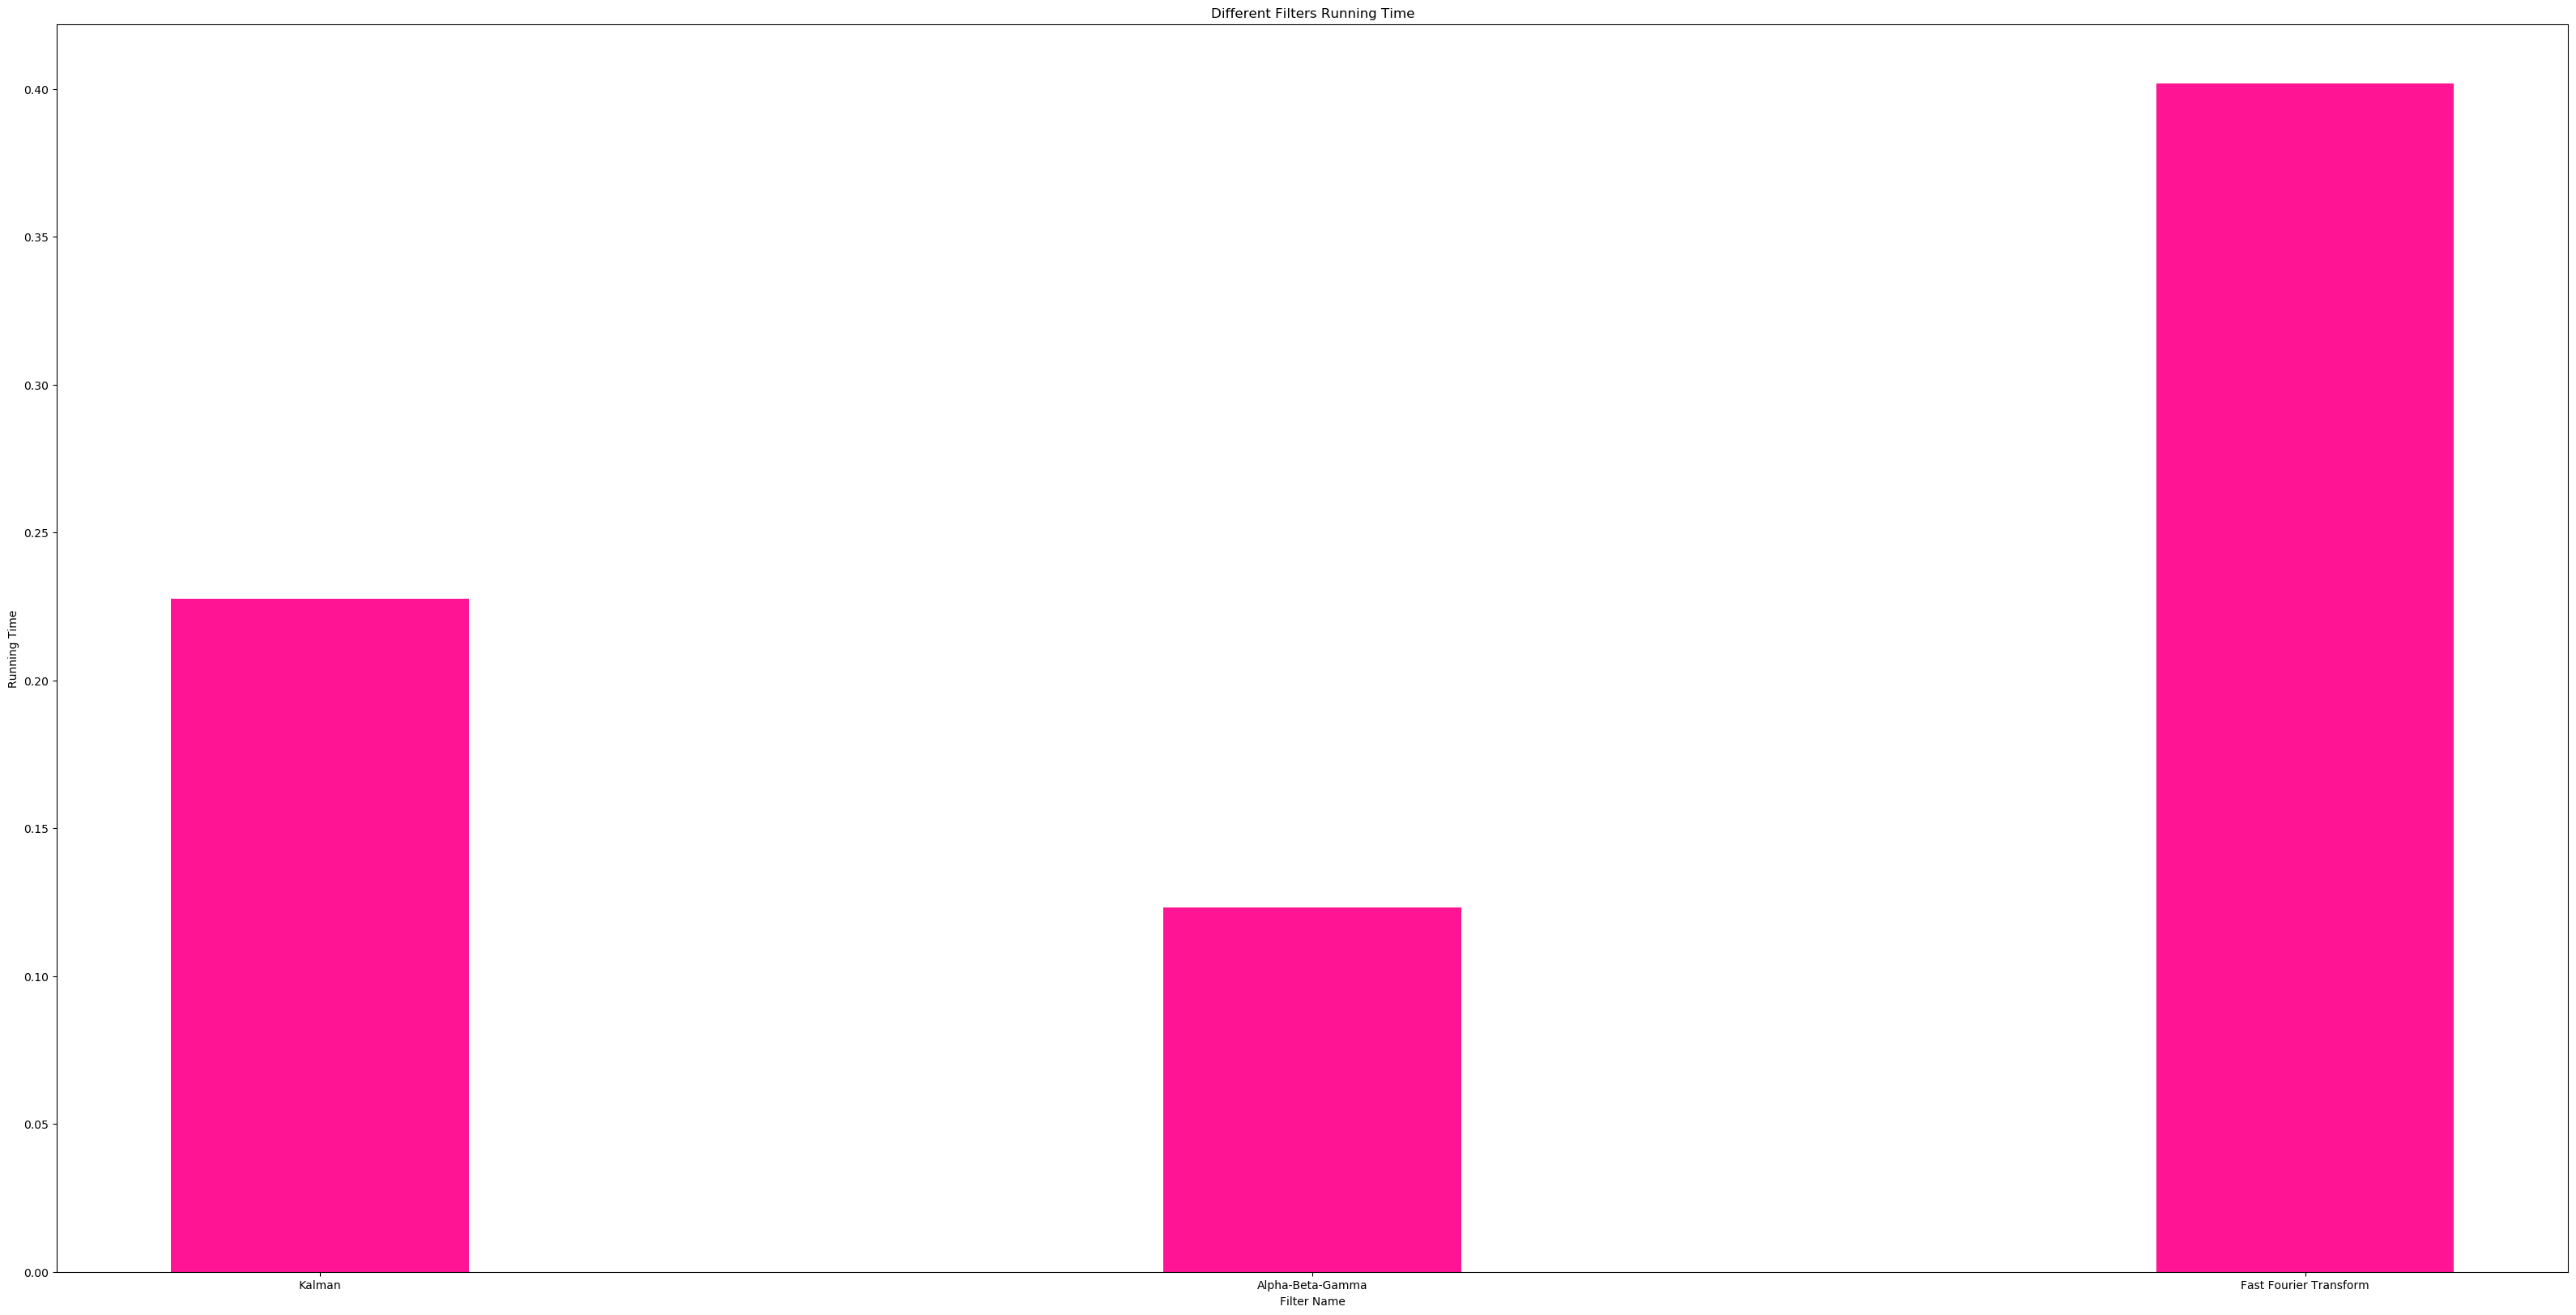

In [296]:
filters = ('Kalman', 'Alpha-Beta-Gamma', 'Fast Fourier Transform')
y_pos = np.arange(len(filters))

plt.bar(y_pos, filter_times,0.3, color="deeppink" ,align='center', alpha=1)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(y_pos, filters)
plt.xlabel('Filter Name')
plt.ylabel('Running Time')
plt.title('Different Filters Running Time')

plt.show()

In [297]:
kshuf, ktrain, kvalidation, ktest, kX_train, ktarget_train, kX_validation, ktarget_validation, kX_test, ktarget_test = split_train_validation_test(kalman_filtered2, 0.8,0.1)


In [298]:
ashuf, atrain, avalidation, atest, aX_train, atarget_train, aX_validation, atarget_validation, aX_test, atarget_test = split_train_validation_test(alpha_filtered2, 0.8,0.1)


In [299]:
fshuf, ftrain, fvalidation, ftest, fX_train, ftarget_train, fX_validation, ftarget_validation, fX_test, ftarget_test = split_train_validation_test(fft_filtered2, 0.8,0.1)


In [300]:
def plot_measured_estimated(measured_signal, estimated_signal, title):
    signals = [{'name': 'Measured Signal', 'x': np.arange(len(measured_signal)),
             'y': measured_signal, 'color':'orange', 'linewidth':3},
            {'name': 'Estimated Signal', 'x': np.arange(len(estimated_signal)),
             'y': estimated_signal, 'color':'green', 'linewidth':3}]

    fig, ax = plt.subplots()
    for signal in signals:
        ax.plot(signal['x'], signal['y'], 
                color=signal['color'], 
                linewidth=signal['linewidth'],
                label=signal['name'])
    plt.rcParams['figure.figsize'] = [40, 20]
    ax.legend()
    ax.set_title(title)
    plt.show()
    

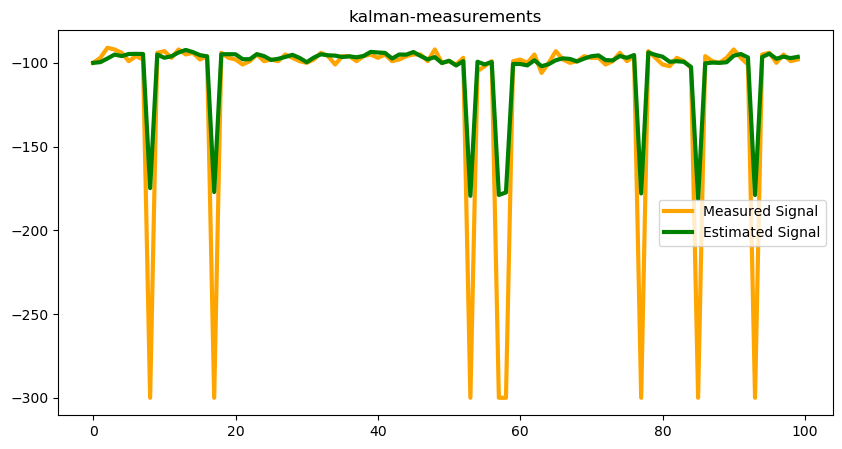

In [301]:
plot_measured_estimated(fingerprints_df['beacon1'].values.tolist()[:100],kalman_filtered2['beacon1'].values.tolist()[:100],"kalman-measurements")

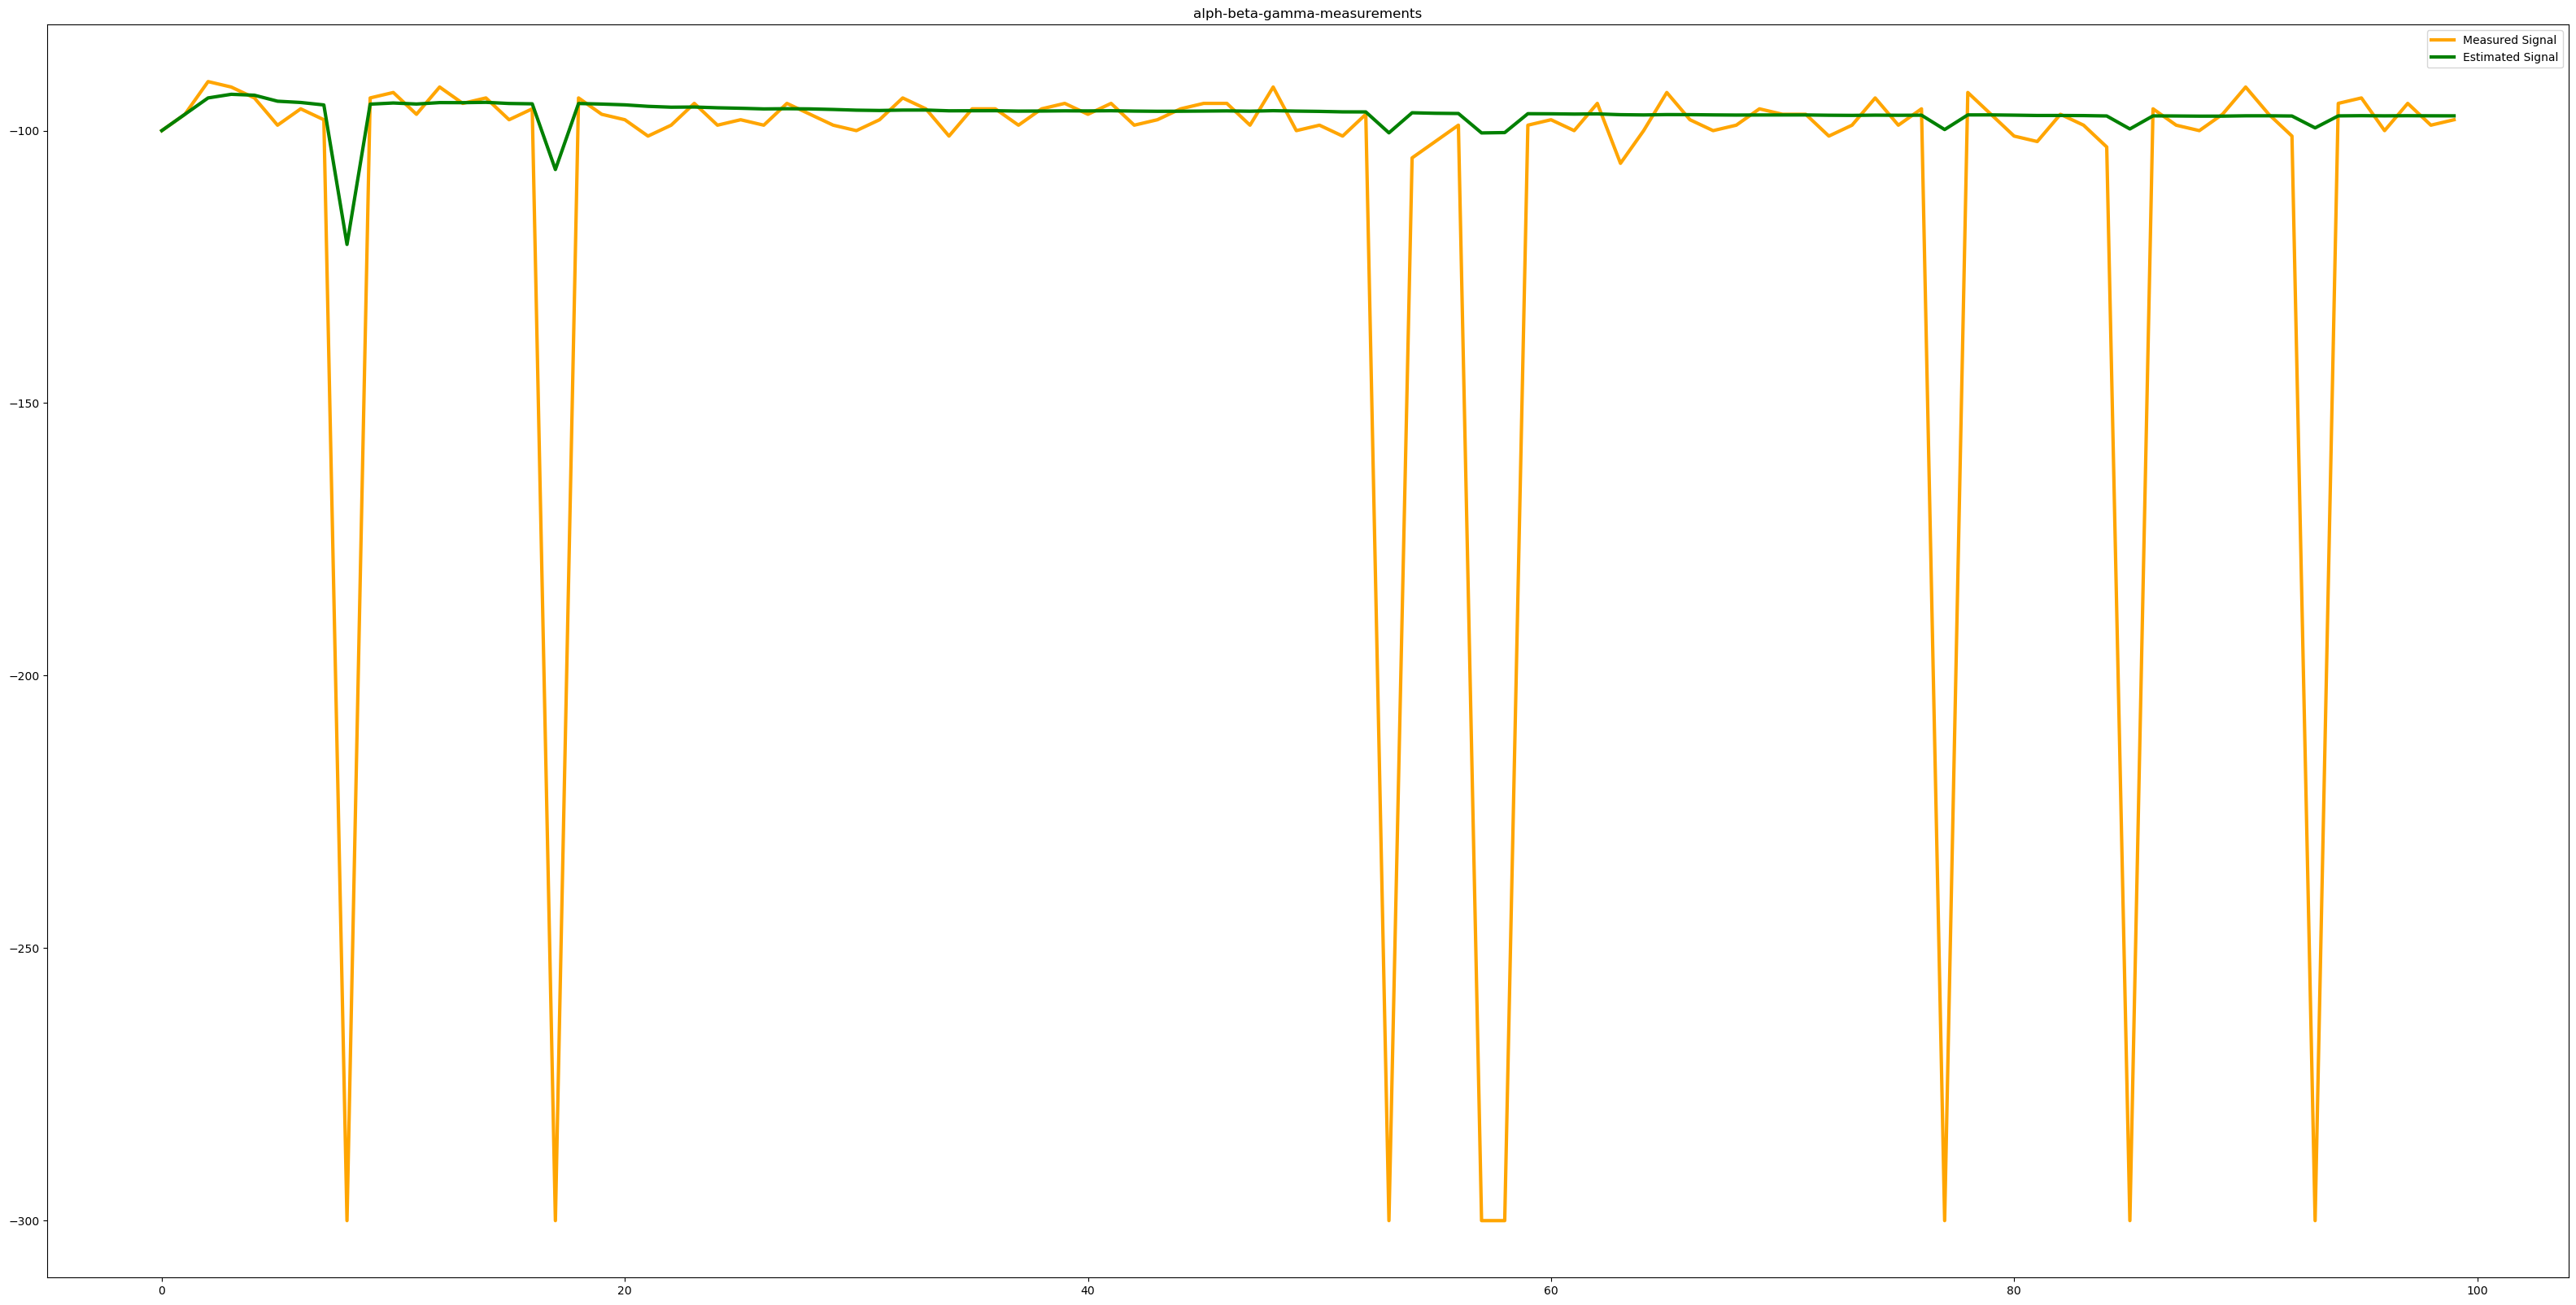

In [302]:
plot_measured_estimated(fingerprints_df['beacon1'].values.tolist()[:100],alpha_filtered2['beacon1'].values.tolist()[:100],"alph-beta-gamma-measurements")

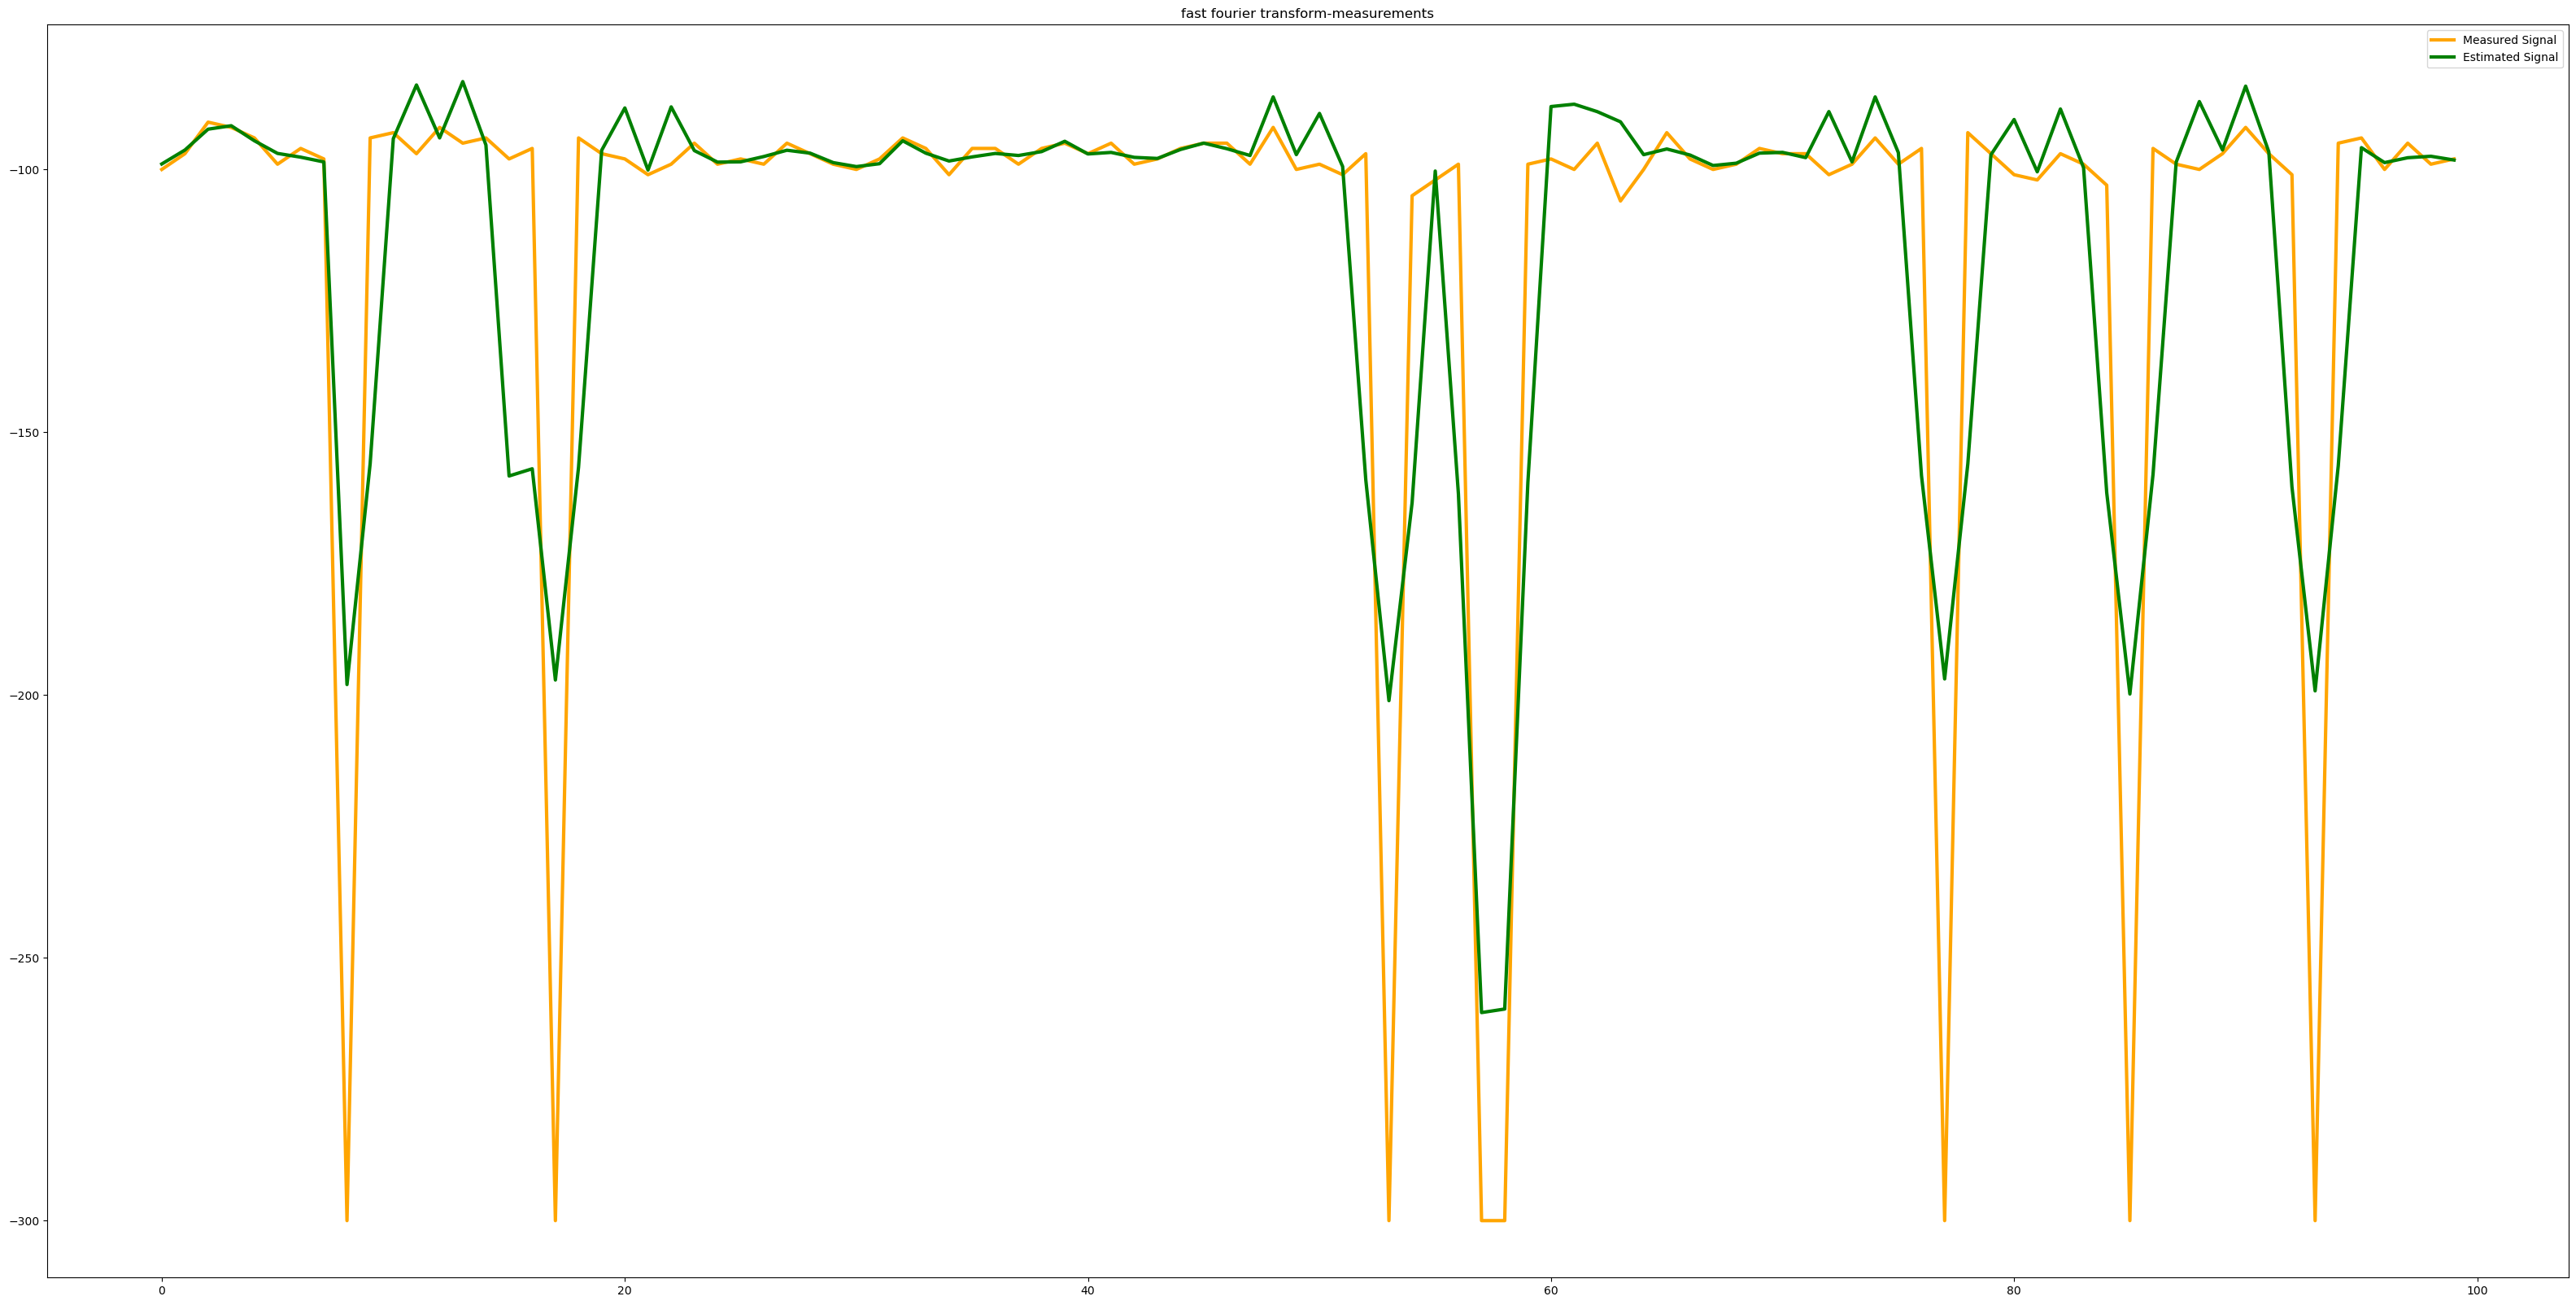

In [303]:
plot_measured_estimated(fingerprints_df['beacon1'].values.tolist()[0:100],fft_filtered2['beacon1'].values.tolist()[0:100],"fast fourier transform-measurements")

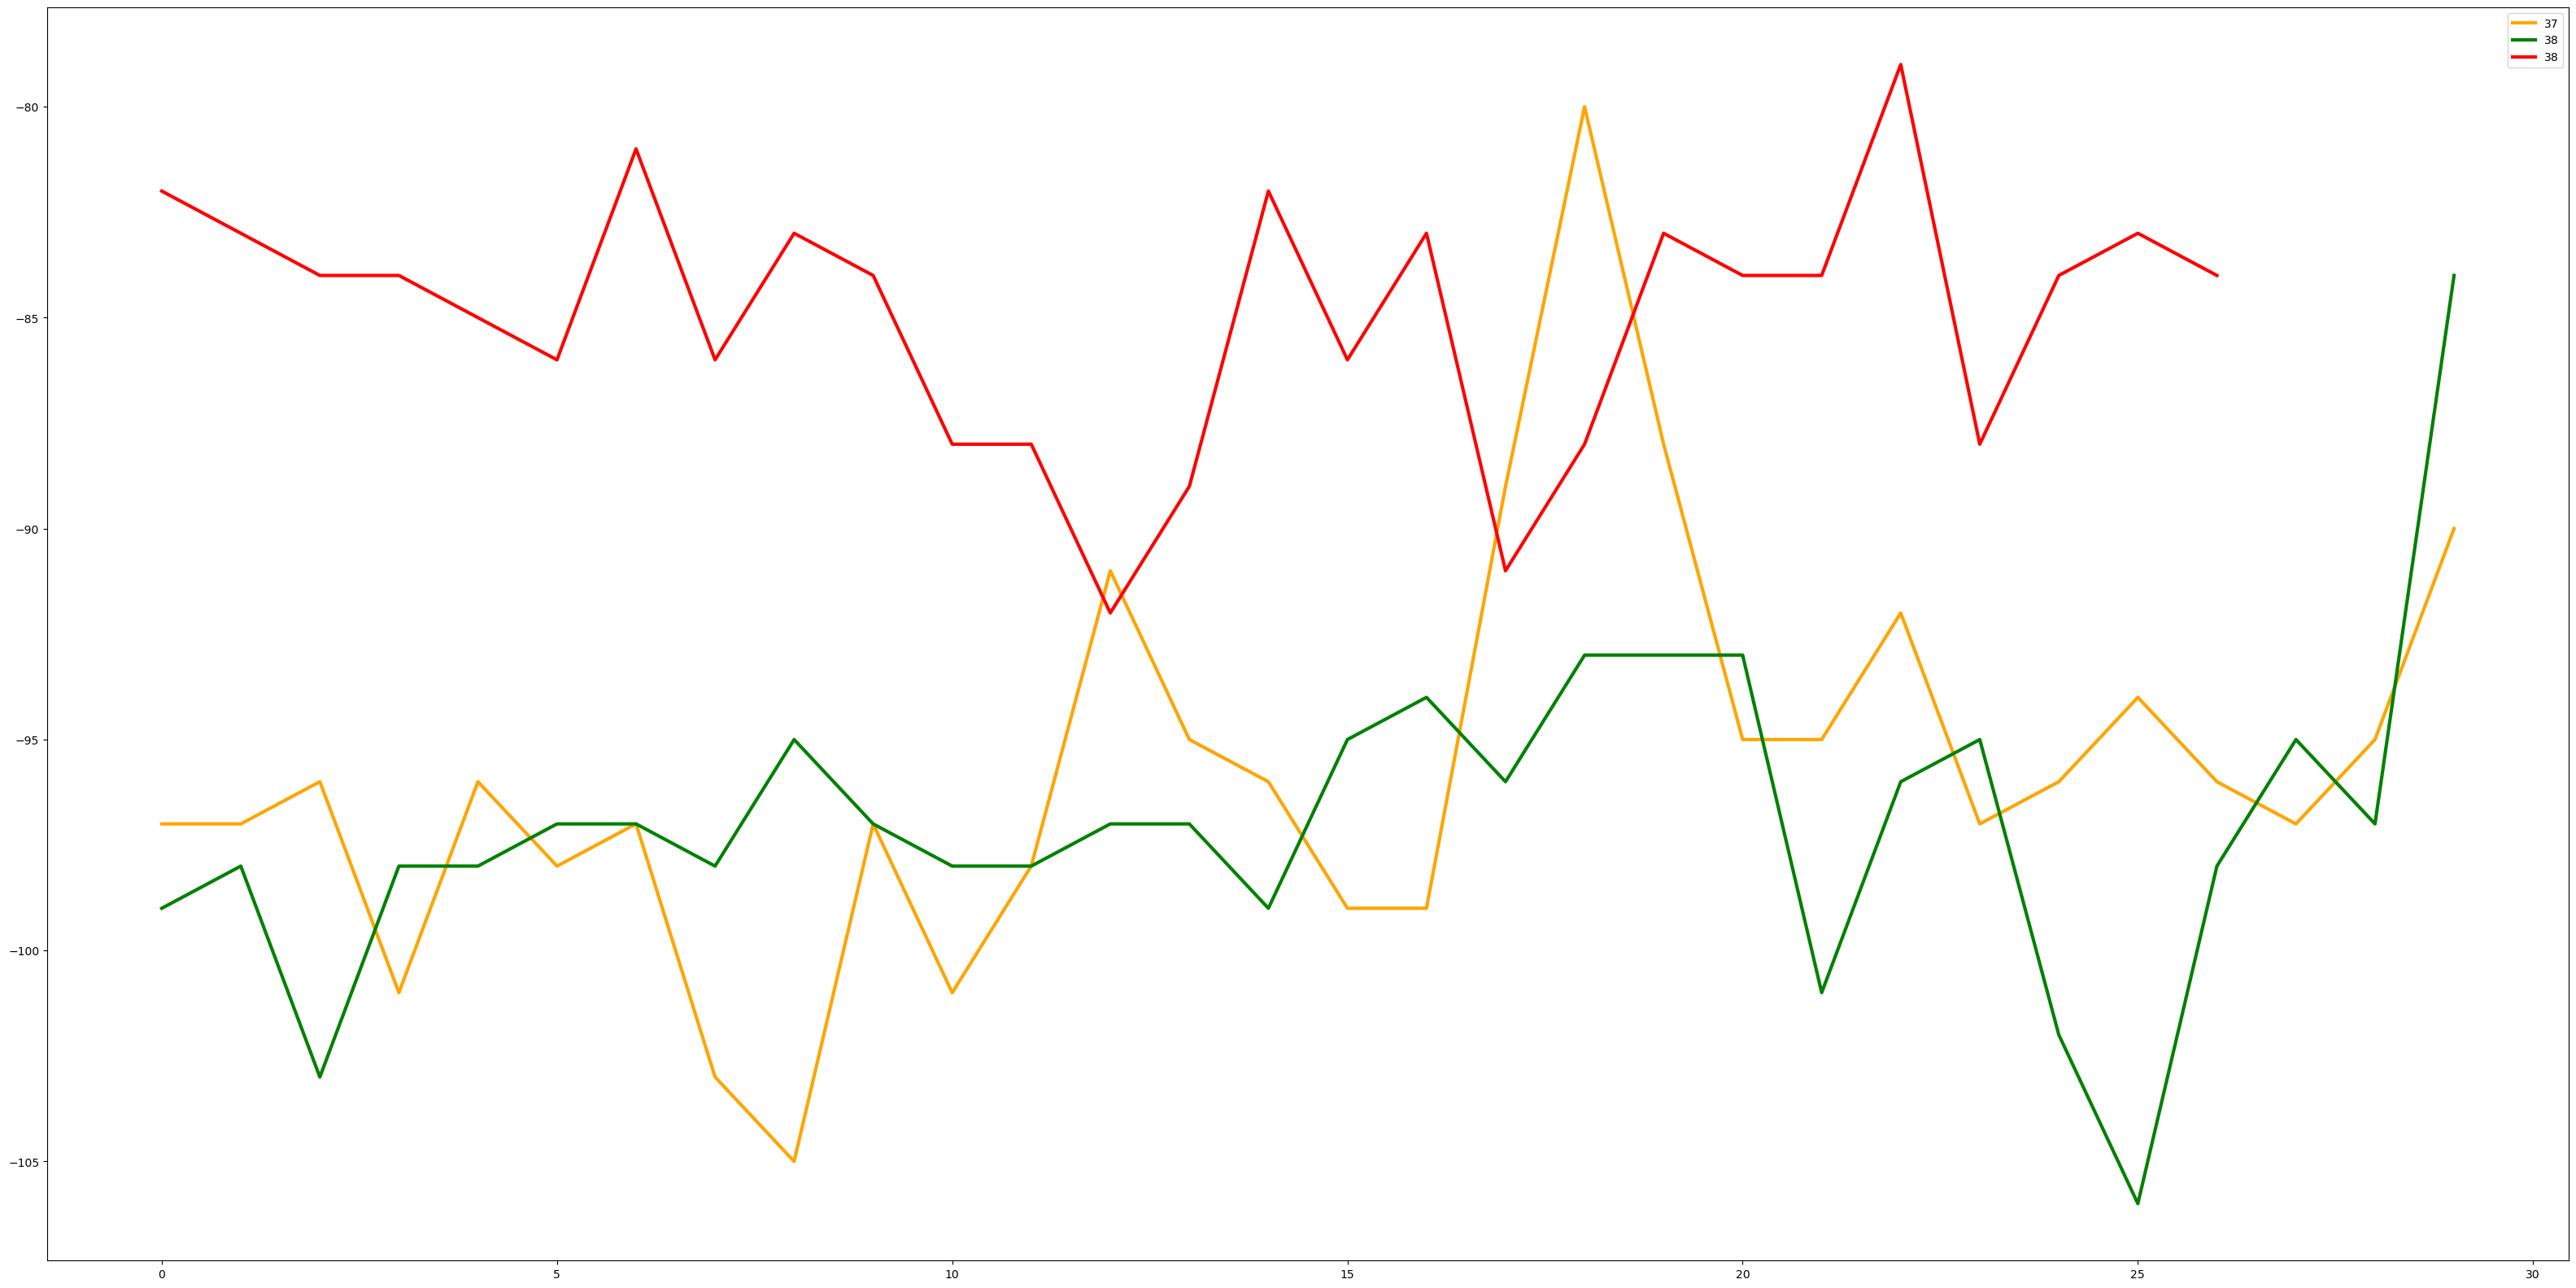

In [304]:

signals = [{'name': '37', 'x': np.arange(len(fingerprints_df[(fingerprints_df.channel5_37==1)]['beacon1'].values.tolist()[0:30])),
             'y': fingerprints_df[(fingerprints_df.channel5_37==1)]['beacon5'].values.tolist()[0:30], 'color':'orange', 'linewidth':3},
            {'name': '38', 'x': np.arange(len(fingerprints_df[(fingerprints_df.channel5_38==1)]['beacon1'].values.tolist()[0:30])),
             'y': fingerprints_df[(fingerprints_df.channel5_38==1)]['beacon5'].values.tolist()[0:30], 'color':'green', 'linewidth':3},
            {'name': '38', 'x': np.arange(len(fingerprints_df[(fingerprints_df.channel5_39==1)]['beacon1'].values.tolist()[0:30])),
             'y': fingerprints_df[(fingerprints_df.channel5_39==1)]['beacon5'].values.tolist()[0:30], 'color':'red', 'linewidth':3}]

fig, ax = plt.subplots()
for signal in signals:
        ax.plot(signal['x'], signal['y'], 
                color=signal['color'], 
                linewidth=signal['linewidth'],
                label=signal['name'])
plt.rcParams['figure.figsize'] = [40, 20]
ax.legend()
# ax.set_title(title)
plt.show()


# Artificial Intelligence Algorithms

## K Nearest Neighbours

In [305]:
def k_nearest_neighbours(X_train, target_train, X_test, target_test,title):  
    accuracies = []
    for k in range(1, 9):
        knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
        knn.fit(X_train, target_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(target_test, y_pred)*100)

    plt.plot(list(range(1,9)), accuracies)
    plt.xticks(range(1,9))
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.title('K-nearest neighbours alogrithm accuracies with '+title)
    plt.show()
    print("K-nearest neighbours algorithm accuracy: "+ str(max(accuracies)))
    return max(accuracies)

In [306]:
def run_knn(X_train, target_train, X_test, target_test, k):
    knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
    knn.fit(X_train, target_train)
    start_time = time.time()
    y_pred = knn.predict(X_test)
    runtime = round(time.time() - start_time,4)
    return y_pred, runtime

#### K-NN with the Original Data

##### Original Data without Channel Data

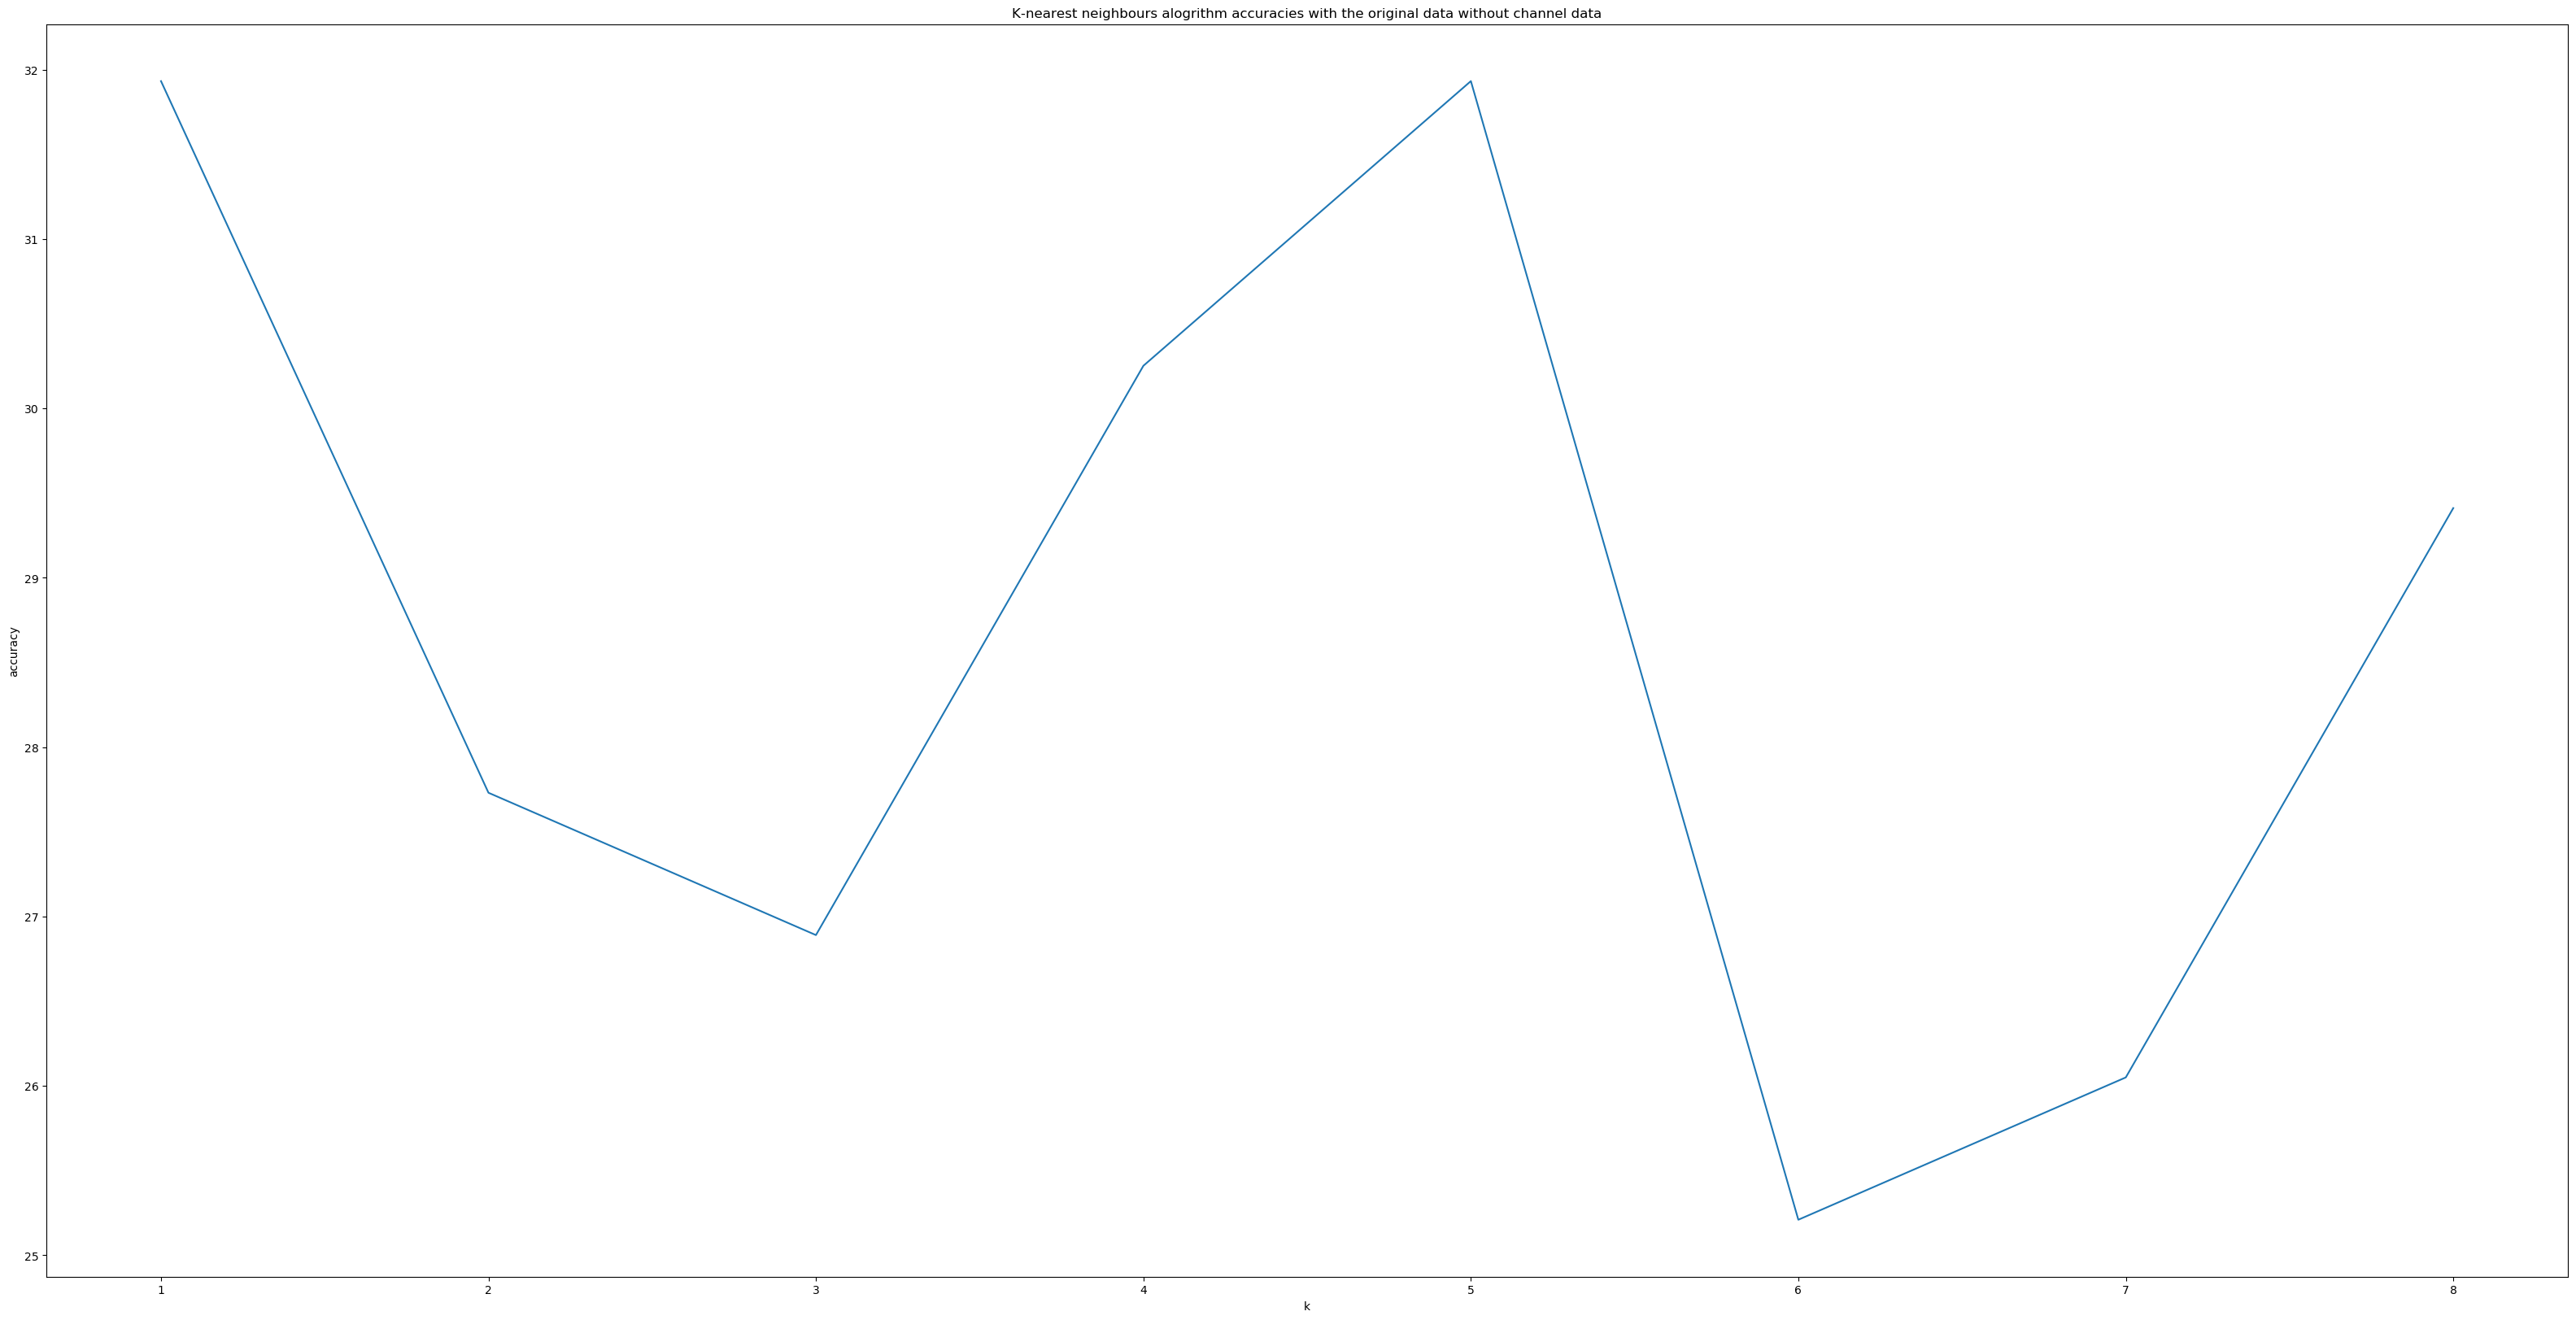

K-nearest neighbours algorithm accuracy: 31.932773109243694


31.932773109243694

In [307]:
no_channel_training_cols = ['beacon1', 'beacon2','beacon3','beacon4','beacon5','beacon6', 'beacon7', 'beacon8', 'beacon9', 'beacon10', 'beacon11', 'beacon12','beacon13','beacon14','beacon15','beacon16', 'beacon17', 'beacon18', 'beacon19', 'beacon20']
X_train_nc = X_train.loc[:, no_channel_training_cols]
X_validation_nc = X_validation.loc[:, no_channel_training_cols]
k_nearest_neighbours(X_train_nc, target_train, X_validation_nc, target_validation, "the original data without channel data")

##### Original Data with Channel Data

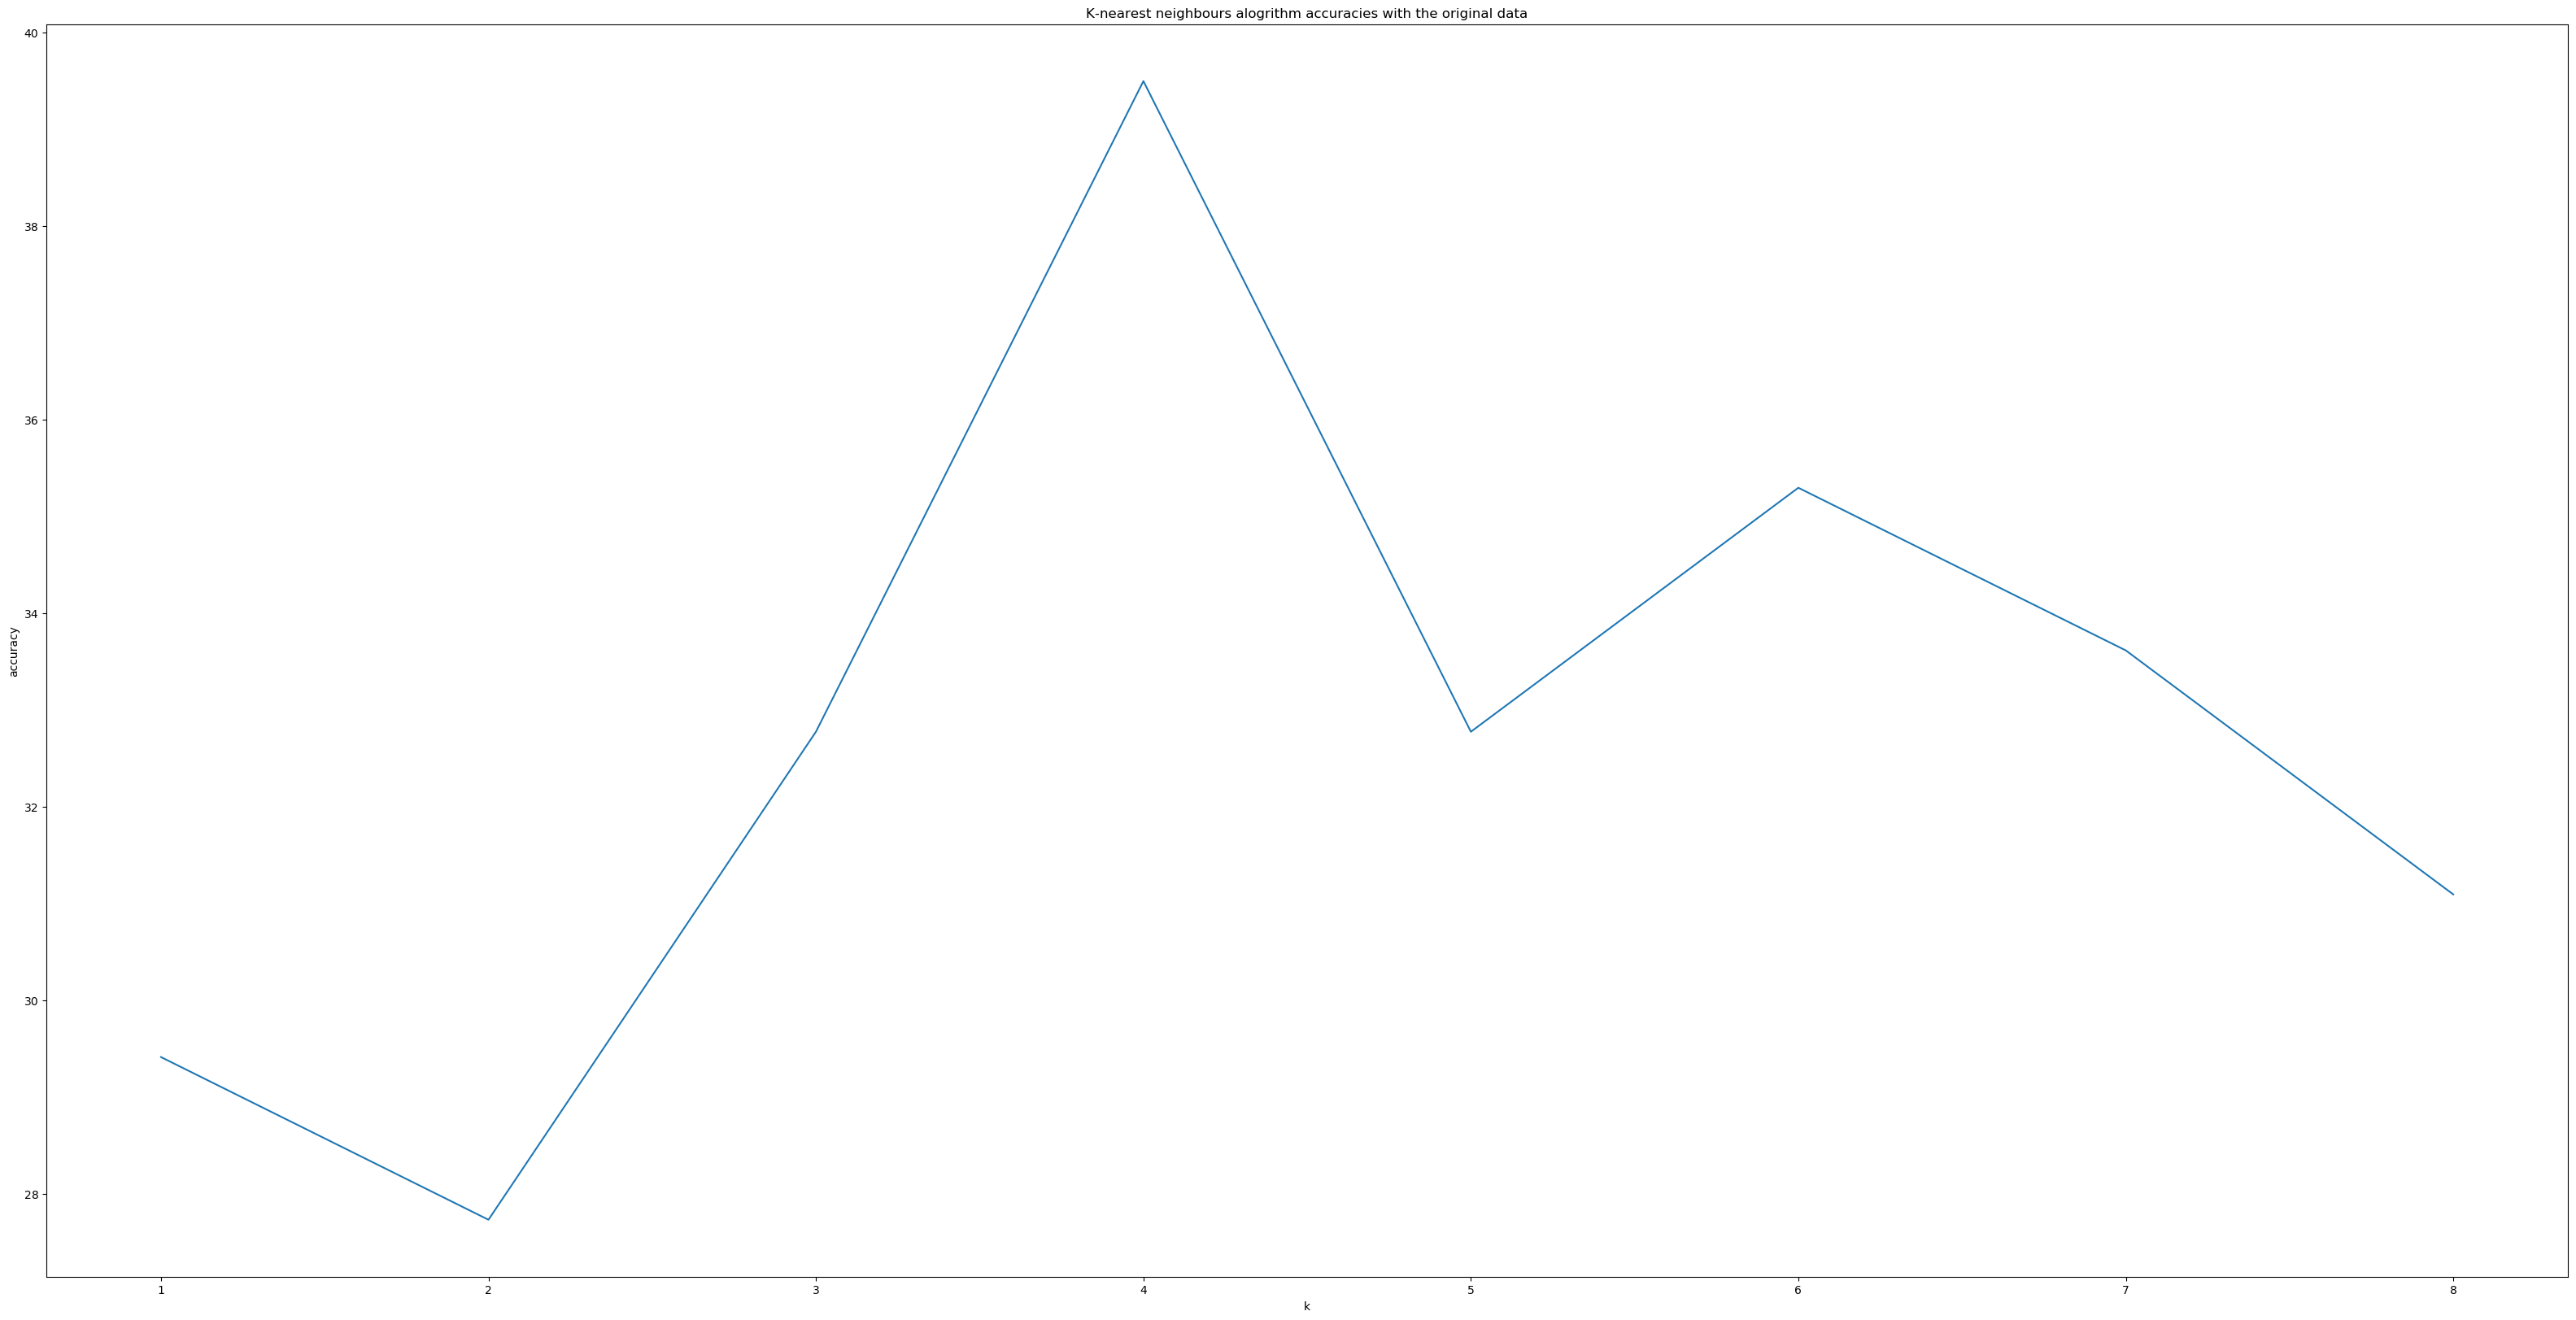

K-nearest neighbours algorithm accuracy: 39.49579831932773


In [308]:
accuracies = []
accuracies.append(k_nearest_neighbours(X_train, target_train, X_validation, target_validation, "the original data"))

#### K-NN with the Kalman Filter Preprocessing

In [309]:
def split_train_cols(dataframe):
    training_cols = [col for col in dataframe if col not in ['location']]
    train_set = dataframe.loc[:, training_cols]
    target_train = dataframe.loc[:, 'location']
    return train_set, target_train

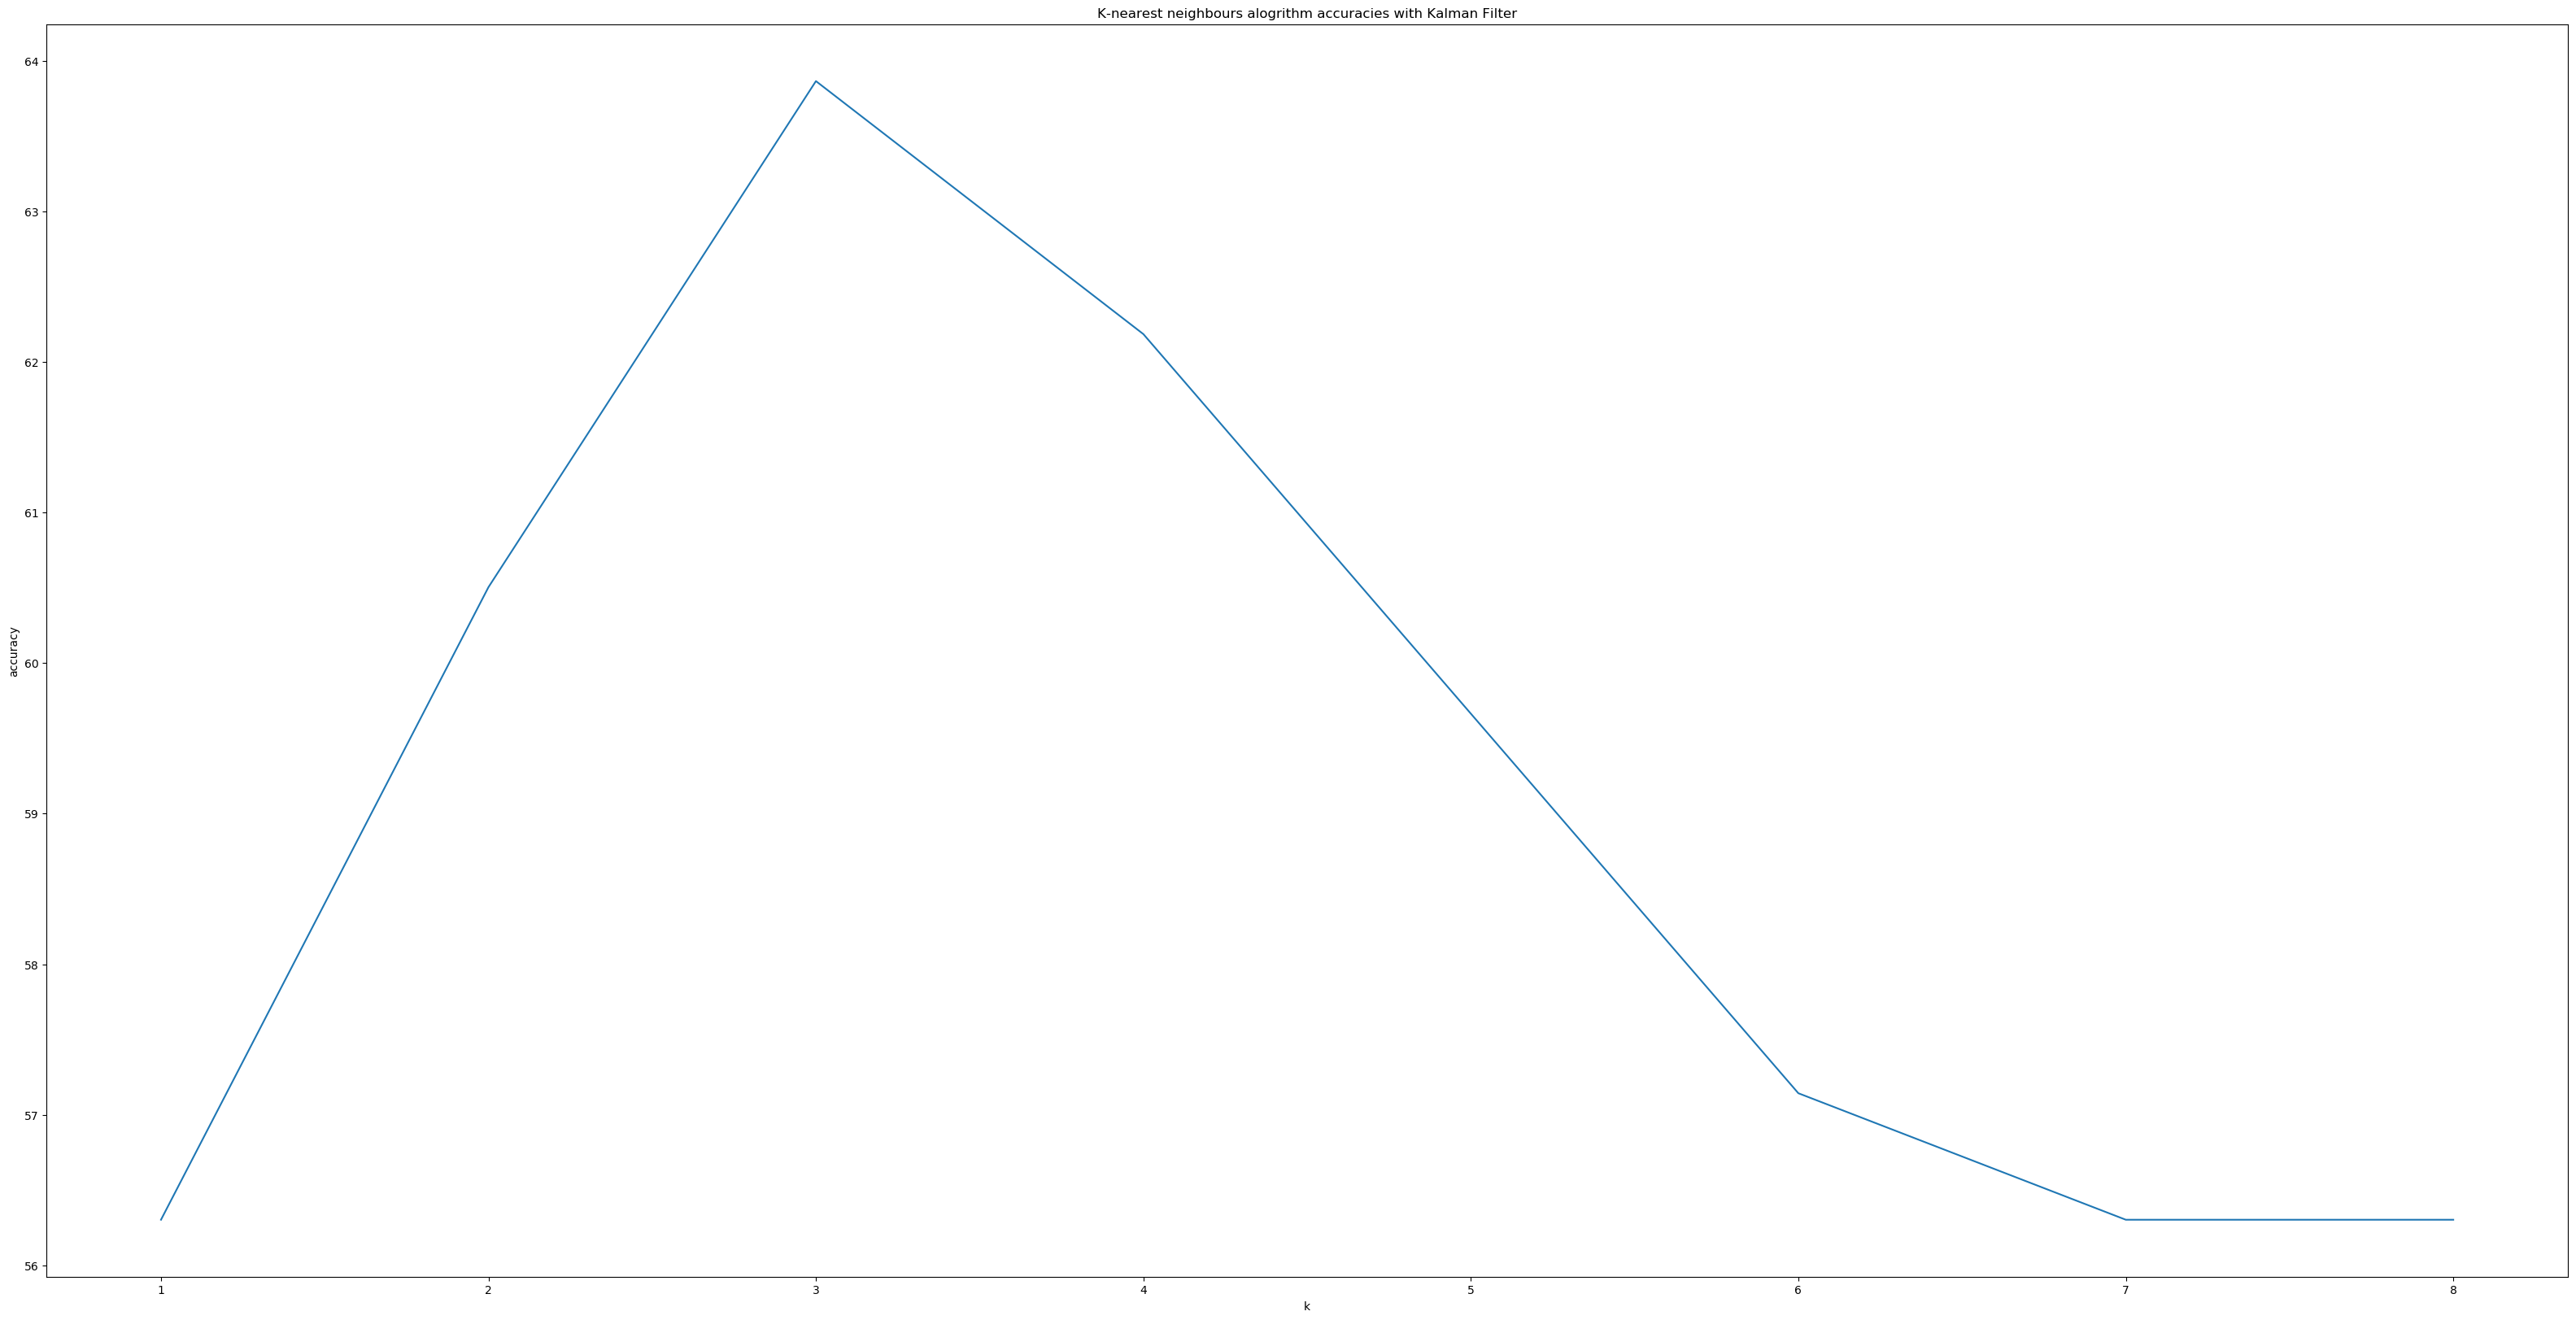

K-nearest neighbours algorithm accuracy: 63.86554621848739


In [310]:
accuracies.append(k_nearest_neighbours(kX_train, ktarget_train, kX_validation, ktarget_validation, "Kalman Filter"))

#### K-NN with the Alpha-Beta-Gamma Filter Preprocessing

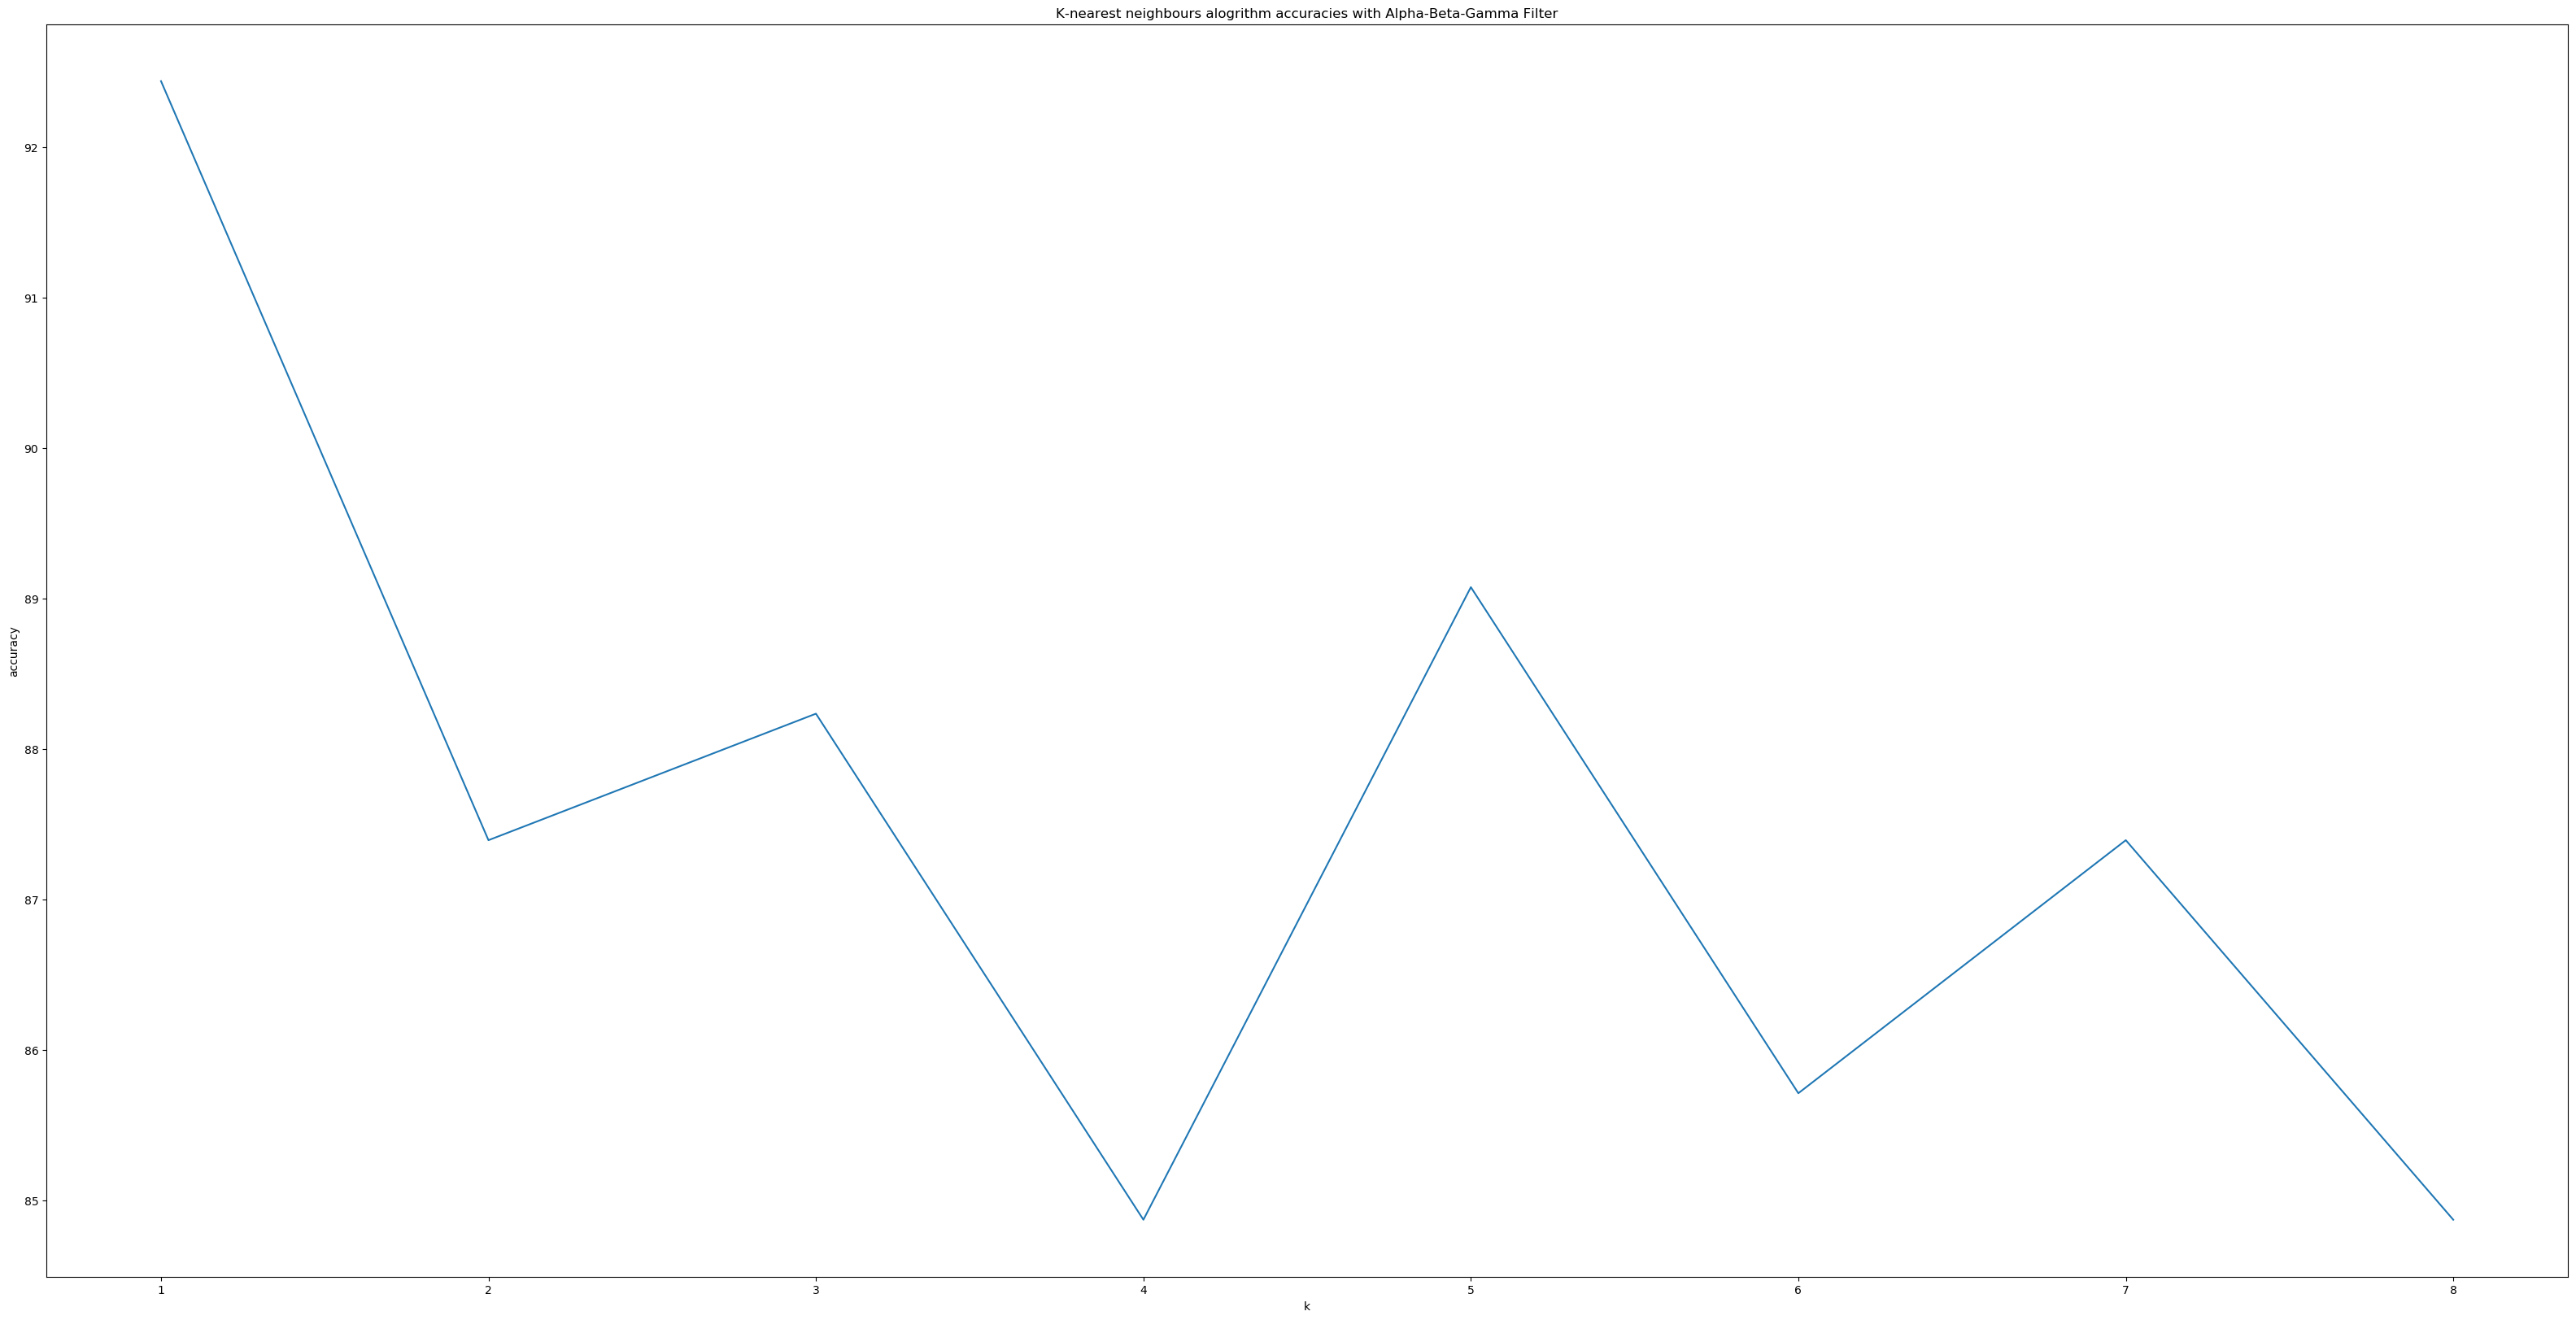

K-nearest neighbours algorithm accuracy: 92.43697478991596


In [311]:
accuracies.append(k_nearest_neighbours(aX_train, atarget_train, aX_validation, atarget_validation, "Alpha-Beta-Gamma Filter"))

#### K-NN with the Fast Fourier Transform Filter Preprocessing

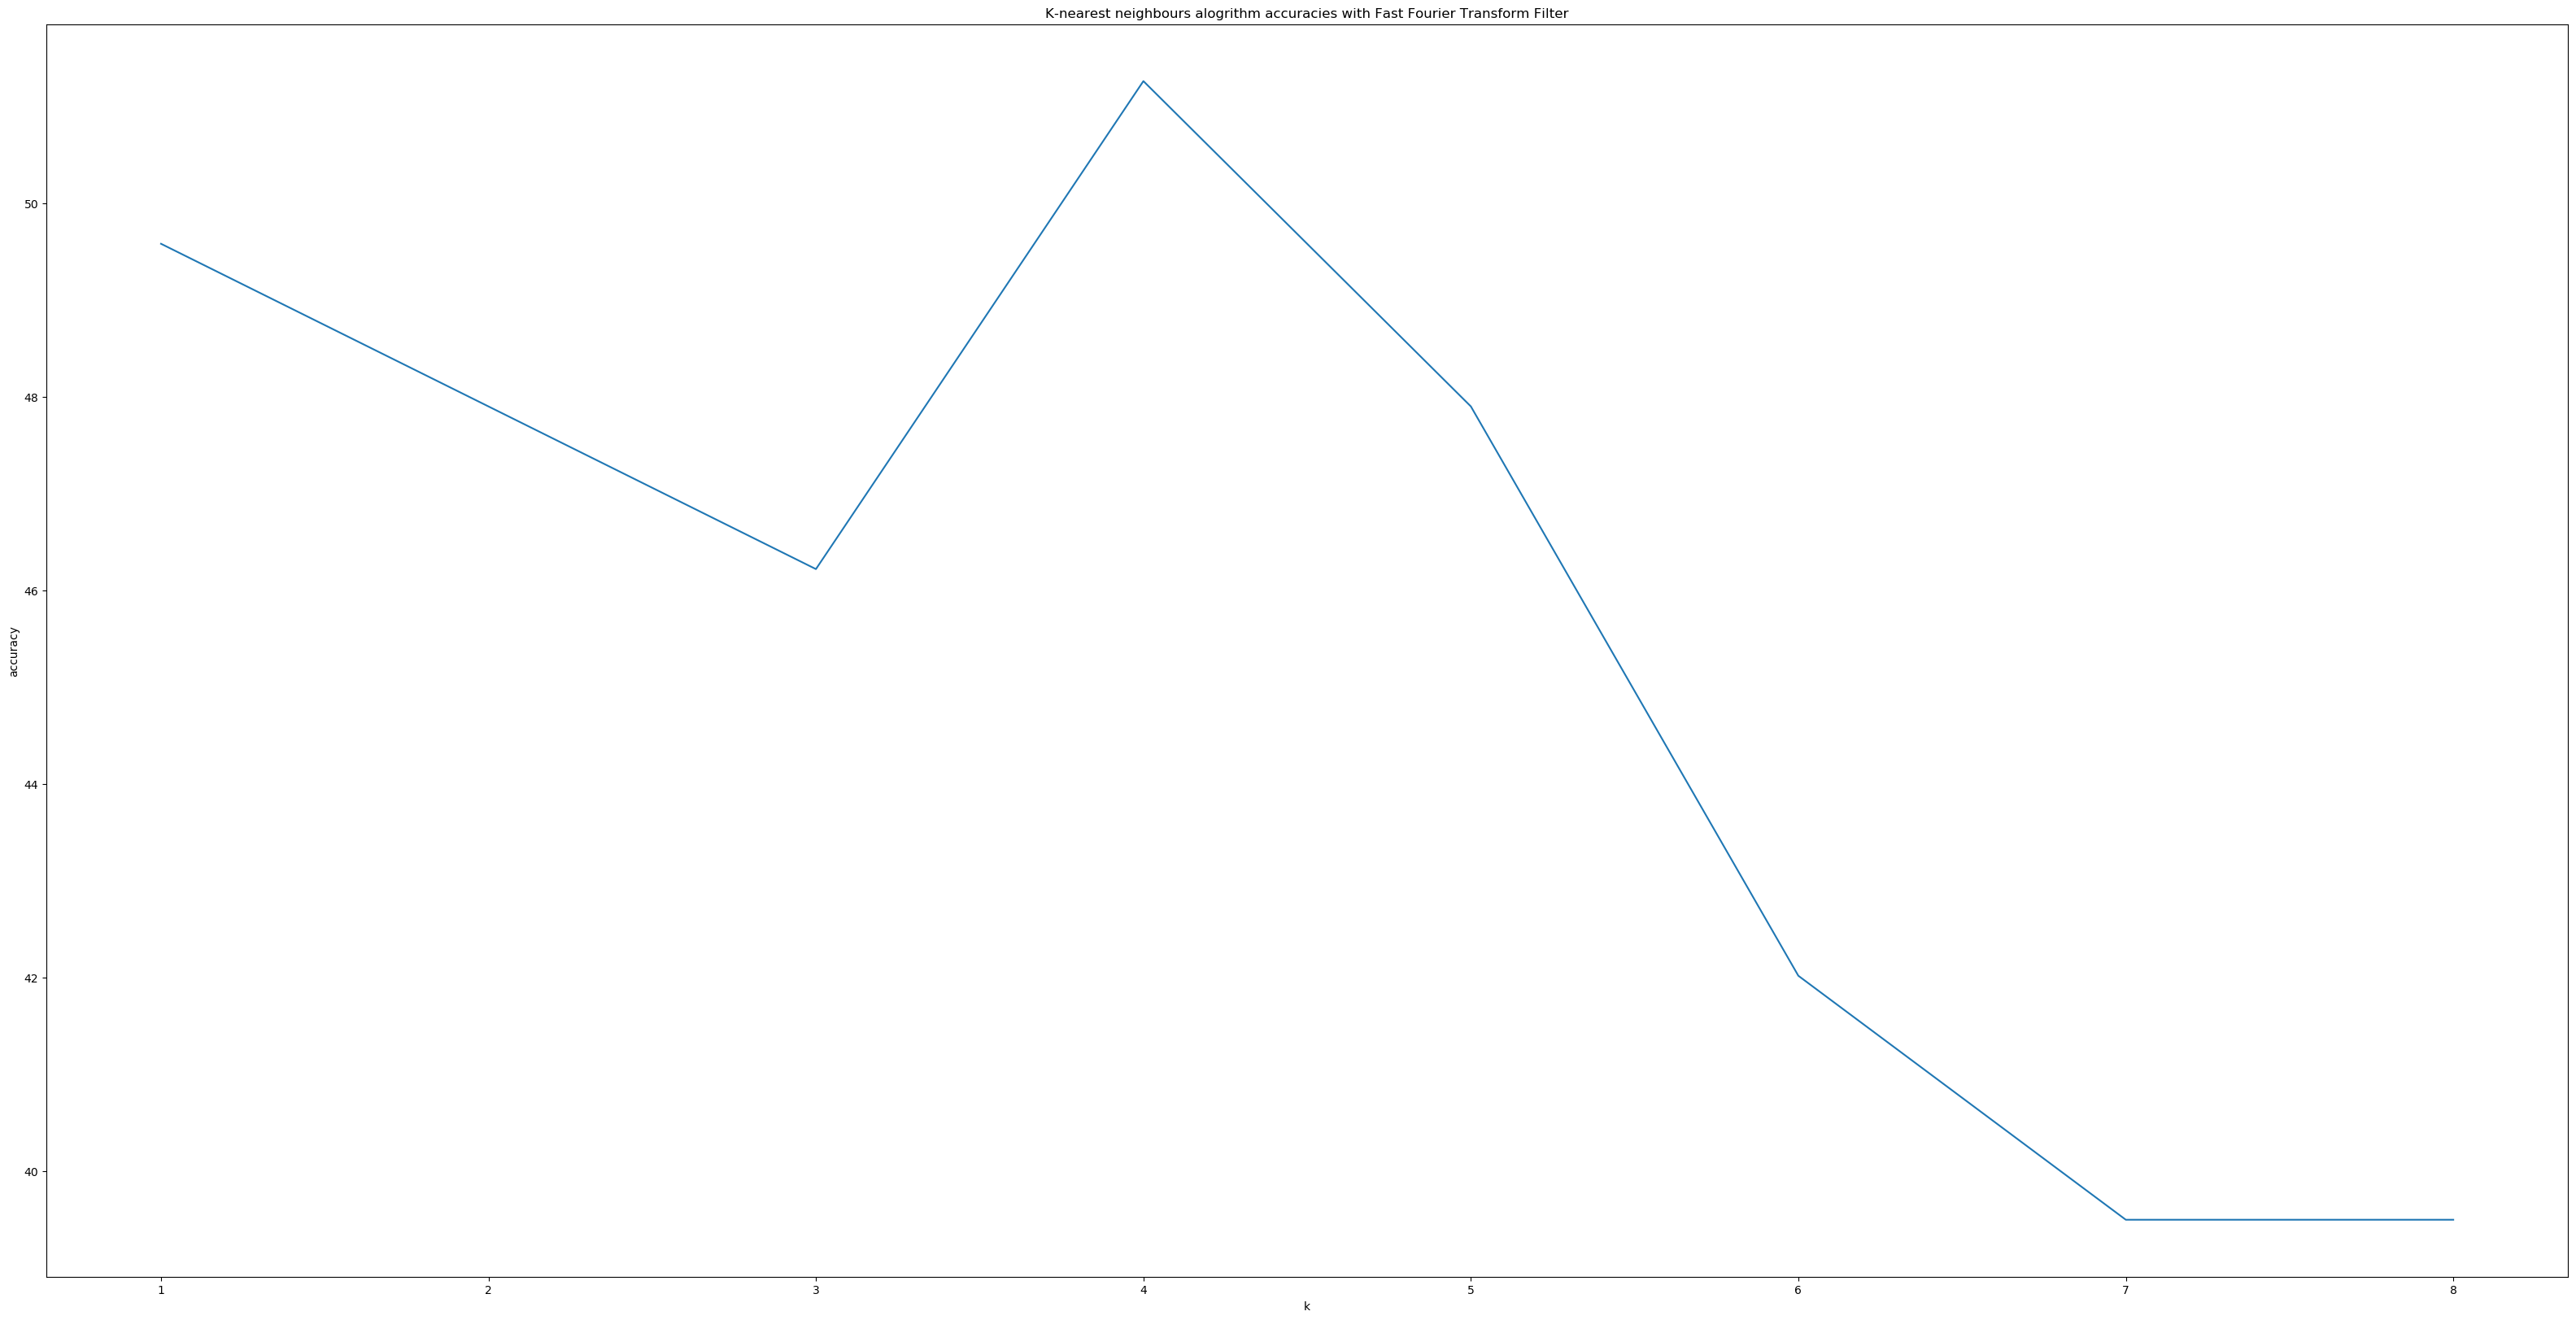

K-nearest neighbours algorithm accuracy: 51.26050420168067


In [312]:
accuracies.append(k_nearest_neighbours(fX_train, ftarget_train, fX_validation, ftarget_validation, "Fast Fourier Transform Filter"))

In [313]:
def filter_algorithm_accuracy_bardrawer(accuracies,title):
    filters = ('No filter','Kalman', 'Alpha-Beta-Gamma', 'Fast Fourier Transform')
    y_pos = np.arange(len(filters))
    print(accuracies)
    plt.bar(y_pos, accuracies,0.3, color="deeppink" ,align='center', alpha=1)
    plt.xticks(y_pos, filters)
    plt.xlabel('Filter Name')
    plt.ylabel('Accuracy')
#     plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(title)

    plt.show()

#### Summary

[39.49579831932773, 63.86554621848739, 92.43697478991596, 51.26050420168067]


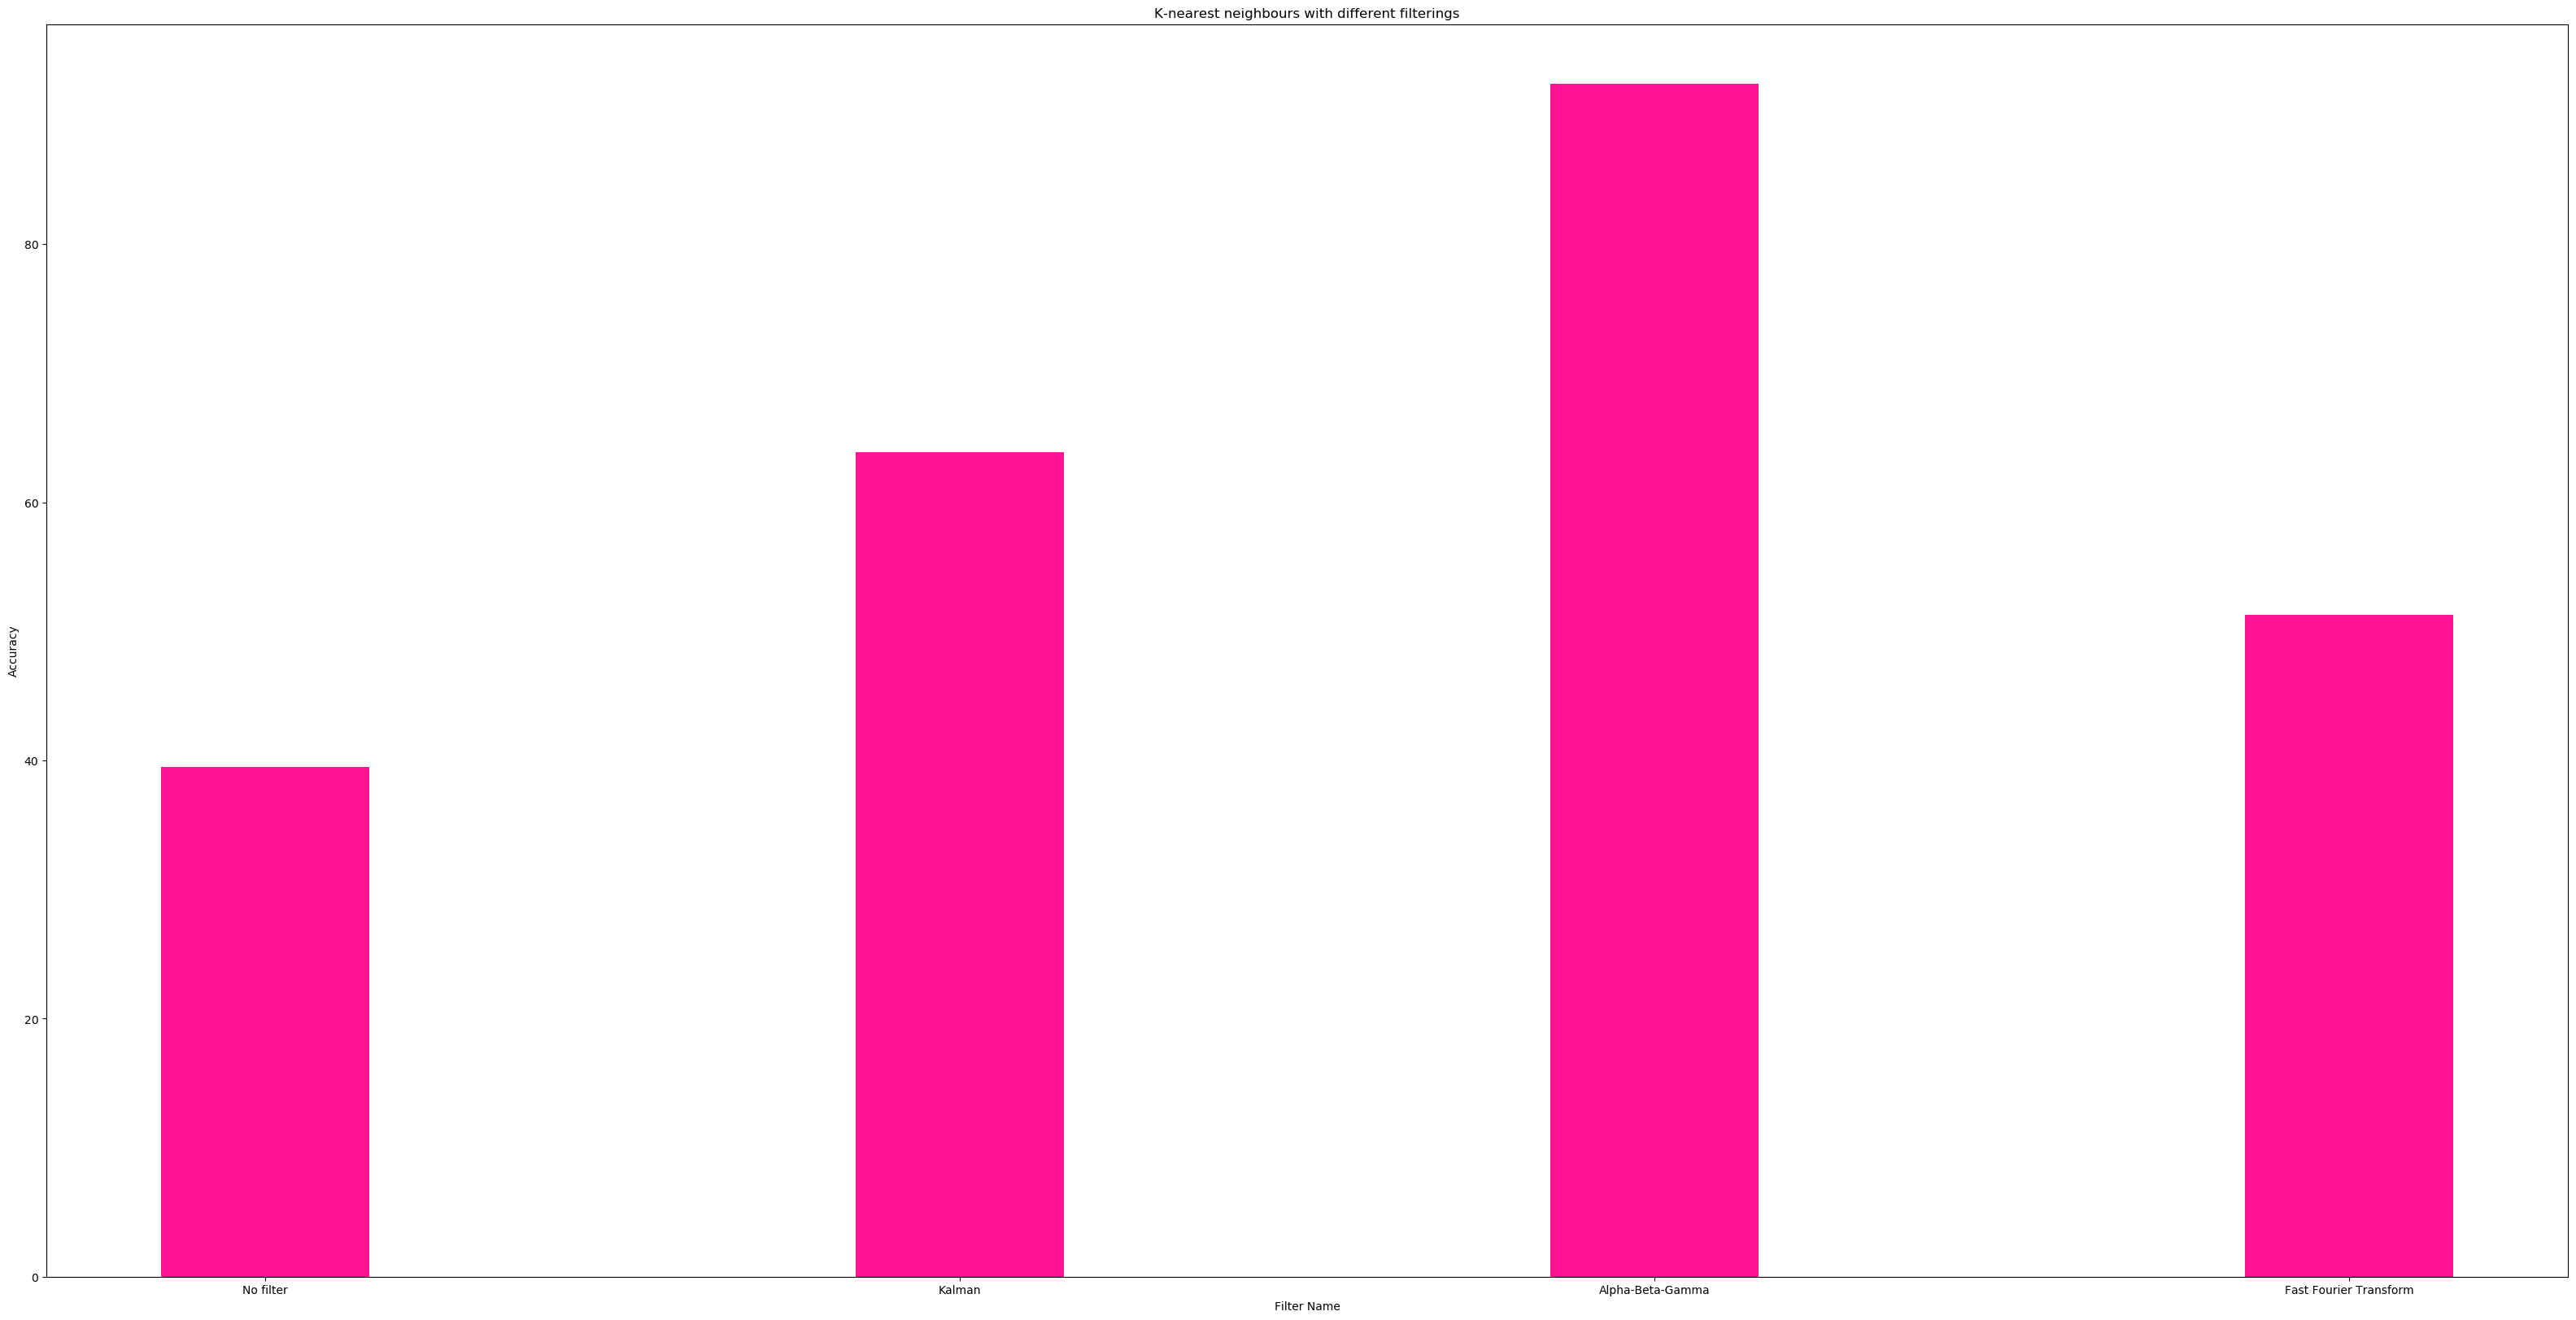

In [314]:
filter_algorithm_accuracy_bardrawer(accuracies, "K-nearest neighbours with different filterings")

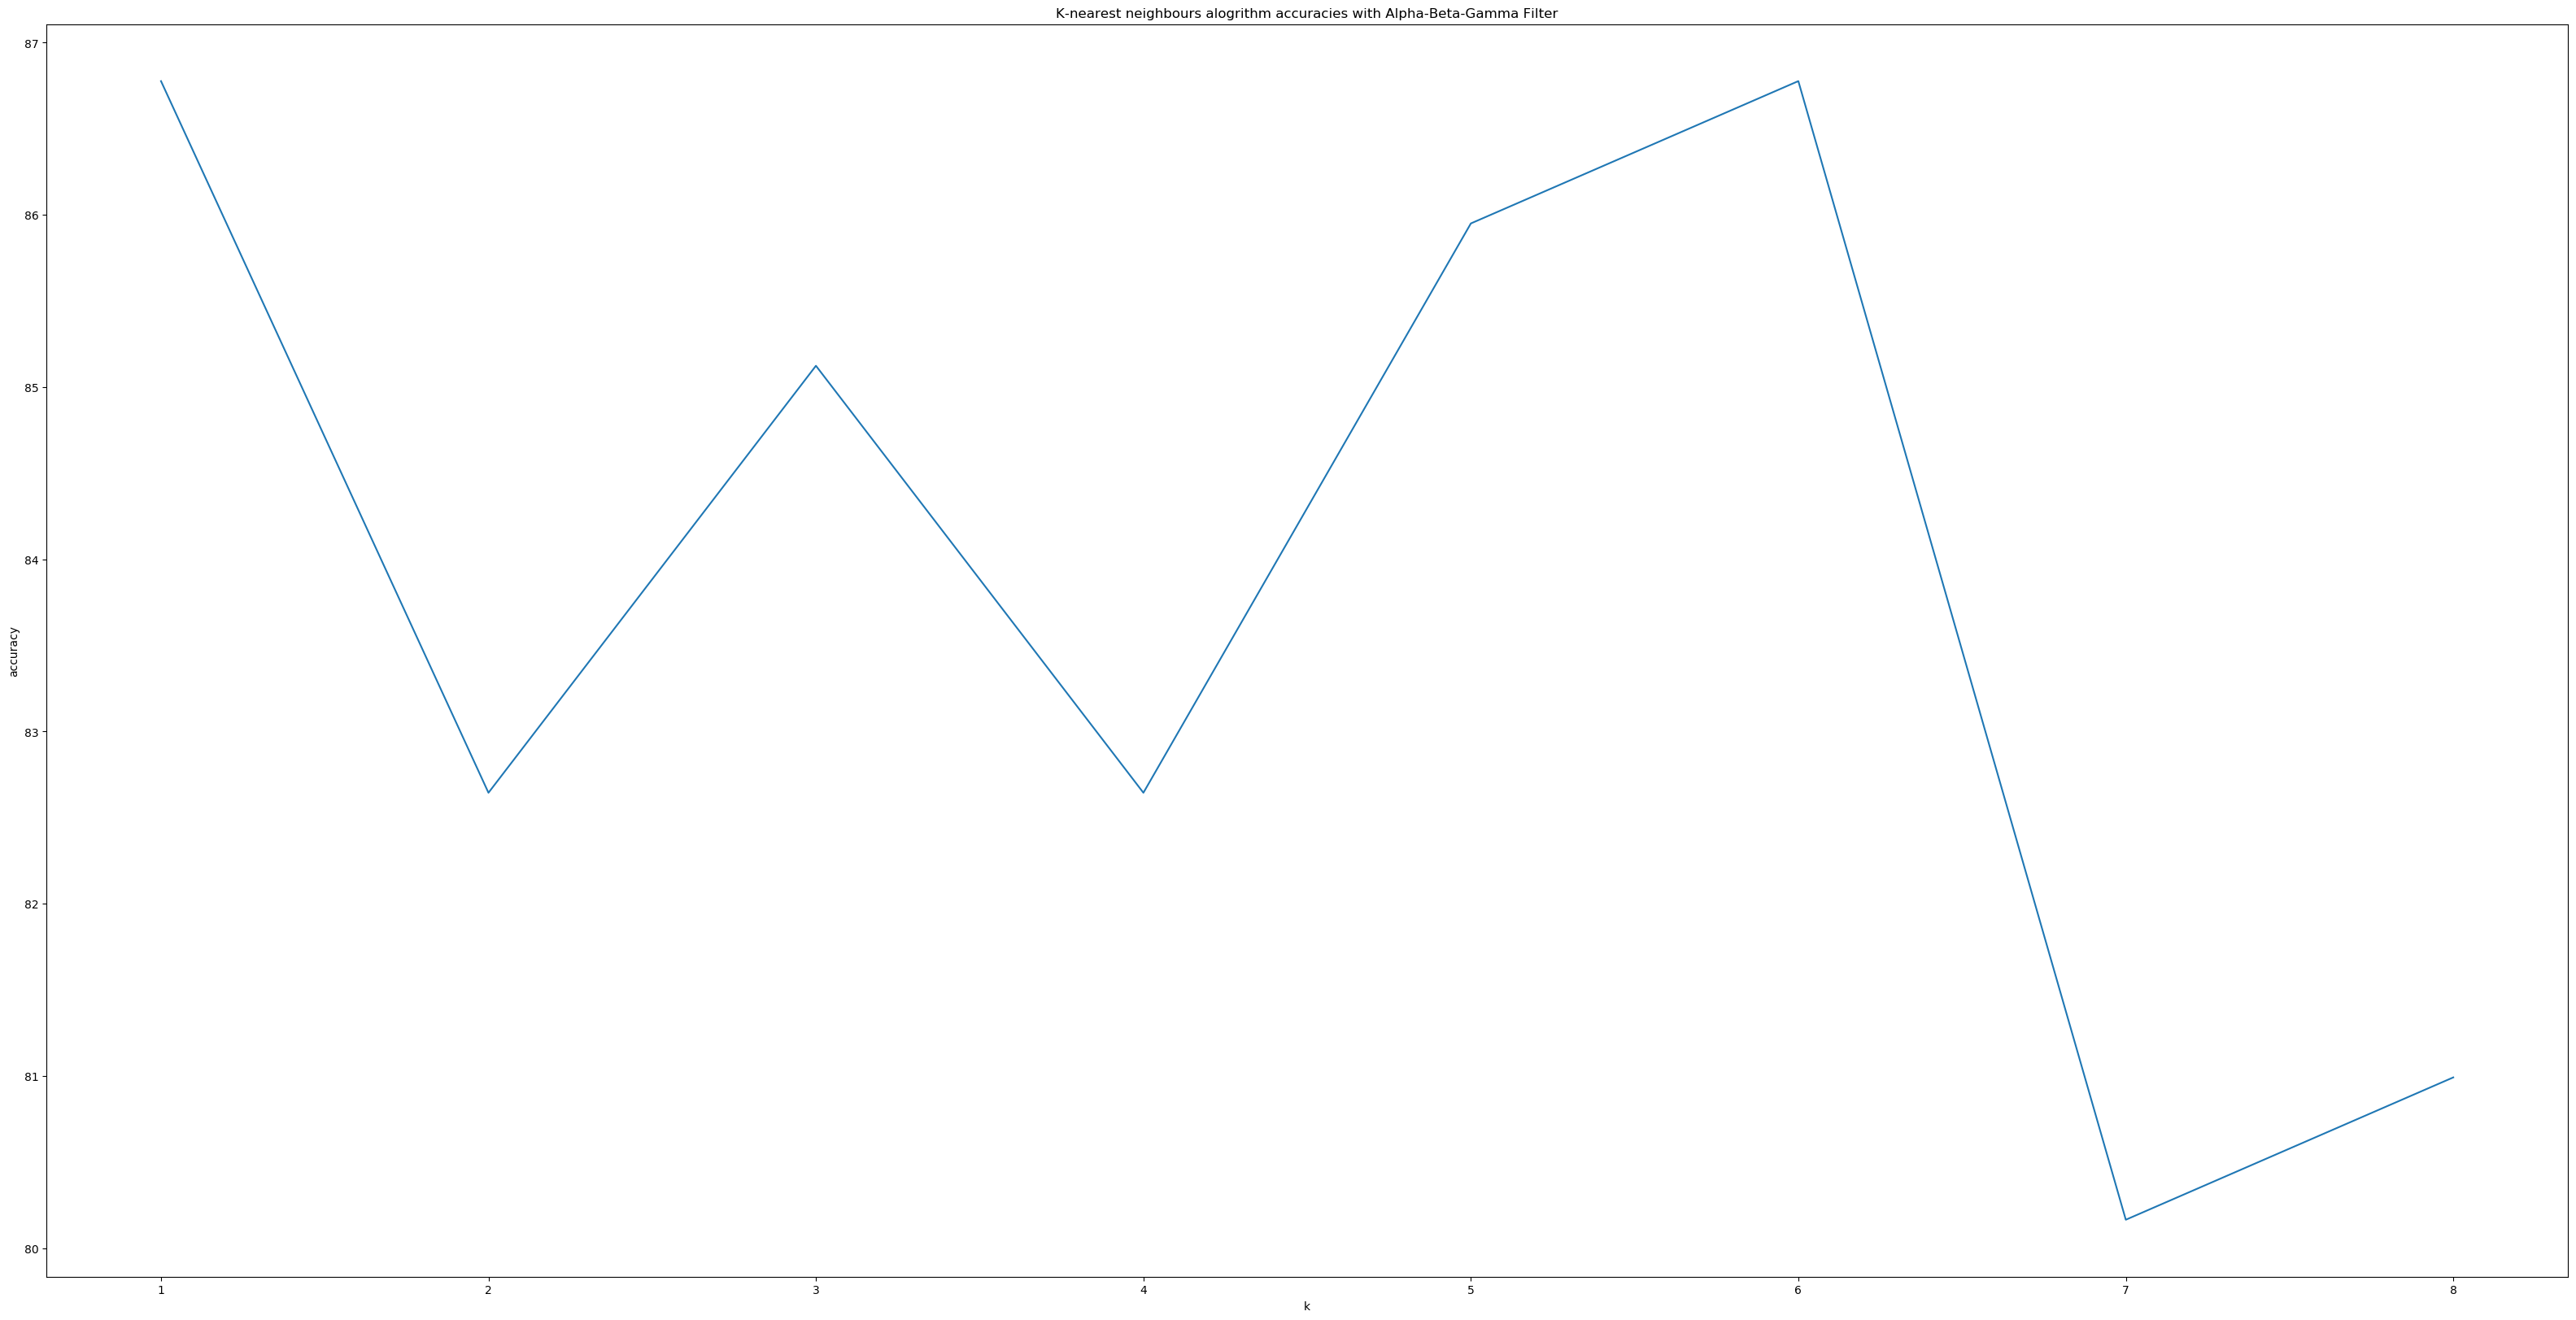

K-nearest neighbours algorithm accuracy: 86.77685950413223


86.77685950413223

In [315]:
k_nearest_neighbours(aX_train, atarget_train, aX_test, atarget_test, "Alpha-Beta-Gamma Filter")

In [316]:
prediction, run_time = run_knn(aX_train, atarget_train, aX_test, atarget_test, 6)
print(classification_report(atarget_test,prediction))
print("K nearest neighbours algorithm predication time: "+ str(run_time))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         0
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      0.67      0.80         3
          16       0.00      0.00      0.00         0
          17       1.00      1.00      1.00         1
          19       1.00    

## Decision Tree

In [317]:
grid_dt_parameters = {'criterion': ["gini", "entropy", "log_loss"], 'splitter': ["best", "random"],'max_depth': [3, 5, 8, 10, 15,20]}
grid_dt = GridSearchCV(tree.DecisionTreeClassifier(),grid_dt_parameters,refit=True,verbose=2)
print(grid_dt.fit(aX_train, atarget_train))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=5, 

[CV] END .....criterion=entropy, max_depth=15, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=15, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=15, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=15, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entr

In [318]:
grid_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [319]:
start_time = time.time()
grid_dt_predictions = grid_dt.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("Decision tree algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_dt_predictions))

Decision tree algorithm prediction time: 0.0038
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.33      0.50         3
           2       0.80      1.00      0.89         4
           3       1.00      0.50      0.67         2
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00

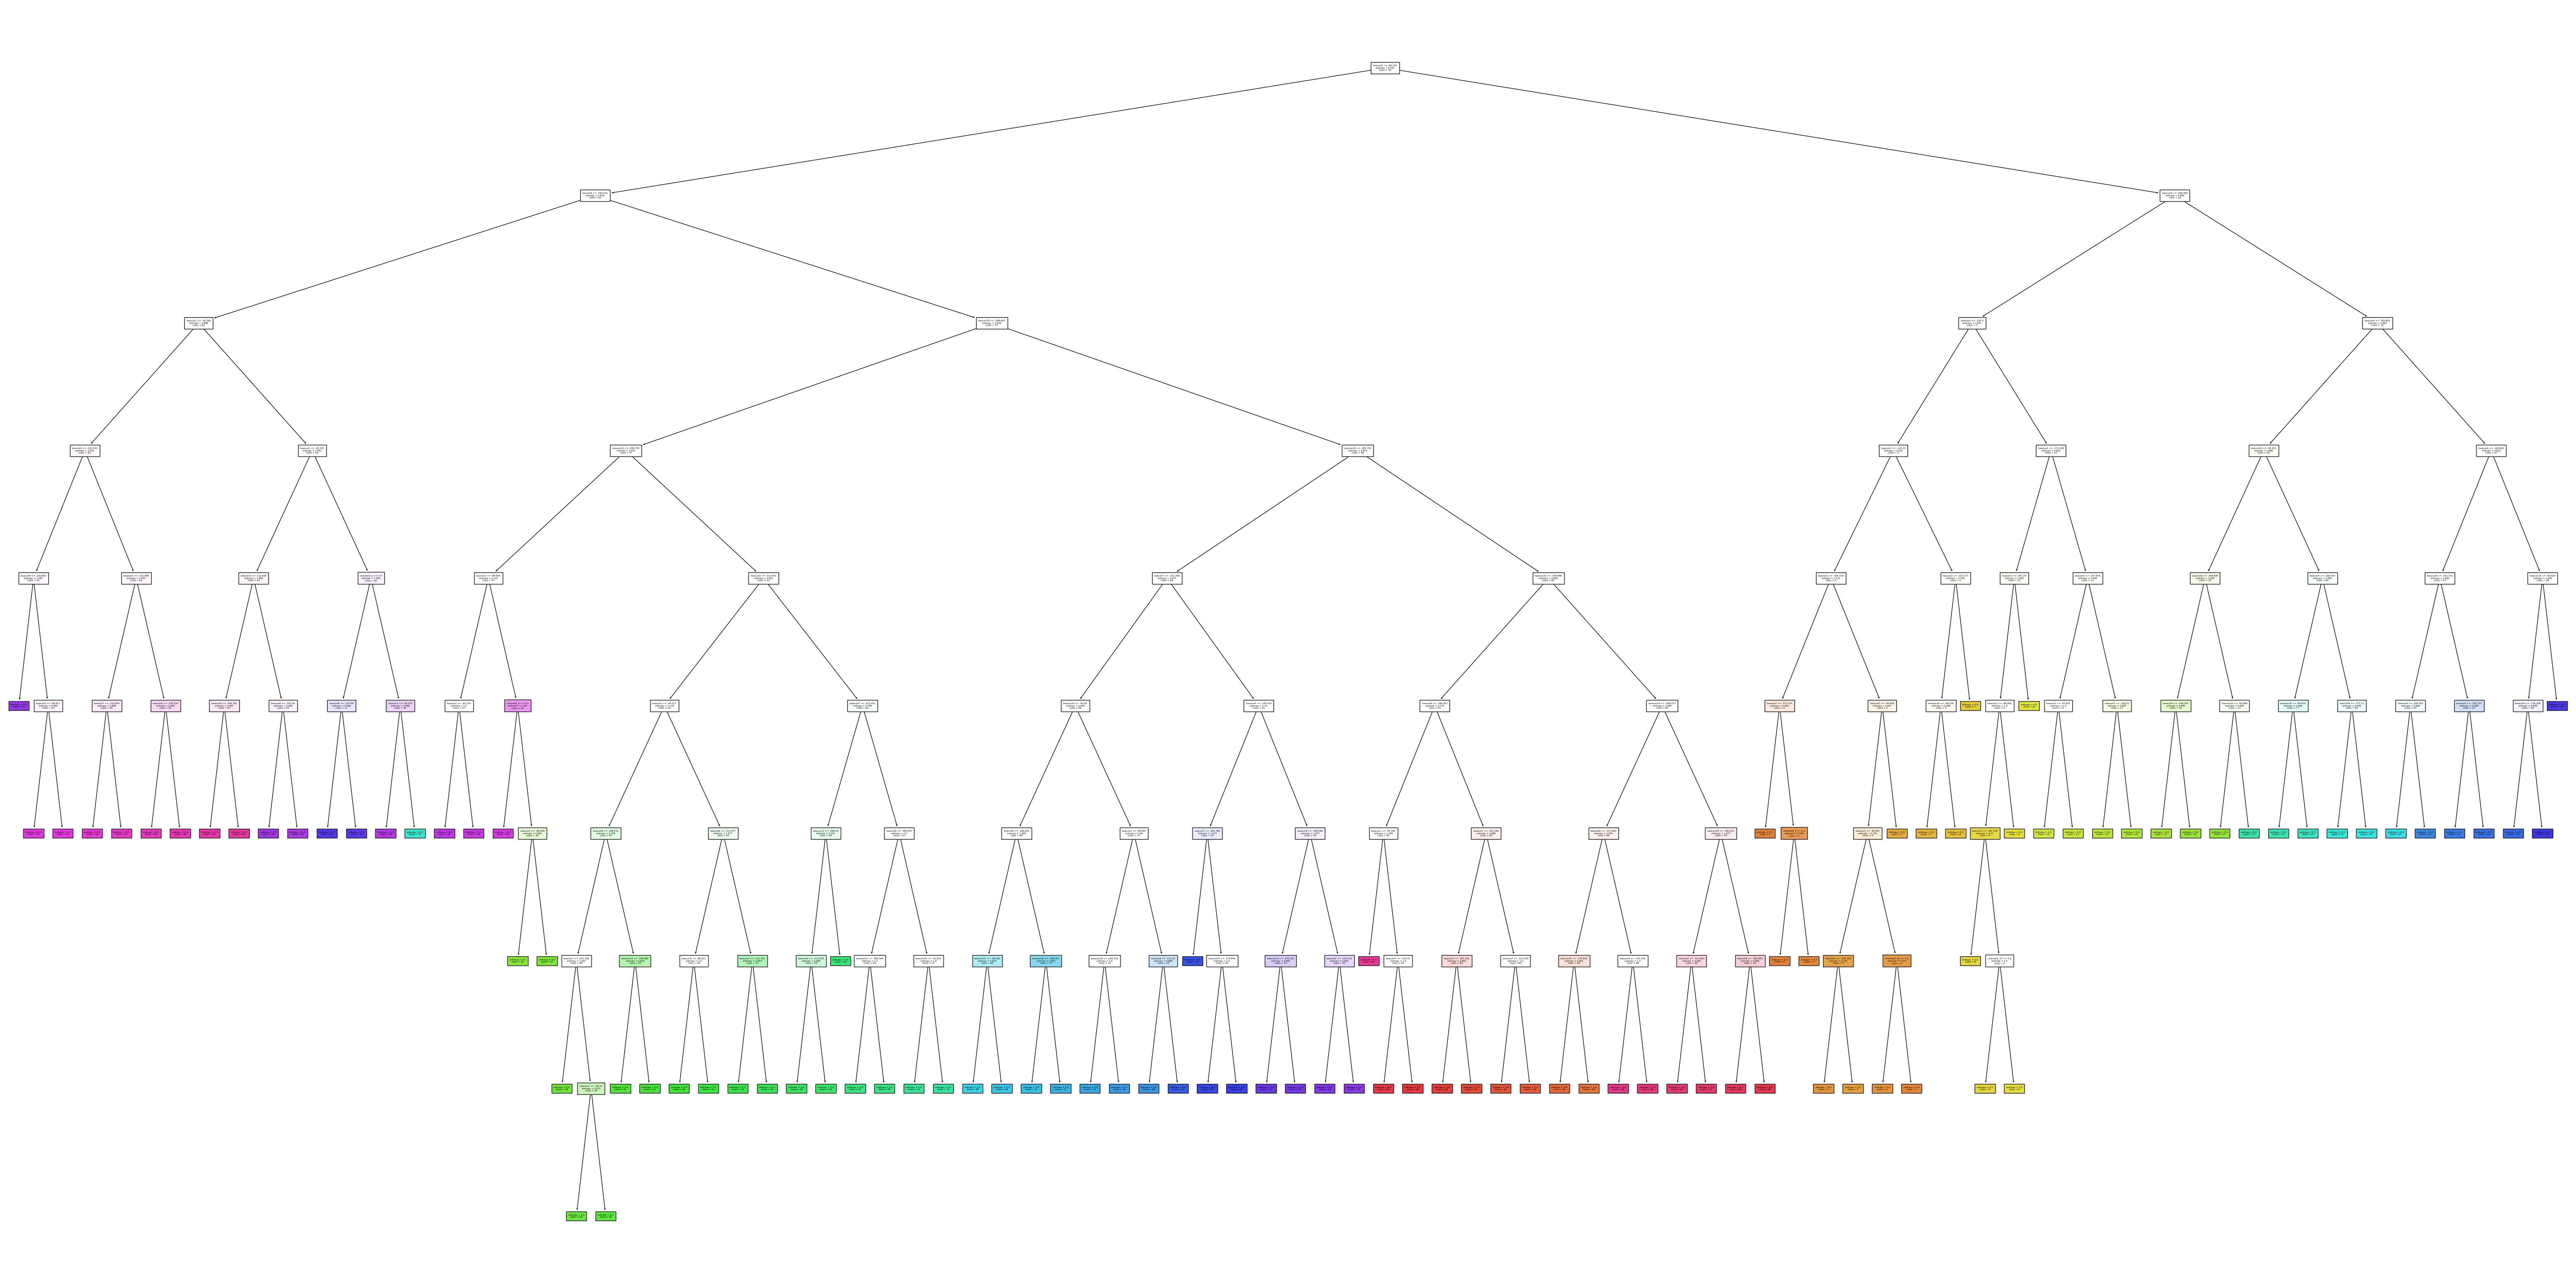

<Figure size 4000x2000 with 0 Axes>

In [320]:
fig, ax = plt.subplots(figsize=(80,40))
dfig = plt.figure()
tree.plot_tree(grid_dt.best_estimator_, 
                   feature_names=list(aX_test.columns),  
                   class_names= [str(i) for i in list(fingerprints_df.location.unique())],
                   filled=True, fontsize= 4, ax = ax)

def replace_text(obj):
    if type(obj) == mpl.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\nsamples[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj
    
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
fig.savefig('plot.png', dpi=300, bbox_inches='tight')
fig.show() 


In [321]:
fX_validation

beacon1     beacon2     beacon3  beacon4  beacon5  beacon6  beacon7  \
12    -94.000000  -84.130204 -222.314232   -300.0   -300.0   -300.0   -300.0   
23    -96.405330  -82.957107 -211.251786   -300.0   -300.0   -300.0   -300.0   
31    -98.905330  -84.000000 -300.000000   -300.0   -300.0   -300.0   -300.0   
44    -96.198223  -93.931981 -259.648232   -300.0   -300.0   -300.0   -300.0   
47    -97.344670  -84.266243 -200.000000   -300.0   -300.0   -300.0   -300.0   
...          ...         ...         ...      ...      ...      ...      ...   
1178 -300.000000 -300.000000 -300.000000   -300.0   -300.0   -300.0   -300.0   
1184 -300.000000 -300.000000 -300.000000   -300.0   -300.0   -300.0   -300.0   
1150 -300.000000 -300.000000 -300.000000   -300.0   -300.0   -300.0   -300.0   
1155 -300.000000 -300.000000 -300.000000   -300.0   -300.0   -300.0   -300.0   
1166 -300.000000 -300.000000 -300.000000   -300.0   -300.0   -300.0   -300.0   

      beacon8  beacon9    beacon10  ...  channel18_38  channel18_39  \
12     -300.0   -300.0  -90.998214  ...             0             0   
23     -300.0   -300.0  -97.508883  ...             0             0   
31     -300.0   -300.0 -162.200009  ...             0             0   
44     -300.0   -300.0  -86.946438  ...             0             0   
47     -300.0   -300.0 -199.655330  ...             0             0   
...       ...      ...         ...  ...           ...           ...   
1178   -300.0   -300.0 -300.000000  ...             0             1   
1184   -300.0   -300.0 -300.000000  ...             0             0   
1150   -300.0   -300.0 -300.000000  ...             0             0   
1155   -300.0   -300.0 -300.000000  ...             1             0   
1166   -300.0   -300.0 -300.000000  ...             0             0   

      channel19_0  channel19_37  channel19_38  channel19_39  channel20_0  \
12              1             0             0             0            1   
23              1             0             0             0            1   
31              1             0             0             0            1   
44              1             0             0             0            1   
47              1             0             0             0            1   
...           ...           ...           ...           ...          ...   
1178            0             0             1             0            1   
1184            0             1             0             0            1   
1150            0             1             0             0            1   
1155            0             0             1             0            1   
1166            0             0             1             0            1   

      channel20_37  channel20_38  channel20_39  
12               0             0             0  
23               0             0             0  
31               0             0             0  
44               0             0             0  
47               0             0             0  
...            ...           ...           ...  
1178             0             0             0  
1184             0             0             0  
1150             0             0             0  
1155             0             0             0  
1166             0             0             0  

[119 rows x 100 columns]

In [322]:
tr = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
tr.fit(fX_train, ftarget_train)
grid_dt_predictions_ff = tr.predict(fX_validation)

print(classification_report(ftarget_validation,grid_dt_predictions_ff))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         5
           5       0.40      1.00      0.57         2
           6       0.50      0.25      0.33         4
           7       0.00      0.00      0.00         3
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00         2
          10       0.25      0.50      0.33         2
          11       0.50      1.00      0.67         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         3
          14       0.50      0.67      0.57         3
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         0
          17       0.50    

In [323]:
tr1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
tr1.fit(kX_train, ktarget_train)
grid_dt_predictions_k = tr.predict(kX_validation)

print(classification_report(ktarget_validation,grid_dt_predictions_k))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         5
           5       0.33      1.00      0.50         2
           6       0.57      1.00      0.73         4
           7       0.50      0.33      0.40         3
           8       0.33      0.50      0.40         2
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.50      0.33      0.40         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         0
          17       0.33    

In [324]:
tr2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=15)
tr2.fit(X_train_nc, target_train)
grid_dt_predictions_nc = tr2.predict(X_validation_nc)

print(classification_report(target_validation,grid_dt_predictions_nc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2
           6       0.50      0.25      0.33         4
           7       1.00      0.67      0.80         3
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         2
          10       0.33      0.50      0.40         2
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.00      0.00      0.00         3
          14       1.00      0.33      0.50         3
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         0
          17       0.20    

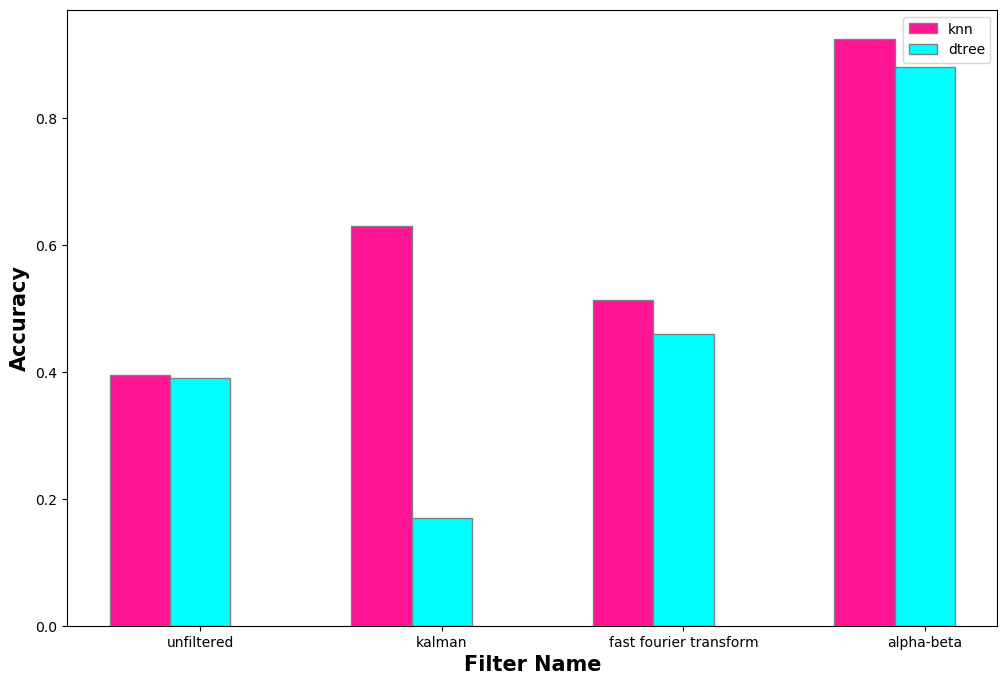

In [325]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
knn = [0.3949579831932773, 0.6302521008403361,  0.5126050420168067,0.9243697478991596]
dtr = [0.39, 0.17, 0.46, 0.88]
 
br1 = np.arange(len(knn))
br2 = [x + barWidth for x in br1]
 
plt.bar(br1, knn, color ='deeppink', width = barWidth,
        edgecolor ='grey', label ='knn')
plt.bar(br2, dtr, color ='#00FFFF', width = barWidth,
        edgecolor ='grey', label ='dtree')


plt.xlabel('Filter Name', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(knn))],
        ['unfiltered', 'kalman', 'fast fourier transform', 'alpha-beta'])
 
plt.legend()
plt.show()

## Random Forest

In [326]:
rfc = RandomForestClassifier()
forest_params = [{'criterion': ["gini", "entropy", "log_loss"], 'max_depth':[5,8,10,12,15], 'max_features': [10,15,20,25,30,35,40]}]
clf = GridSearchCV(rfc, forest_params, cv = 5, scoring='accuracy',refit=True,verbose=2)
print(clf.fit(aX_train, atarget_train))

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=20; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, m

[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.6s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.6s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.6s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.2s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gin

[CV] END ....criterion=entropy, max_depth=5, max_features=35; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=35; total time=   0.6s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.8s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.8s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entro

[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.3s
[CV] END ...criterion=entrop

[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_los

[CV] END ..criterion=log_loss, max_depth=15, max_features=30; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=35; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=35; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=35; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=35; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=35; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entro

In [327]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=20)

In [328]:
start_time = time.time()
grid_rforest_predictions = clf.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("Random Forest algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_rforest_predictions))

Random Forest algorithm prediction time: 0.0204
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         4
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         0
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          19       1.00      1.00

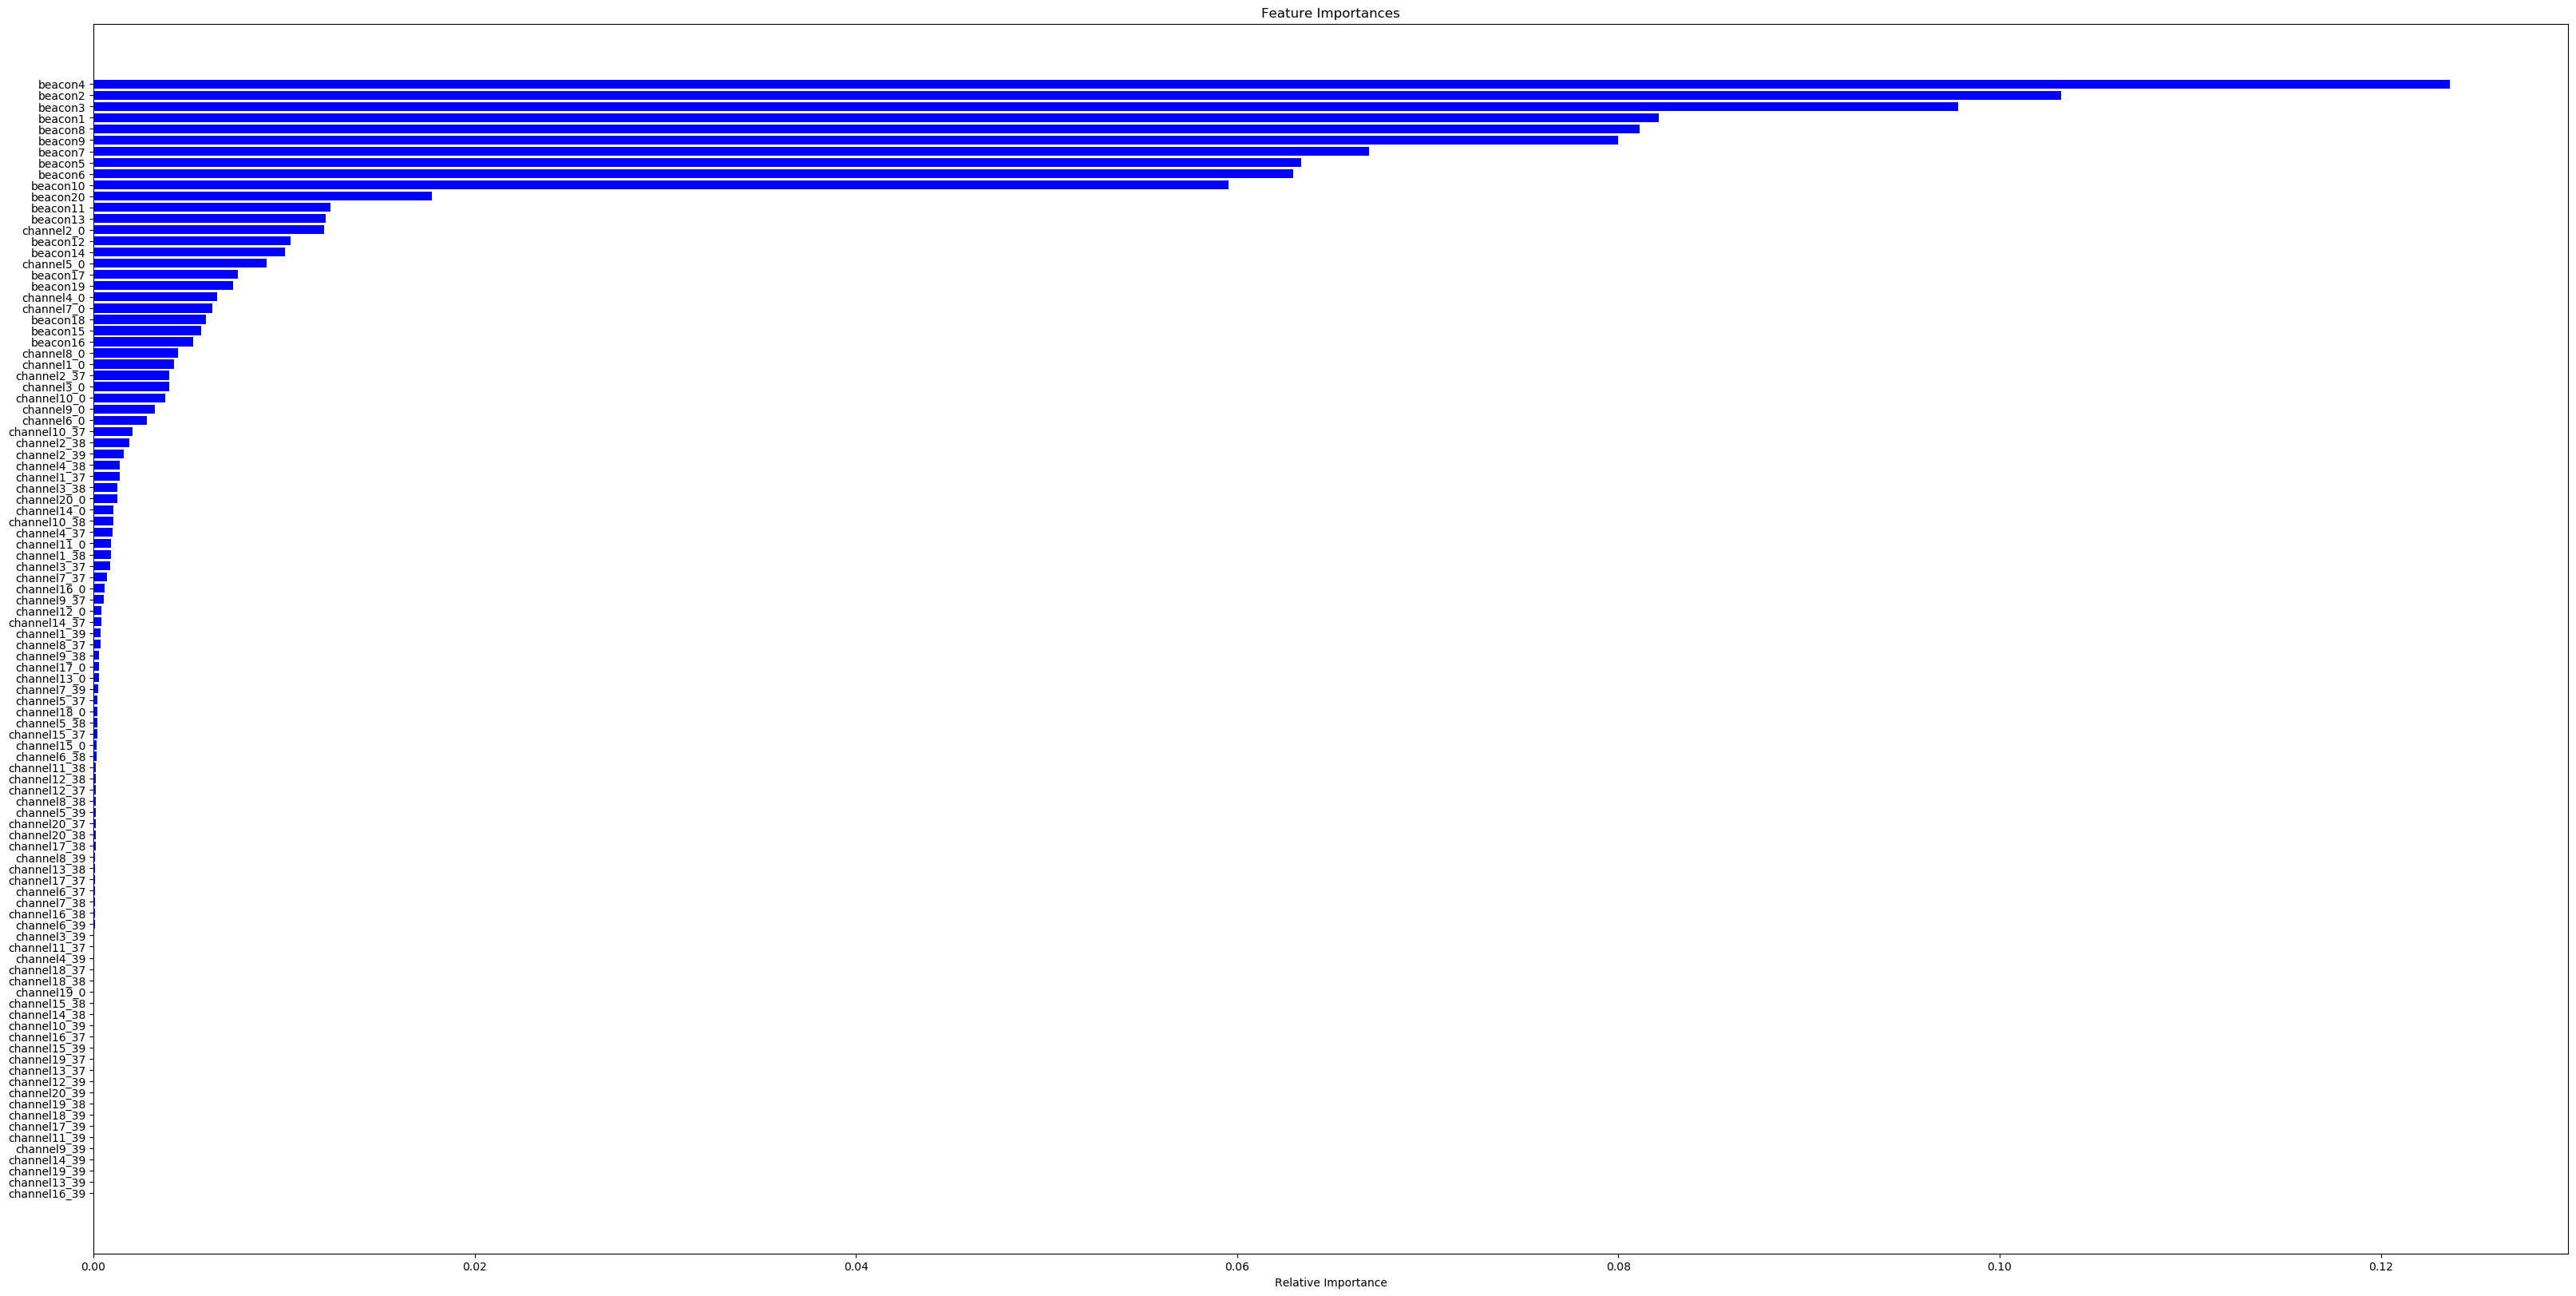

In [329]:
features = aX_train.columns
importances = clf.best_estimator_.feature_importances_
indices = np.argsort(importances) 
indices
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

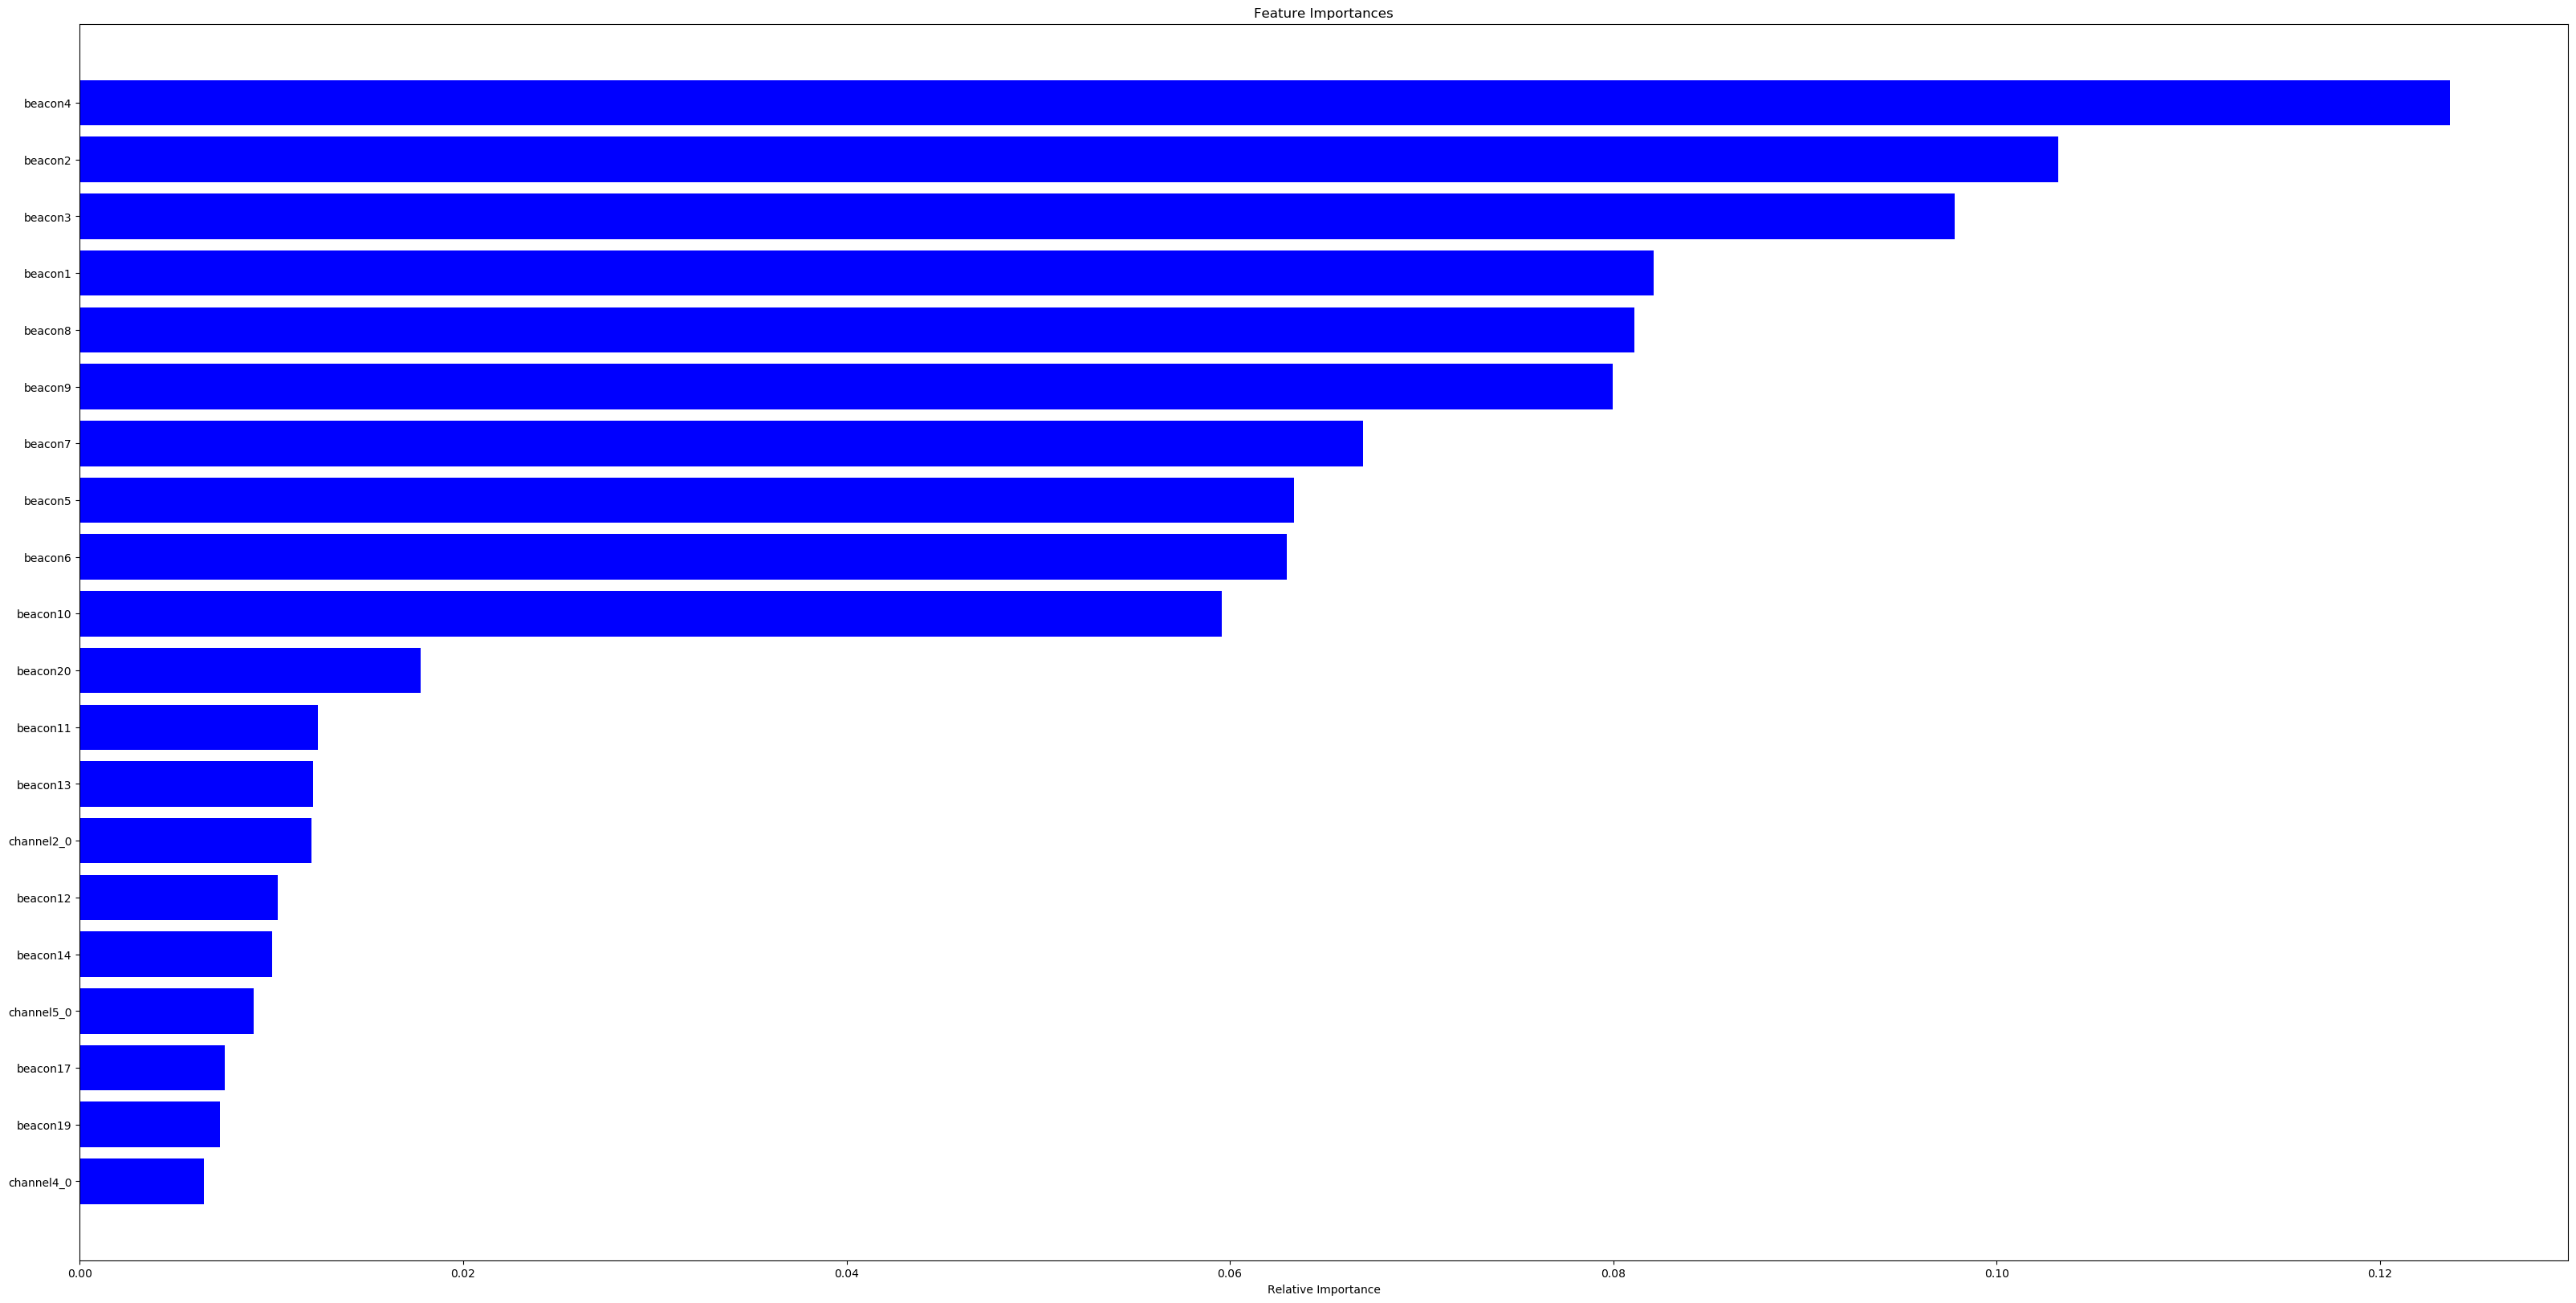

In [330]:
indices2 = indices[-20:]
plt.title('Feature Importances')
plt.barh(range(len(indices2)), importances[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), [features[i] for i in indices2])
plt.xlabel('Relative Importance')
plt.show()

In [331]:
indices = np.flip(indices, axis=None)

In [332]:
selected_col_count = 40
counter = 0
selected_columns = []
for ind in indices:
    if counter< selected_col_count:
        selected_columns.append(features[ind])
        counter+= 1
    else:
        break
selected_columns

['beacon4',
 'beacon2',
 'beacon3',
 'beacon1',
 'beacon8',
 'beacon9',
 'beacon7',
 'beacon5',
 'beacon6',
 'beacon10',
 'beacon20',
 'beacon11',
 'beacon13',
 'channel2_0',
 'beacon12',
 'beacon14',
 'channel5_0',
 'beacon17',
 'beacon19',
 'channel4_0',
 'channel7_0',
 'beacon18',
 'beacon15',
 'beacon16',
 'channel8_0',
 'channel1_0',
 'channel2_37',
 'channel3_0',
 'channel10_0',
 'channel9_0',
 'channel6_0',
 'channel10_37',
 'channel2_38',
 'channel2_39',
 'channel4_38',
 'channel1_37',
 'channel3_38',
 'channel20_0',
 'channel14_0',
 'channel10_38']

## Support Vector Machine 

In [333]:
min_max_scaler = MinMaxScaler()
scaled_aXtrain = aX_train.copy()
scaled_aXtrain[:] = min_max_scaler.fit_transform(scaled_aXtrain[:])
scaled_aXtrain

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
17    0.471856  0.703556  0.676671  0.000000  0.000000  0.000000  0.000000   
1     0.819877  0.328059  0.000000  0.000000  0.000000  0.000000  0.000000   
10    0.891011  0.764821  0.491994  0.000000  0.000000  0.000000  0.000000   
4     0.940068  0.664030  0.272919  0.000000  0.000000  0.000000  0.000000   
6     0.894281  0.720025  0.479864  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1160  0.950802  0.015442  0.999138  0.999138  0.999138  0.999138  0.999138   
1167  0.950838  0.015564  0.999143  0.999143  0.999143  0.999143  0.999143   
1164  0.950823  0.015512  0.999141  0.999141  0.999141  0.999141  0.999141   
1168  0.950844  0.015581  0.999144  0.999144  0.999144  0.999144  0.999144   
1165  0.950828  0.015529  0.999142  0.999142  0.999142  0.999142  0.999142   

       beacon8   beacon9  beacon10  ...  channel18_38  channel18_39  \
17    0.000000  0.000000  0.841694  ...           0.0           0.0   
1     0.000000  0.000000  0.900201  ...           0.0           0.0   
10    0.000000  0.000000  0.337487  ...           0.0           0.0   
4     0.000000  0.000000  0.893614  ...           0.0           0.0   
6     0.000000  0.000000  0.000000  ...           0.0           0.0   
...        ...       ...       ...  ...           ...           ...   
1160  0.999138  0.999138  0.988873  ...           0.0           0.0   
1167  0.999143  0.999143  0.988901  ...           0.0           1.0   
1164  0.999141  0.999141  0.988889  ...           1.0           0.0   
1168  0.999144  0.999144  0.988905  ...           1.0           0.0   
1165  0.999142  0.999142  0.988893  ...           0.0           0.0   

      channel19_0  channel19_37  channel19_38  channel19_39  channel20_0  \
17            1.0           0.0           0.0           0.0          1.0   
1             1.0           0.0           0.0           0.0          1.0   
10            1.0           0.0           0.0           0.0          1.0   
4             1.0           0.0           0.0           0.0          1.0   
6             1.0           0.0           0.0           0.0          1.0   
...           ...           ...           ...           ...          ...   
1160          0.0           1.0           0.0           0.0          1.0   
1167          0.0           1.0           0.0           0.0          1.0   
1164          0.0           0.0           1.0           0.0          1.0   
1168          0.0           1.0           0.0           0.0          1.0   
1165          0.0           1.0           0.0           0.0          1.0   

      channel20_37  channel20_38  channel20_39  
17             0.0           0.0           0.0  
1              0.0           0.0           0.0  
10             0.0           0.0           0.0  
4              0.0           0.0           0.0  
6              0.0           0.0           0.0  
...            ...           ...           ...  
1160           0.0           0.0           0.0  
1167           0.0           0.0           0.0  
1164           0.0           0.0           0.0  
1168           0.0           0.0           0.0  
1165           0.0           0.0           0.0  

[959 rows x 100 columns]

In [334]:
# aX_train_feature_selected =aX_train.loc[:, selected_columns]
grid_svm_parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['poly','rbf', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2)
print(grid.fit(scaled_aXtrain.loc[:, selected_columns], atarget_train))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
     

In [335]:
grid.best_estimator_

SVC(C=100, gamma=1, kernel='poly')

In [336]:
scaled_aXtest = aX_test.copy()
scaled_aXtest[:] = min_max_scaler.fit_transform(scaled_aXtest[:])
start_time = time.time()
svm_grid_predictions = grid.predict(scaled_aXtest.loc[:, selected_columns])
runtime = round(time.time() - start_time,4)
print("Support Vector Machine algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,svm_grid_predictions))

Support Vector Machine algorithm prediction time: 0.0159
              precision    recall  f1-score   support

           0       0.20      1.00      0.33         2
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.43      0.75      0.55         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         3
          15       1.00      0.33      0.50         3
          17       0.33 

In [337]:
fingerprints_df2 = fingerprints_df_from_file.iloc[: , 2:]
for col in channel_cols:
    fingerprints_df2[col] = fingerprints_df2[col].map(str)
alpha_filtered3 = apply_filter_to_whole(fingerprints_df2, "alpha_beta_gamma","alpha_3.csv")
ashuf2, atrain2, avalidation2, atest2, aX_train2, atarget_train2, aX_validation2, atarget_validation2, aX_test2, atarget_test2 = split_train_validation_test(alpha_filtered3, 0.8,0.1)
grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2)
print(grid.fit(aX_train2, atarget_train2))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
GridSearchCV(estimator=SVC()

In [338]:
grid.best_estimator_

SVC(C=0.1, gamma=0.001, kernel='poly')

In [339]:
start_time = time.time()
svm_grid_predictions2 = grid.predict(aX_test2)
runtime = round(time.time() - start_time,4)
print("Support Vector Machine algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test2,svm_grid_predictions2))

Support Vector Machine algorithm prediction time: 0.0114
              precision    recall  f1-score   support

          b1       1.00      1.00      1.00         2
          b2       1.00      1.00      1.00         3
          b3       0.80      1.00      0.89         4
          b4       0.00      0.00      0.00         2
          b5       0.67      1.00      0.80         2
          b6       1.00      1.00      1.00         1
          b8       1.00      1.00      1.00         1
          b9       1.00      1.00      1.00         1
         be1       1.00      1.00      1.00         1
         be2       0.00      0.00      0.00         0
         be3       0.75      0.75      0.75         4
         be4       1.00      0.75      0.86         4
         be5       1.00      1.00      1.00         1
         be6       0.75      1.00      0.86         3
         be7       1.00      0.33      0.50         3
         be8       0.00      0.00      0.00         0
         be9       1.00 

## Artificial Neural Network

In [340]:
ann_model = keras.Sequential()
ann_model.add(keras.layers.InputLayer(input_shape = (100,)))
ann_model.add(keras.layers.Dense(120, activation ='elu'))
ann_model.add(keras.layers.Dropout(0.3))
ann_model.add(keras.layers.Dense(100, activation ='elu'))
ann_model.add(keras.layers.Dropout(0.3))
ann_model.add(keras.layers.Dense(96))
ann_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_326 (Dense)            (None, 120)               12120     
_________________________________________________________________
dropout_33 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_327 (Dense)            (None, 100)               12100     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_328 (Dense)            (None, 96)                9696      
Total params: 33,916
Trainable params: 33,916
Non-trainable params: 0
_________________________________________________________________


In [341]:
ann_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

In [342]:
one_hot_channel_cols = [col for col in fingerprints_df.columns if col not in no_channel_training_cols+['location']]
scaled_aXtrain_np = scaled_aXtrain.copy()
#scaled_aXtrain_np.loc[:, one_hot_channel_cols] = scaled_aXtrain_np.loc[:, one_hot_channel_cols].replace(0.0, -1)
#scaled_aXtrain_np = scaled_aXtrain_np.loc[:, selected_columns]
scaled_aXtrain_np = scaled_aXtrain_np.to_numpy()
scaled_aXtest_np = scaled_aXtest.copy()
#scaled_aXtest_np.loc[:, one_hot_channel_cols] = scaled_aXtest_np.loc[:, one_hot_channel_cols].replace(0, -1)
#scaled_aXtest_np = scaled_aXtest_np.loc[:, selected_columns]
scaled_aXtest_np = scaled_aXtest_np.to_numpy()
encoded_train_labels = atarget_train.to_numpy()
encoded_test_labels = atarget_test.to_numpy()

In [343]:
history = ann_model.fit(scaled_aXtrain_np, encoded_train_labels , epochs=100)

Epoch 1/100
959/959 [==============================] - 1s 1ms/step - loss: 4.4501 - accuracy: 0.0302
Epoch 2/100
959/959 [==============================] - 0s 193us/step - loss: 3.9944 - accuracy: 0.0521
Epoch 3/100
959/959 [==============================] - 0s 195us/step - loss: 3.5564 - accuracy: 0.0886
Epoch 4/100
959/959 [==============================] - 0s 196us/step - loss: 3.2369 - accuracy: 0.1283
Epoch 5/100
959/959 [==============================] - 0s 192us/step - loss: 3.0382 - accuracy: 0.1689
Epoch 6/100
959/959 [==============================] - 0s 190us/step - loss: 2.9241 - accuracy: 0.1689
Epoch 7/100
959/959 [==============================] - 0s 190us/step - loss: 2.7360 - accuracy: 0.2096
Epoch 8/100
959/959 [==============================] - 0s 200us/step - loss: 2.6176 - accuracy: 0.2419
Epoch 9/100
959/959 [==============================] - 0s 200us/step - loss: 2.5019 - accuracy: 0.2555
Epoch 10/100
959/959 [==============================] - 0s 199us/step - los

959/959 [==============================] - 0s 201us/step - loss: 0.9797 - accuracy: 0.6486
Epoch 80/100
959/959 [==============================] - 0s 204us/step - loss: 0.9516 - accuracy: 0.6465
Epoch 81/100
959/959 [==============================] - 0s 203us/step - loss: 0.9395 - accuracy: 0.6538
Epoch 82/100
959/959 [==============================] - 0s 202us/step - loss: 0.9531 - accuracy: 0.6601
Epoch 83/100
959/959 [==============================] - 0s 202us/step - loss: 0.9748 - accuracy: 0.6486
Epoch 84/100
959/959 [==============================] - 0s 206us/step - loss: 0.9294 - accuracy: 0.6830
Epoch 85/100
959/959 [==============================] - 0s 208us/step - loss: 0.9156 - accuracy: 0.6799
Epoch 86/100
959/959 [==============================] - 0s 211us/step - loss: 0.9234 - accuracy: 0.6632
Epoch 87/100
959/959 [==============================] - 0s 216us/step - loss: 0.9315 - accuracy: 0.6736
Epoch 88/100
959/959 [==============================] - 0s 219us/step - loss:

In [344]:
start_time = time.time()
test_loss, test_acc = ann_model.evaluate(scaled_aXtest_np,  encoded_test_labels, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

Neural Network algorithm prediction time: 0.3346


0.42148759961128235

In [345]:
def plot_loss_acc_rate(history):    
#     plt.plot(history.history['val_loss'])
#     plt.title('Model \'s loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.show()
#     plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('Model \'s accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

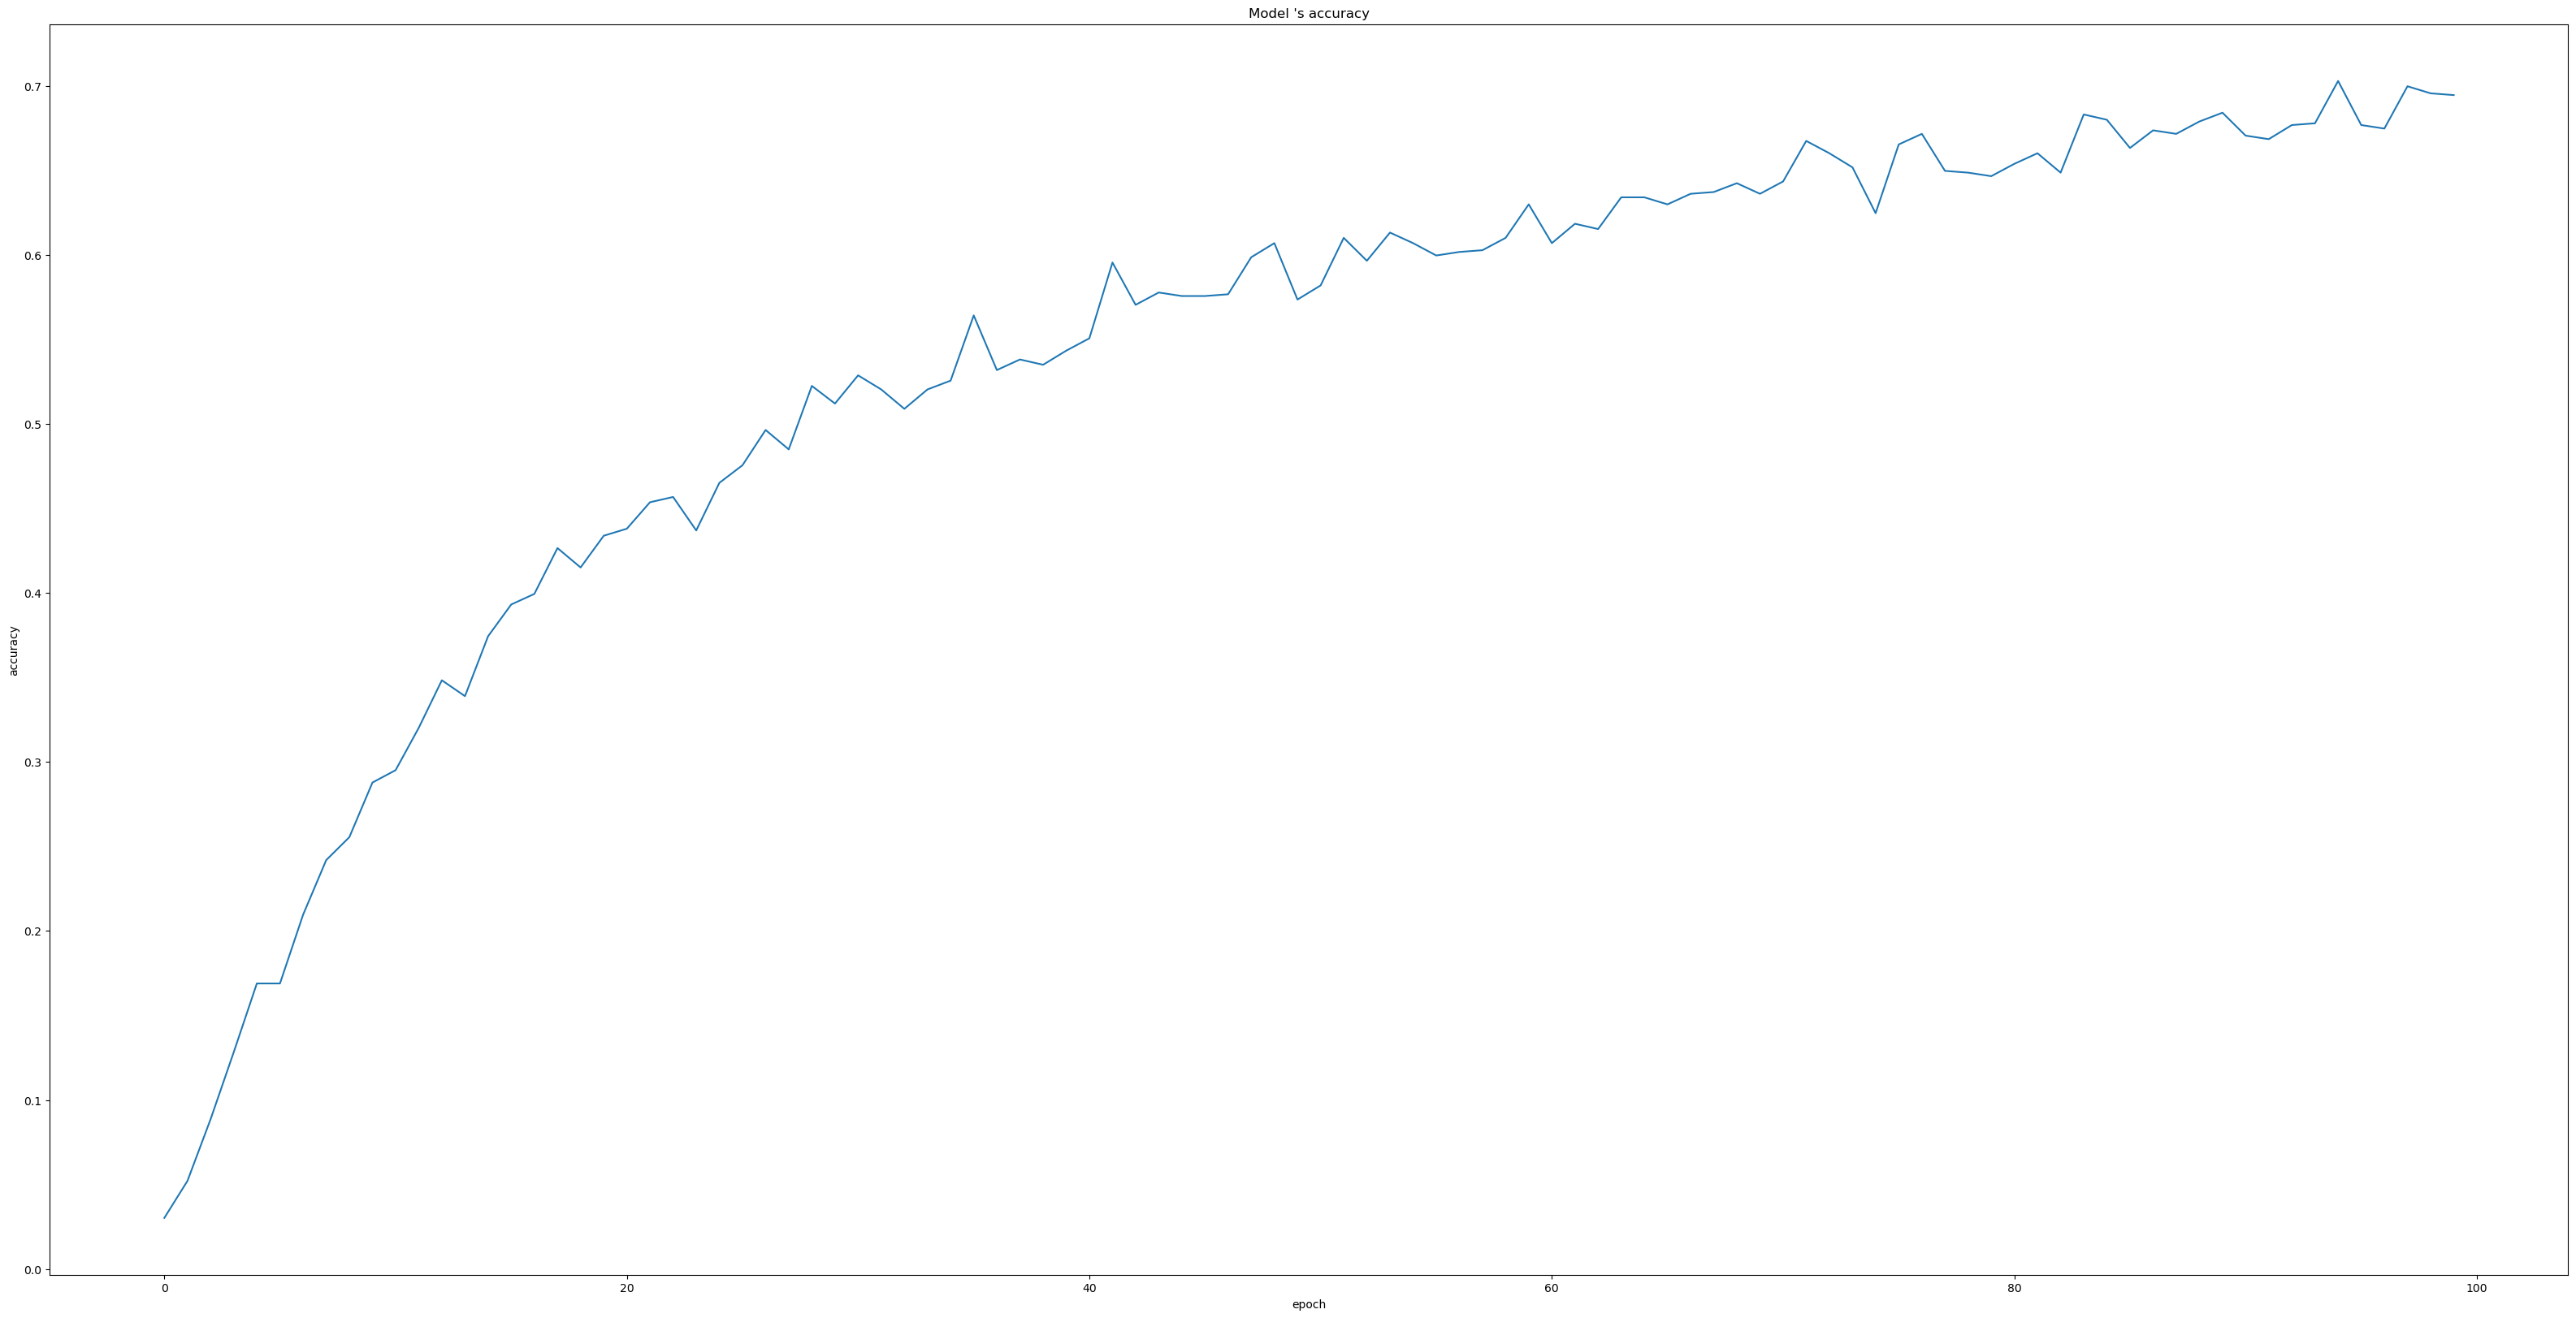

In [346]:
plot_loss_acc_rate(history)

### Unfiltered Data

In [347]:
scaled_Xtrain = X_train.copy()
scaled_Xtrain[:] = min_max_scaler.fit_transform(scaled_Xtrain[:])
scaled_Xtest = X_test.copy()
scaled_Xtest[:] = min_max_scaler.fit_transform(scaled_Xtest[:])
scaled_Xtrain_np = scaled_Xtrain.to_numpy()
scaled_Xtest_np = scaled_Xtest.to_numpy()
train_labels = target_train.to_numpy()
test_labels = target_test.to_numpy()

In [348]:
ann_model2 = keras.Sequential()
ann_model2.add(keras.layers.InputLayer(input_shape = (100,)))
ann_model2.add(keras.layers.Dense(120, activation ='elu'))
ann_model2.add(keras.layers.Dropout(0.3))
ann_model2.add(keras.layers.Dense(100, activation ='elu'))
ann_model2.add(keras.layers.Dropout(0.3))
ann_model2.add(keras.layers.Dense(96))
ann_model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_329 (Dense)            (None, 120)               12120     
_________________________________________________________________
dropout_35 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_330 (Dense)            (None, 100)               12100     
_________________________________________________________________
dropout_36 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_331 (Dense)            (None, 96)                9696      
Total params: 33,916
Trainable params: 33,916
Non-trainable params: 0
_________________________________________________________________


In [349]:
ann_model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
history2 = ann_model.fit(scaled_Xtrain_np, train_labels , epochs=15)

Epoch 1/15
959/959 [==============================] - 0s 259us/step - loss: 5.5206 - accuracy: 0.2242
Epoch 2/15
959/959 [==============================] - 0s 261us/step - loss: 2.2410 - accuracy: 0.3379
Epoch 3/15
959/959 [==============================] - 0s 257us/step - loss: 1.9036 - accuracy: 0.4088
Epoch 4/15
959/959 [==============================] - 0s 254us/step - loss: 1.8537 - accuracy: 0.3931
Epoch 5/15
959/959 [==============================] - 0s 255us/step - loss: 1.7376 - accuracy: 0.4400
Epoch 6/15
959/959 [==============================] - 0s 259us/step - loss: 1.7197 - accuracy: 0.4108
Epoch 7/15
959/959 [==============================] - 0s 257us/step - loss: 1.7058 - accuracy: 0.4296
Epoch 8/15
959/959 [==============================] - 0s 257us/step - loss: 1.6605 - accuracy: 0.4484
Epoch 9/15
959/959 [==============================] - 0s 251us/step - loss: 1.6755 - accuracy: 0.4390
Epoch 10/15
959/959 [==============================] - 0s 260us/step - loss: 1.631

In [350]:
start_time = time.time()
test_loss, test_acc = ann_model2.evaluate(scaled_Xtest_np, test_labels, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

Neural Network algorithm prediction time: 0.3092


0.0

## XGBoost Algorithm

In [351]:
xgb_param = {
    'learning_rate': [0.02, 0.05, 0.1, 0.3],
    'max_depth': [6, 8, 10],
    'n_estimators': [50, 80, 100],
    'colsample_bytree' : [0.4, 0.6,0.8]
}
model_xgb_hyper = GridSearchCV(estimator= xgb.XGBClassifier(eval_metric = 'auc', subsample = 0.5),
                              param_grid = xgb_param, cv = 3,
                              return_train_score= True, verbose = 4)
model_xgb_hyper.fit(aX_train,  atarget_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.782, test=0.738) total time=   1.6s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.776, test=0.684) total time=   2.0s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.744, test=0.633) total time=   1.9s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.837, test=0.784) total time=   3.6s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.829, test=0.759) total time=   3.6s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.831, test=0.740) total time=   4.3s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=100;, score=(train=0.861, test=0.7

[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.980, test=0.887) total time=   6.2s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.975, test=0.903) total time=   4.4s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.970, test=0.850) total time=   6.4s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.926, test=0.838) total time=   3.5s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.934, test=0.838) total time=   2.1s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.934, test=0.818) total time=   1.9s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80;, score=(train=0.975, test=0.884) total time=   2.8s
[CV 2/3] END colsample_bytree=0.4, learning_r

[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.845, test=0.762) total time=   2.2s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.831, test=0.769) total time=   2.2s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.836, test=0.724) total time=   2.2s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.862, test=0.775) total time=   2.8s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.858, test=0.794) total time=   2.7s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.856, test=0.752) total time=   2.7s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=10, n_estimators=50;, score=(train=0.767, test=0.716) total time=   1.3s
[CV 2/3] END colsample_bytree=0.6, le

[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.931, test=0.828) total time=   1.4s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.928, test=0.847) total time=   1.4s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.930, test=0.812) total time=   2.1s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.977, test=0.866) total time=   2.4s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.959, test=0.878) total time=   2.2s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.956, test=0.809) total time=   2.9s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=100;, score=(train=0.981, test=0.875) total time=   3.2s
[CV 2/3] END colsample_bytree=0.6, learn

[CV 1/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.865, test=0.778) total time=   4.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.861, test=0.781) total time=   4.7s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.864, test=0.749) total time=   4.0s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.870, test=0.784) total time=   1.8s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.872, test=0.816) total time=   1.8s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.869, test=0.743) total time=   2.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=80;, score=(train=0.917, test=0.791) total time=   3.8s
[CV 2/3] END colsample_bytree=0.8, 

[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.994, test=0.869) total time=   2.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.987, test=0.897) total time=   2.4s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.992, test=0.809) total time=   3.3s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.995, test=0.872) total time=   7.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.994, test=0.909) total time=   6.9s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.995, test=0.821) total time=   5.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=50;, score=(train=0.987, test=0.875) total time=   3.5s
[CV 2/3] END colsample_bytree=0.8, learning_r

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                             

In [352]:
model_xgb_hyper.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [353]:
start_time = time.time()
grid_xgb_predictions = model_xgb_hyper.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("XGBoost algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_xgb_predictions))

XGBoost algorithm prediction time: 0.0129
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         4
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          21       0.67      1.00      

## Data Generation

### Variational Autoencoder Definition

In [354]:
def sample(means_log_var):
    means, log_var = means_log_var
    epsilon = K.random_normal(shape=(K.shape(means)[0], latent_dim), mean=0, stddev=0.1)
    return means + K.exp(log_var) * epsilon

In [355]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(18, activation ='relu')(input_layer)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
print(encoder.summary())

Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
dense_332 (Dense)               (None, 18)           378         input_81[0][0]                   
__________________________________________________________________________________________________
dense_333 (Dense)               (None, 15)           285         dense_332[0][0]                  
__________________________________________________________________________________________________
dense_334 (Dense)               (None, 10)           160         dense_333[0][0]                  
___________________________________________________________________________________________

In [356]:
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(18, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)

decoder = keras.models.Model(decoder_input, outputs)
print(decoder.summary())
x_prime = decoder(z)

Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        (None, 8)                 0         
_________________________________________________________________
dense_337 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_338 (Dense)            (None, 15)                165       
_________________________________________________________________
dense_339 (Dense)            (None, 18)                288       
_________________________________________________________________
dense_340 (Dense)            (None, 20)                380       
Total params: 923
Trainable params: 923
Non-trainable params: 0
_________________________________________________________________
None


In [357]:
def my_loss(x, x_prime):
#     x = K.flatten(x)
#     x_prime = K.flatten(x_prime)
    reconstruct_loss = 20*keras.metrics.binary_crossentropy(x, x_prime)
    kl_loss = -0.5* K.sum(1 + log_var - K.square(means) - K.exp(log_var), axis = -1)
    return K.mean(reconstruct_loss + kl_loss)


In [358]:
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam")
print(vae.summary())  

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        (None, 20)                0         
_________________________________________________________________
model_63 (Model)             [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_64 (Model)             (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None


In [359]:
def create_vae():
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])
    
    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)

    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam")
    print(vae.summary())
    return vae, encoder

### Data preparation

In [360]:
def data_split_for_syn(dataframe, train_size):
  
    shuffled_df = dataframe.sample(frac=1, random_state = 37)
    train_num = int(train_size * len(dataframe))
    
    train_set_with_label = shuffled_df[:train_num]
    test_set_with_label = shuffled_df[train_num:]
    
    train_set_with_label = train_set_with_label.sort_values('location')
    test_set_with_label = test_set_with_label.sort_values('location')
    
    train_set_with_label.reset_index(inplace=True, drop=True)
    test_set_with_label.reset_index(inplace=True, drop=True)
    
#     train_set_with_label.loc[:, no_channel_training_cols] =  min_max_scaler.fit_transform(train_set_with_label.loc[:, no_channel_training_cols])
#     test_set_with_label.loc[:, no_channel_training_cols] =  min_max_scaler.fit_transform(test_set_with_label.loc[:, no_channel_training_cols])
    return train_set_with_label, test_set_with_label

In [361]:
def prep_data_for_synthesis(dataframe, percentage):
    if percentage <= 0.5:
        frac = int(1/percentage)
    else:
        frac = int(1/(1-percentage))
#     dataframe = dataframe.sample(frac=1, random_state = 37)
#     dataframe.reset_index(inplace=True, drop=True)
    part_df = dataframe.loc[:, no_channel_training_cols + ['location']].iloc[::frac]
    indices = part_df.index
    test_df = dataframe.drop(indices, axis=0).loc[:, no_channel_training_cols + ['location']]

    
    part_locations = part_df.loc[:, ['location']]
#     part_df[:] = min_max_scaler.fit_transform(part_df[:])
    part_df = part_df.loc[:, no_channel_training_cols]
    
    test_locations = test_df.loc[:, ['location']]
#     test_df[:] = min_max_scaler.fit_transform(test_df[:])
    test_df = test_df.loc[:, no_channel_training_cols]
    
    if percentage <= 0.5:
        return part_df, part_locations, test_df, test_locations
    
    return   test_df, test_locations, part_df, part_locations
    



In [362]:
alpha_filtered2_train, alpha_filtered2_test = data_split_for_syn(alpha_filtered2.loc[:, no_channel_training_cols + ['location']],0.8)
half_df, half_locations, half_df_test, half_test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.5)
fourth_df, fourth_locations, fourth_df_test, fourth_test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.25)

In [363]:
half_df

beacon1    beacon2     beacon3     beacon4     beacon5     beacon6  \
0   -107.134454 -83.647059 -172.931671 -300.000000 -300.000000 -300.000000   
2    -94.928571 -83.100000 -207.611111 -300.000000 -300.000000 -300.000000   
4    -94.833333 -83.500000 -209.888889 -300.000000 -300.000000 -300.000000   
6    -95.080357 -83.625000 -185.205376 -300.000000 -300.000000 -300.000000   
8   -120.875000 -83.375000 -221.152778 -300.000000 -300.000000 -300.000000   
..          ...        ...         ...         ...         ...         ...   
950  -93.186987 -89.791008 -112.376929 -145.406447 -200.161481 -211.664762   
952  -93.187601 -89.791632 -112.377486 -145.406907 -200.161777 -211.665025   
954  -93.187447 -89.791476 -112.377347 -145.406791 -200.161703 -211.664959   
956  -93.186834 -89.790852 -112.376790 -145.406333 -200.161407 -211.664697   
958  -93.186681 -89.790697 -112.376652 -145.406219 -200.161333 -211.664632   

        beacon7     beacon8     beacon9    beacon10    beacon11    beacon12  \
0   -300.000000 -300.000000 -300.000000  -99.220588 -300.000000 -300.000000   
2   -300.000000 -300.000000 -300.000000 -118.357500 -300.000000 -300.000000   
4   -300.000000 -300.000000 -300.000000 -131.166667 -300.000000 -300.000000   
6   -300.000000 -300.000000 -300.000000  -99.234375 -300.000000 -300.000000   
8   -300.000000 -300.000000 -300.000000  -98.175000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
950 -201.389845 -185.995421 -188.564798  -93.634039 -275.911576 -274.502853   
952 -201.390138 -185.995760 -188.565129  -93.634652 -275.911648 -274.502928   
954 -201.390065 -185.995675 -188.565046  -93.634498 -275.911630 -274.502909   
956 -201.389772 -185.995337 -188.564715  -93.633886 -275.911558 -274.502834   
958 -201.389699 -185.995253 -188.564633  -93.633734 -275.911541 -274.502815   

       beacon13    beacon14    beacon15    beacon16    beacon17    beacon18  \
0   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
2   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
4   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
6   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
8   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
950 -272.353795 -269.961655 -286.048080 -284.236170 -287.030935 -284.942635   
952 -272.353877 -270.551686 -286.706572 -284.935001 -287.714390 -285.615431   
954 -272.353856 -270.404659 -286.539584 -284.758332 -287.544808 -285.448521   
956 -272.353774 -269.811344 -285.877935 -284.065005 -286.865960 -284.766568   
958 -272.353754 -269.665583 -285.710658 -283.894134 -286.704702 -284.595952   

       beacon19    beacon20  
0   -300.000000 -300.000000  
2   -300.000000 -300.000000  
4   -300.000000 -300.000000  
6   -300.000000 -300.000000  
8   -300.000000 -300.000000  
..          ...         ...  
950 -279.243340 -270.843007  
952 -279.867993 -270.843094  
954 -279.712935 -270.843072  
956 -279.078182 -270.842986  
958 -278.921034 -270.842964  

[480 rows x 20 columns]

### Original Data Results

In [364]:
rfc_semi = RandomForestClassifier()
forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[5,8,10,12,15], 'max_features': [8,10,15,20]}]
grid_clf = GridSearchCV(rfc_semi, forest_semi_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(grid_clf.fit(alpha_filtered2_train.loc[:, no_channel_training_cols], alpha_filtered2_train.loc[:, ['location']]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   1.0s
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.9s
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   1.3s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   1.2s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   1.2s
[CV] END ....criterion=entropy, max_depth=5, max_features=20; total time=   1.5s
[CV] END ....criterion=entropy, max_depth=5, max_features=20; total time=   1.5s
[CV] END ....criterion=entropy, max_depth=5, max

In [365]:
grid_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=8)

In [366]:
orig_predictions = grid_clf.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
accuracy_score(alpha_filtered2_test.loc[:, ['location']], orig_predictions)*100

90.83333333333333

In [367]:
room_level_mappings = {0:[0,1,2,3,4,5,6,7,8], 1:[9,10,11,12,13,14,15,16,17], 2:[36,37,38,39,40,41,42], 3:[50,51,52,53],
                      4:[58,59,60,61], 5:[66,67,68,69,70,71,72,73,74,75,76,77,78,79,80], 6:[18,19,20,21,22,23,24,25,26]
                      , 7:[27,28,29,30,31,32,33,34,35],8:[43,44,45,46,47,48,49], 9:[54,55,56,57], 10:[62,63,64,65], 
                      11:[81,82,83,84,85,86,87,88,89,90,91,92,93,94,95]}

In [368]:
percs = [0.01,0.03, 0.05, 0.1, 0.2, 0.3,0.4, 0.5,0.6, 0.7,0.8, 0.9]
original_accs = {}
r_accs = {}
for per in percs:
    part_df, part_locations, part_df_test, part_test_loc = prep_data_for_synthesis(alpha_filtered2_train, per)
    rfc_semi = RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
    print(rfc_semi.fit(part_df, part_locations))
    perc_predictions = rfc_semi.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
    original_accs[per] = accuracy_score(alpha_filtered2_test.loc[:, ['location']], perc_predictions)*100
    
    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
        
    room_lev_test_semi = []
    for i in perc_predictions:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
    r_accs[per] = accuracy_score(room_lev_atarget, room_lev_test_semi)*100

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)


In [369]:
original_accs

{0.01: 14.166666666666666,
 0.03: 39.166666666666664,
 0.05: 54.58333333333333,
 0.1: 65.83333333333333,
 0.2: 79.58333333333333,
 0.3: 90.0,
 0.4: 90.41666666666667,
 0.5: 90.41666666666667,
 0.6: 91.25,
 0.7: 90.0,
 0.8: 91.25,
 0.9: 91.66666666666666}

In [370]:
original_accs2 = {}
r_accs2 = {}
for per in percs:
    part_df, part_locations, part_df_test, part_test_loc = prep_data_for_synthesis(alpha_filtered2_train, per)
    perc_predictions,runtime = run_knn(part_df, part_locations, alpha_filtered2_test.loc[:, no_channel_training_cols],[],5)
    original_accs2[per] = accuracy_score(alpha_filtered2_test.loc[:, ['location']], perc_predictions)*100
    
    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
        
    room_lev_test_semi = []
    for i in perc_predictions:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
    r_accs2[per] = accuracy_score(room_lev_atarget, room_lev_test_semi)*100

In [371]:
original_accs2

{0.01: 2.083333333333333,
 0.03: 2.083333333333333,
 0.05: 5.0,
 0.1: 28.333333333333332,
 0.2: 60.416666666666664,
 0.3: 72.08333333333333,
 0.4: 81.66666666666667,
 0.5: 81.66666666666667,
 0.6: 78.75,
 0.7: 83.33333333333334,
 0.8: 87.08333333333333,
 0.9: 90.41666666666667}

### Model Training

In [372]:
def k_nearest_neigh(X_train, target_train, X_test, target_test):  
    accuracies = []
    for k in range(1, 9):
        knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
        knn.fit(X_train, target_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(target_test, y_pred)*100)
    big_k = accuracies.index(max(accuracies))
    
    knn = KNeighborsClassifier(n_neighbors = big_k, metric='manhattan')
    knn.fit(X_train, target_train)
    y_pred = knn.predict(X_test)
    return y_pred

In [373]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(15, activation ='relu')(input_layer)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
    
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
decoder = keras.models.Model(decoder_input, outputs)
x_prime = decoder(z)
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
print(vae.summary())

his = vae.fit(min_max_scaler.fit_transform(alpha_filtered2_train.loc[:, no_channel_training_cols]), min_max_scaler.fit_transform(alpha_filtered2_train.loc[:, no_channel_training_cols]) , epochs = 200, batch_size = 16, validation_split= 0.2)

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        (None, 20)                0         
_________________________________________________________________
model_65 (Model)             [(None, 8), (None, 8), (N 651       
_________________________________________________________________
model_66 (Model)             (None, 20)                575       
Total params: 1,226
Trainable params: 1,226
Non-trainable params: 0
_________________________________________________________________
None
Train on 767 samples, validate on 192 samples
Epoch 1/200
767/767 [==============================] - 3s 3ms/step - loss: 13.9890 - accuracy: 0.1877 - val_loss: 13.7840 - val_accuracy: 0.3021
Epoch 2/200
767/767 [==============================] - 0s 322us/step - loss: 11.6145 - accuracy: 0.3116 - val_loss: 12.3436 - val_accuracy: 0.5990
Epoch 3/200
767/767 [===========================

Epoch 52/200
767/767 [==============================] - 0s 339us/step - loss: 3.2432 - accuracy: 0.5567 - val_loss: 5.5512 - val_accuracy: 0.6354
Epoch 53/200
767/767 [==============================] - 0s 333us/step - loss: 3.2557 - accuracy: 0.5945 - val_loss: 5.5863 - val_accuracy: 0.6667
Epoch 54/200
767/767 [==============================] - 0s 329us/step - loss: 3.2330 - accuracy: 0.5880 - val_loss: 5.5541 - val_accuracy: 0.6354
Epoch 55/200
767/767 [==============================] - 0s 345us/step - loss: 3.2474 - accuracy: 0.5997 - val_loss: 5.5984 - val_accuracy: 0.6406
Epoch 56/200
767/767 [==============================] - 0s 259us/step - loss: 3.2406 - accuracy: 0.6323 - val_loss: 5.4519 - val_accuracy: 0.6406
Epoch 57/200
767/767 [==============================] - 0s 231us/step - loss: 3.2261 - accuracy: 0.5997 - val_loss: 5.1997 - val_accuracy: 0.6146
Epoch 58/200
767/767 [==============================] - 0s 216us/step - loss: 3.2412 - accuracy: 0.6154 - val_loss: 5.2071 -

767/767 [==============================] - 0s 371us/step - loss: 3.1923 - accuracy: 0.6675 - val_loss: 4.8258 - val_accuracy: 0.4219
Epoch 109/200
767/767 [==============================] - 0s 353us/step - loss: 3.2014 - accuracy: 0.6754 - val_loss: 5.0427 - val_accuracy: 0.4531
Epoch 110/200
767/767 [==============================] - 0s 353us/step - loss: 3.2190 - accuracy: 0.6910 - val_loss: 4.6070 - val_accuracy: 0.5312
Epoch 111/200
767/767 [==============================] - 0s 352us/step - loss: 3.2044 - accuracy: 0.6767 - val_loss: 5.0801 - val_accuracy: 0.4688
Epoch 112/200
767/767 [==============================] - 0s 363us/step - loss: 3.2062 - accuracy: 0.6936 - val_loss: 5.1347 - val_accuracy: 0.4688
Epoch 113/200
767/767 [==============================] - 0s 357us/step - loss: 3.1942 - accuracy: 0.6910 - val_loss: 5.1098 - val_accuracy: 0.5052
Epoch 114/200
767/767 [==============================] - 0s 350us/step - loss: 3.2036 - accuracy: 0.6845 - val_loss: 4.4814 - val_ac

Epoch 164/200
767/767 [==============================] - 0s 417us/step - loss: 3.1789 - accuracy: 0.7484 - val_loss: 4.7340 - val_accuracy: 0.6042
Epoch 165/200
767/767 [==============================] - 0s 412us/step - loss: 3.1739 - accuracy: 0.7458 - val_loss: 4.4445 - val_accuracy: 0.4896
Epoch 166/200
767/767 [==============================] - 0s 424us/step - loss: 3.1788 - accuracy: 0.7262 - val_loss: 4.5534 - val_accuracy: 0.6406
Epoch 167/200
767/767 [==============================] - 0s 450us/step - loss: 3.1898 - accuracy: 0.7262 - val_loss: 4.5732 - val_accuracy: 0.5521
Epoch 168/200
767/767 [==============================] - 0s 441us/step - loss: 3.1710 - accuracy: 0.7262 - val_loss: 4.6341 - val_accuracy: 0.6094
Epoch 169/200
767/767 [==============================] - 0s 463us/step - loss: 3.1953 - accuracy: 0.7158 - val_loss: 4.5577 - val_accuracy: 0.5833
Epoch 170/200
767/767 [==============================] - 0s 441us/step - loss: 3.1748 - accuracy: 0.7510 - val_loss: 4

0.01
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.1s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'], 'max_depth': [10, 12, 15],
         

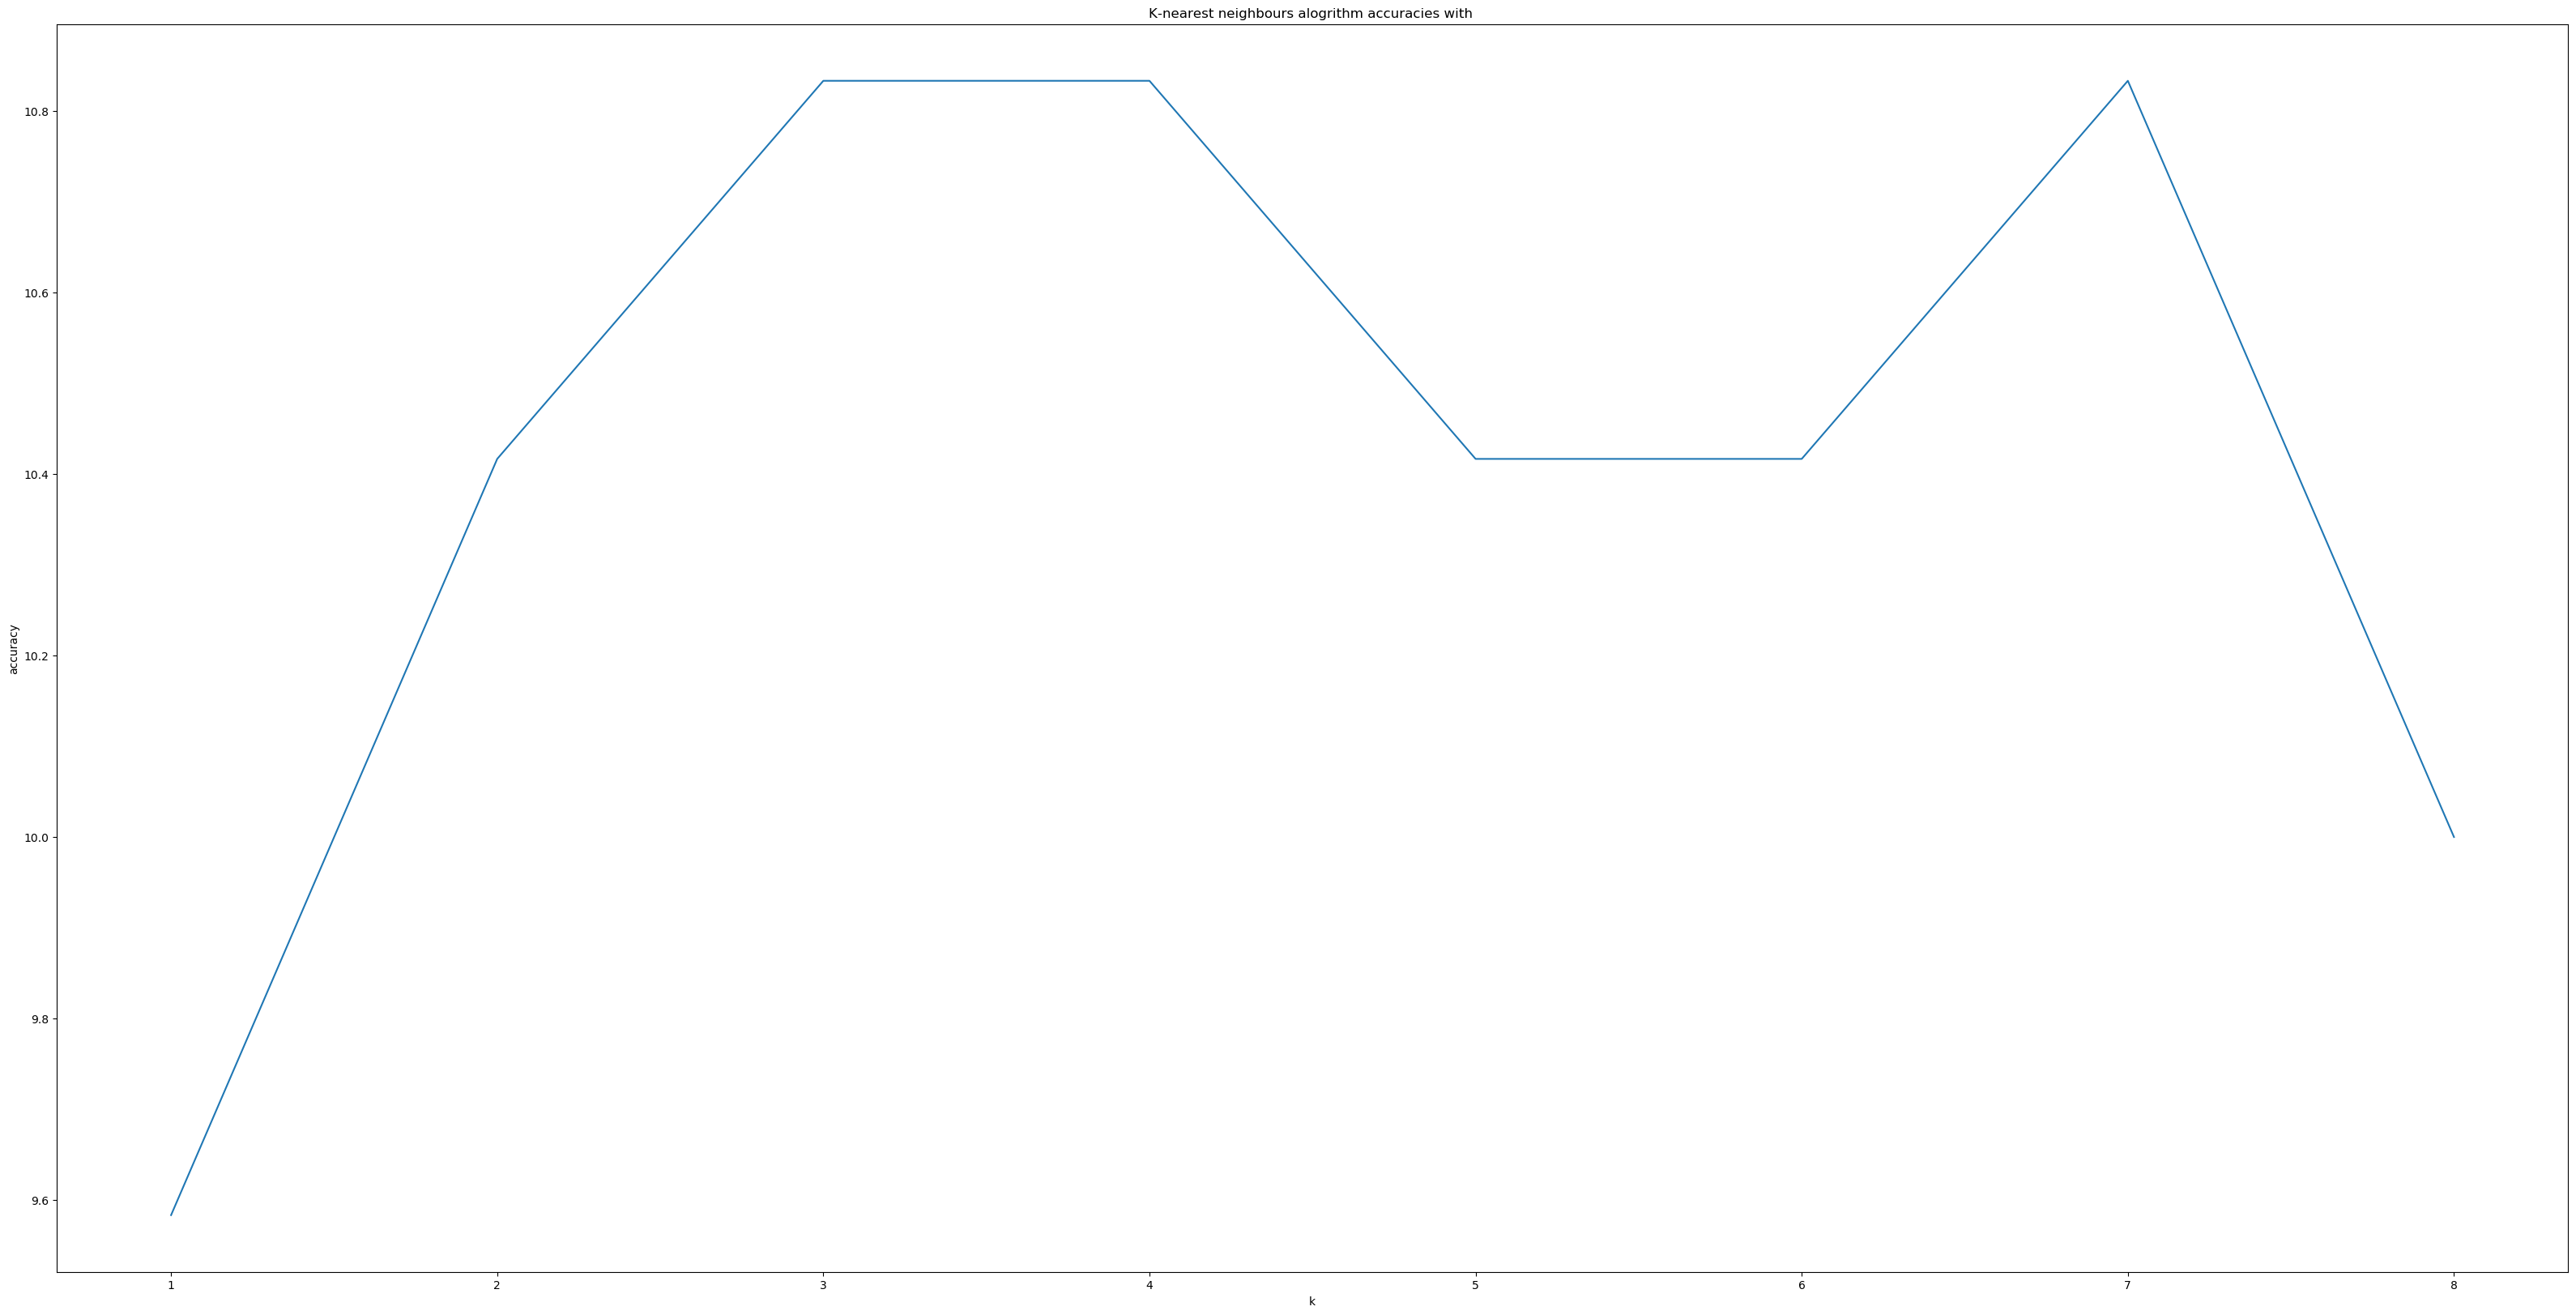

K-nearest neighbours algorithm accuracy: 10.833333333333334
0.03
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.1s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'c

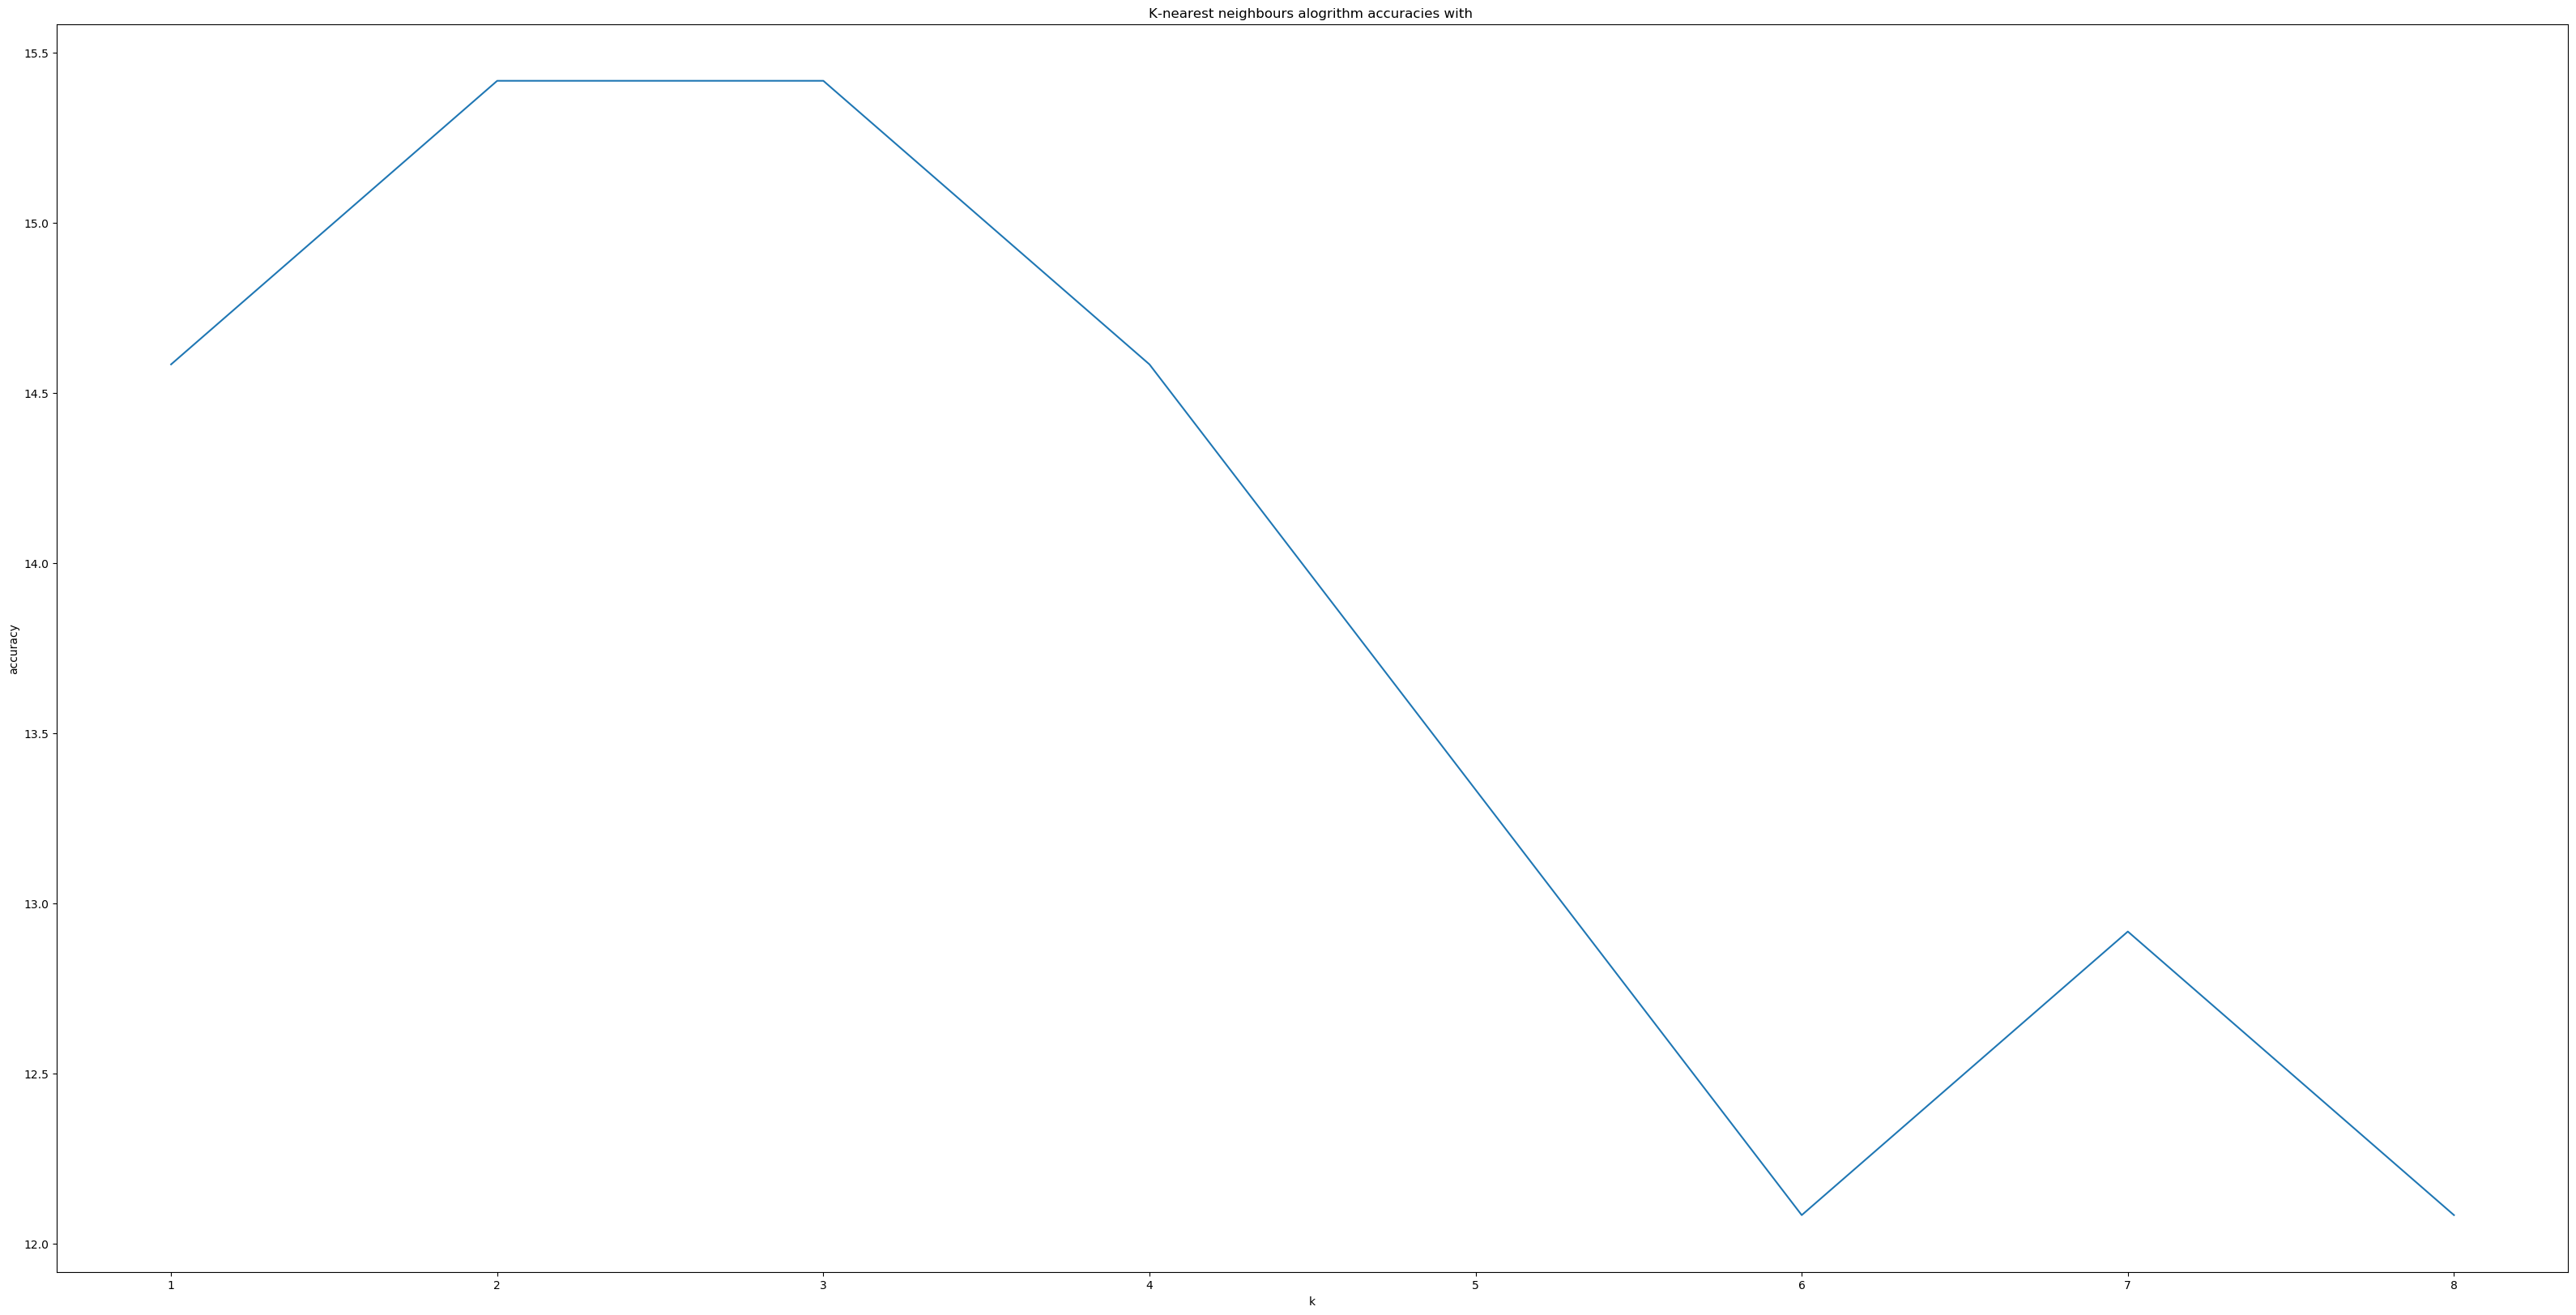

K-nearest neighbours algorithm accuracy: 15.416666666666668
0.05
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'c

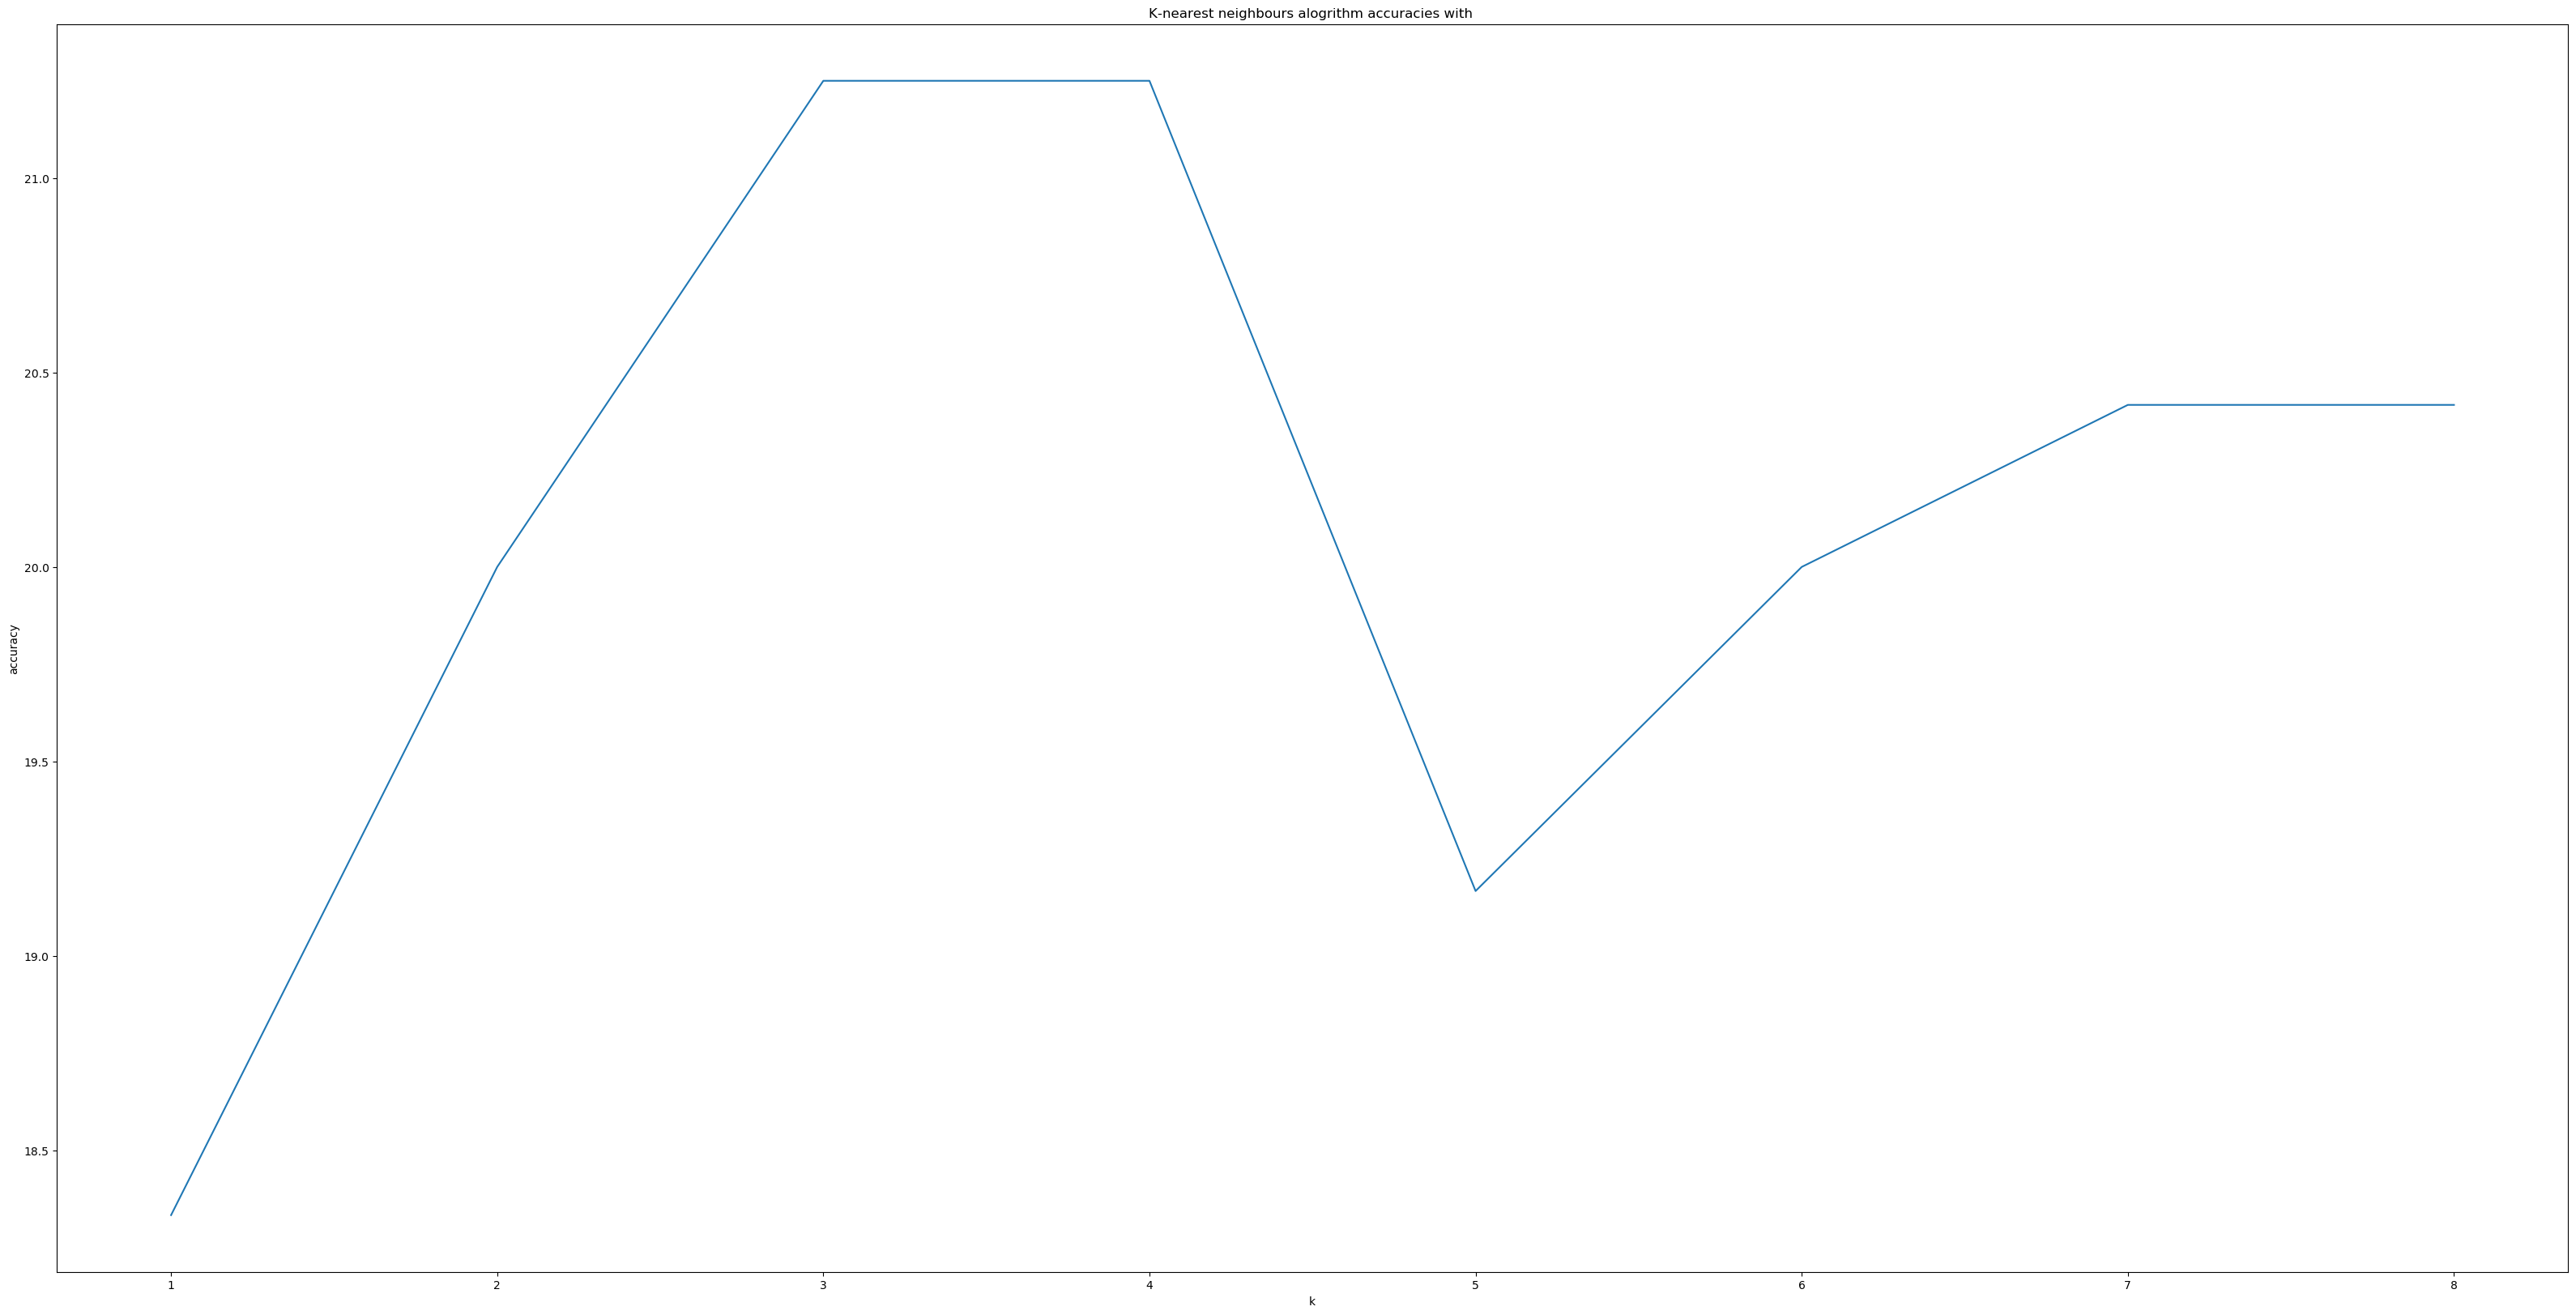

K-nearest neighbours algorithm accuracy: 21.25
0.1
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['e

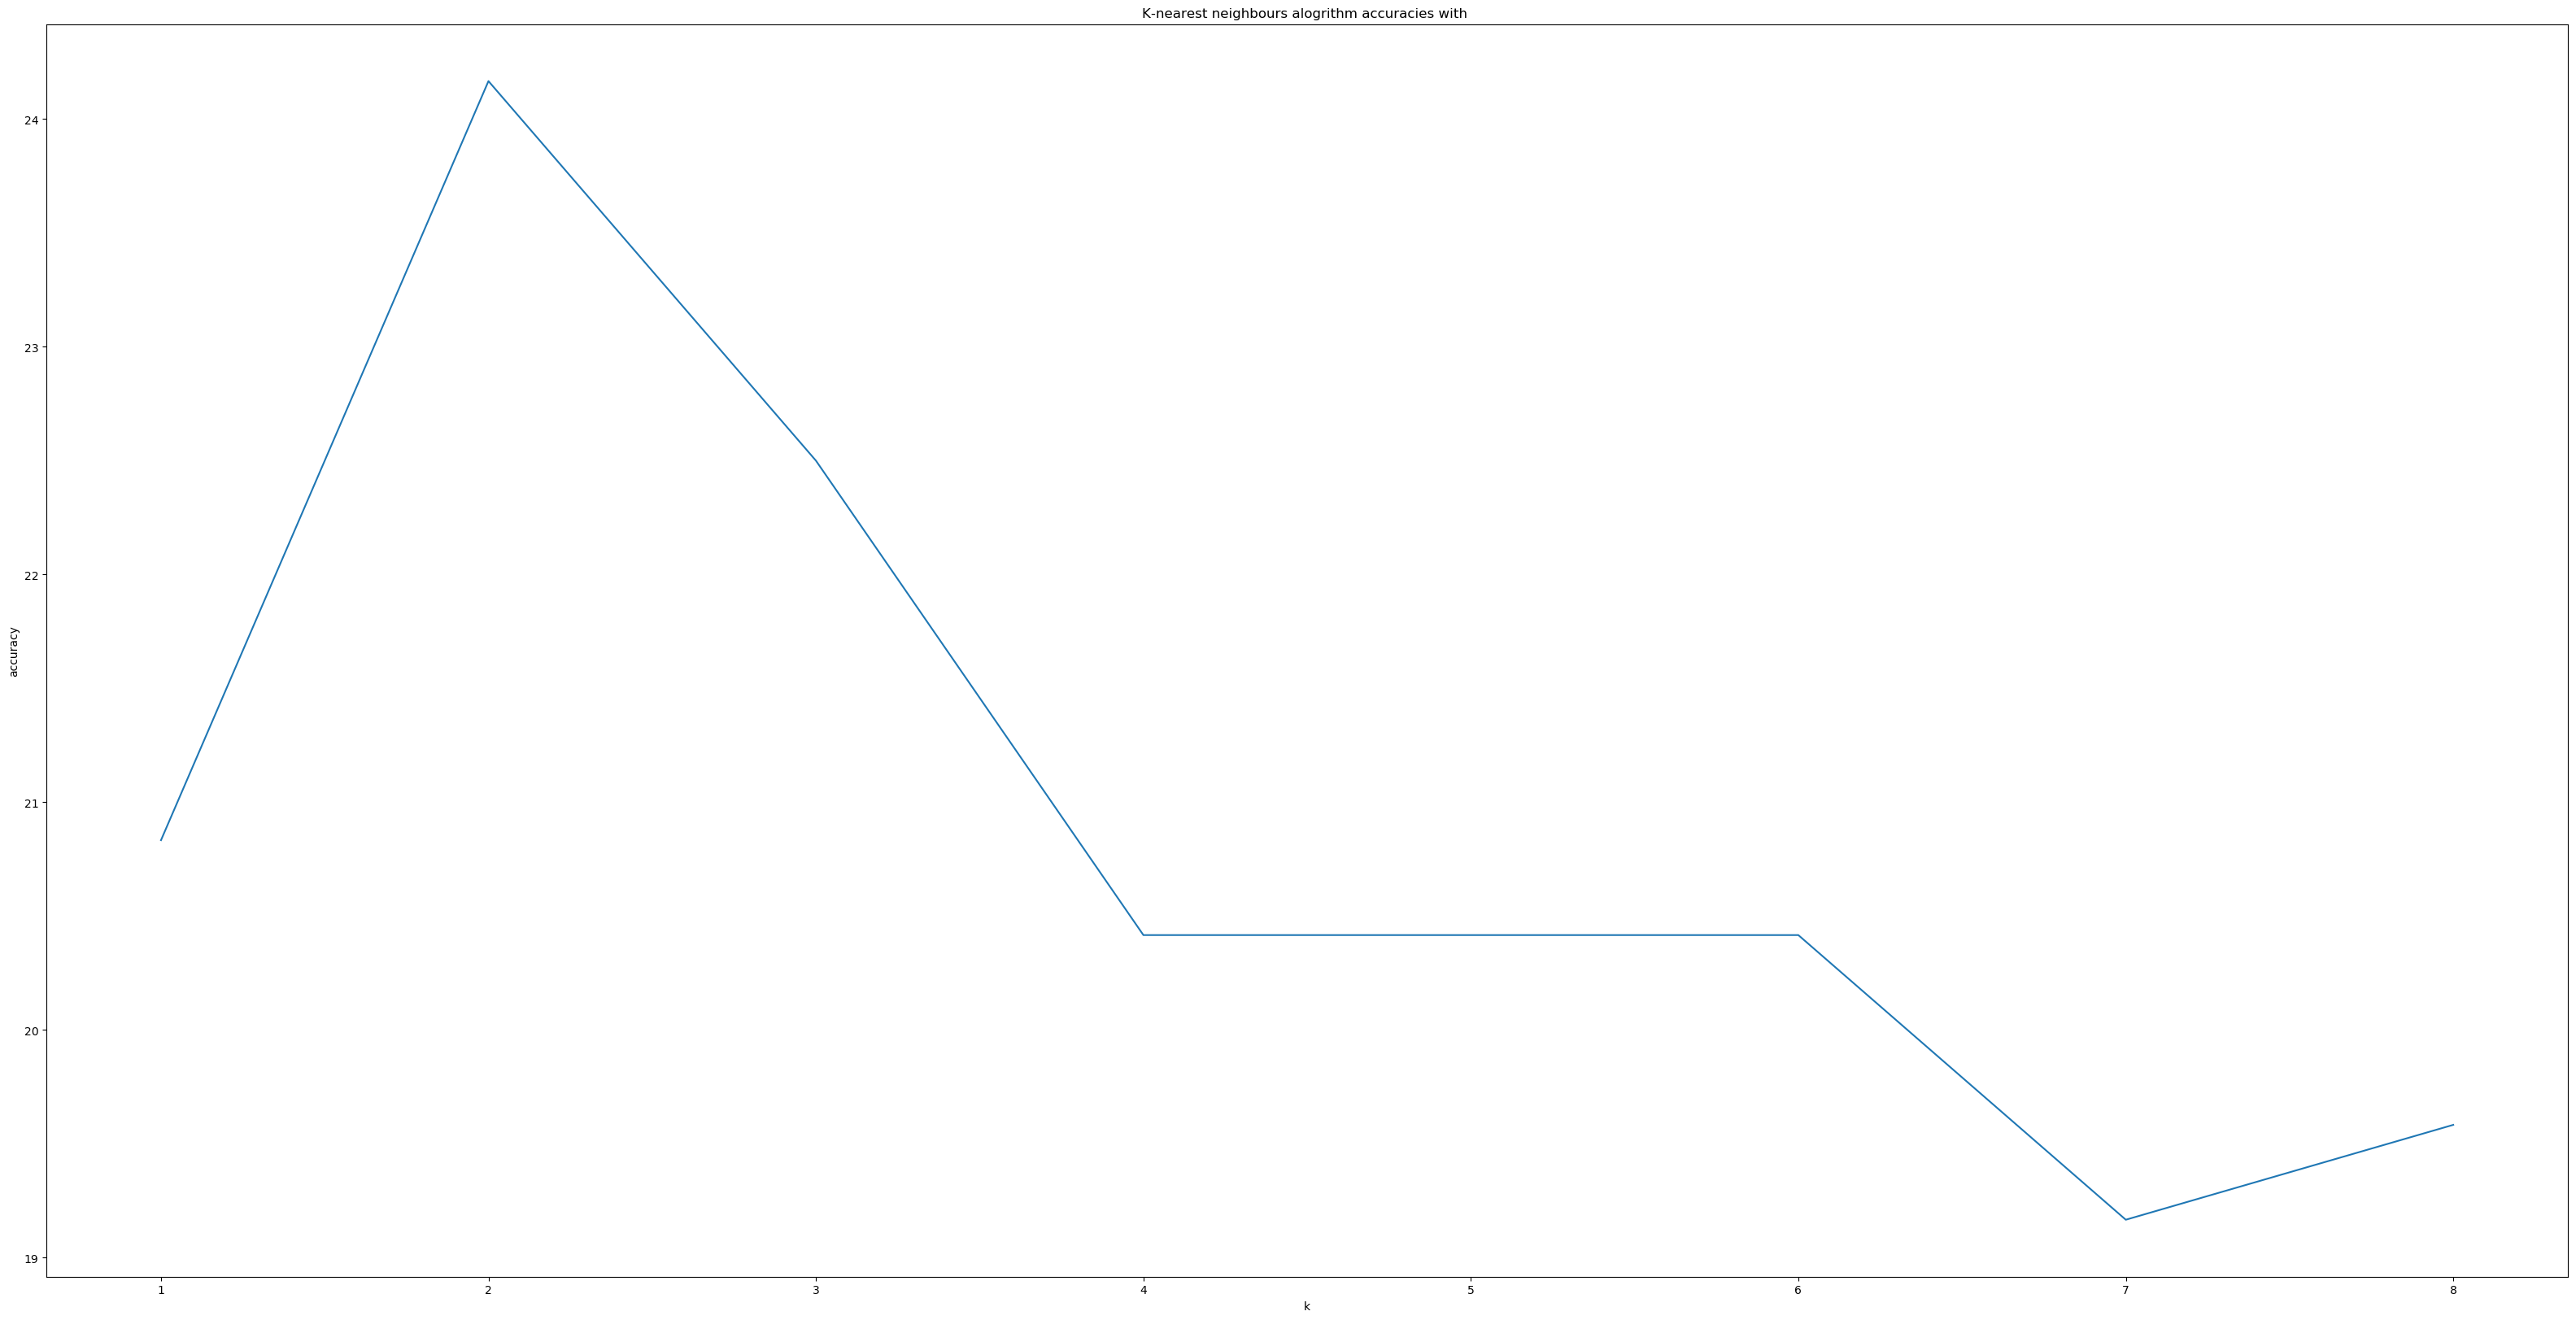

K-nearest neighbours algorithm accuracy: 24.166666666666668
0.2
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.5s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cr

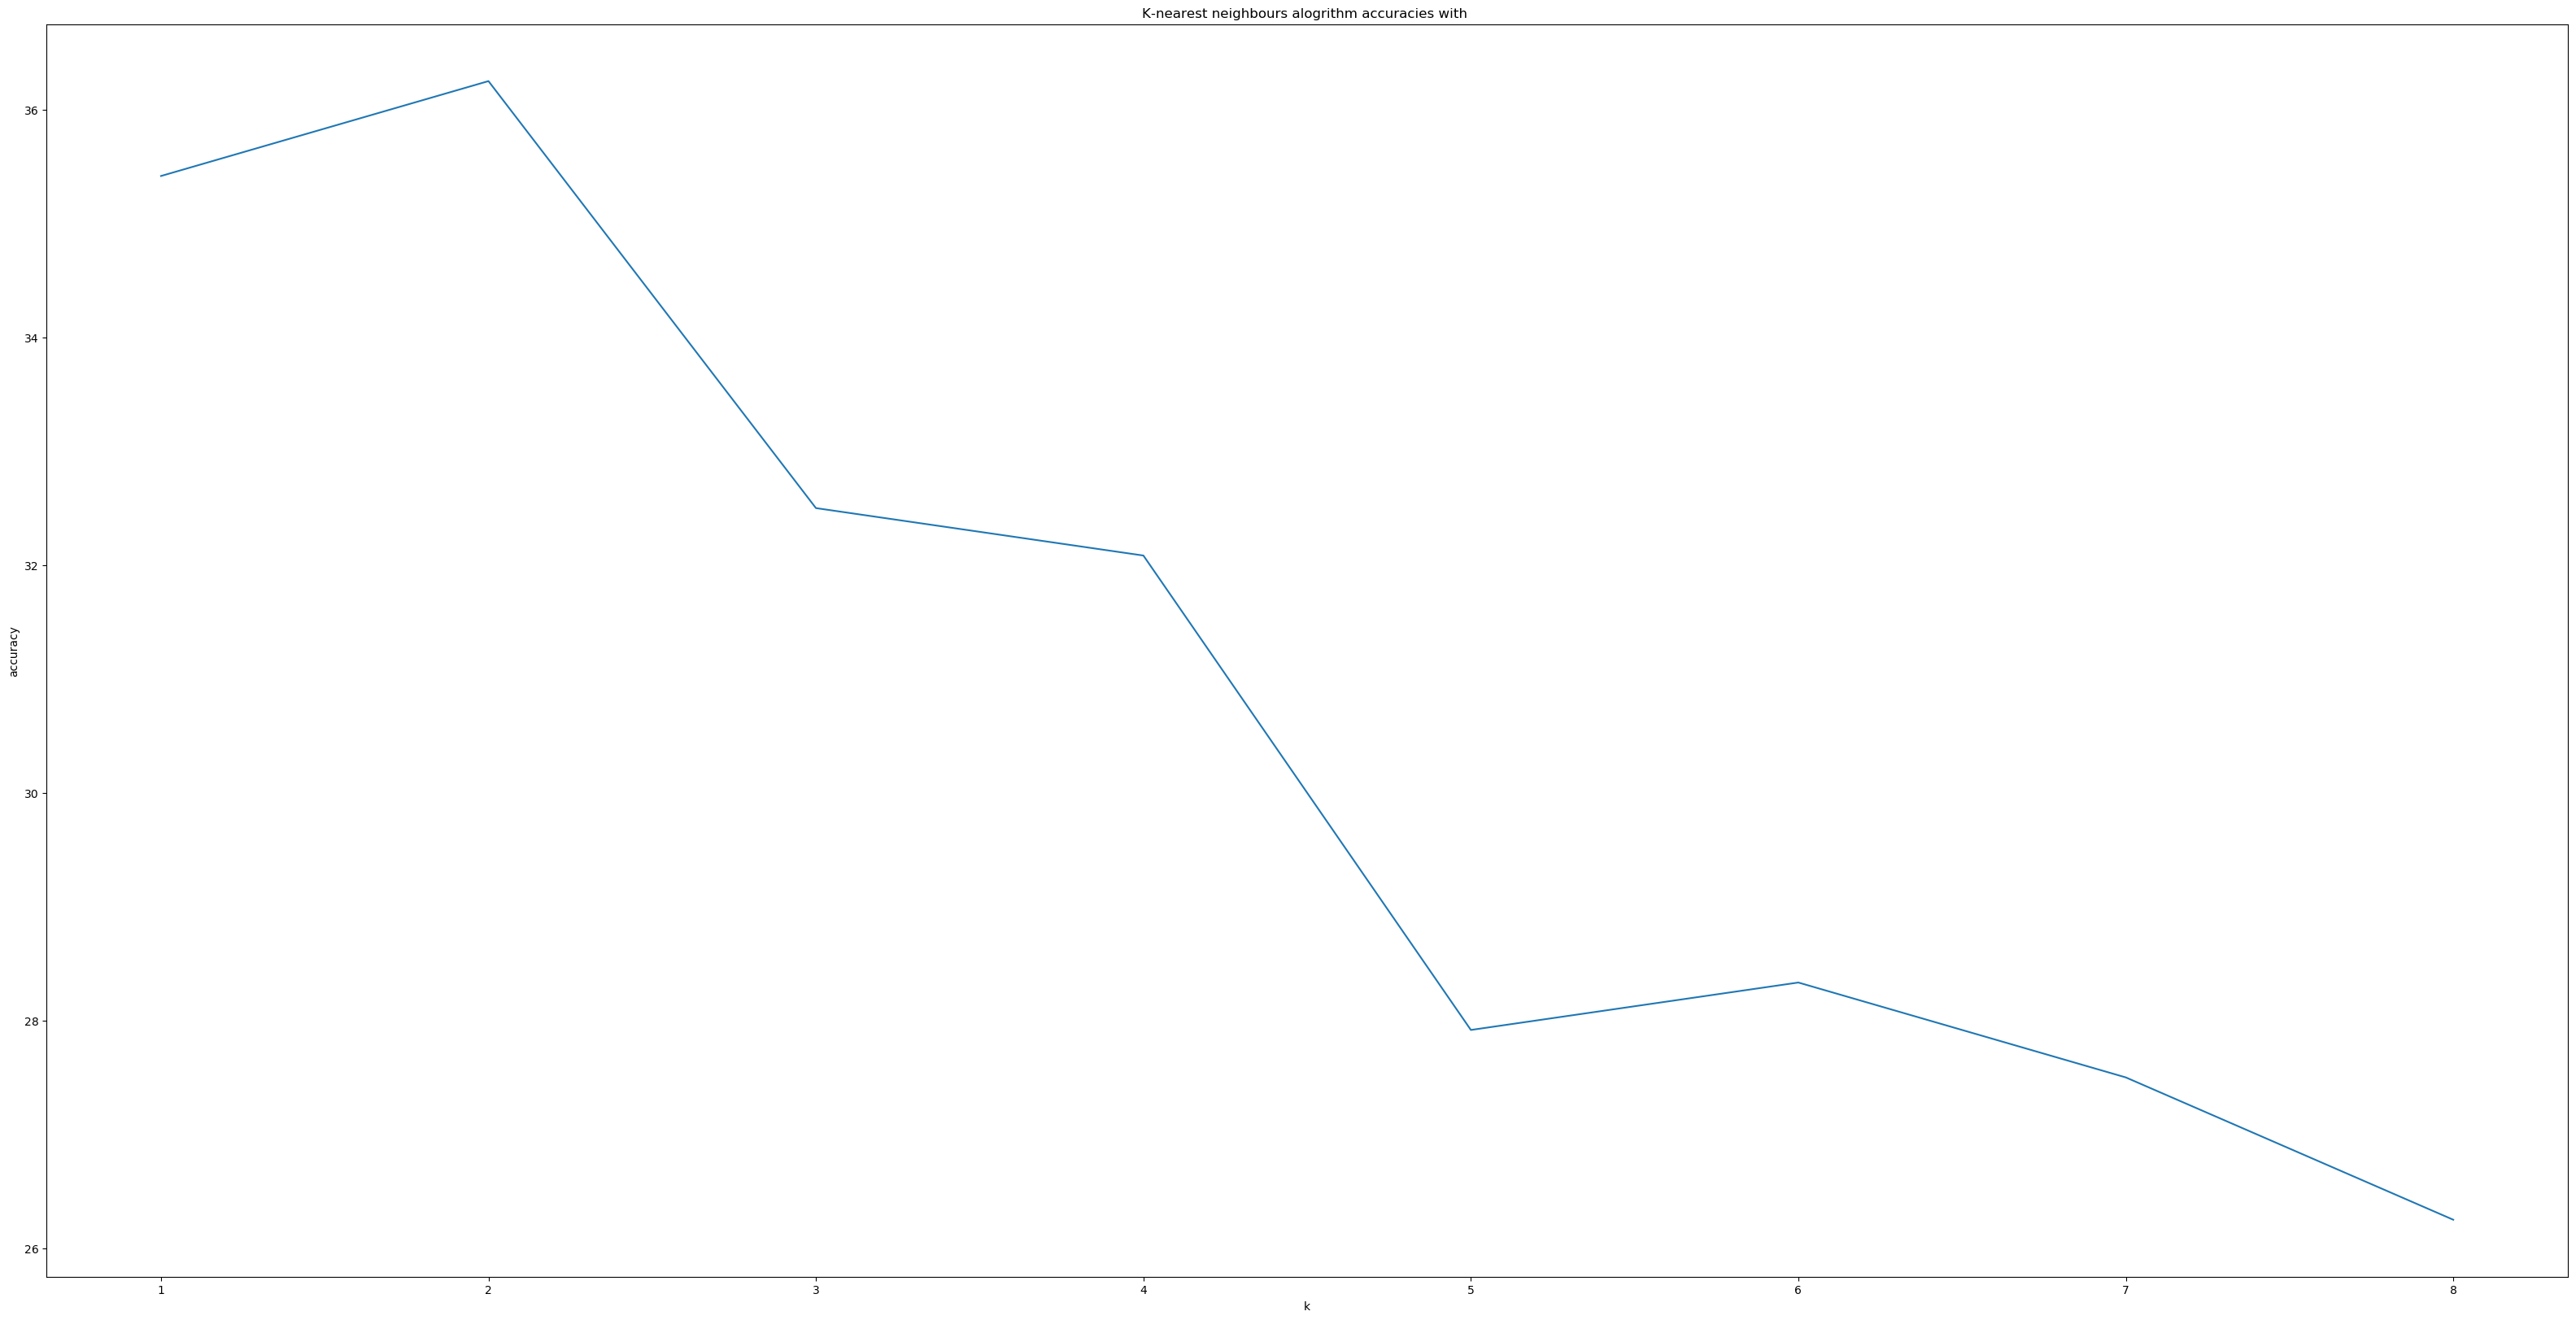

K-nearest neighbours algorithm accuracy: 36.25
0.3
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['e

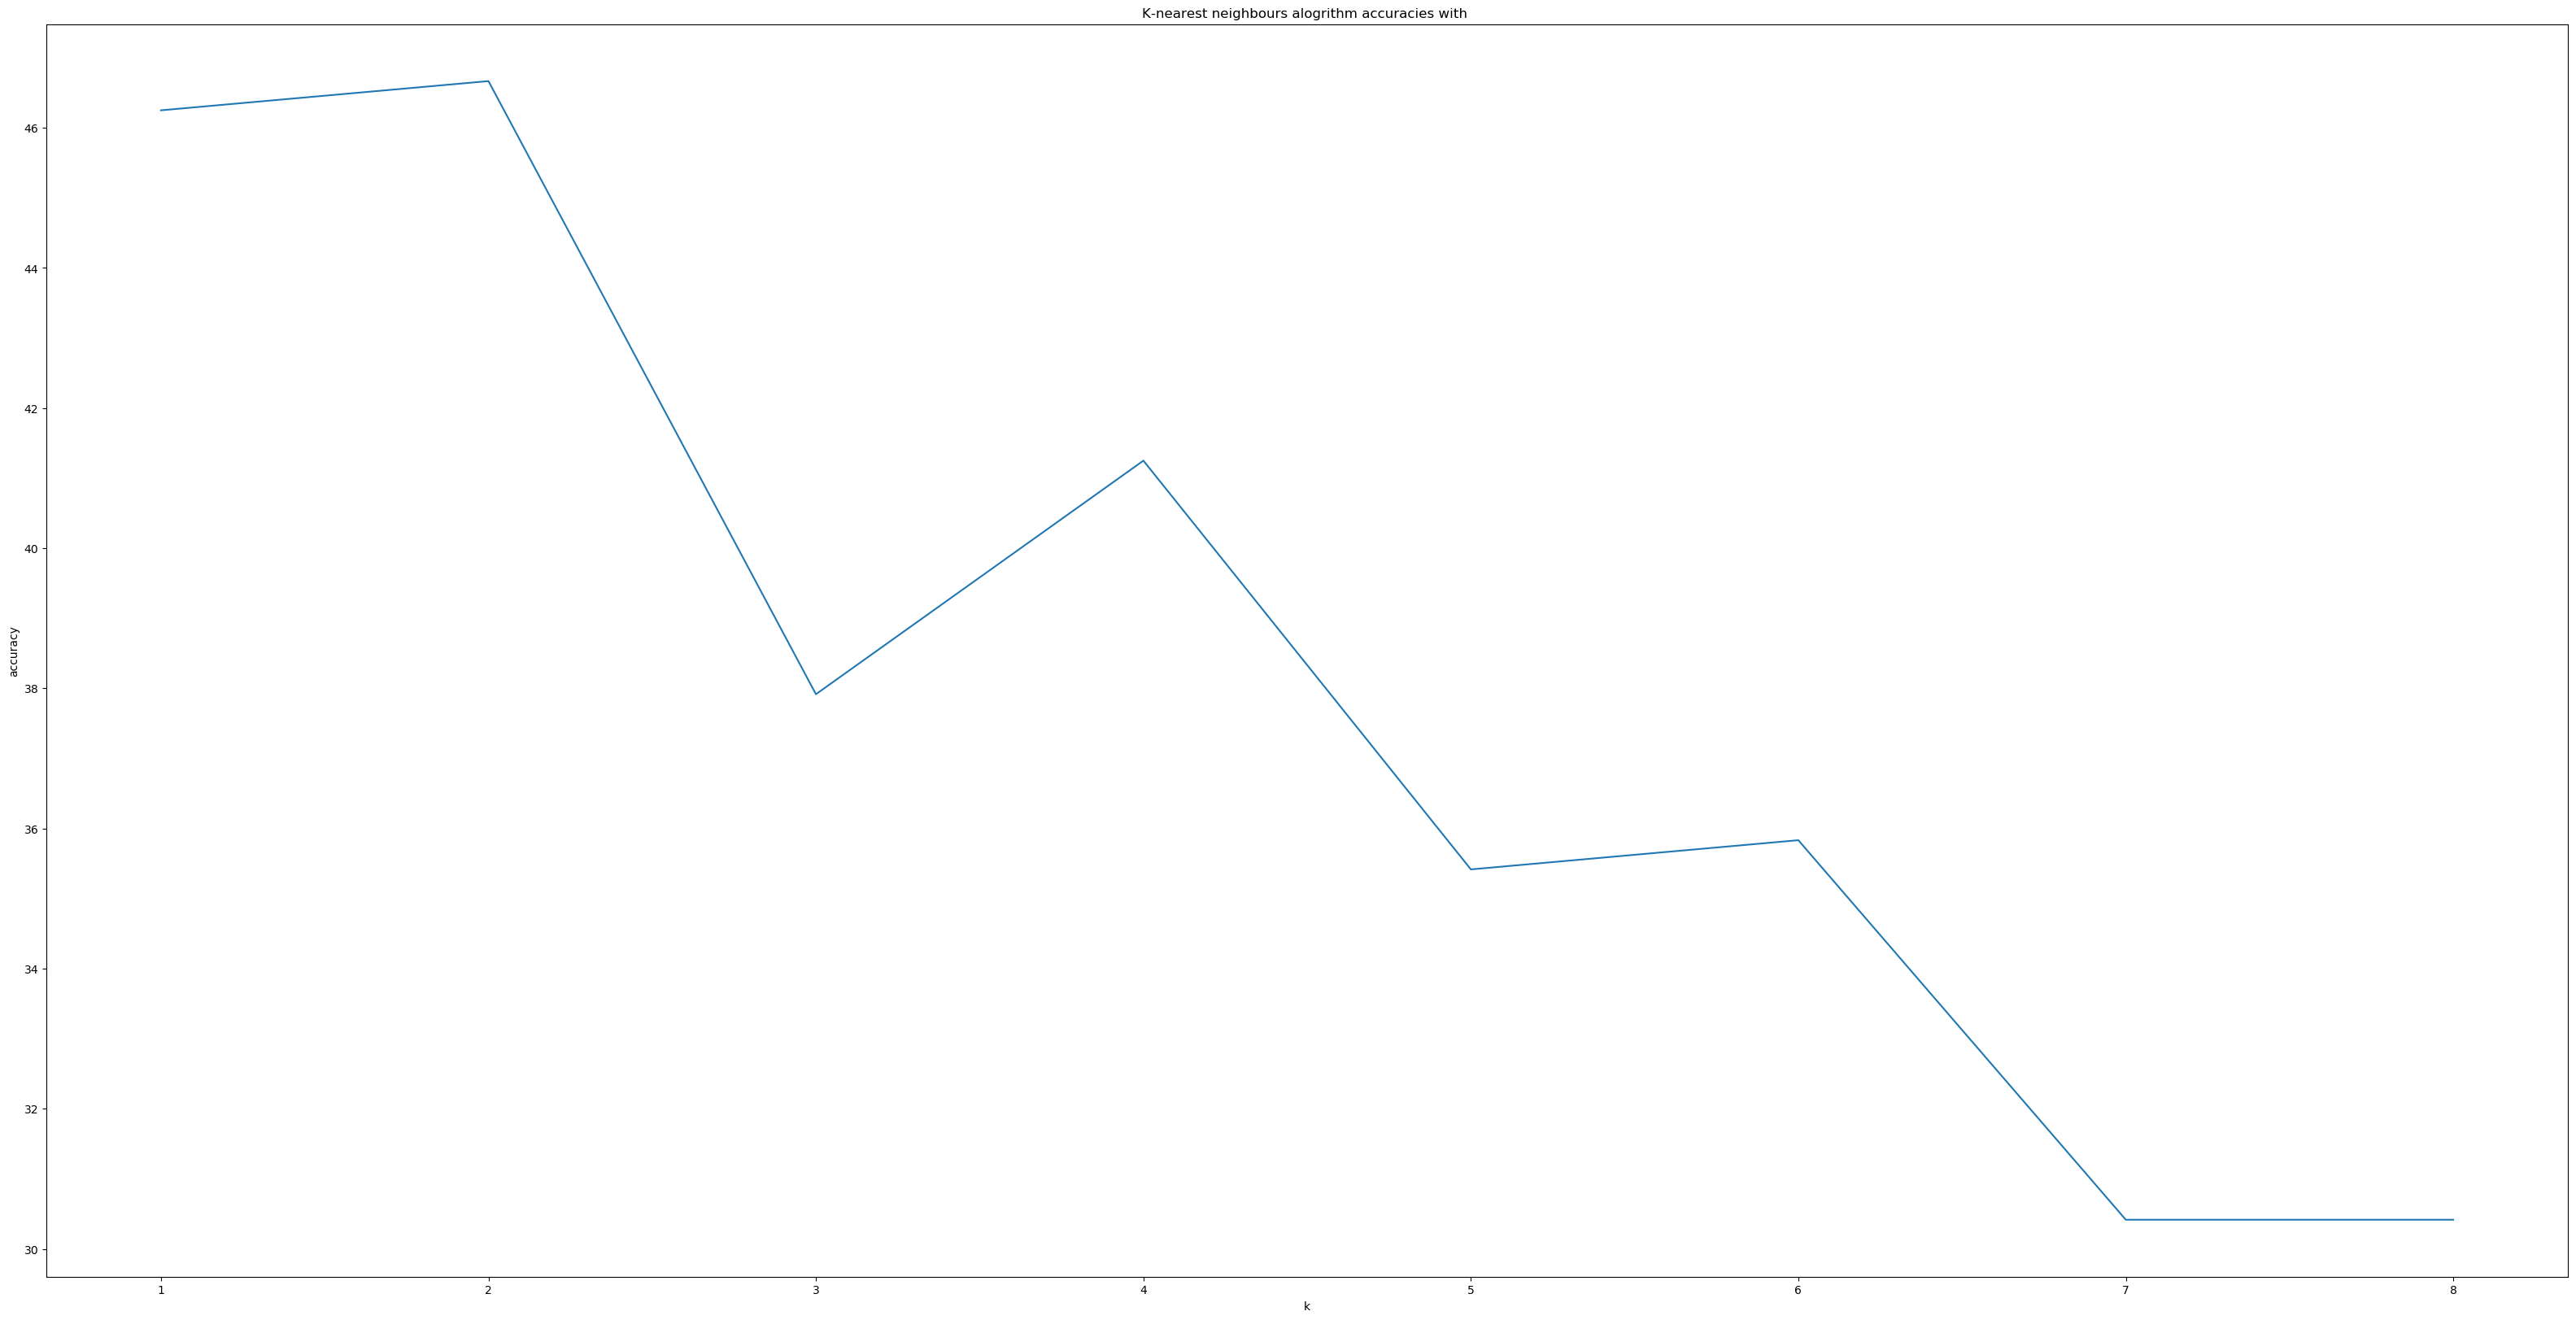

K-nearest neighbours algorithm accuracy: 46.666666666666664
0.4
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cr

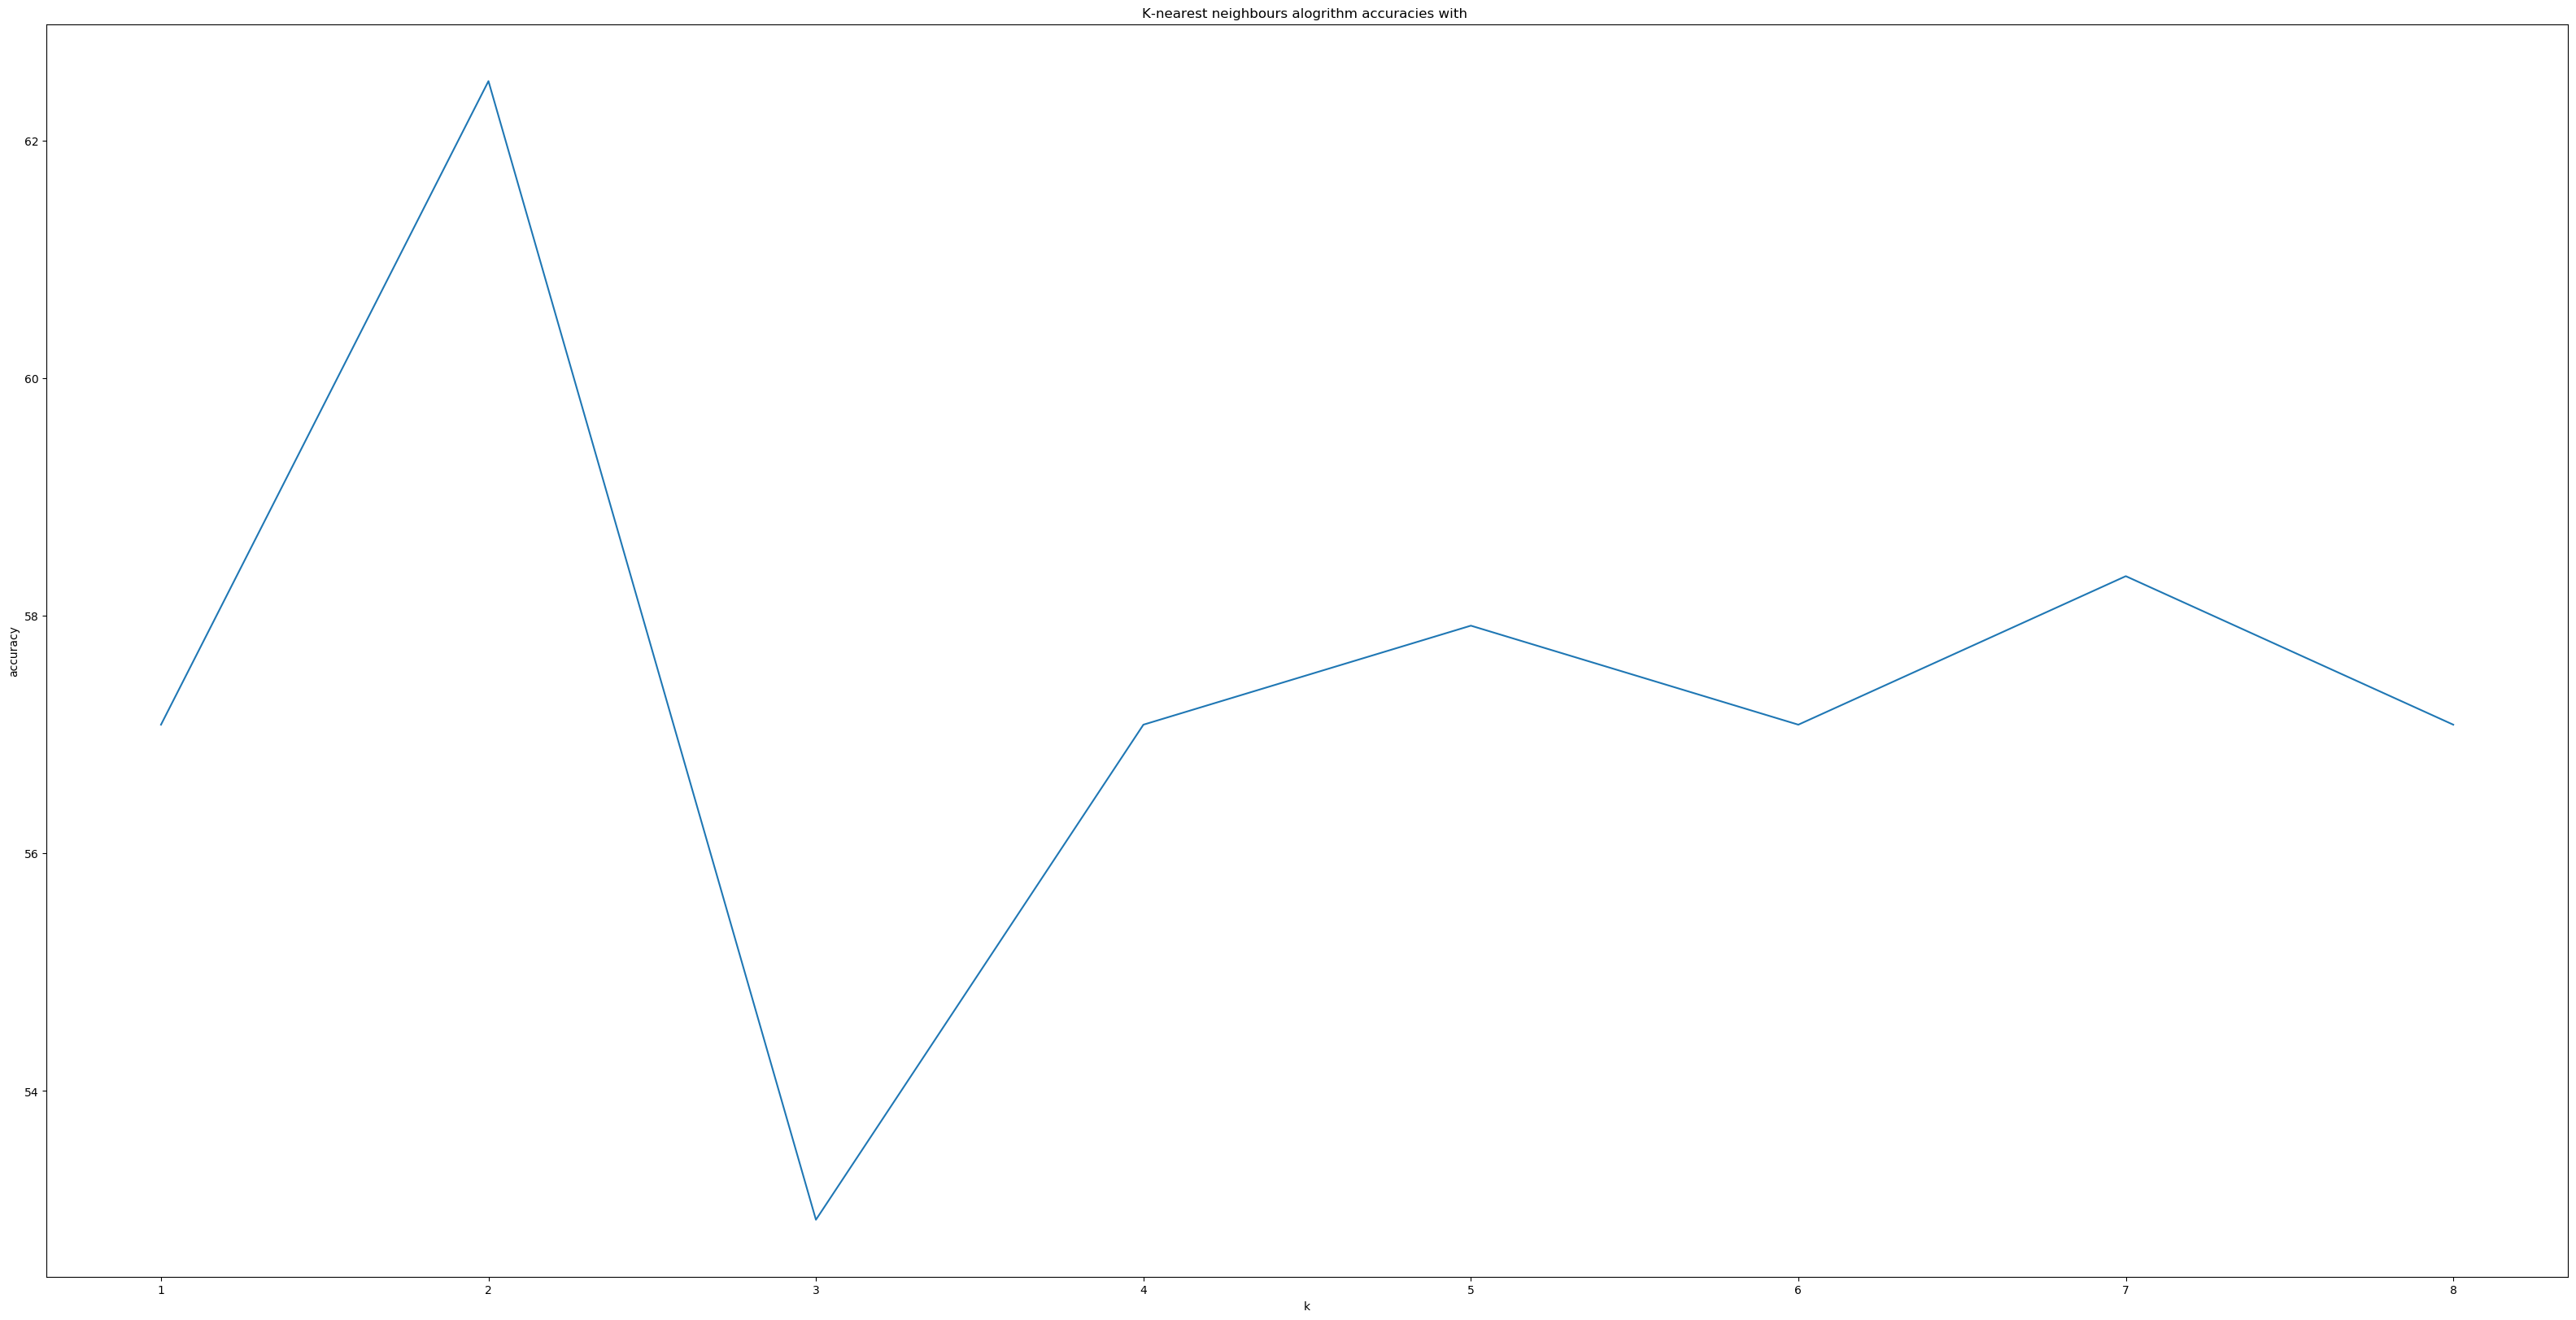

K-nearest neighbours algorithm accuracy: 62.5
0.5
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.5s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.5s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['en

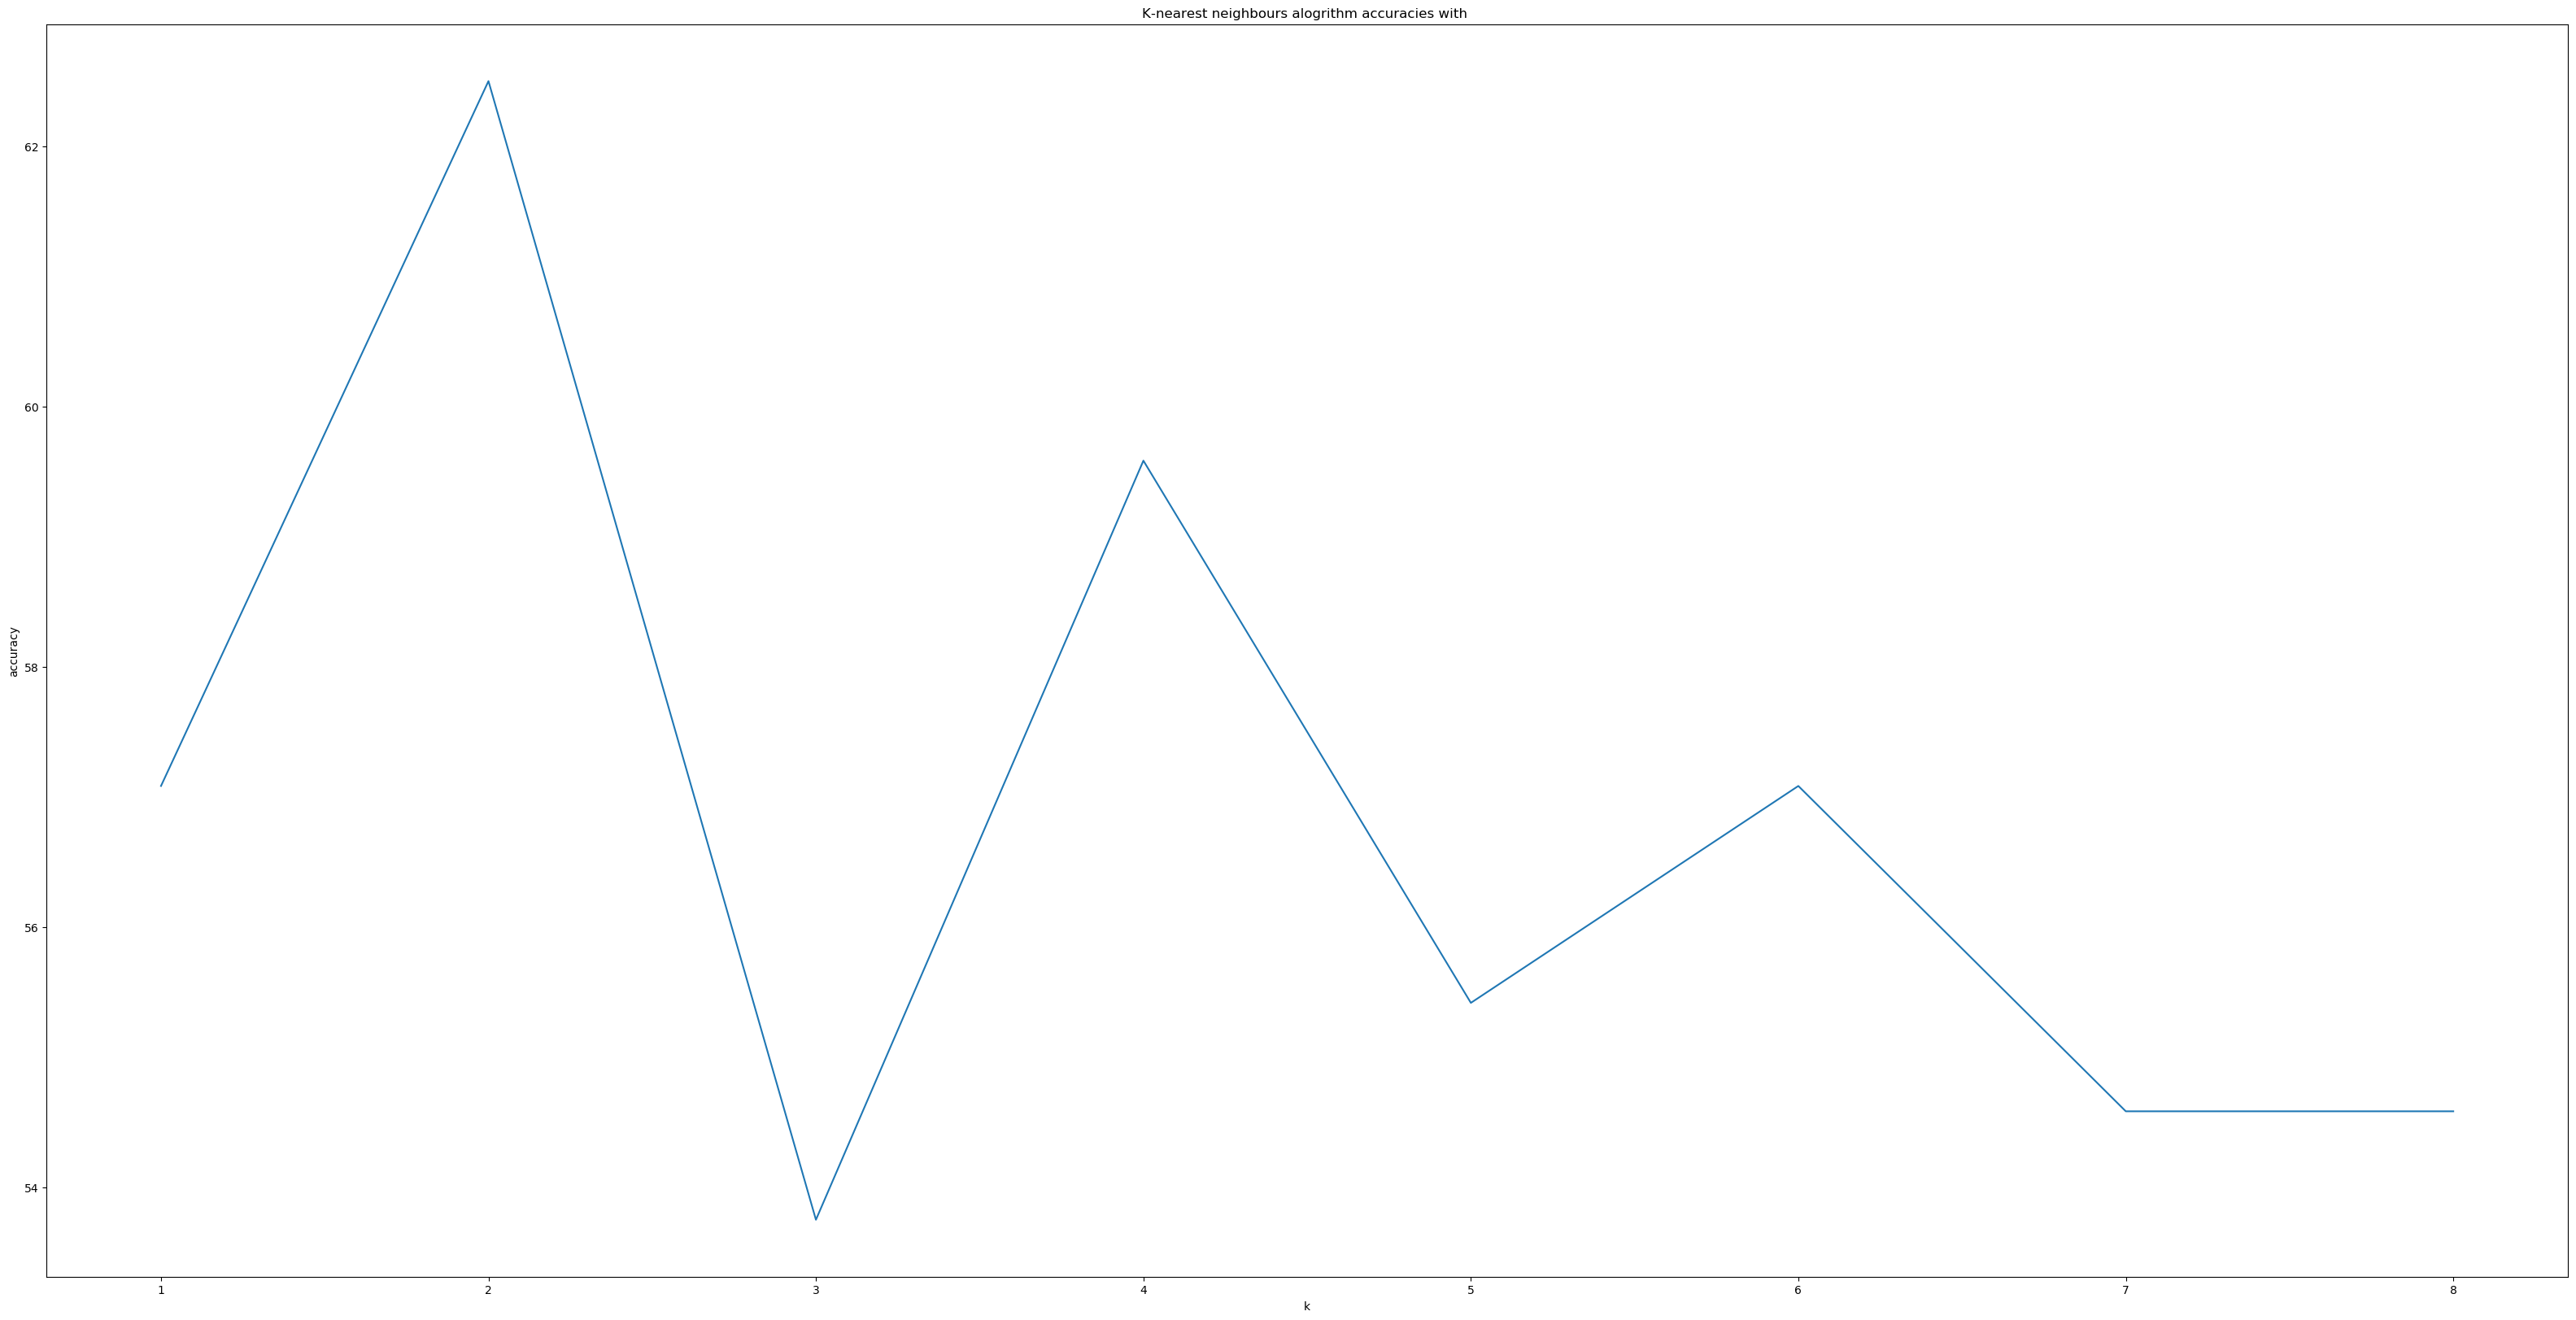

K-nearest neighbours algorithm accuracy: 62.5
0.6
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['en

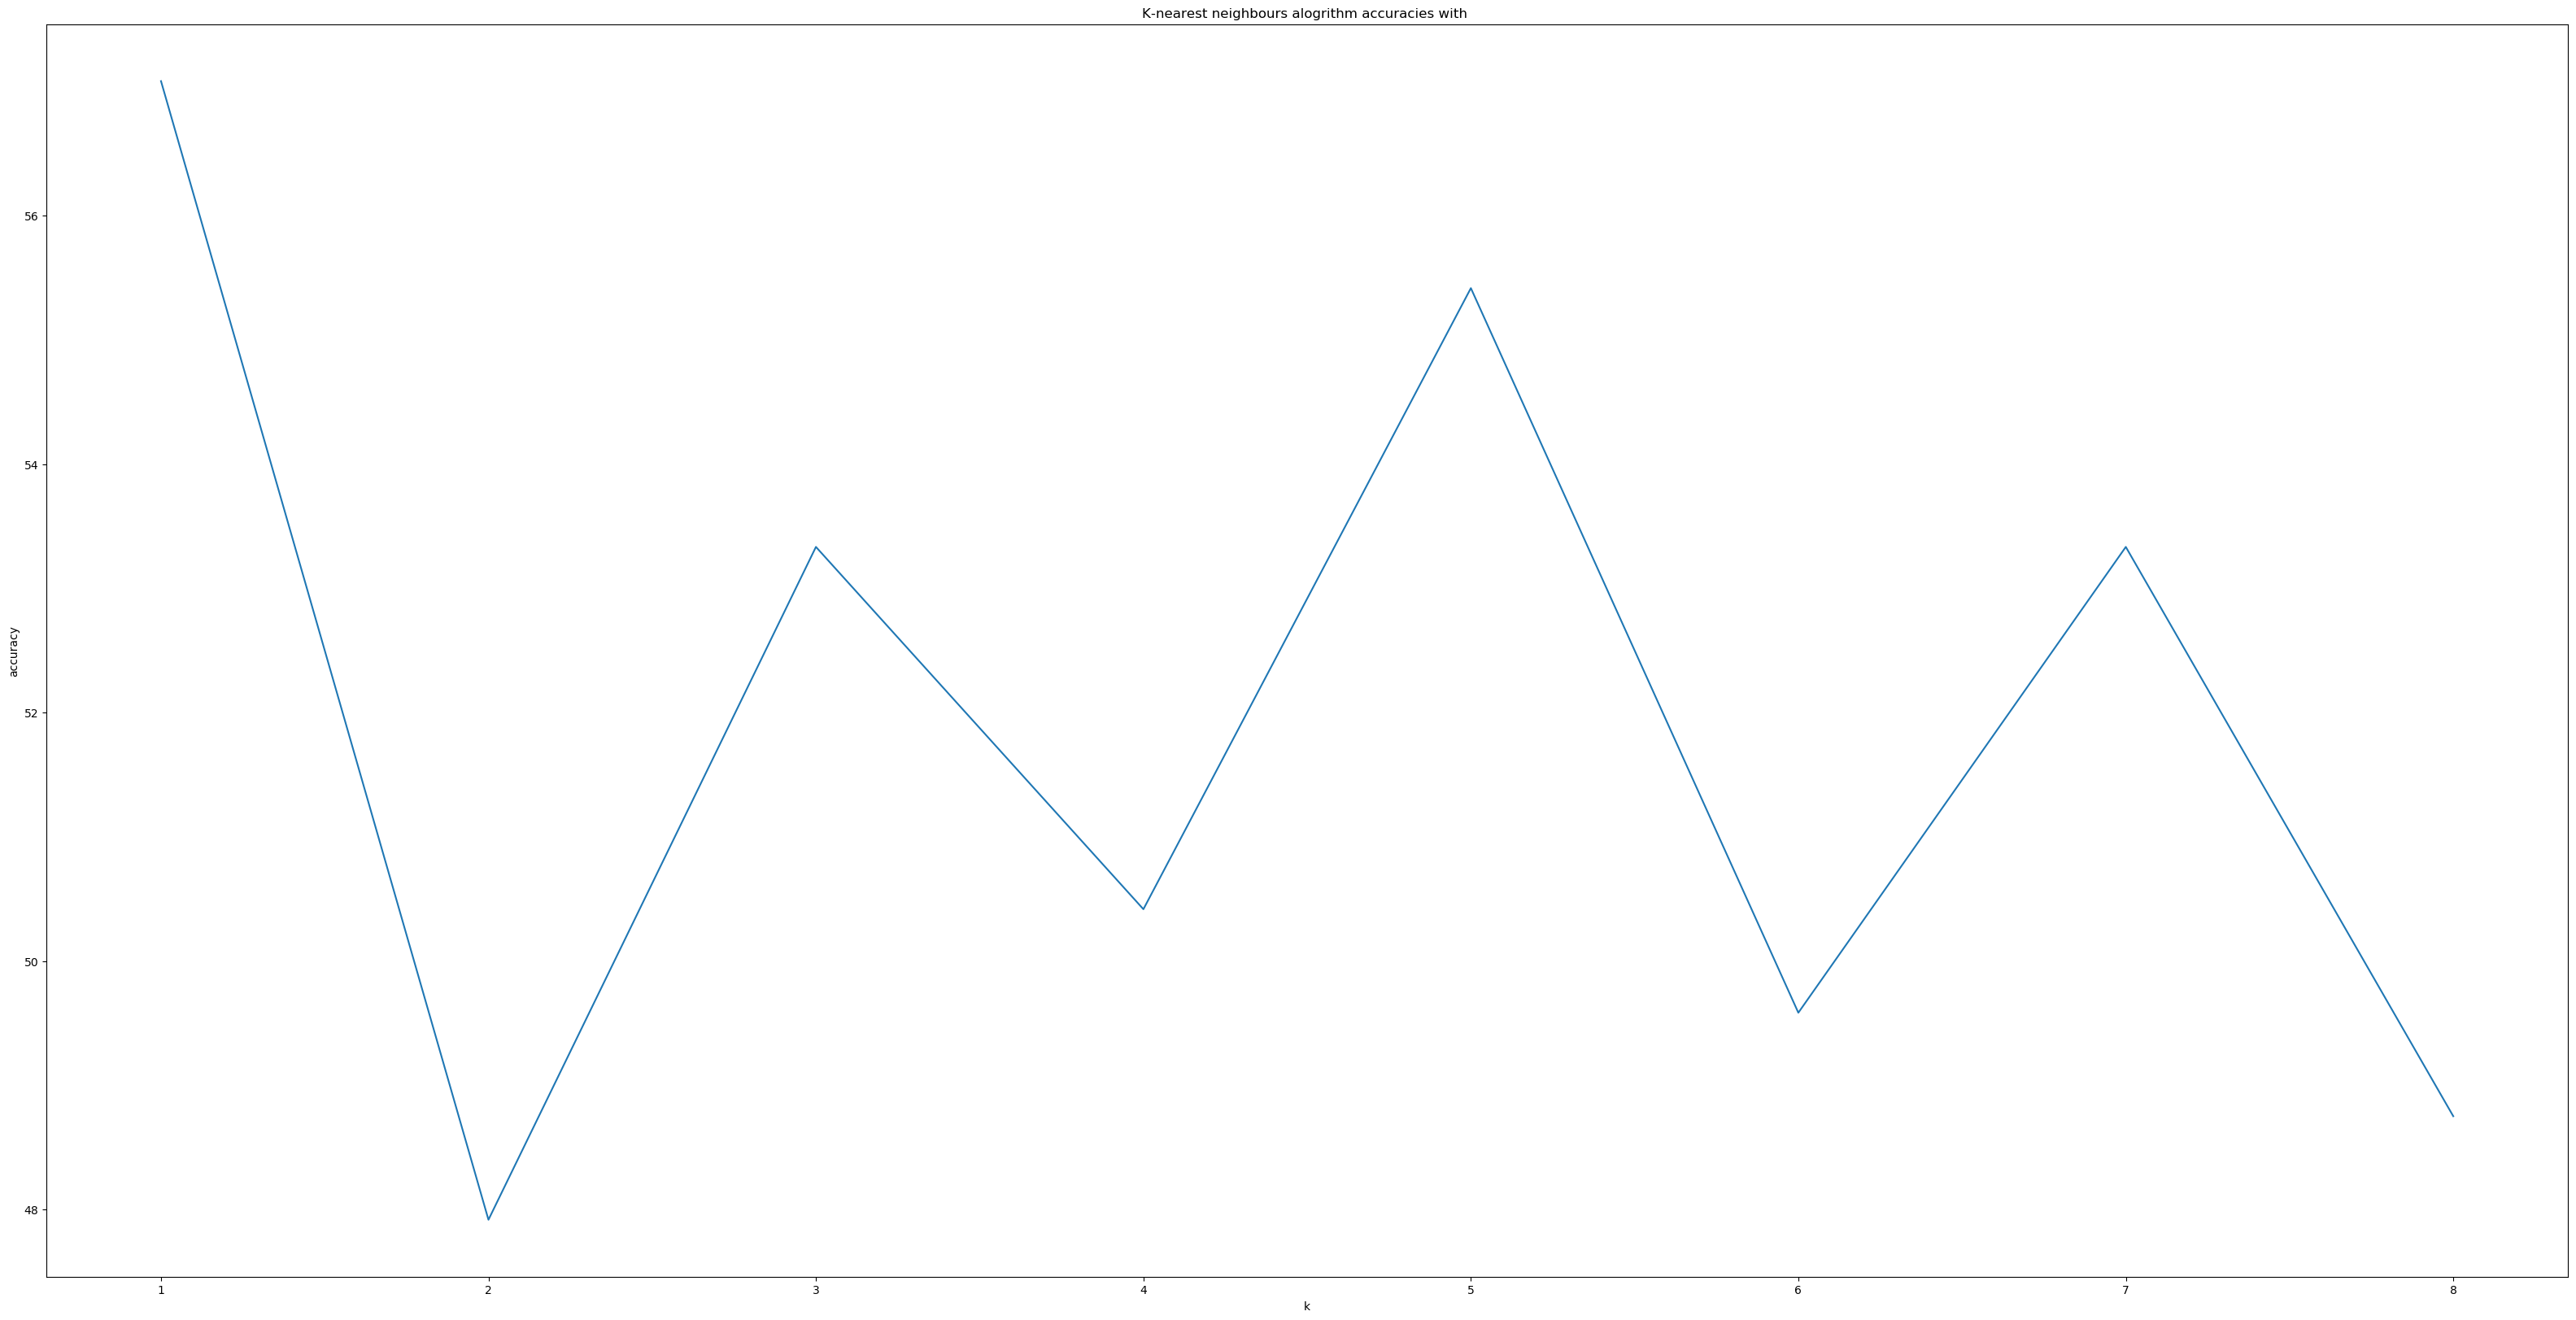

K-nearest neighbours algorithm accuracy: 57.08333333333333
0.7
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   2.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   2.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.7s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   2.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

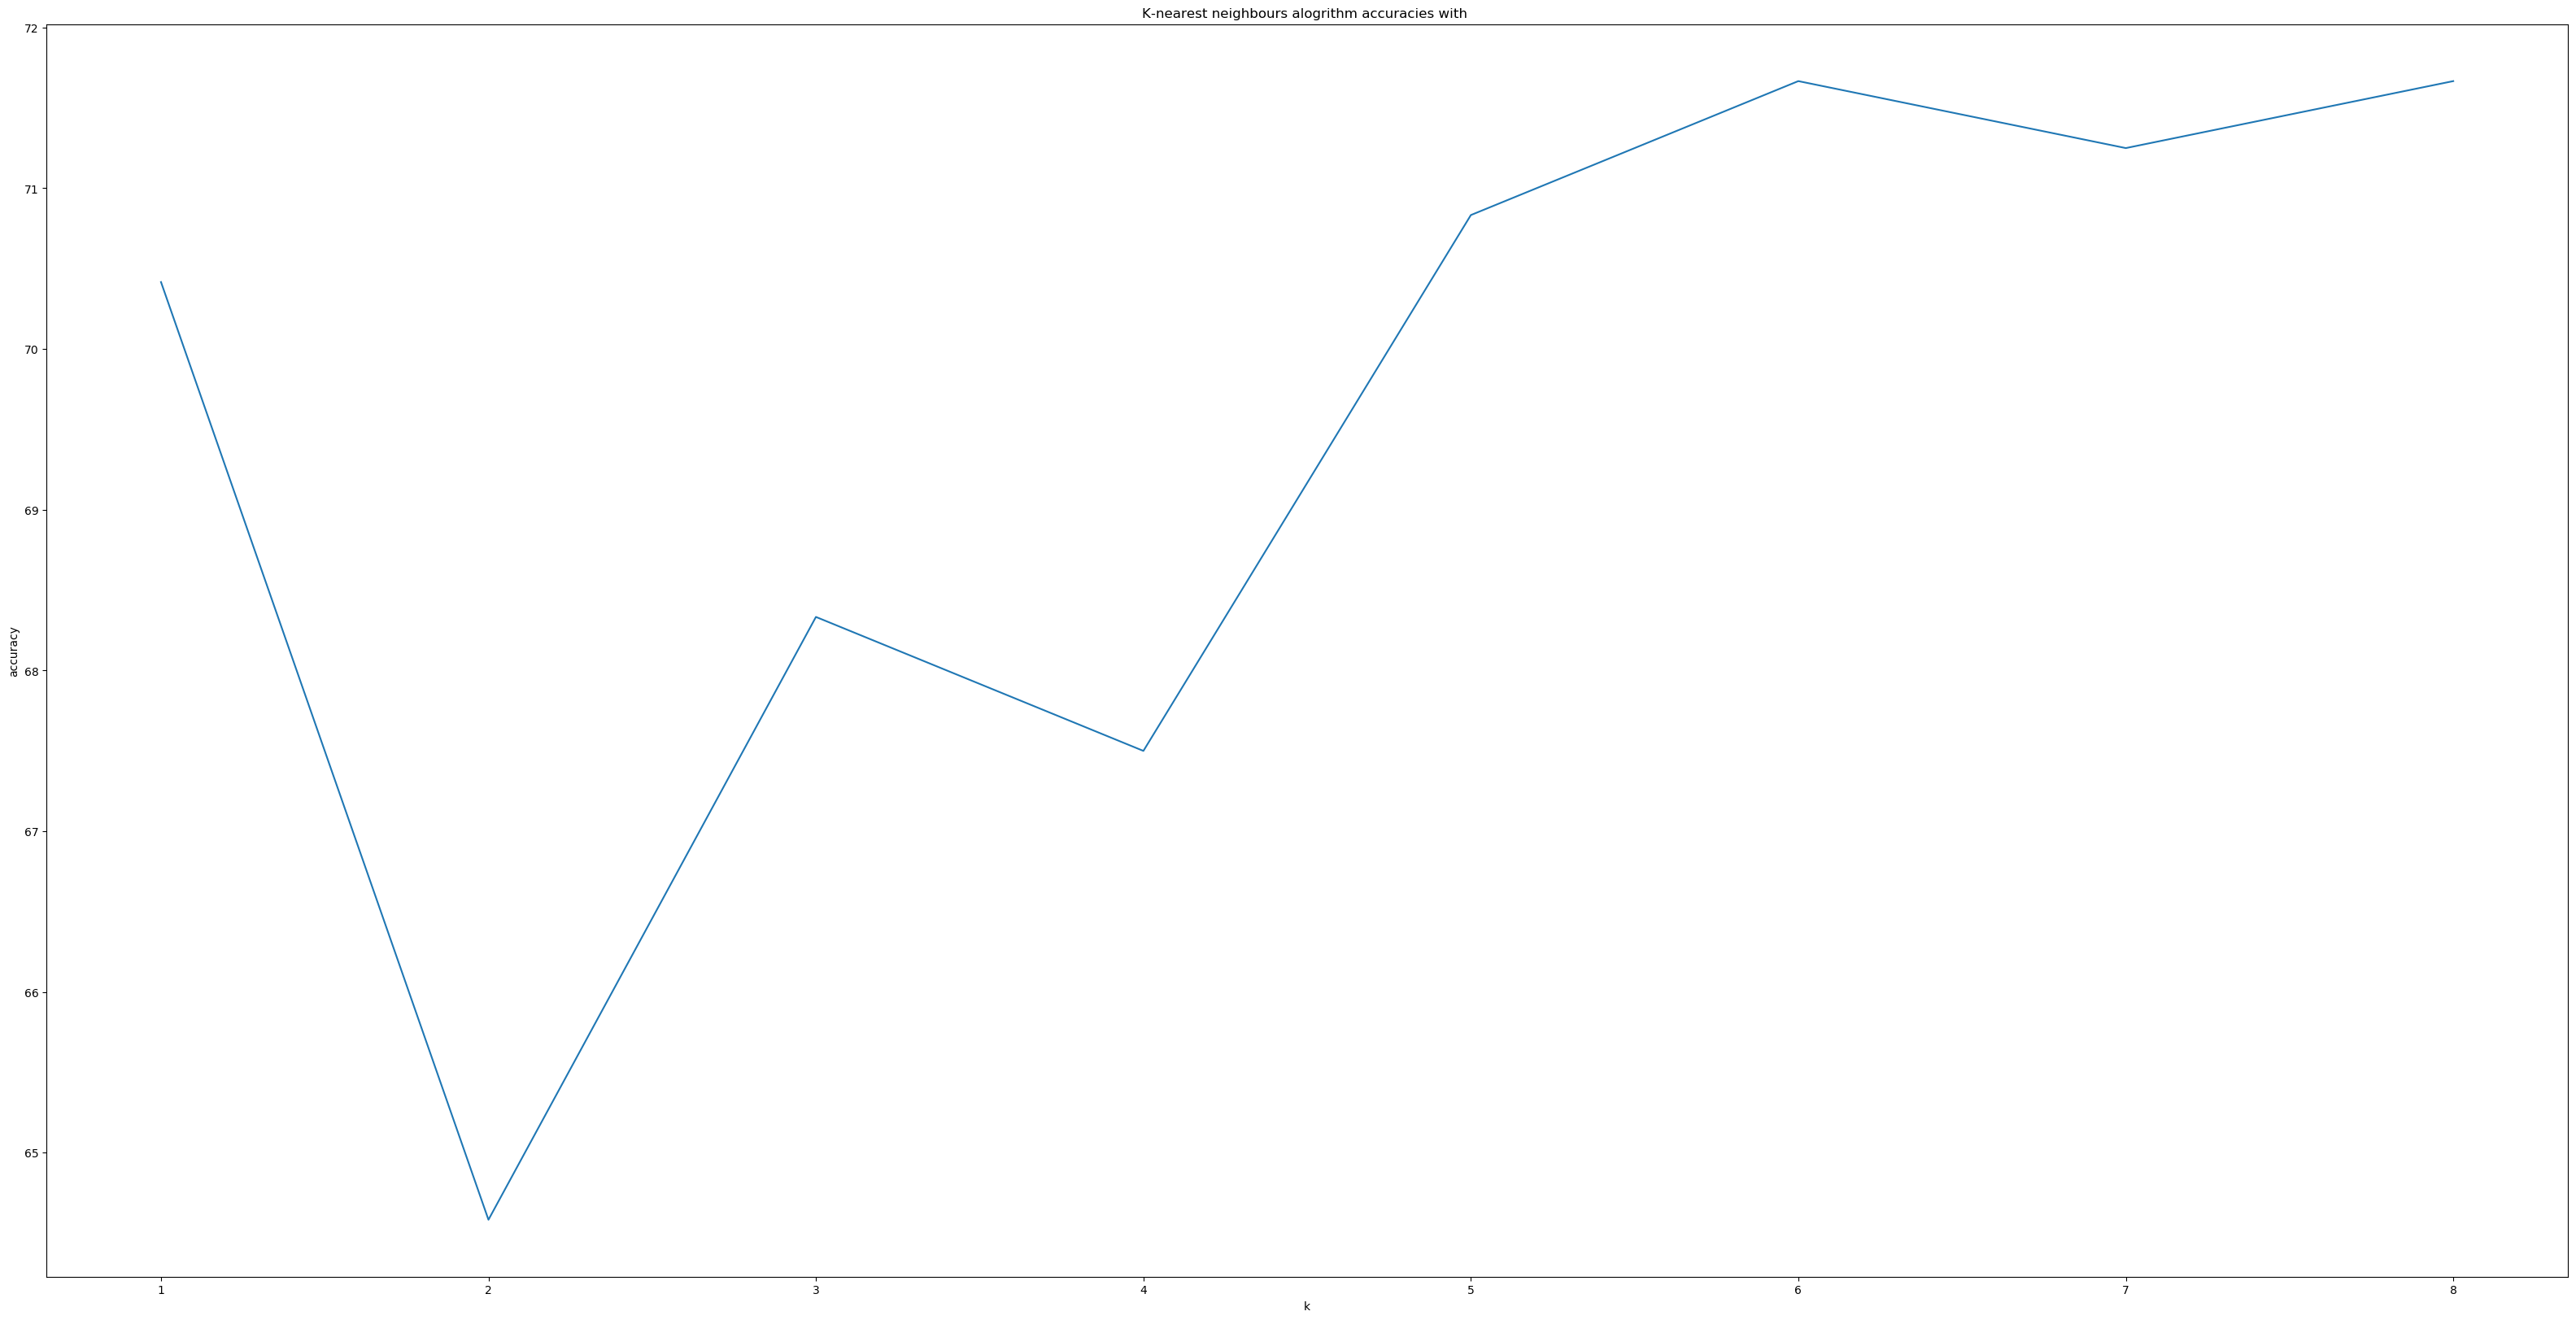

K-nearest neighbours algorithm accuracy: 71.66666666666667
0.8
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   2.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   3.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   2.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   3.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   2.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   2.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

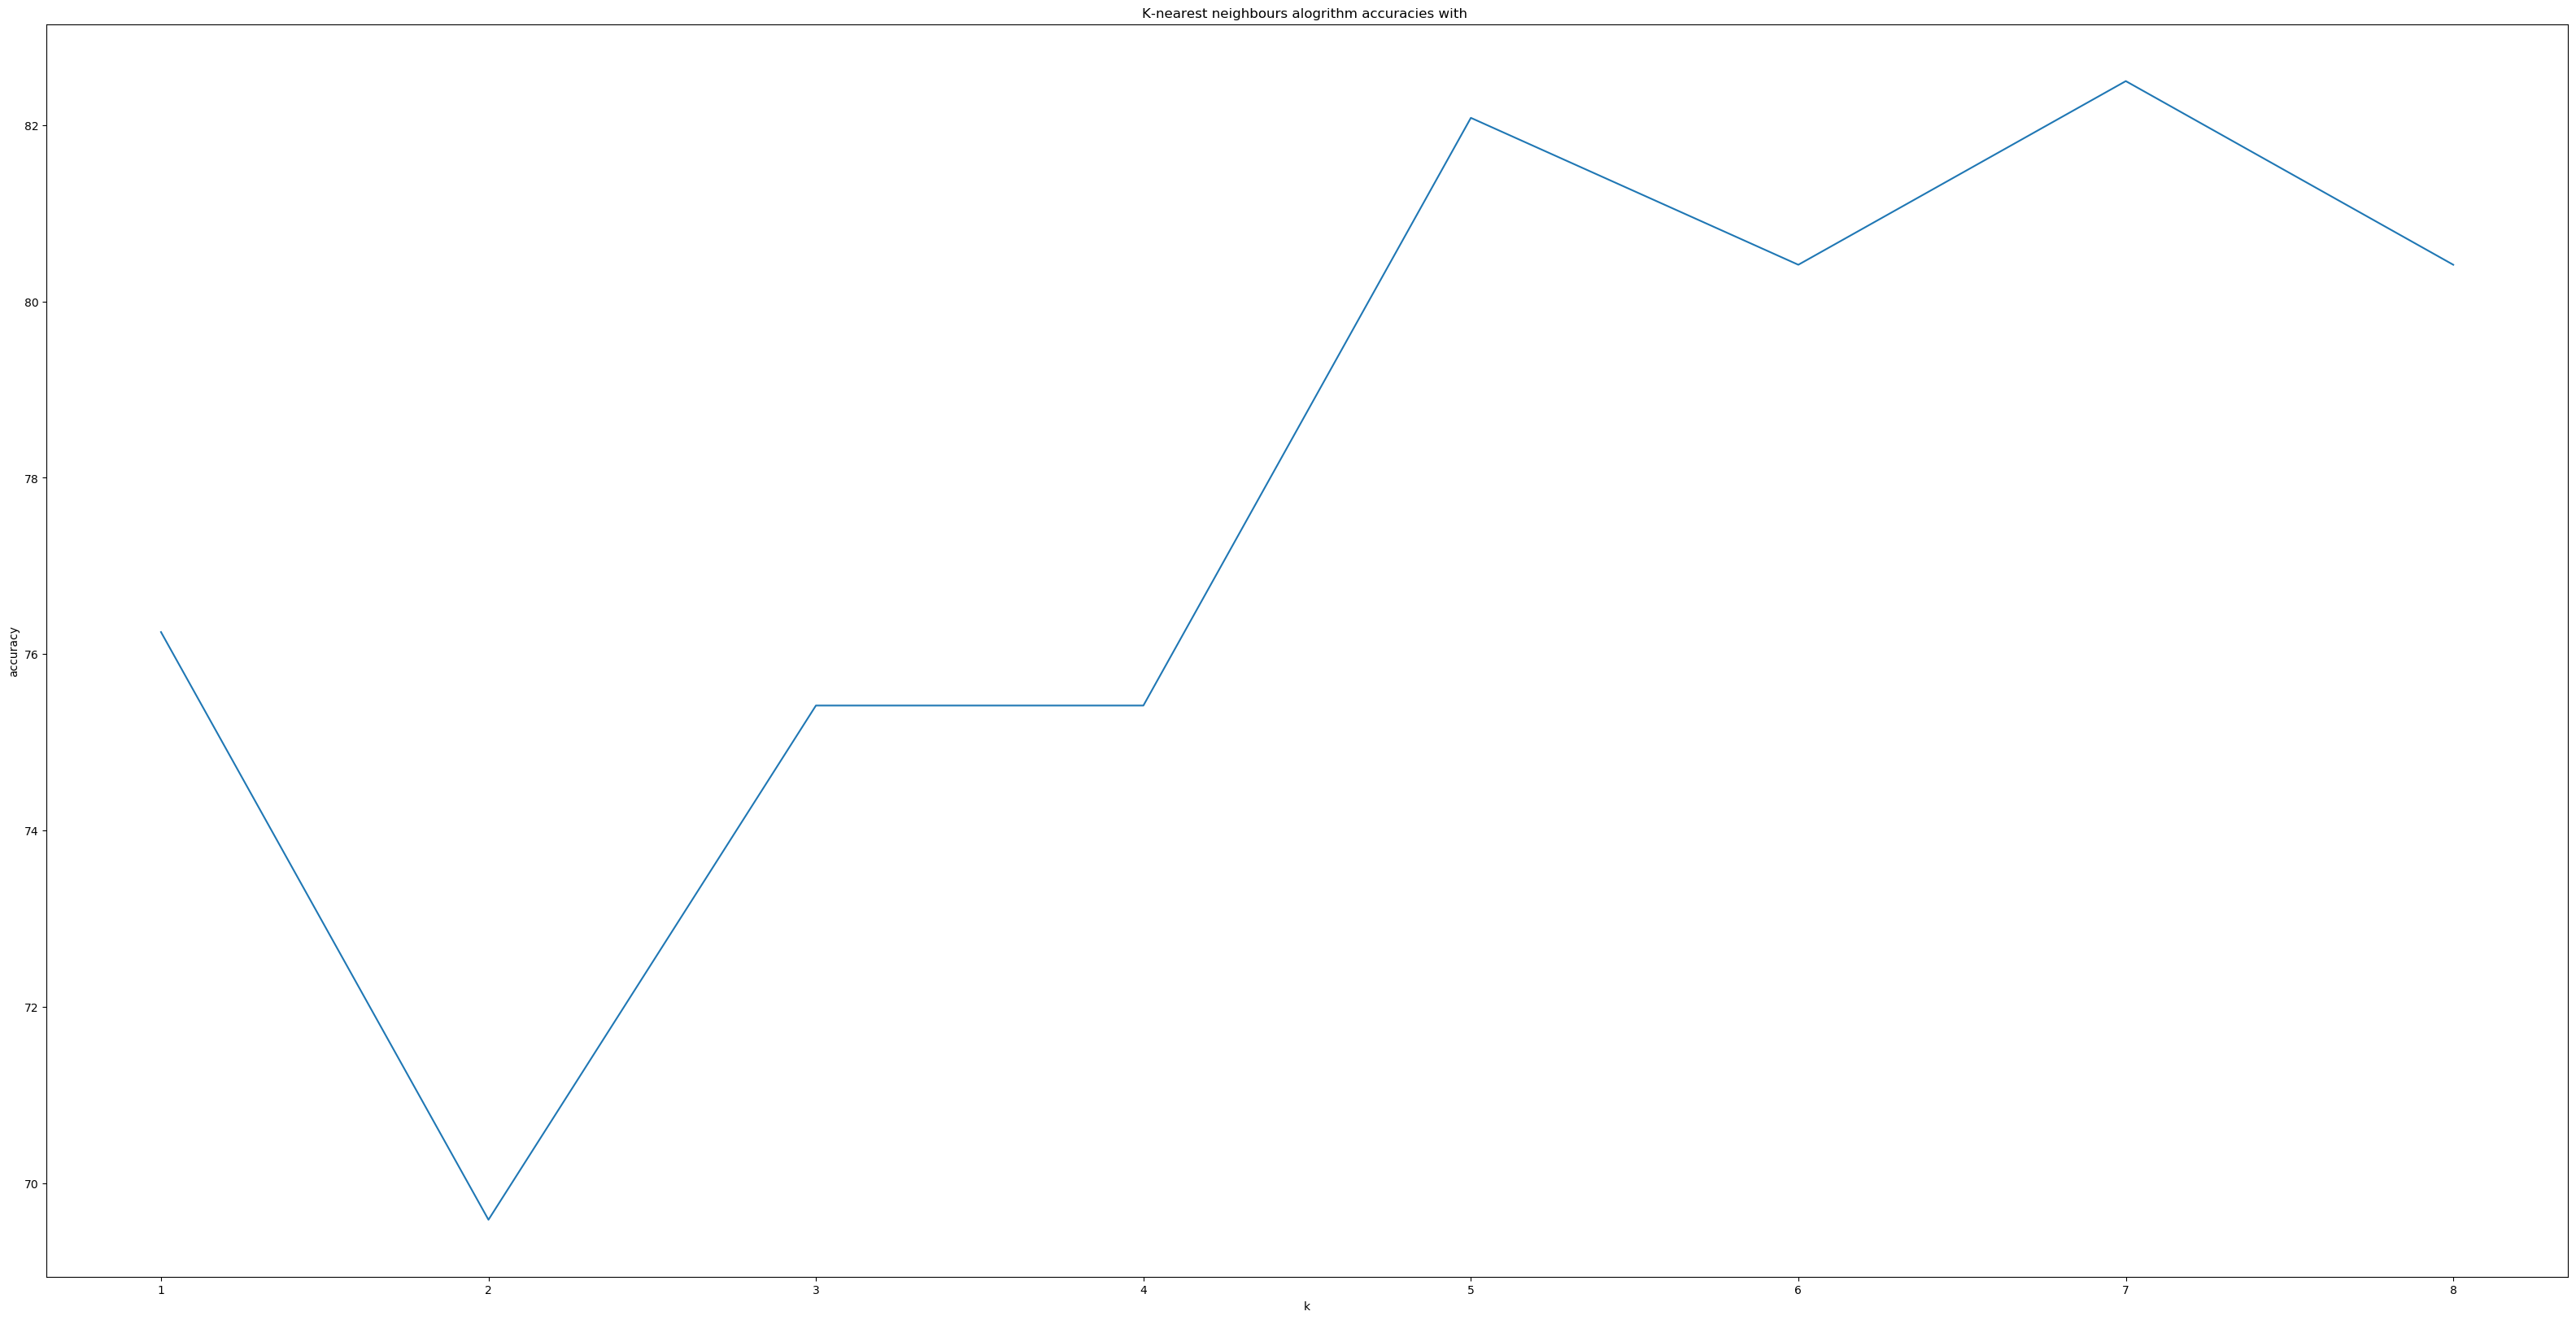

K-nearest neighbours algorithm accuracy: 82.5
0.9
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   2.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   3.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   2.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   2.8s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['en

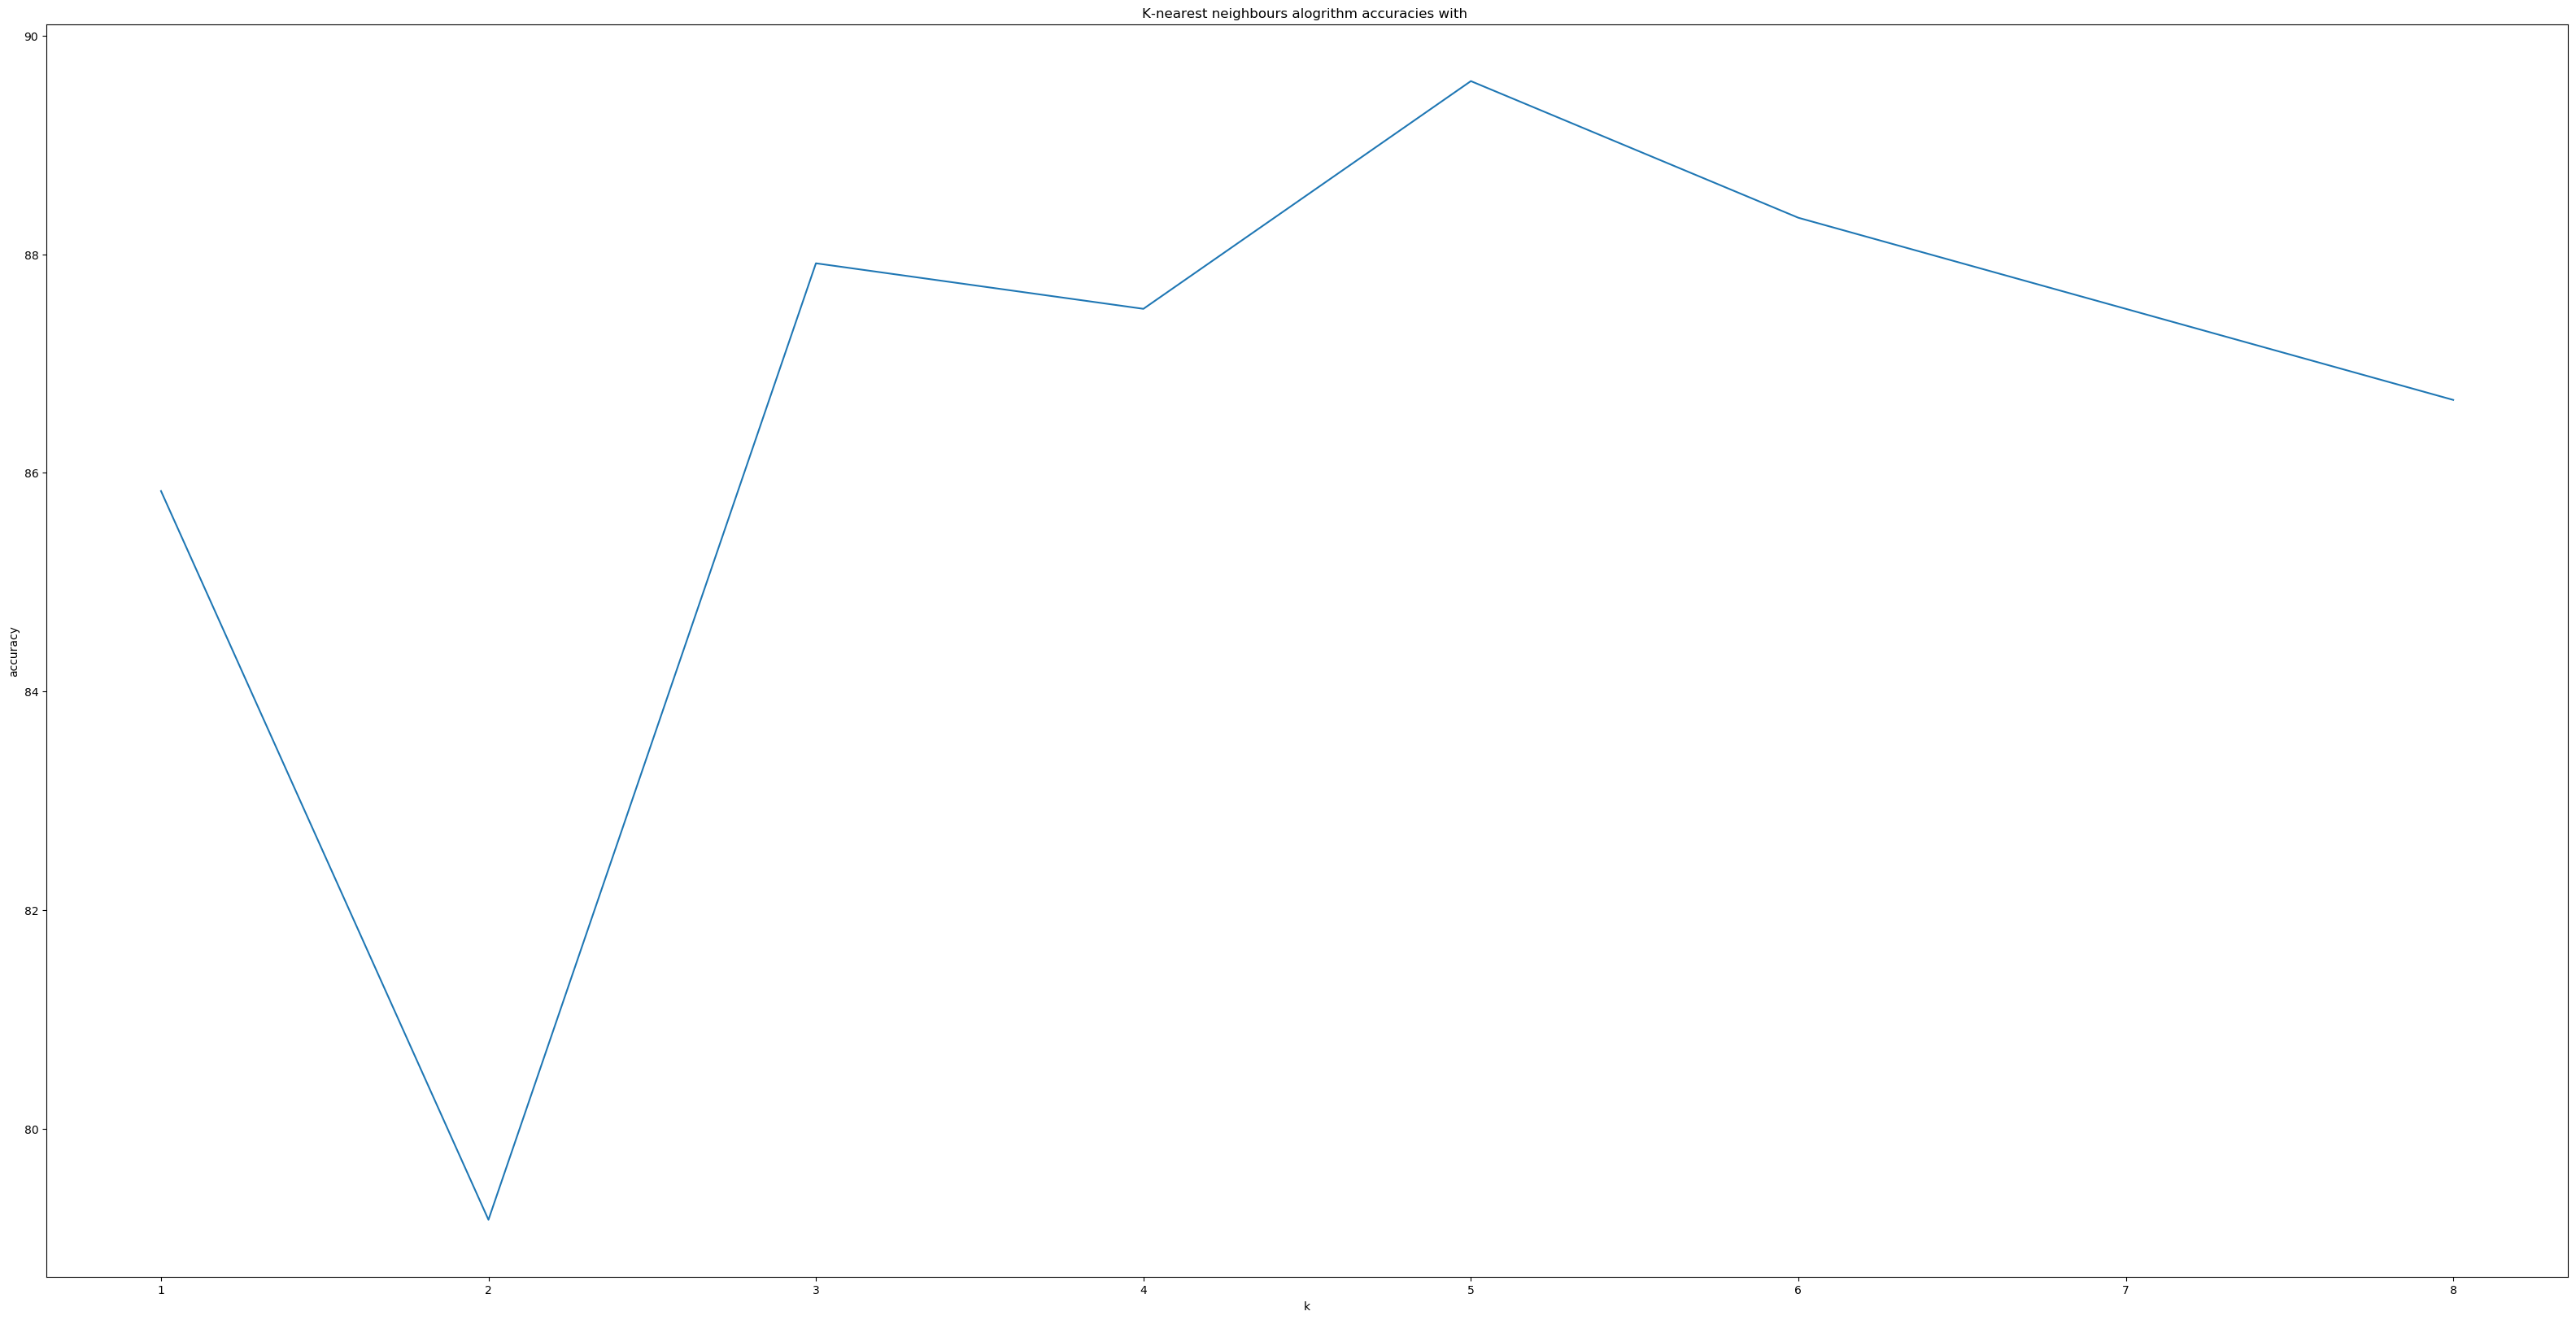

K-nearest neighbours algorithm accuracy: 89.58333333333334


In [374]:
partitions = [0.01,0.03, 0.05, 0.1, 0.2, 0.3,0.4, 0.5,0.6, 0.7,0.8, 0.9]
prediction_accs = []
pred_room_axxs = []
for labeled_percentage in partitions:
    print(labeled_percentage)
    partial_df, partial_locations, partial_df_rest, partial_rest_loc = prep_data_for_synthesis(alpha_filtered2_train, labeled_percentage)
    latent_data = encoder.predict(min_max_scaler.fit_transform(partial_df))
    latent_data = np.concatenate((latent_data[0], latent_data[2]), axis=1)
    latent_test_data = encoder.predict(min_max_scaler.fit_transform(partial_df_rest))
    latent_test_data = np.concatenate((latent_test_data[0], latent_test_data[2]), axis=1)
    
    rfc_semi2 = RandomForestClassifier()
    forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[10,12,15], 'max_features': [10,15,20]}]
    semi_clf2 = GridSearchCV(rfc_semi2, forest_semi_params,cv = [(slice(None), slice(None))], scoring='accuracy',refit=True,verbose=2)
    print(semi_clf2.fit(latent_data, partial_locations))
    unlabeled_data_labels = semi_clf2.predict(latent_test_data)
#     rfc_semi2 = RandomForestClassifier(criterion='entropy', max_depth=11, max_features=5)
#     print(rfc_semi2.fit(latent_data, partial_locations))
#     unlabeled_data_labels = rfc_semi2.predict(latent_test_data)
       
    frames = [partial_df, partial_df_rest]
    partial_combined = pd.concat(frames)
    
    frames = [partial_locations, pd.DataFrame(unlabeled_data_labels, columns = ['location'])]
    partial_combined_labels = pd.concat(frames)
    k_nearest_neighbours(partial_combined, partial_combined_labels, alpha_filtered2_test.loc[:, no_channel_training_cols],alpha_filtered2_test.loc[:, 'location'], "")
    partial_preds,runtime = run_knn(partial_combined, partial_combined_labels, alpha_filtered2_test.loc[:, no_channel_training_cols],[],5)
    
#     rfc_semi_part = RandomForestClassifier()
#     forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[10,12,15,20], 'max_features': [4,5,8]}]
#     semi_clf = GridSearchCV(rfc_semi_part, forest_semi_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
#     print(semi_clf.fit(partial_combined, partial_combined_labels))

#     partial_preds = semi_clf.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
    prediction_accs.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], partial_preds)*100)
    
    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
        
    room_lev_test_semi = []
    for i in partial_preds:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
    pred_room_axxs.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)
    

In [375]:
prediction_accs

[10.416666666666668,
 13.333333333333334,
 19.166666666666668,
 20.416666666666668,
 27.916666666666668,
 35.41666666666667,
 57.91666666666667,
 55.41666666666667,
 55.41666666666667,
 70.83333333333334,
 82.08333333333333,
 89.58333333333334]

In [376]:
def plot_accs(original_accs, vae_accs, title):
    t = list(original_accs.keys())
    k = list(original_accs.values())
    k.reverse()

    f = vae_accs
    f.reverse()
    print(k)
    print(f)
    signals = [{'name': 'original_accuracies', 'x': t,
             'y': k, 'color':'orange', 'linewidth':6},
            {'name': 'Semi-supervised_accuracies', 'x': t,
             'y': f, 'color':'green', 'linewidth':6}]

    fig, ax = plt.subplots()
    for signal in signals:
        ax.plot(signal['x'], signal['y'], 
                color=signal['color'], 
                linewidth=signal['linewidth'],
                label=signal['name'])
    plt.rcParams['figure.figsize'] = [40, 20]
    ax.legend()
    ax.set_title(title)
    plt.show()

[90.41666666666667, 87.08333333333333, 83.33333333333334, 78.75, 81.66666666666667, 81.66666666666667, 72.08333333333333, 60.416666666666664, 28.333333333333332, 5.0, 2.083333333333333, 2.083333333333333]
[89.58333333333334, 82.08333333333333, 70.83333333333334, 55.41666666666667, 55.41666666666667, 57.91666666666667, 35.41666666666667, 27.916666666666668, 20.416666666666668, 19.166666666666668, 13.333333333333334, 10.416666666666668]


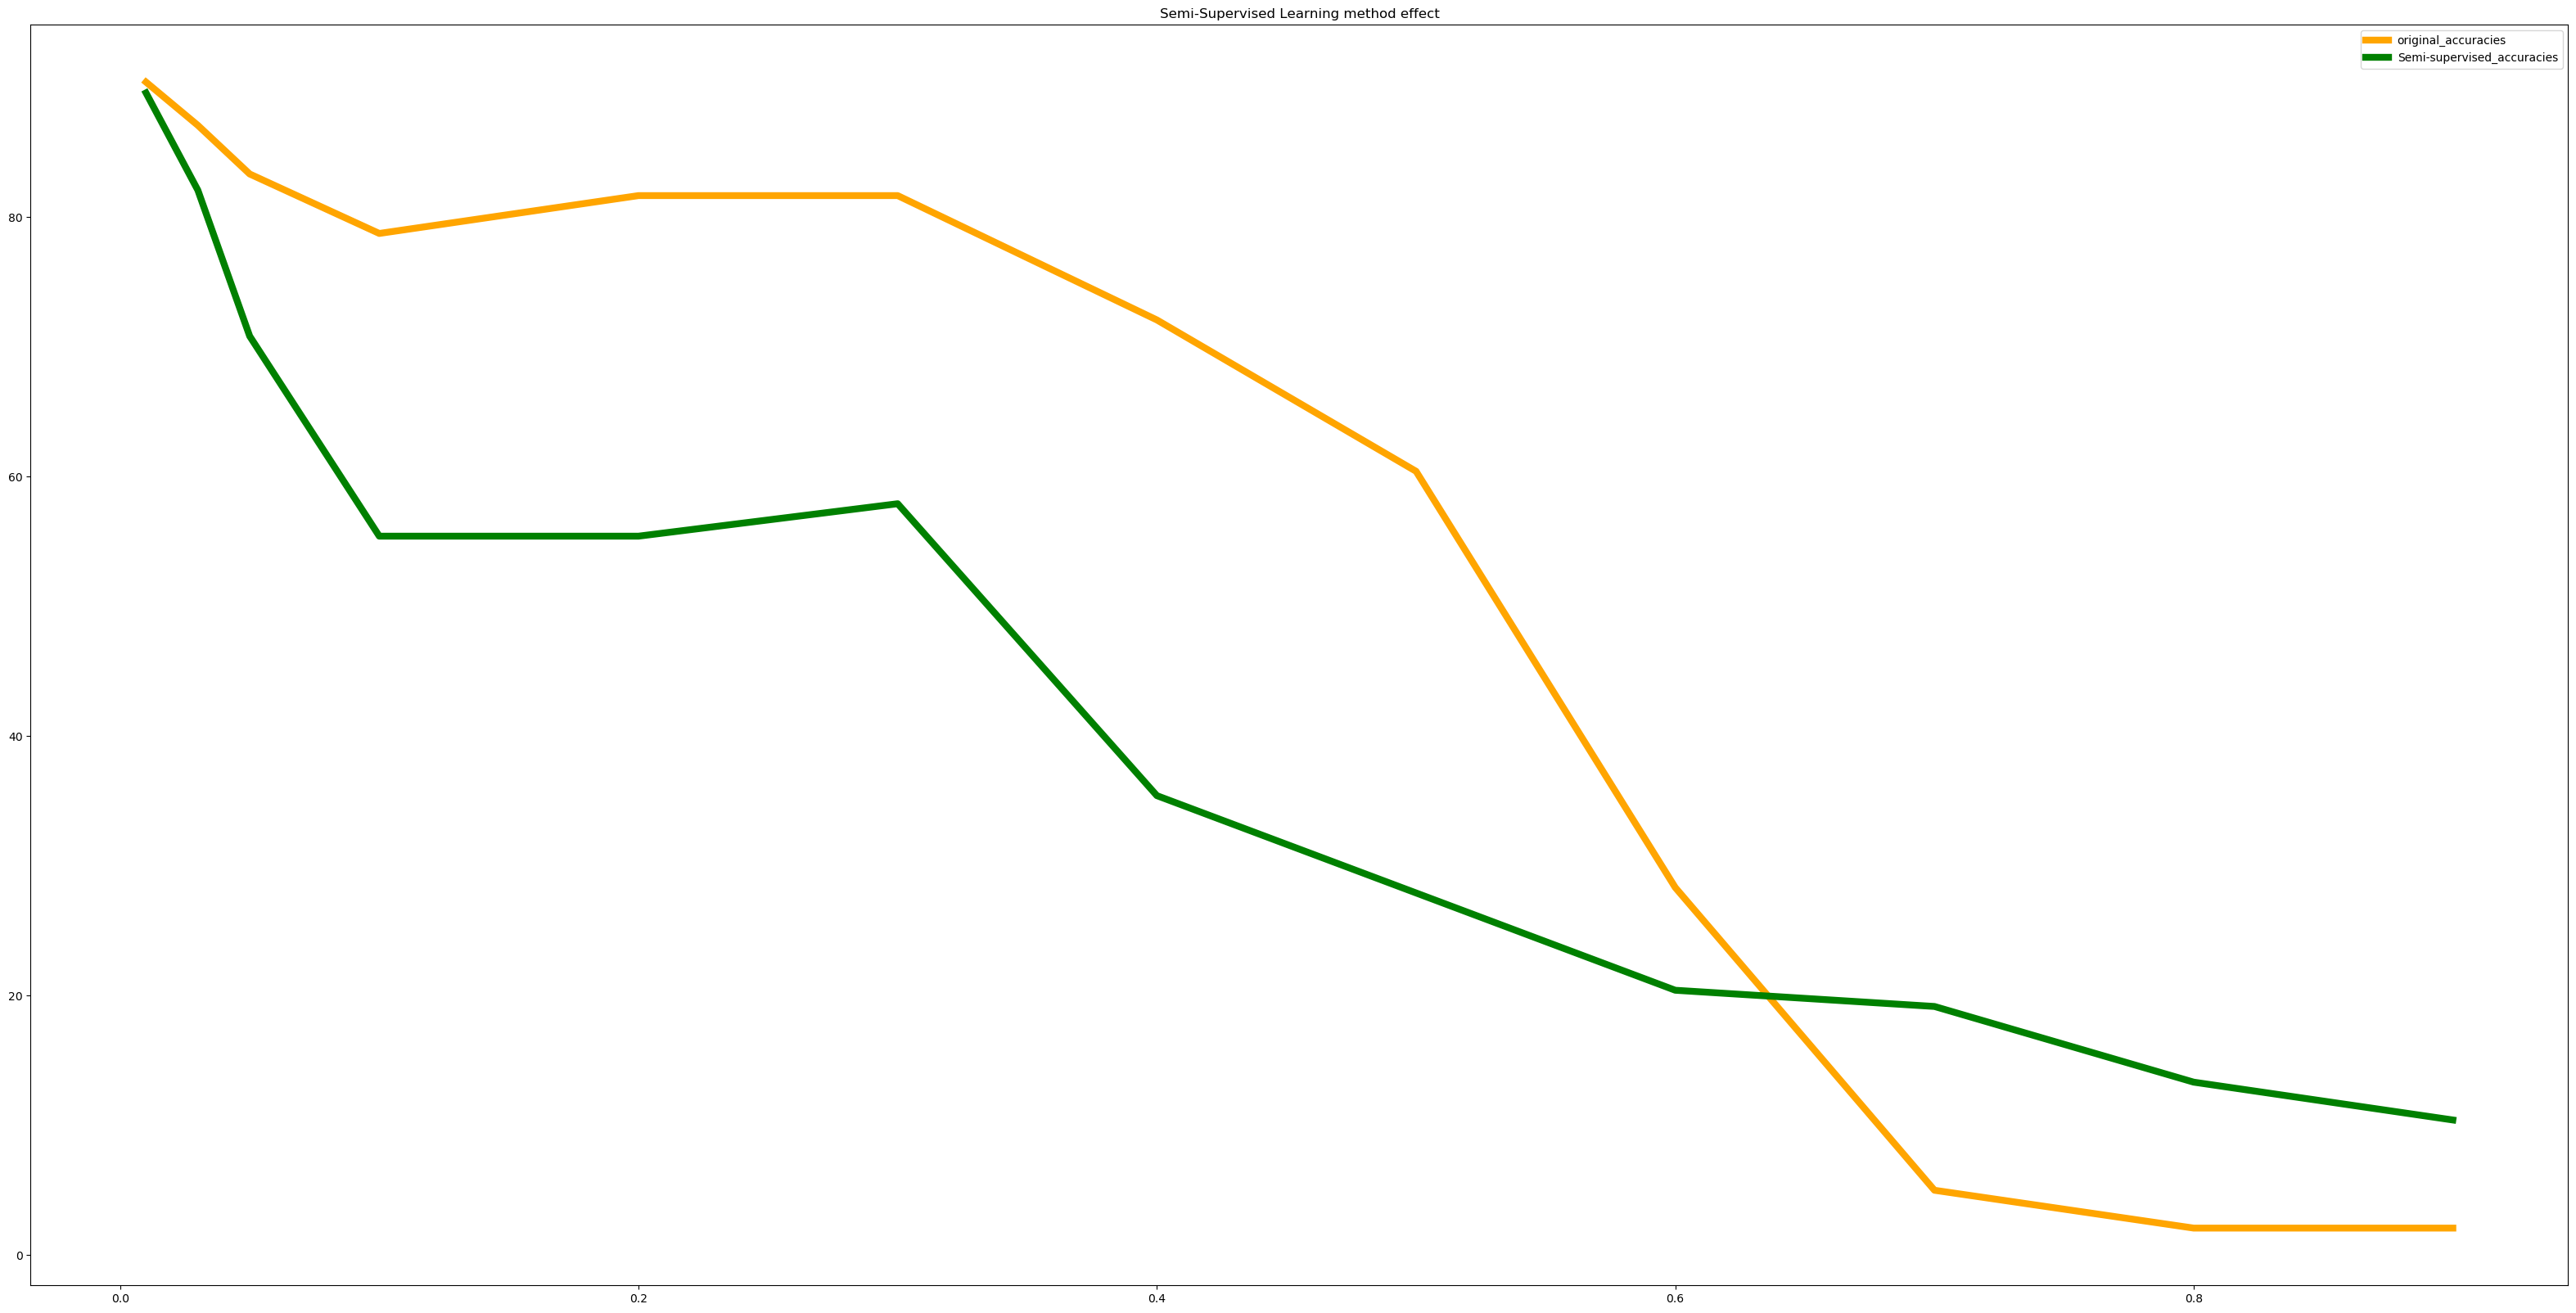

In [377]:
plot_accs(original_accs2, prediction_accs,"Semi-Supervised Learning method effect")

[99.16666666666667, 99.16666666666667, 99.16666666666667, 98.33333333333333, 99.16666666666667, 99.16666666666667, 98.33333333333333, 92.08333333333333, 86.66666666666667, 55.41666666666667, 44.583333333333336, 20.416666666666668]
[99.58333333333333, 97.5, 99.16666666666667, 97.5, 91.66666666666666, 92.08333333333333, 87.5, 80.0, 69.58333333333333, 72.08333333333333, 74.58333333333333, 60.416666666666664]


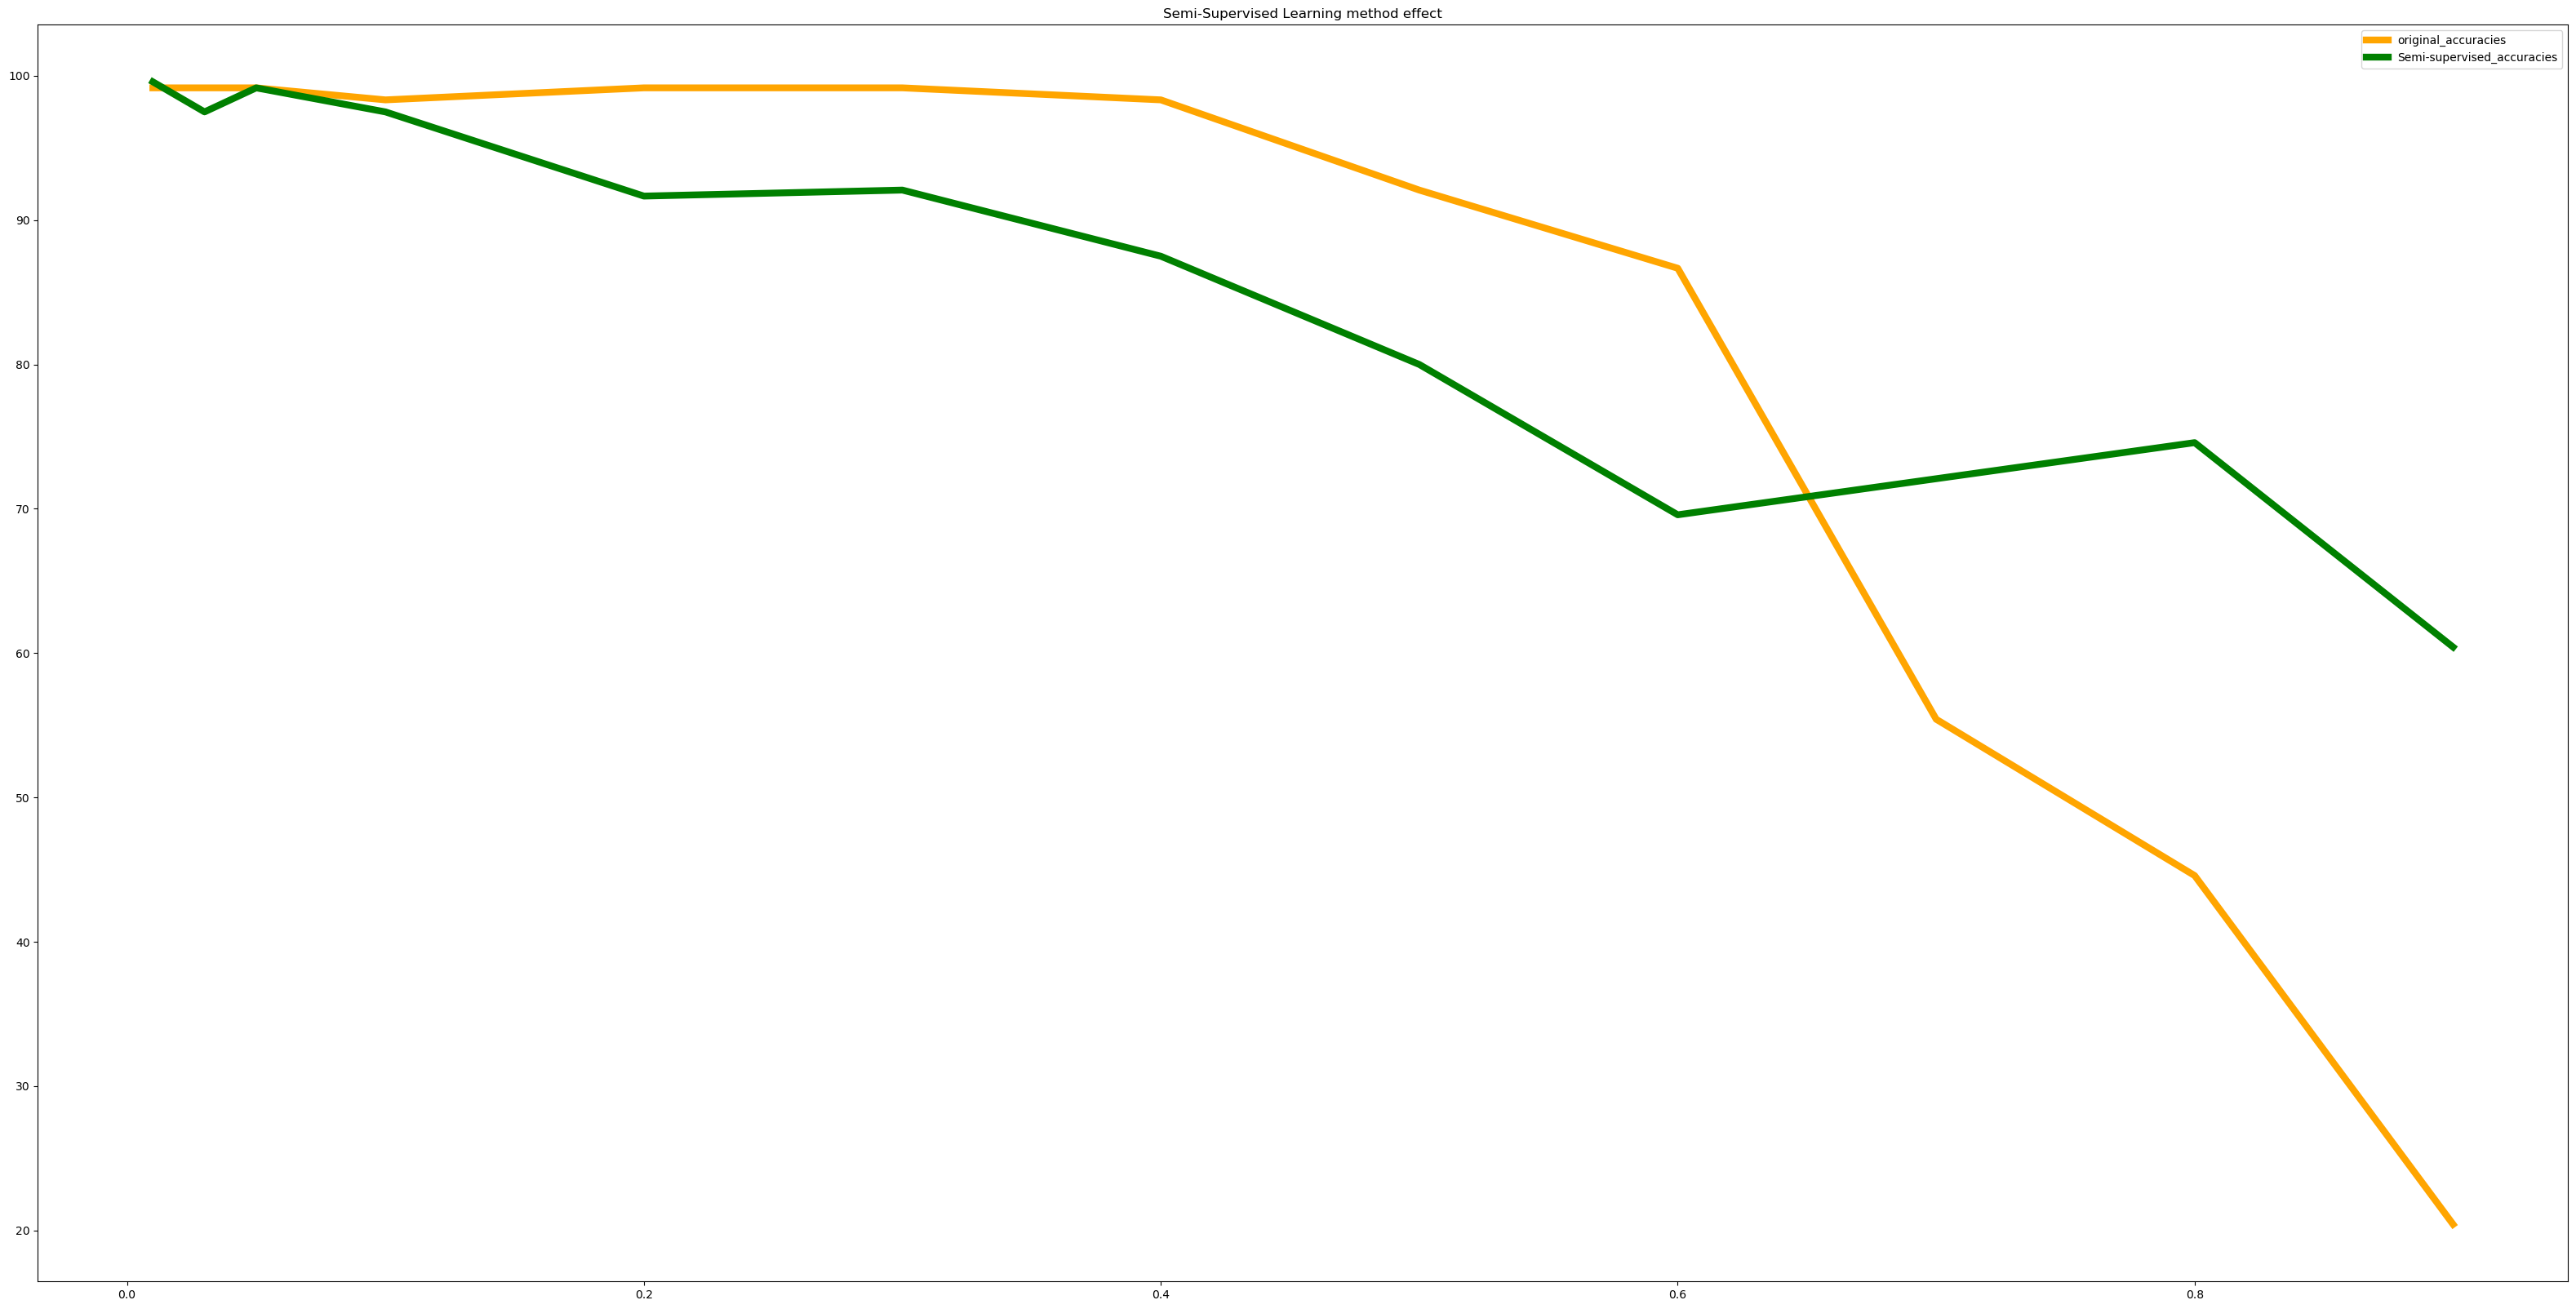

In [378]:
plot_accs(r_accs2, pred_room_axxs,"Semi-Supervised Learning method effect")

## Using Synthesized Data

In [379]:
one_ten_df, one_ten_locations, one_ten_df_test, one_ten__test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.2)


In [380]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(18, activation ='relu')(input_layer)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
    
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(18, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
decoder = keras.models.Model(decoder_input, outputs)
x_prime = decoder(z)
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
print(vae.summary())



Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        (None, 20)                0         
_________________________________________________________________
model_67 (Model)             [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_68 (Model)             (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None


In [381]:
his2 = vae.fit(min_max_scaler.fit_transform(one_ten_df), min_max_scaler.fit_transform(one_ten_df) , epochs = 100, batch_size = 32, validation_split= 0.2)


Train on 153 samples, validate on 39 samples
Epoch 1/100
153/153 [==============================] - 2s 14ms/step - loss: 14.1102 - accuracy: 0.0654 - val_loss: 14.4932 - val_accuracy: 0.0000e+00
Epoch 2/100
153/153 [==============================] - 0s 234us/step - loss: 13.8778 - accuracy: 0.1699 - val_loss: 14.1665 - val_accuracy: 0.0000e+00
Epoch 3/100
153/153 [==============================] - 0s 277us/step - loss: 13.6904 - accuracy: 0.2026 - val_loss: 13.9328 - val_accuracy: 0.0000e+00
Epoch 4/100
153/153 [==============================] - 0s 247us/step - loss: 13.5194 - accuracy: 0.2092 - val_loss: 13.7677 - val_accuracy: 0.0000e+00
Epoch 5/100
153/153 [==============================] - 0s 243us/step - loss: 13.3443 - accuracy: 0.2092 - val_loss: 13.6850 - val_accuracy: 0.0000e+00
Epoch 6/100
153/153 [==============================] - 0s 232us/step - loss: 13.1042 - accuracy: 0.2092 - val_loss: 13.4878 - val_accuracy: 0.0000e+00
Epoch 7/100
153/153 [=============================

Epoch 56/100
153/153 [==============================] - 0s 199us/step - loss: 4.1350 - accuracy: 0.4314 - val_loss: 6.8350 - val_accuracy: 0.6667
Epoch 57/100
153/153 [==============================] - 0s 176us/step - loss: 4.1147 - accuracy: 0.4052 - val_loss: 6.7304 - val_accuracy: 0.6667
Epoch 58/100
153/153 [==============================] - 0s 188us/step - loss: 4.0596 - accuracy: 0.4444 - val_loss: 6.6603 - val_accuracy: 0.6667
Epoch 59/100
153/153 [==============================] - 0s 193us/step - loss: 4.0481 - accuracy: 0.4379 - val_loss: 6.6760 - val_accuracy: 0.6667
Epoch 60/100
153/153 [==============================] - 0s 196us/step - loss: 4.0302 - accuracy: 0.4575 - val_loss: 6.7144 - val_accuracy: 0.6667
Epoch 61/100
153/153 [==============================] - 0s 181us/step - loss: 4.0223 - accuracy: 0.5033 - val_loss: 6.5971 - val_accuracy: 0.6667
Epoch 62/100
153/153 [==============================] - 0s 183us/step - loss: 4.0129 - accuracy: 0.4902 - val_loss: 6.5332 -

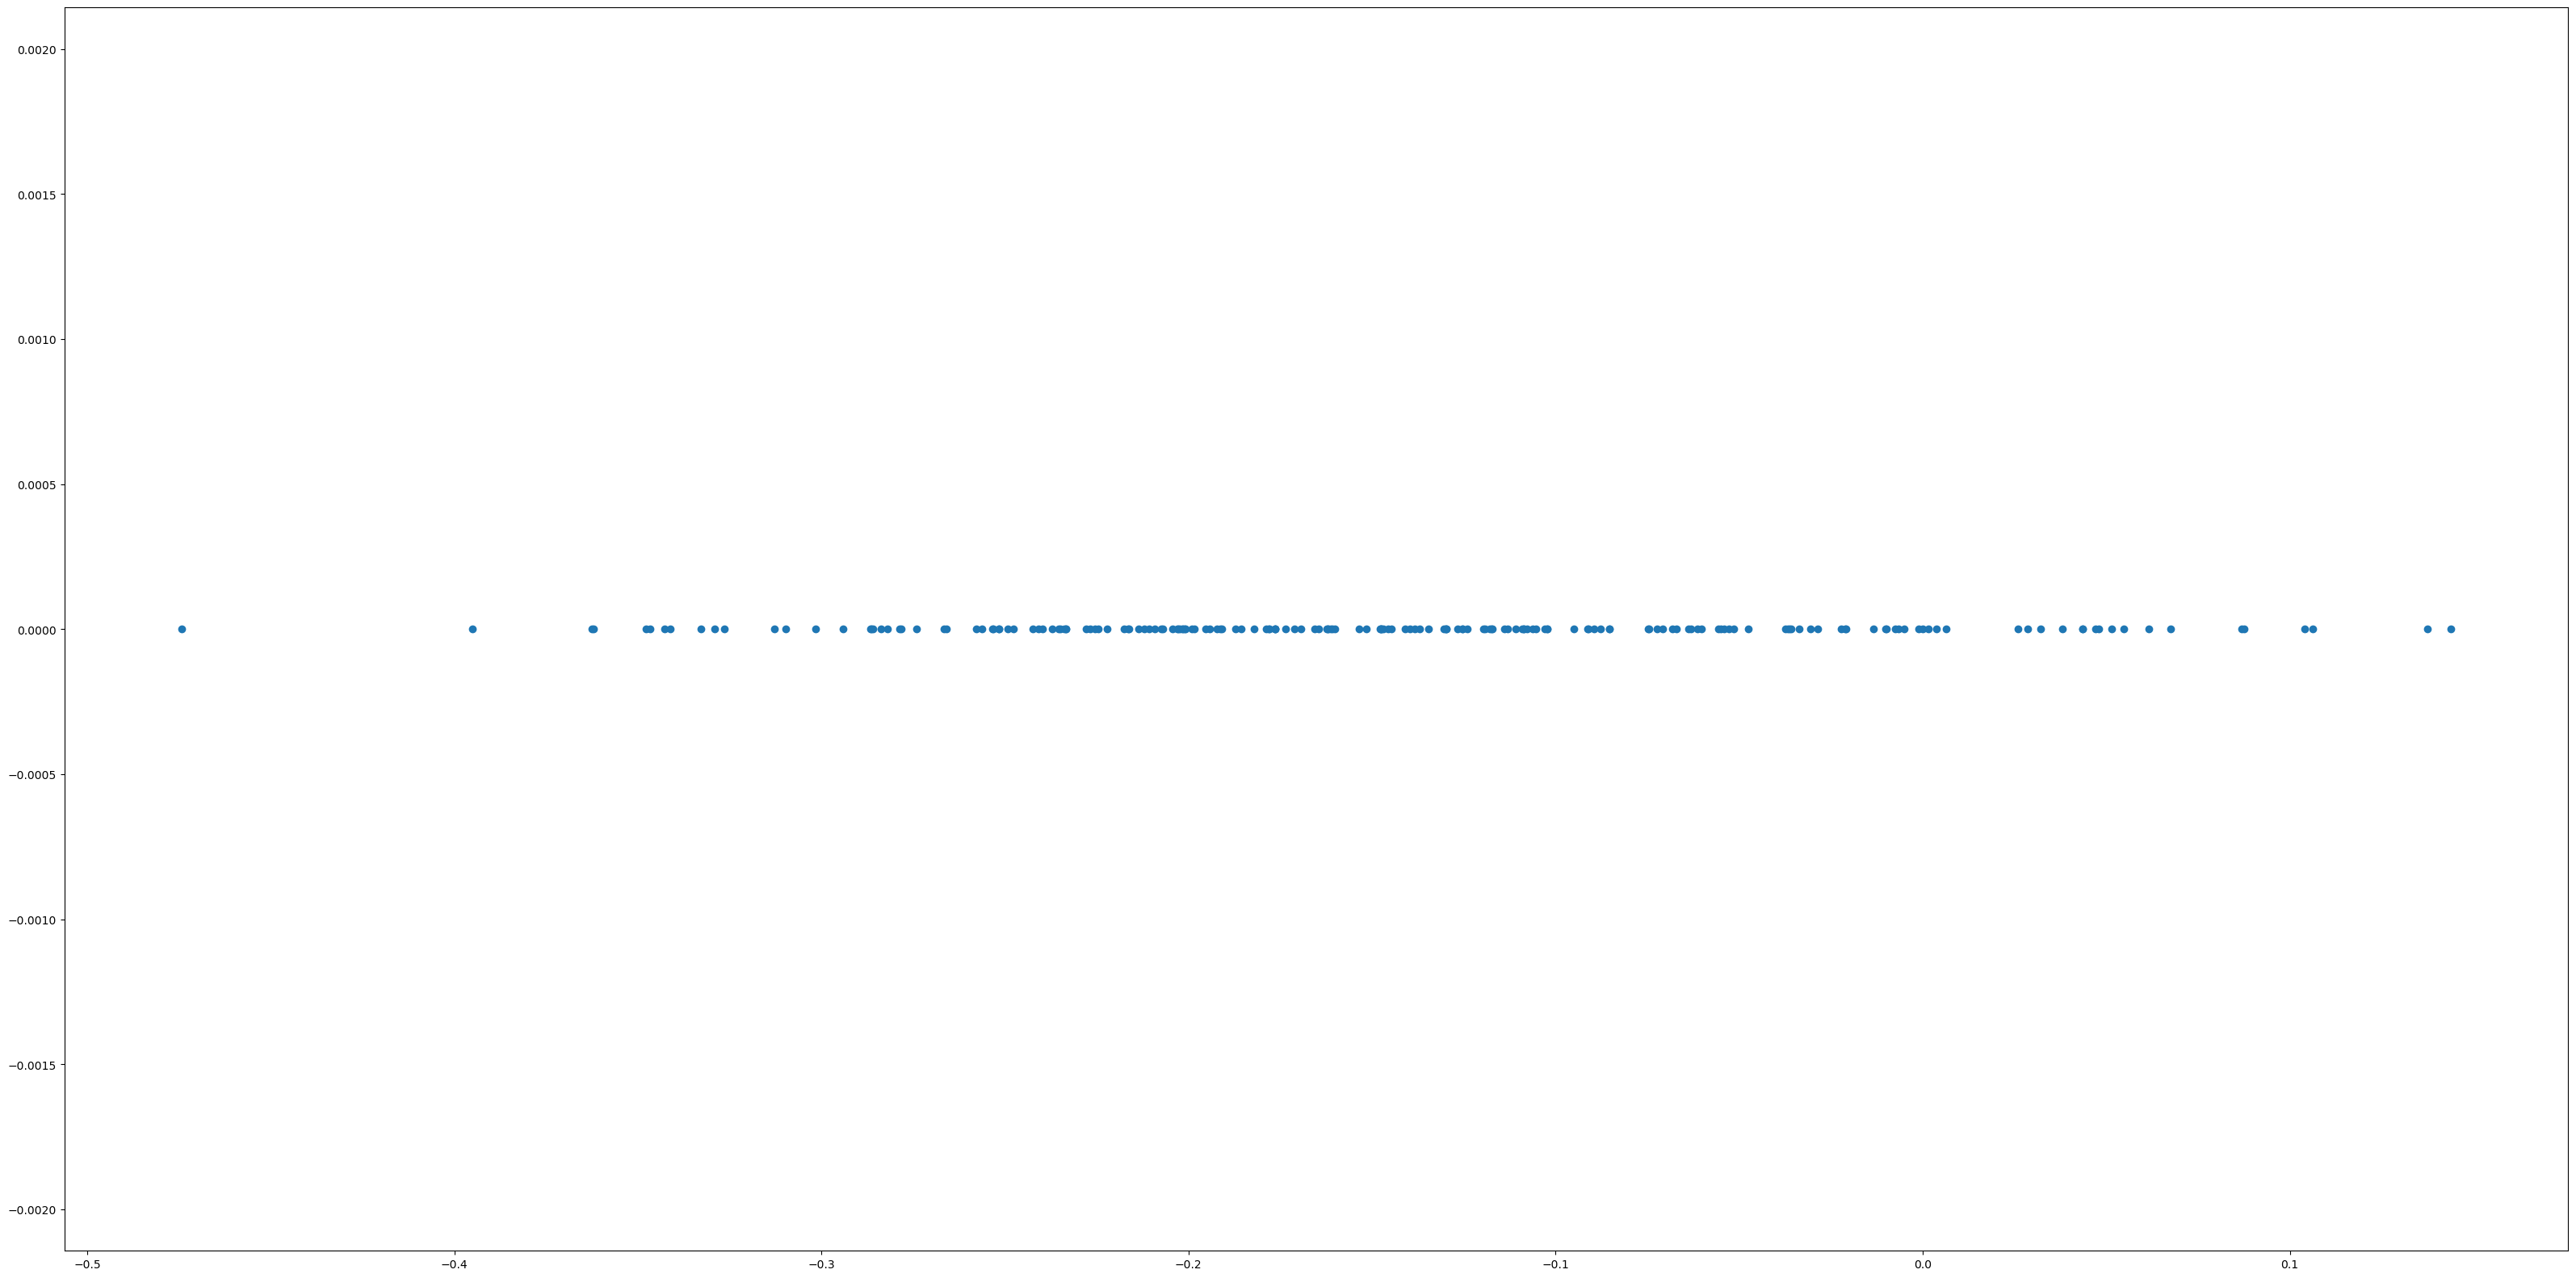

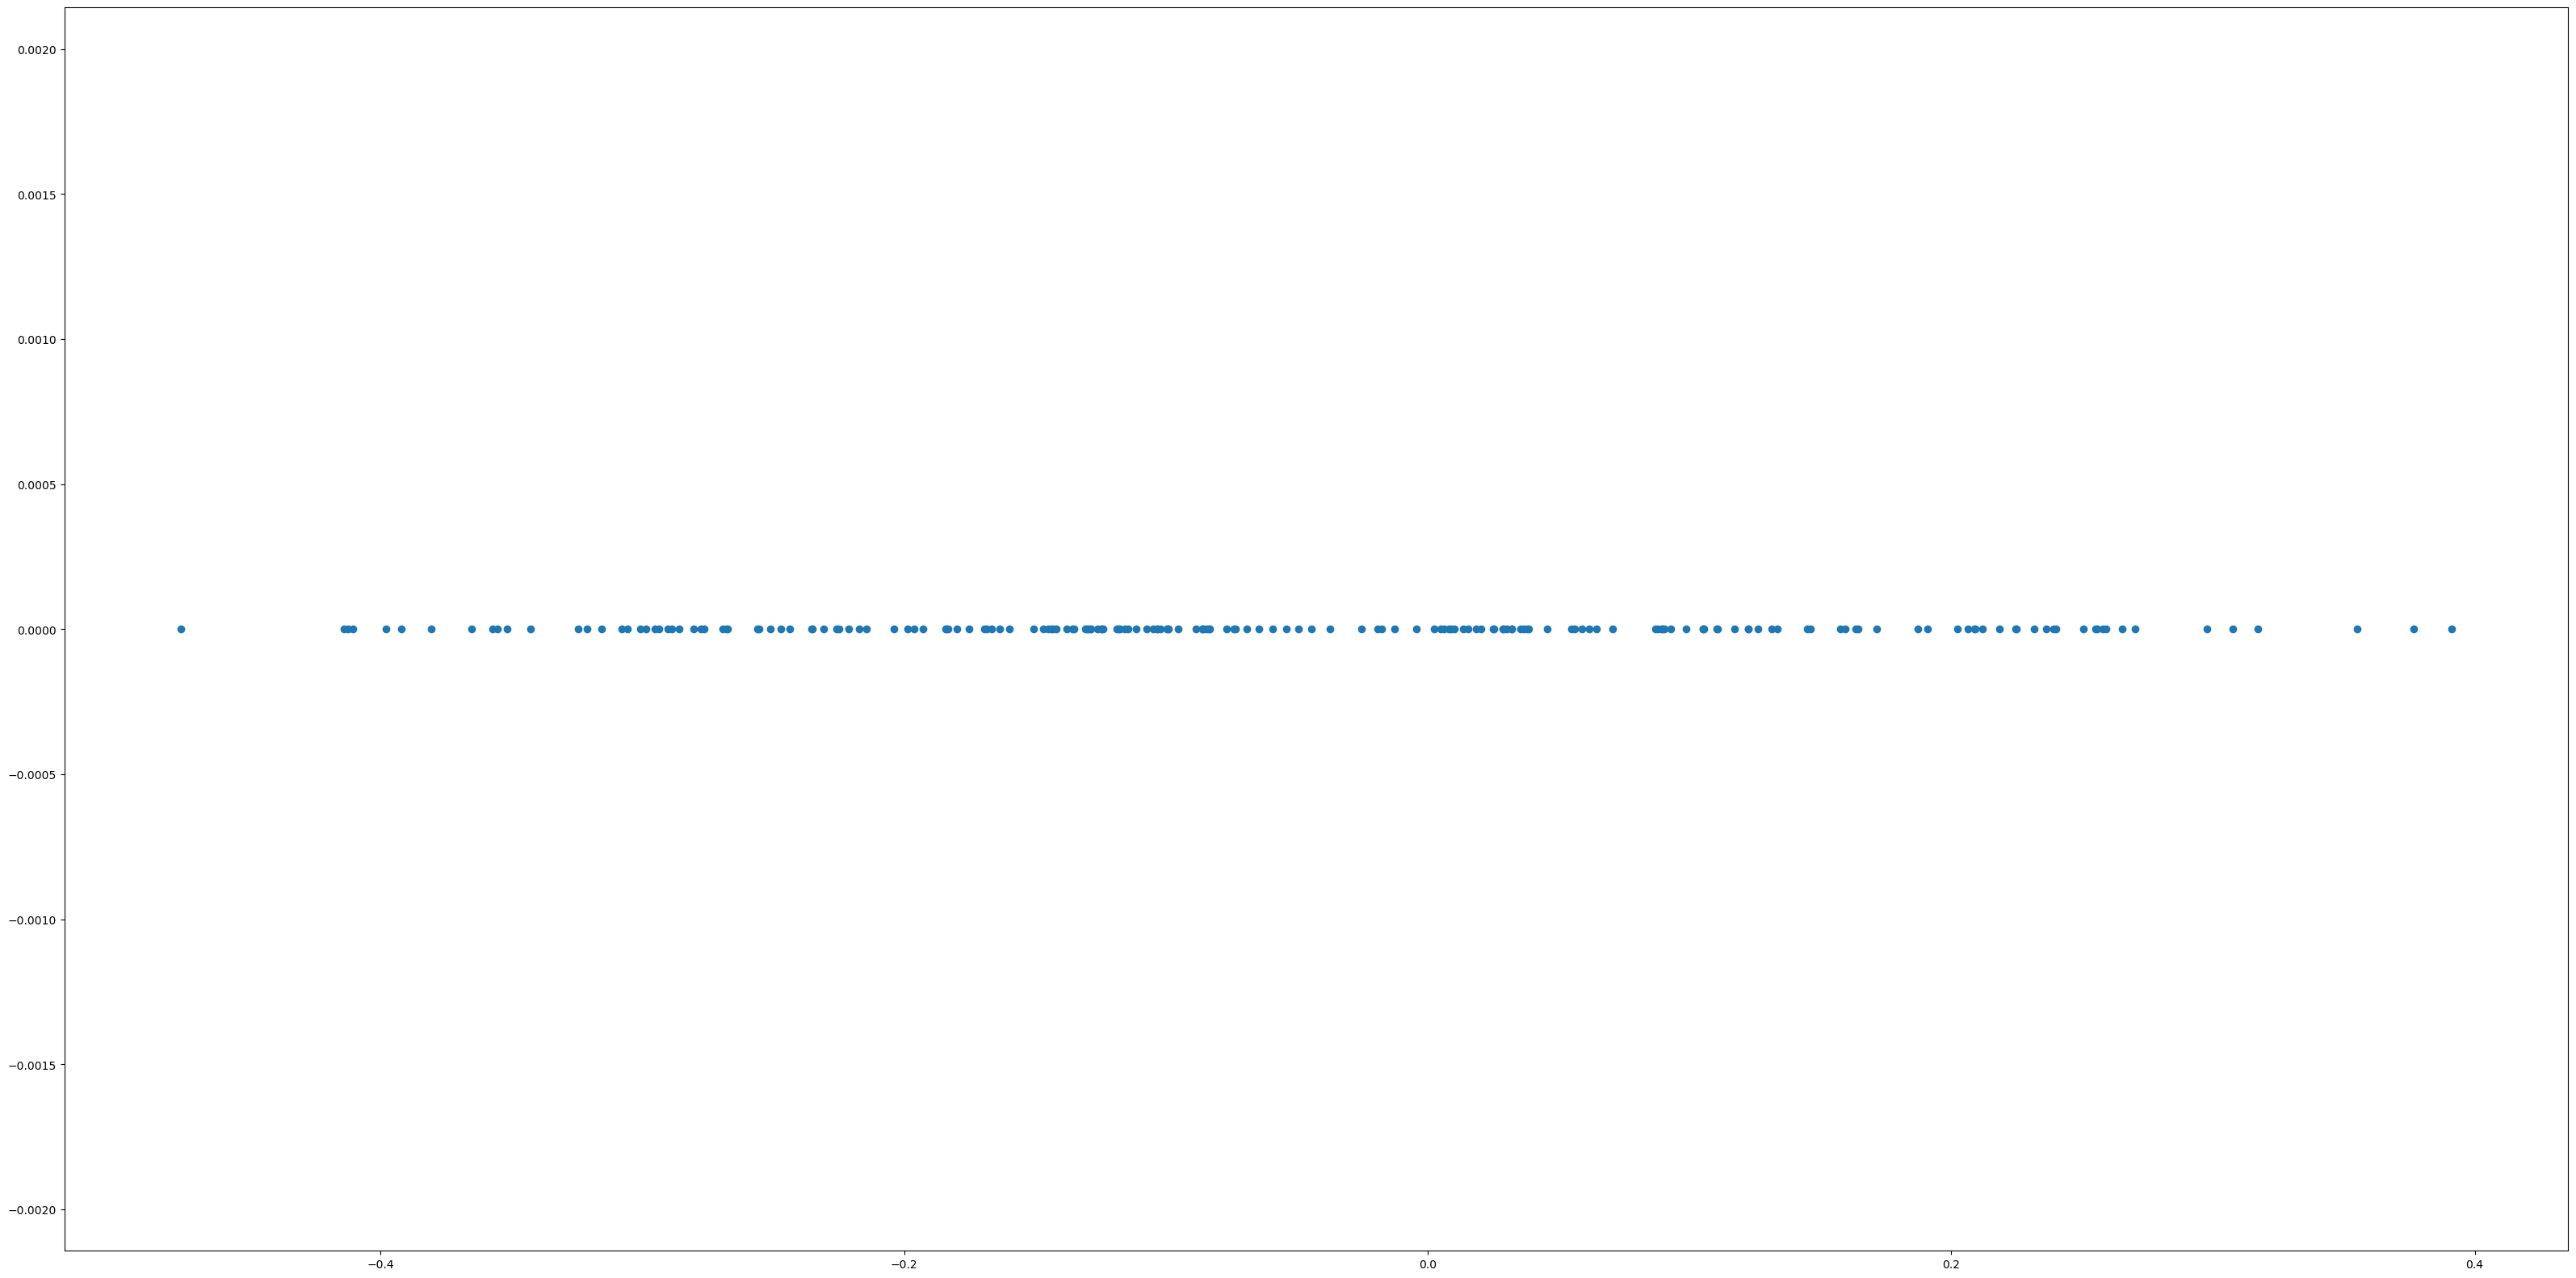

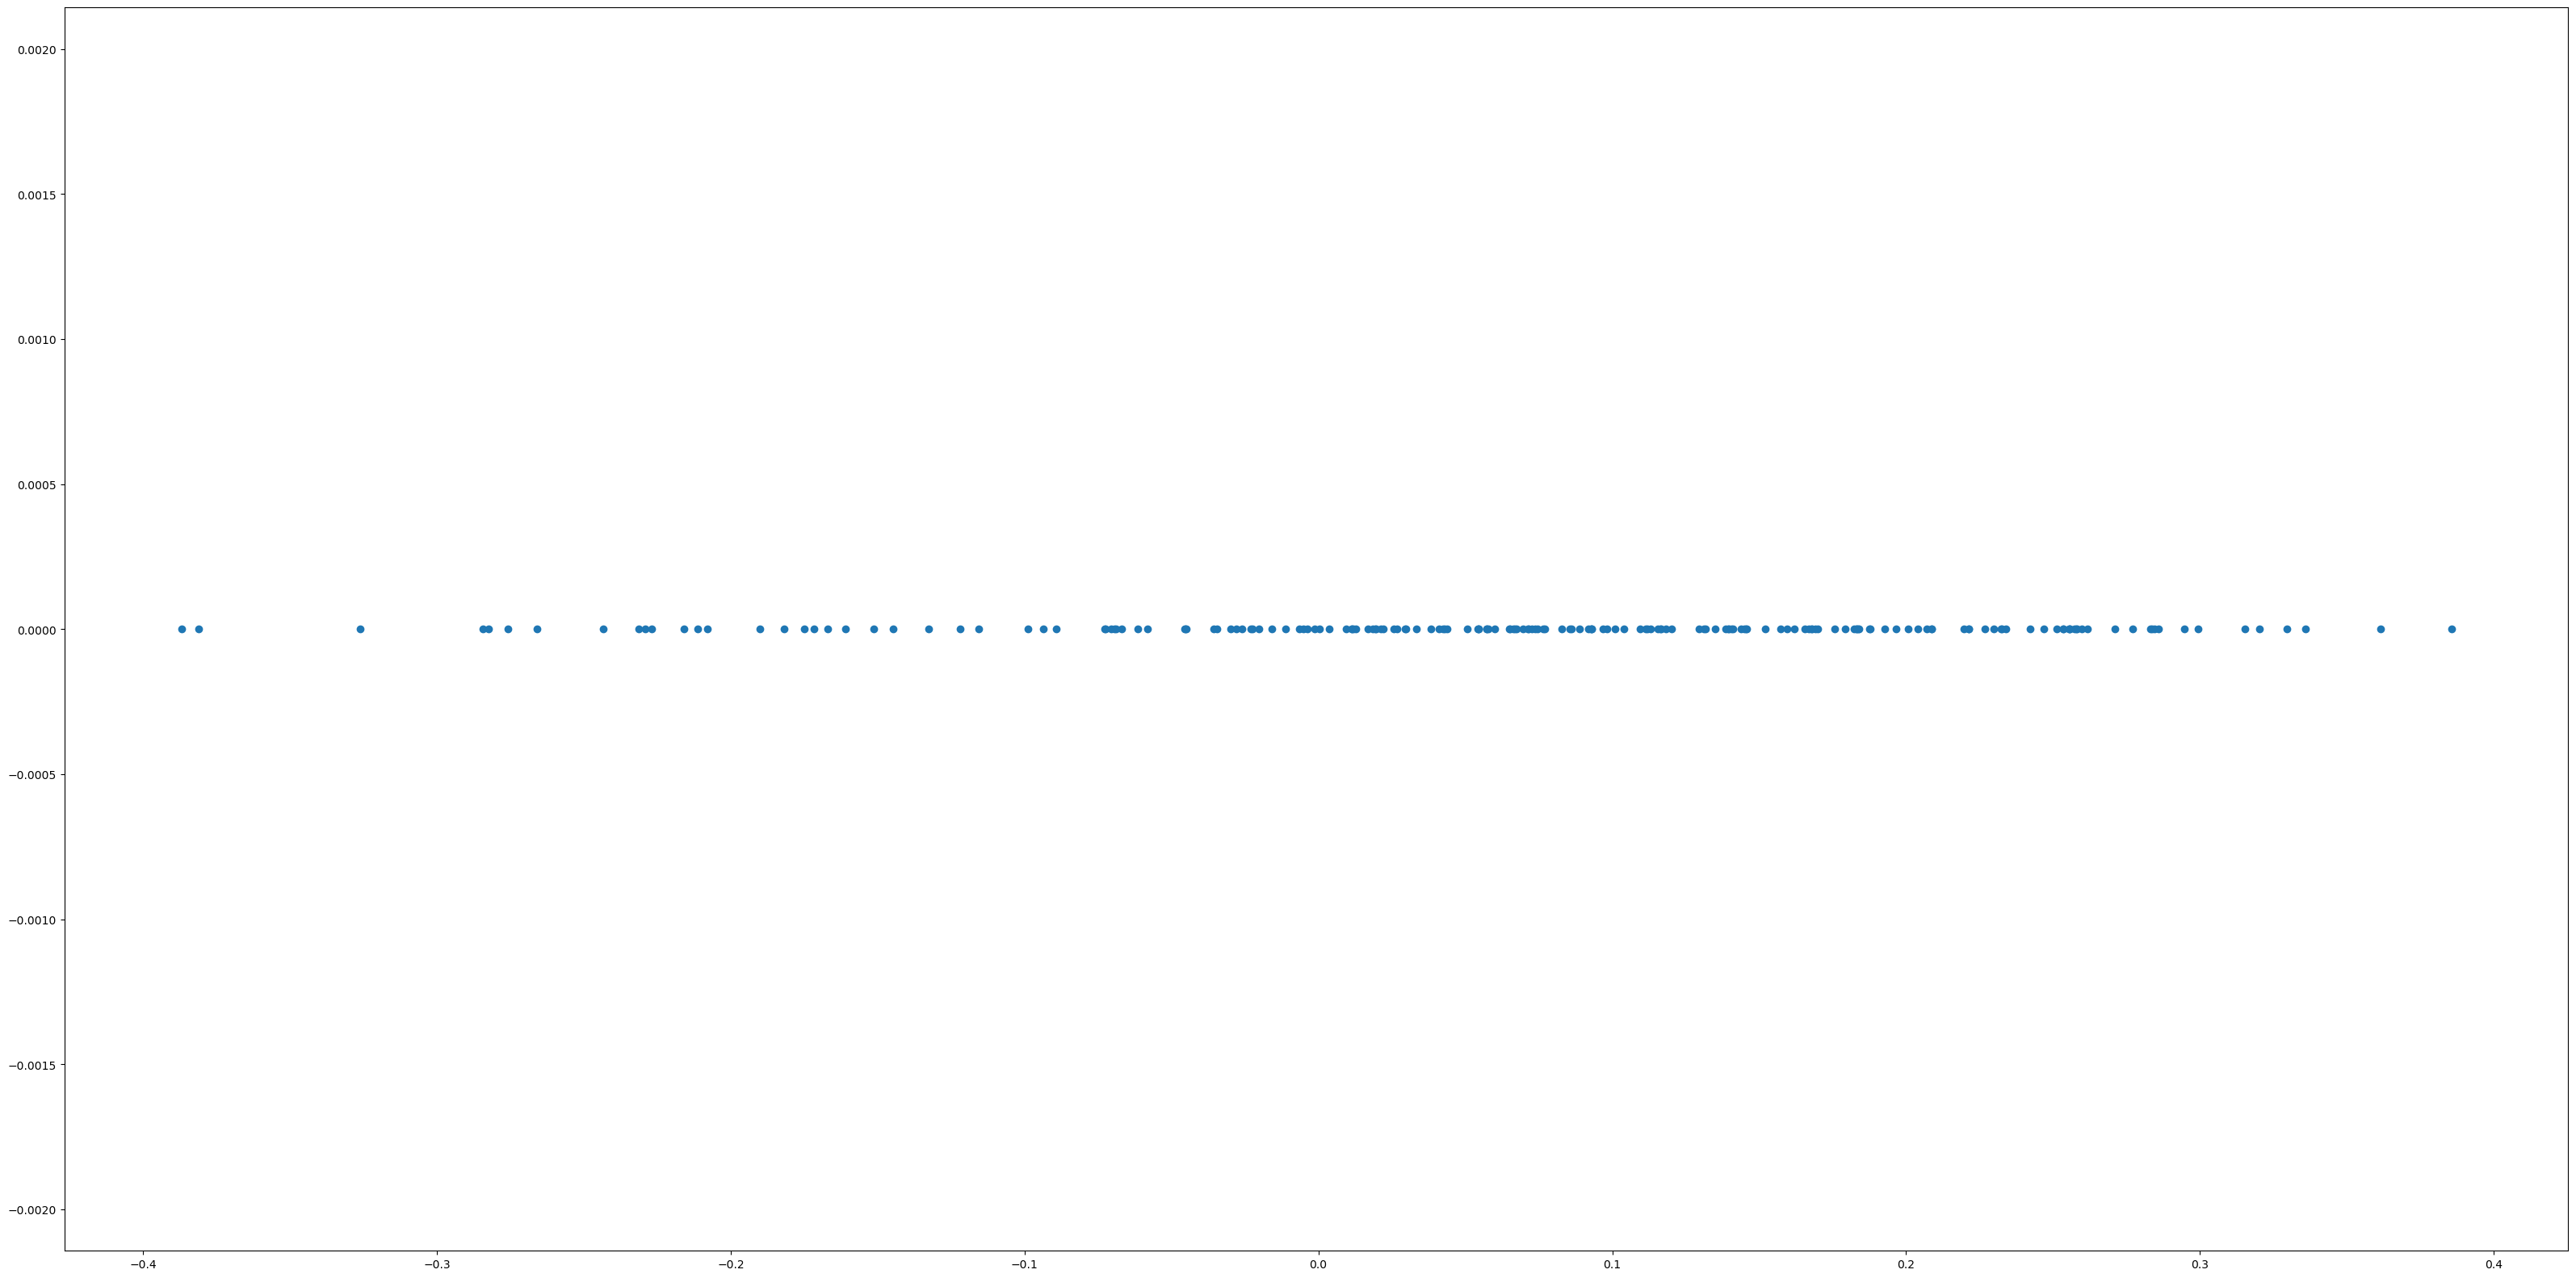

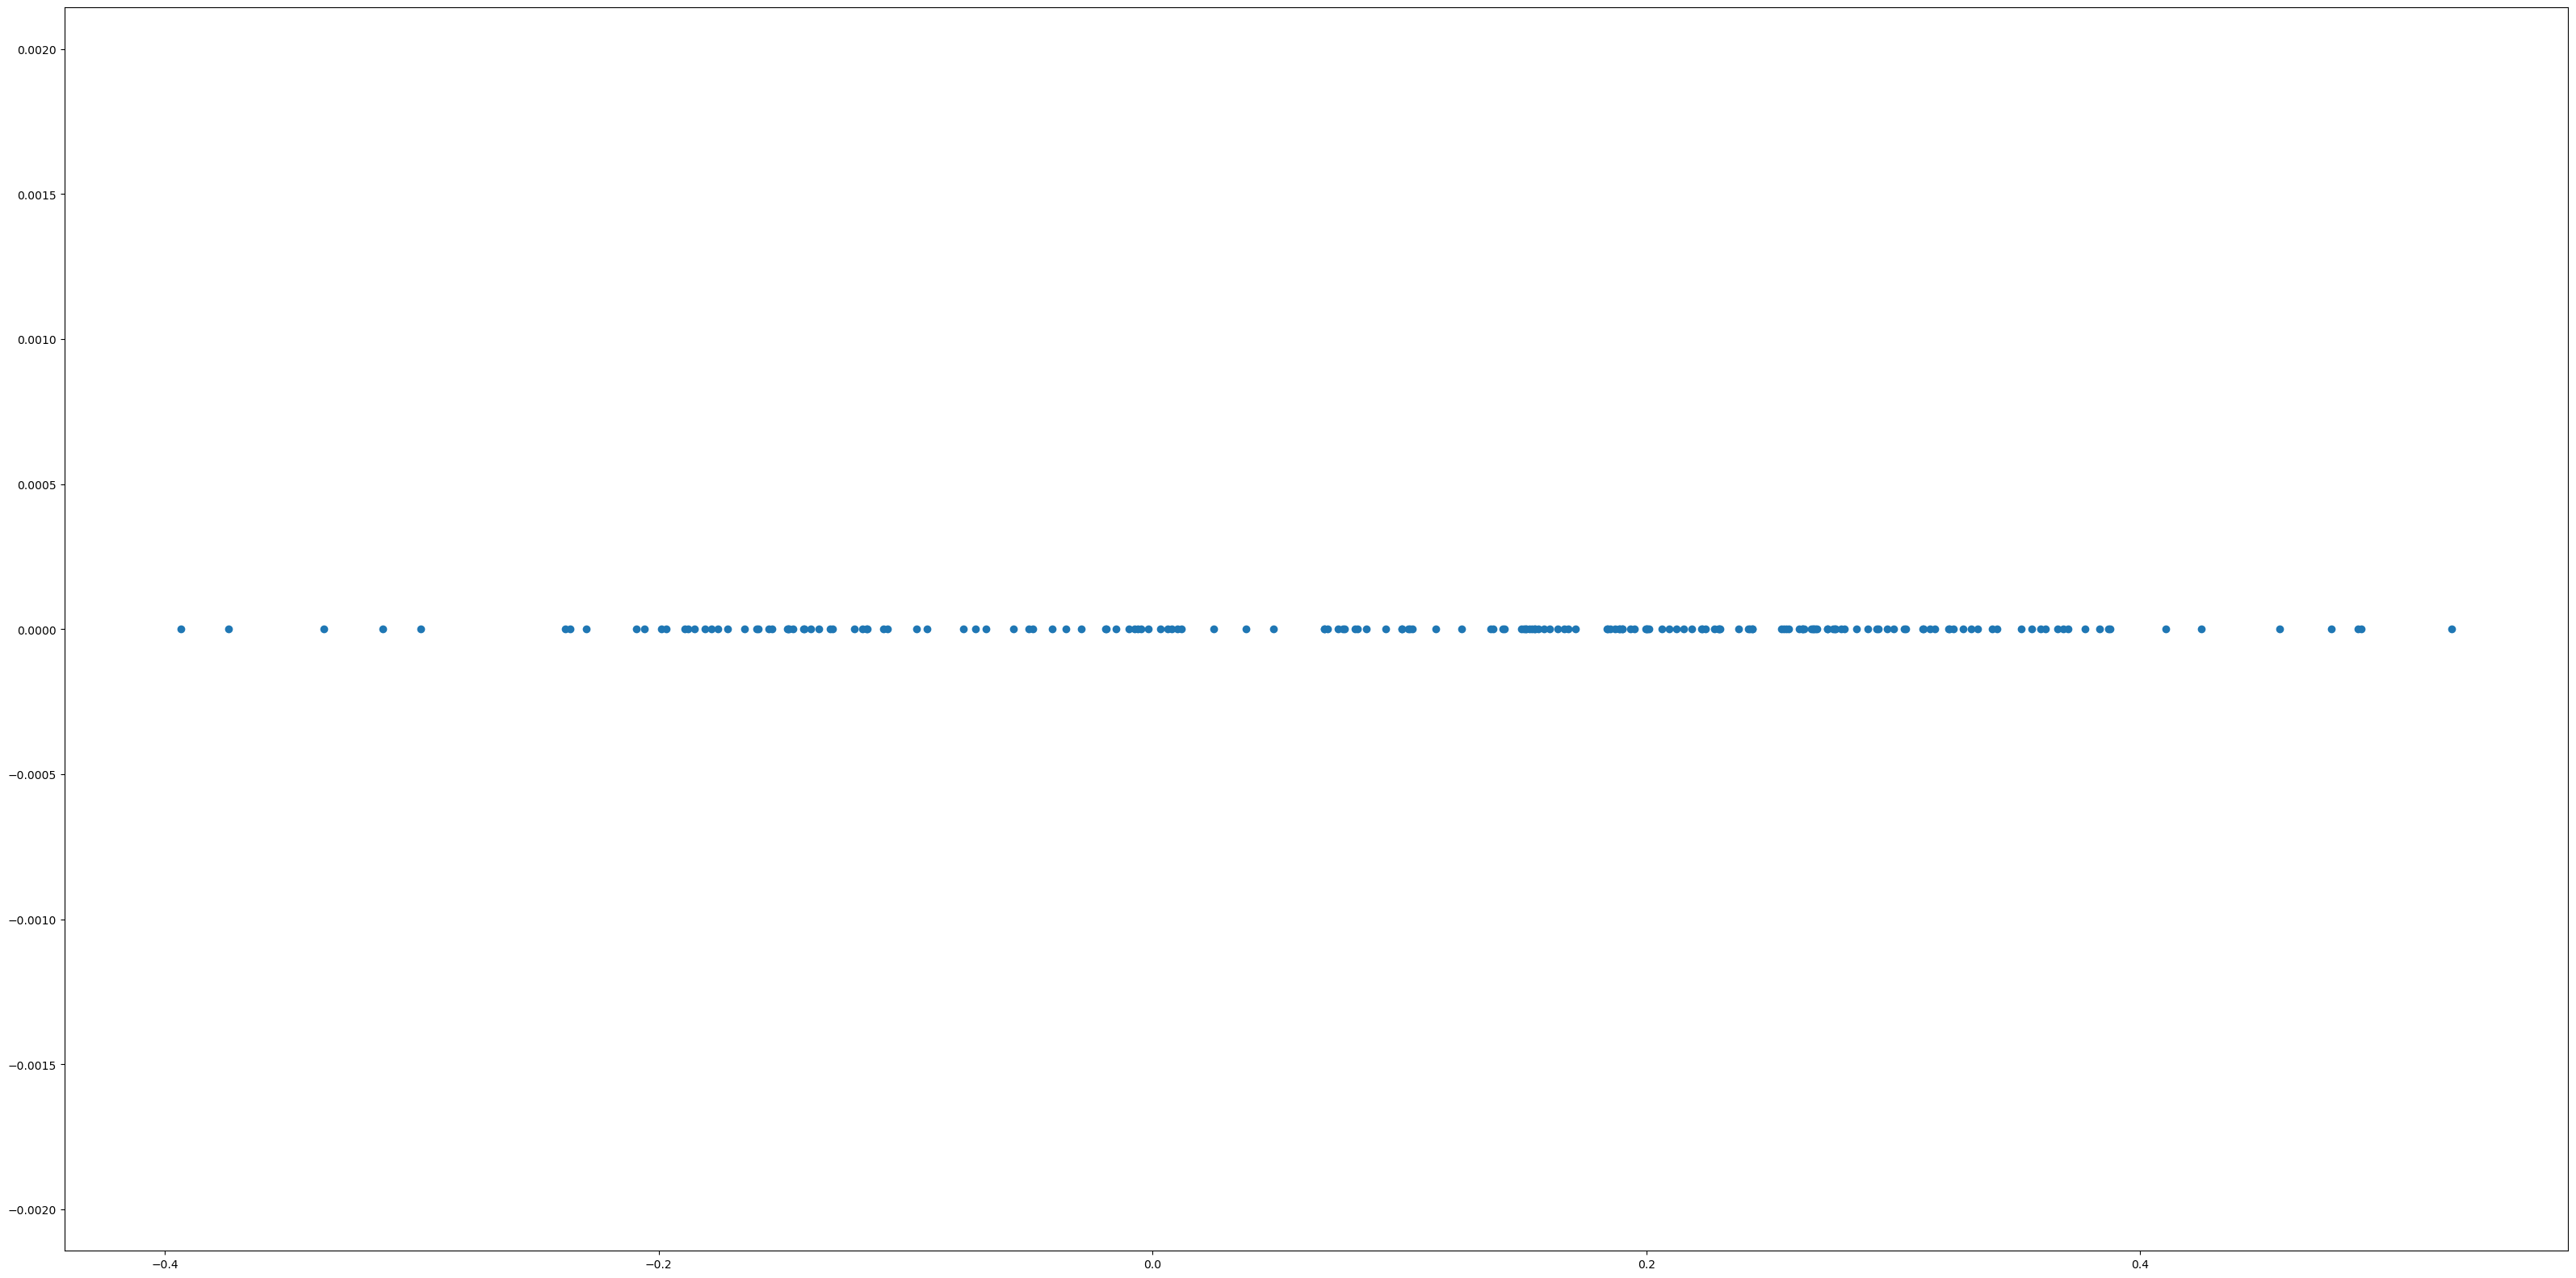

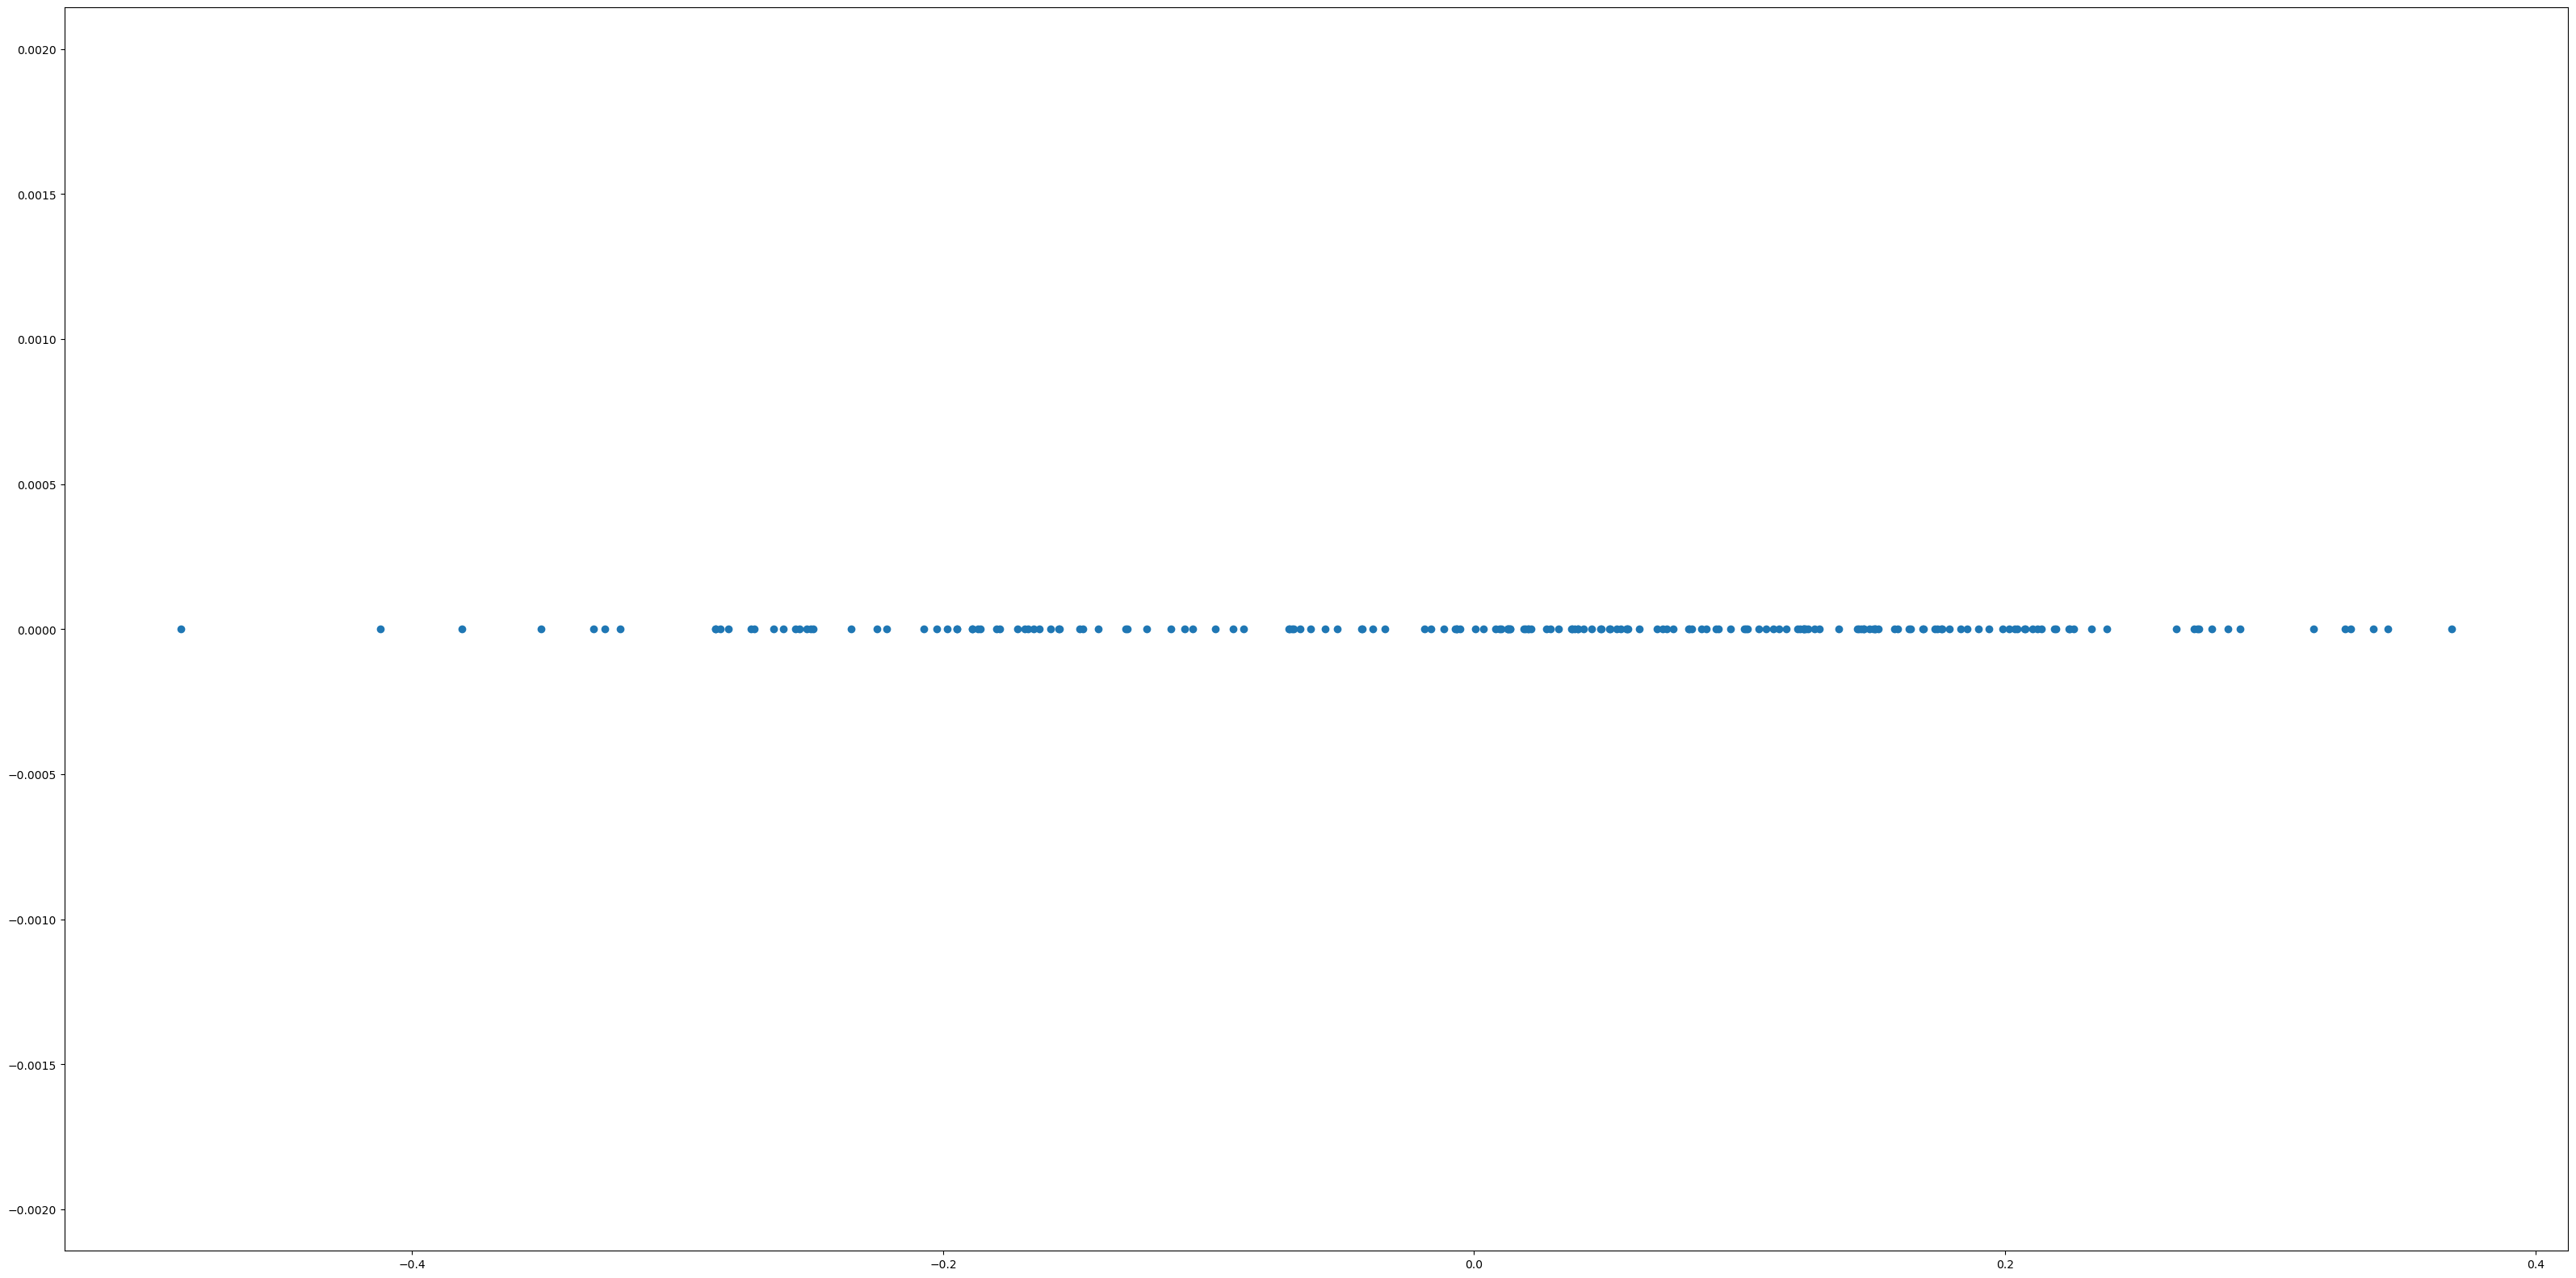

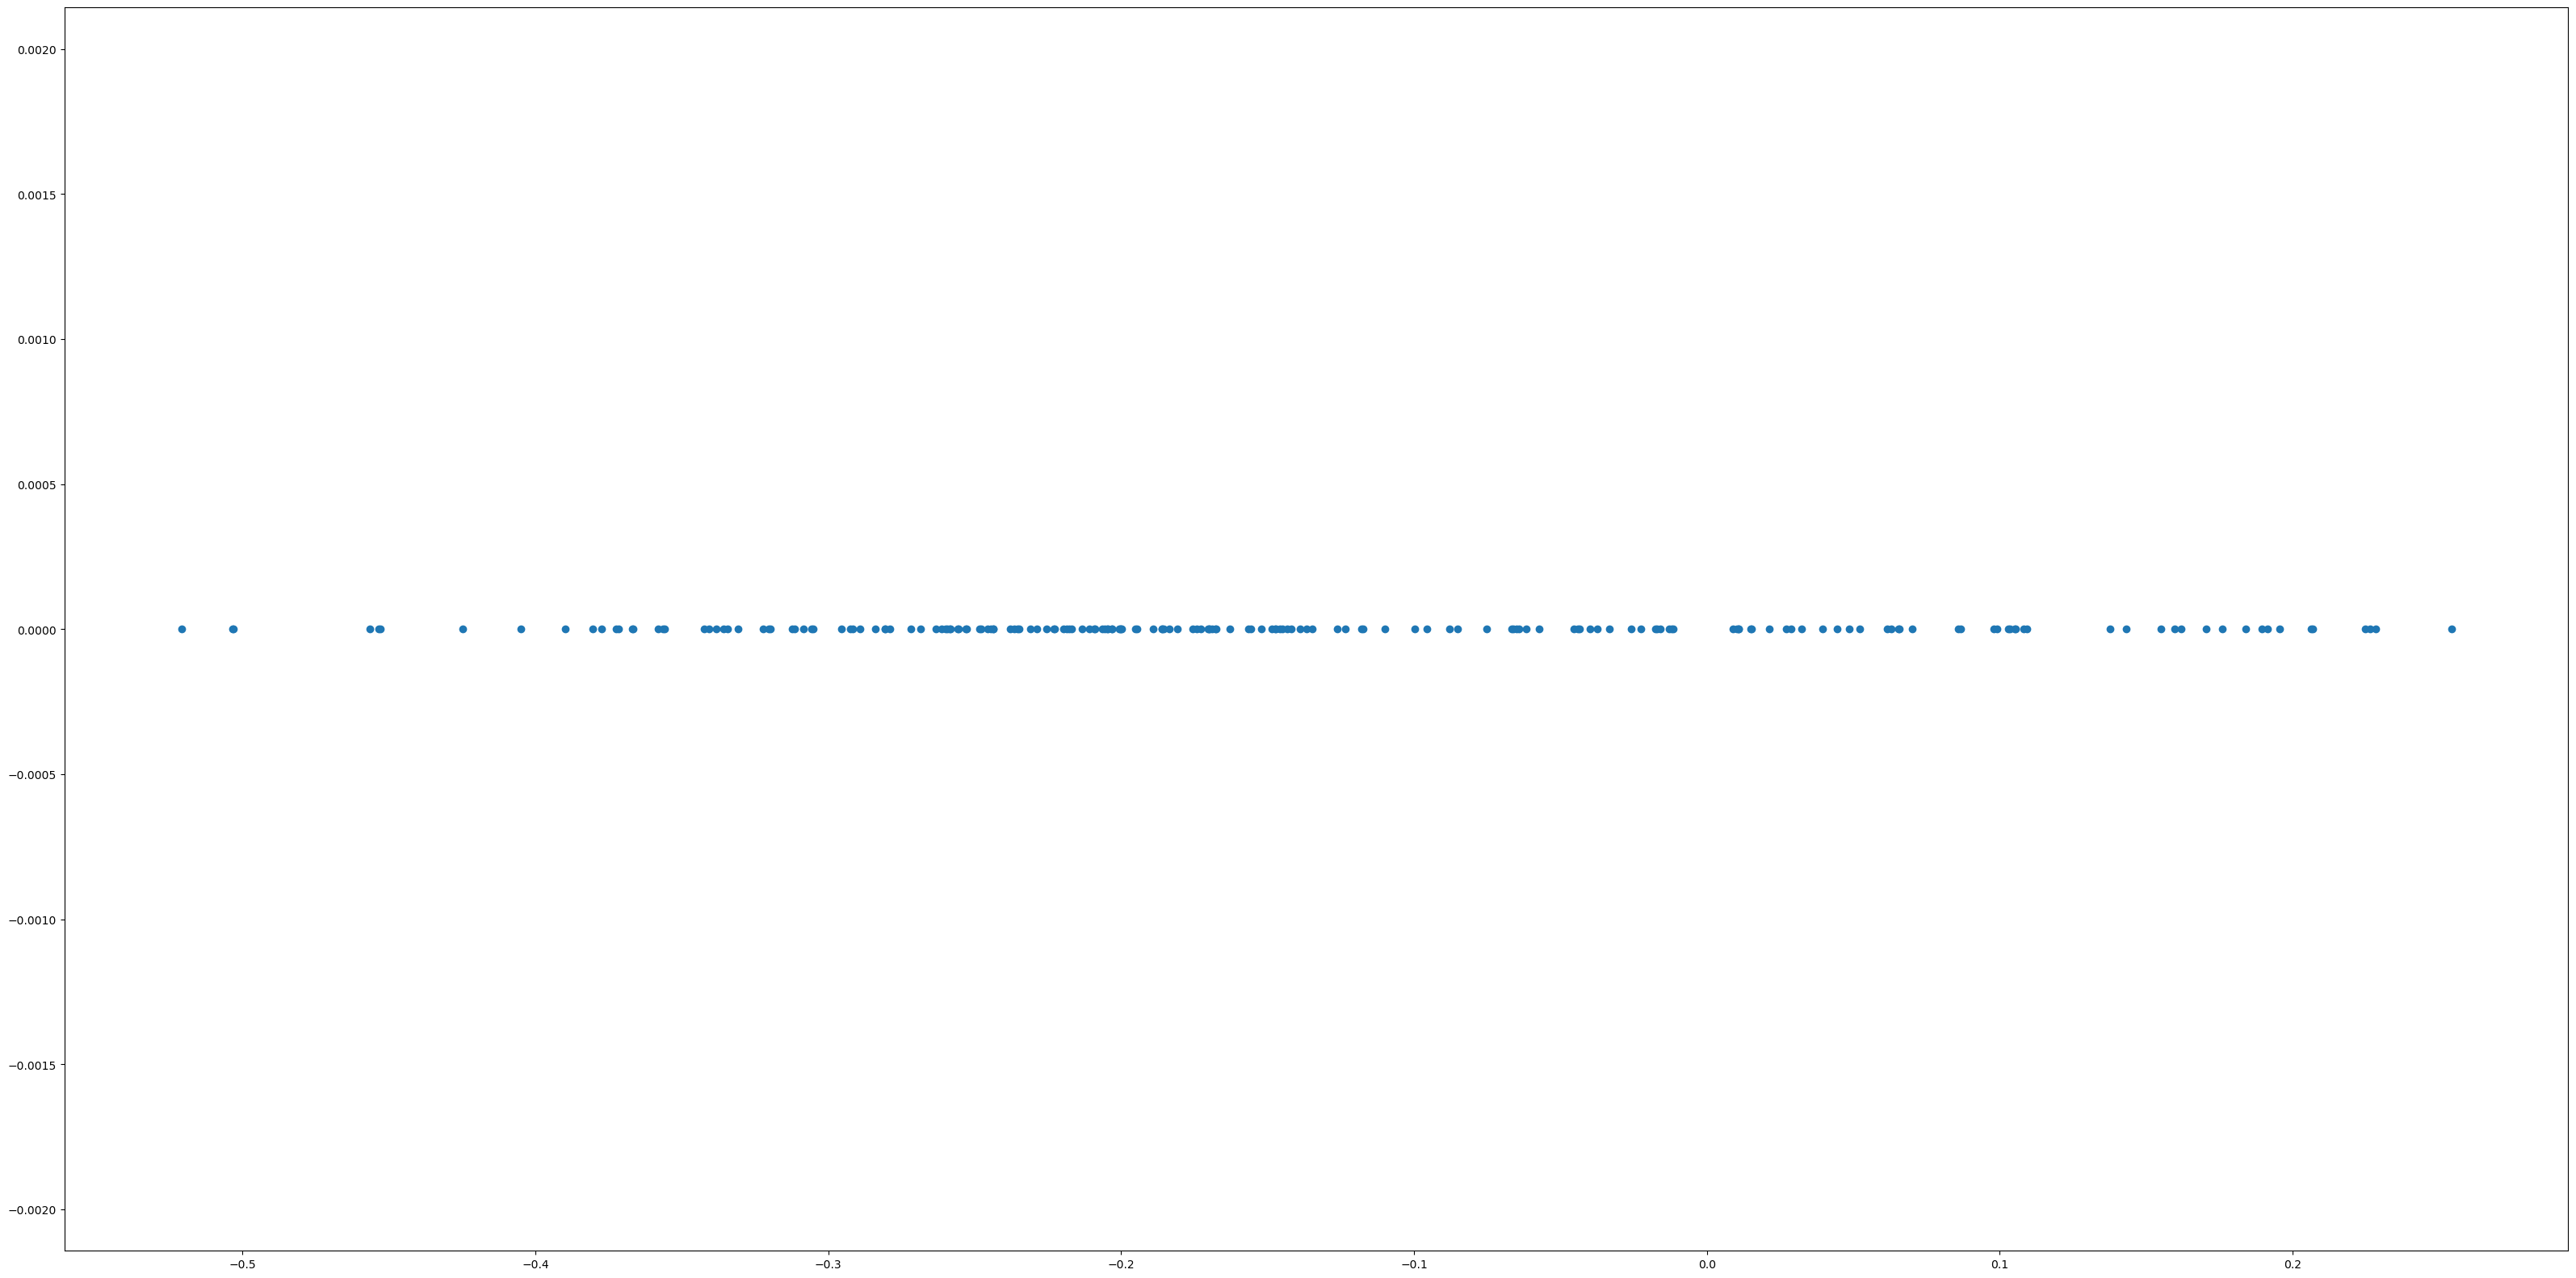

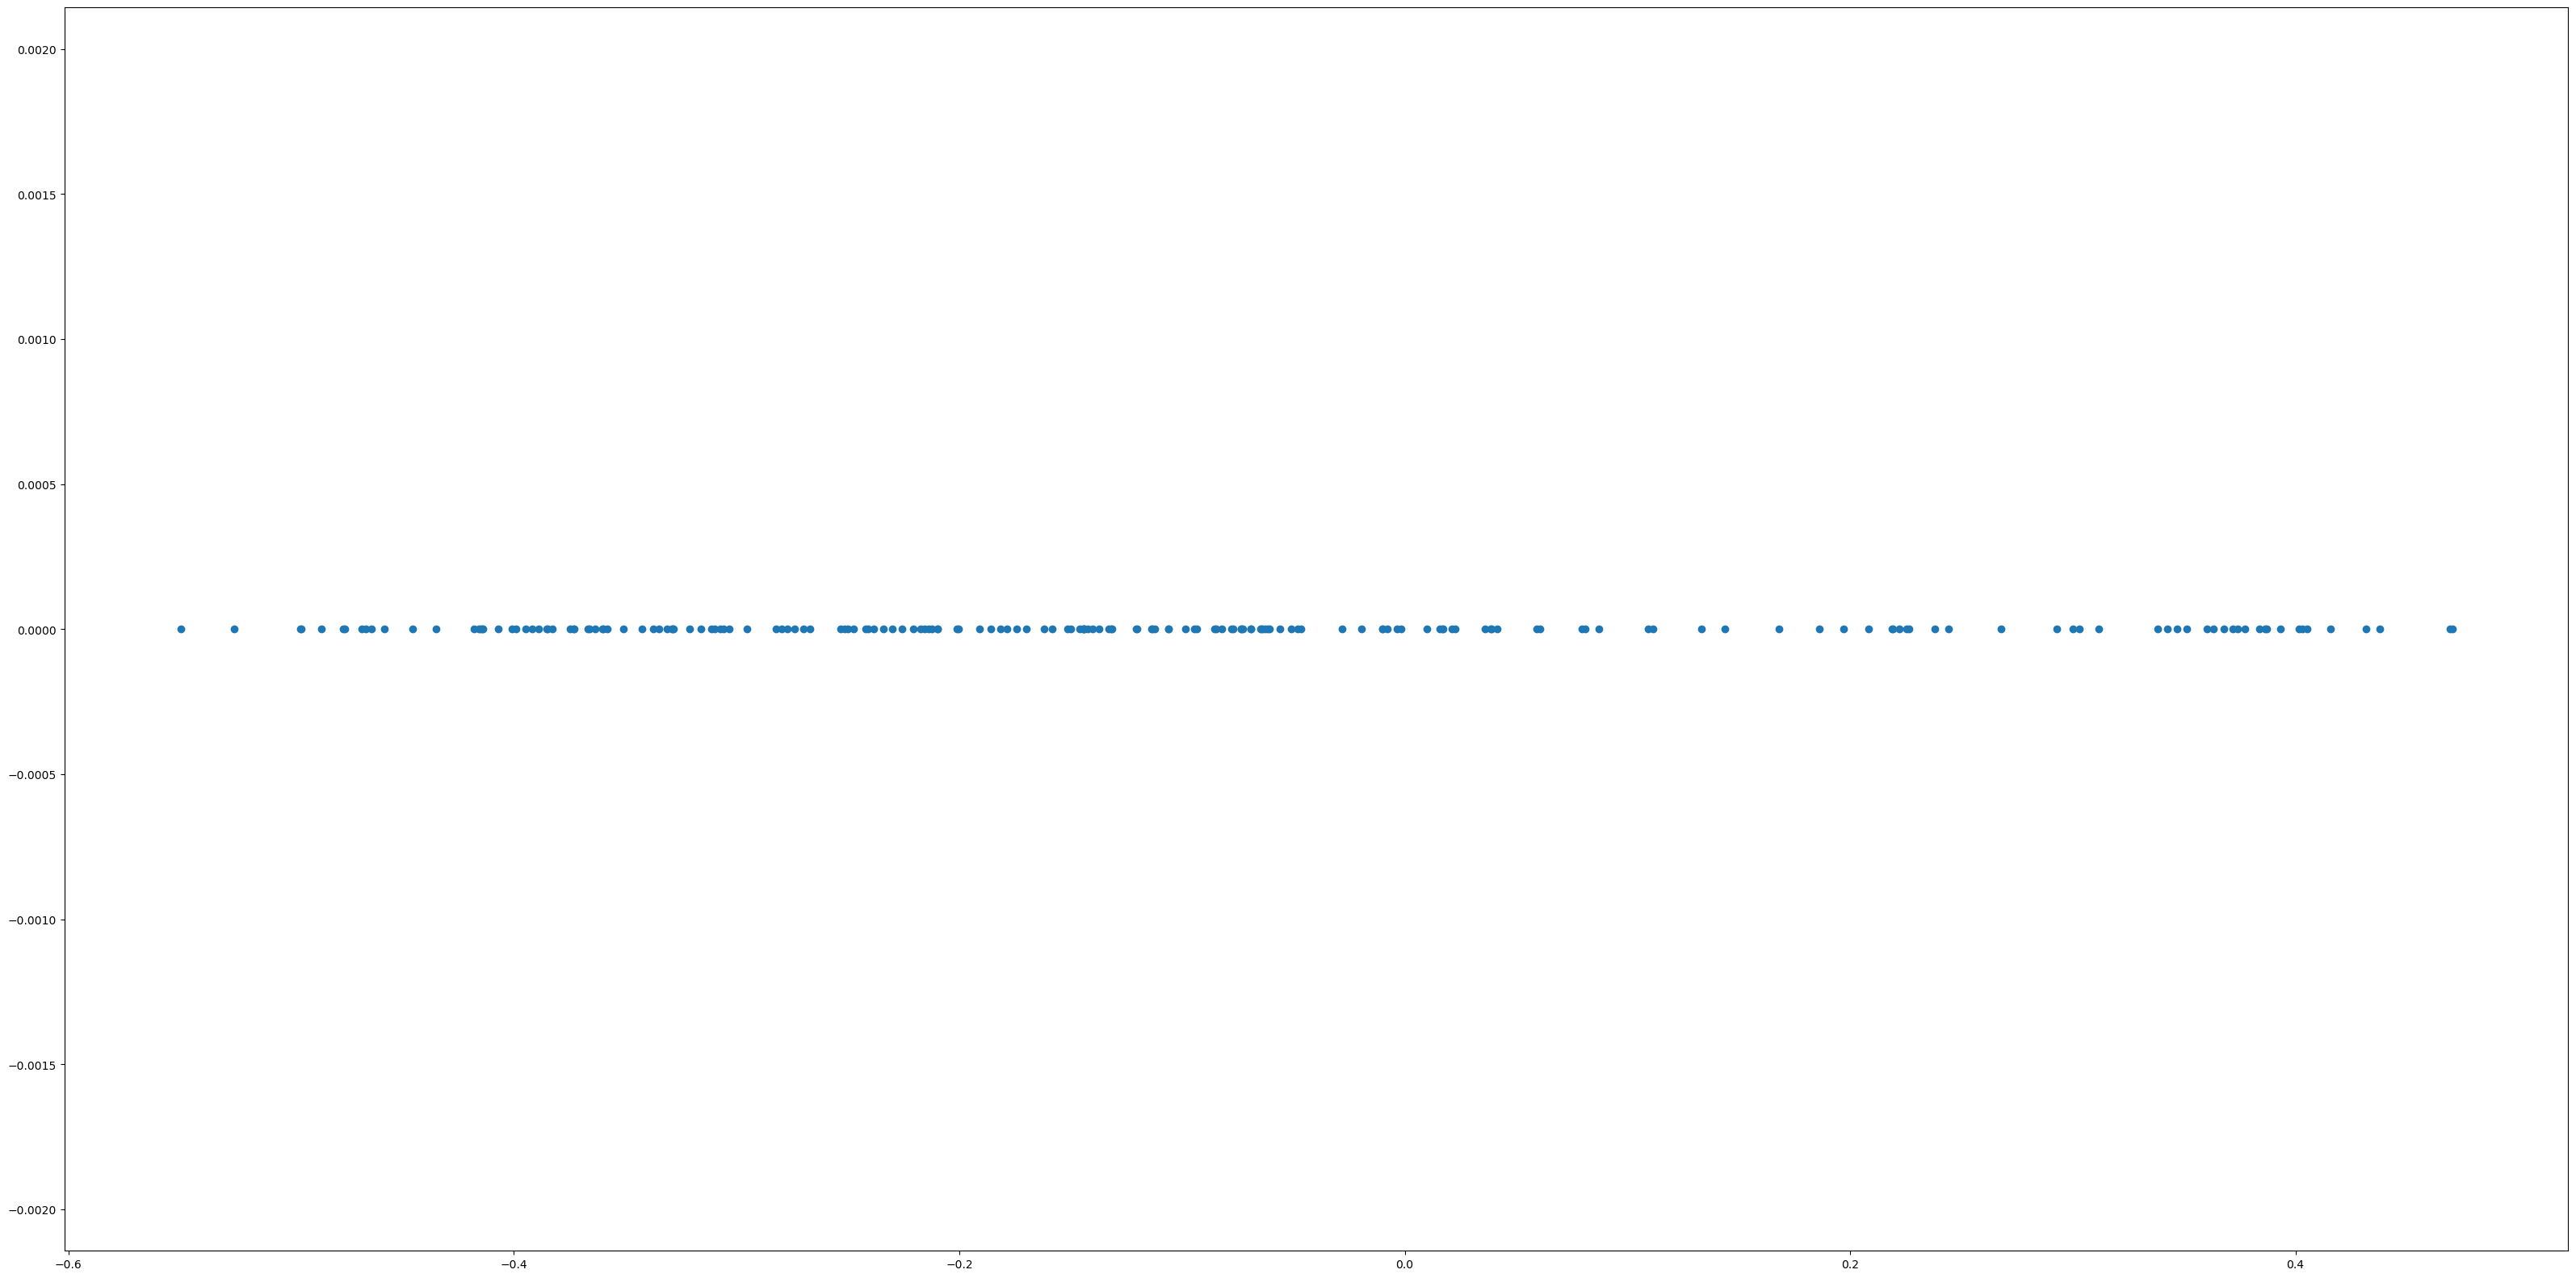

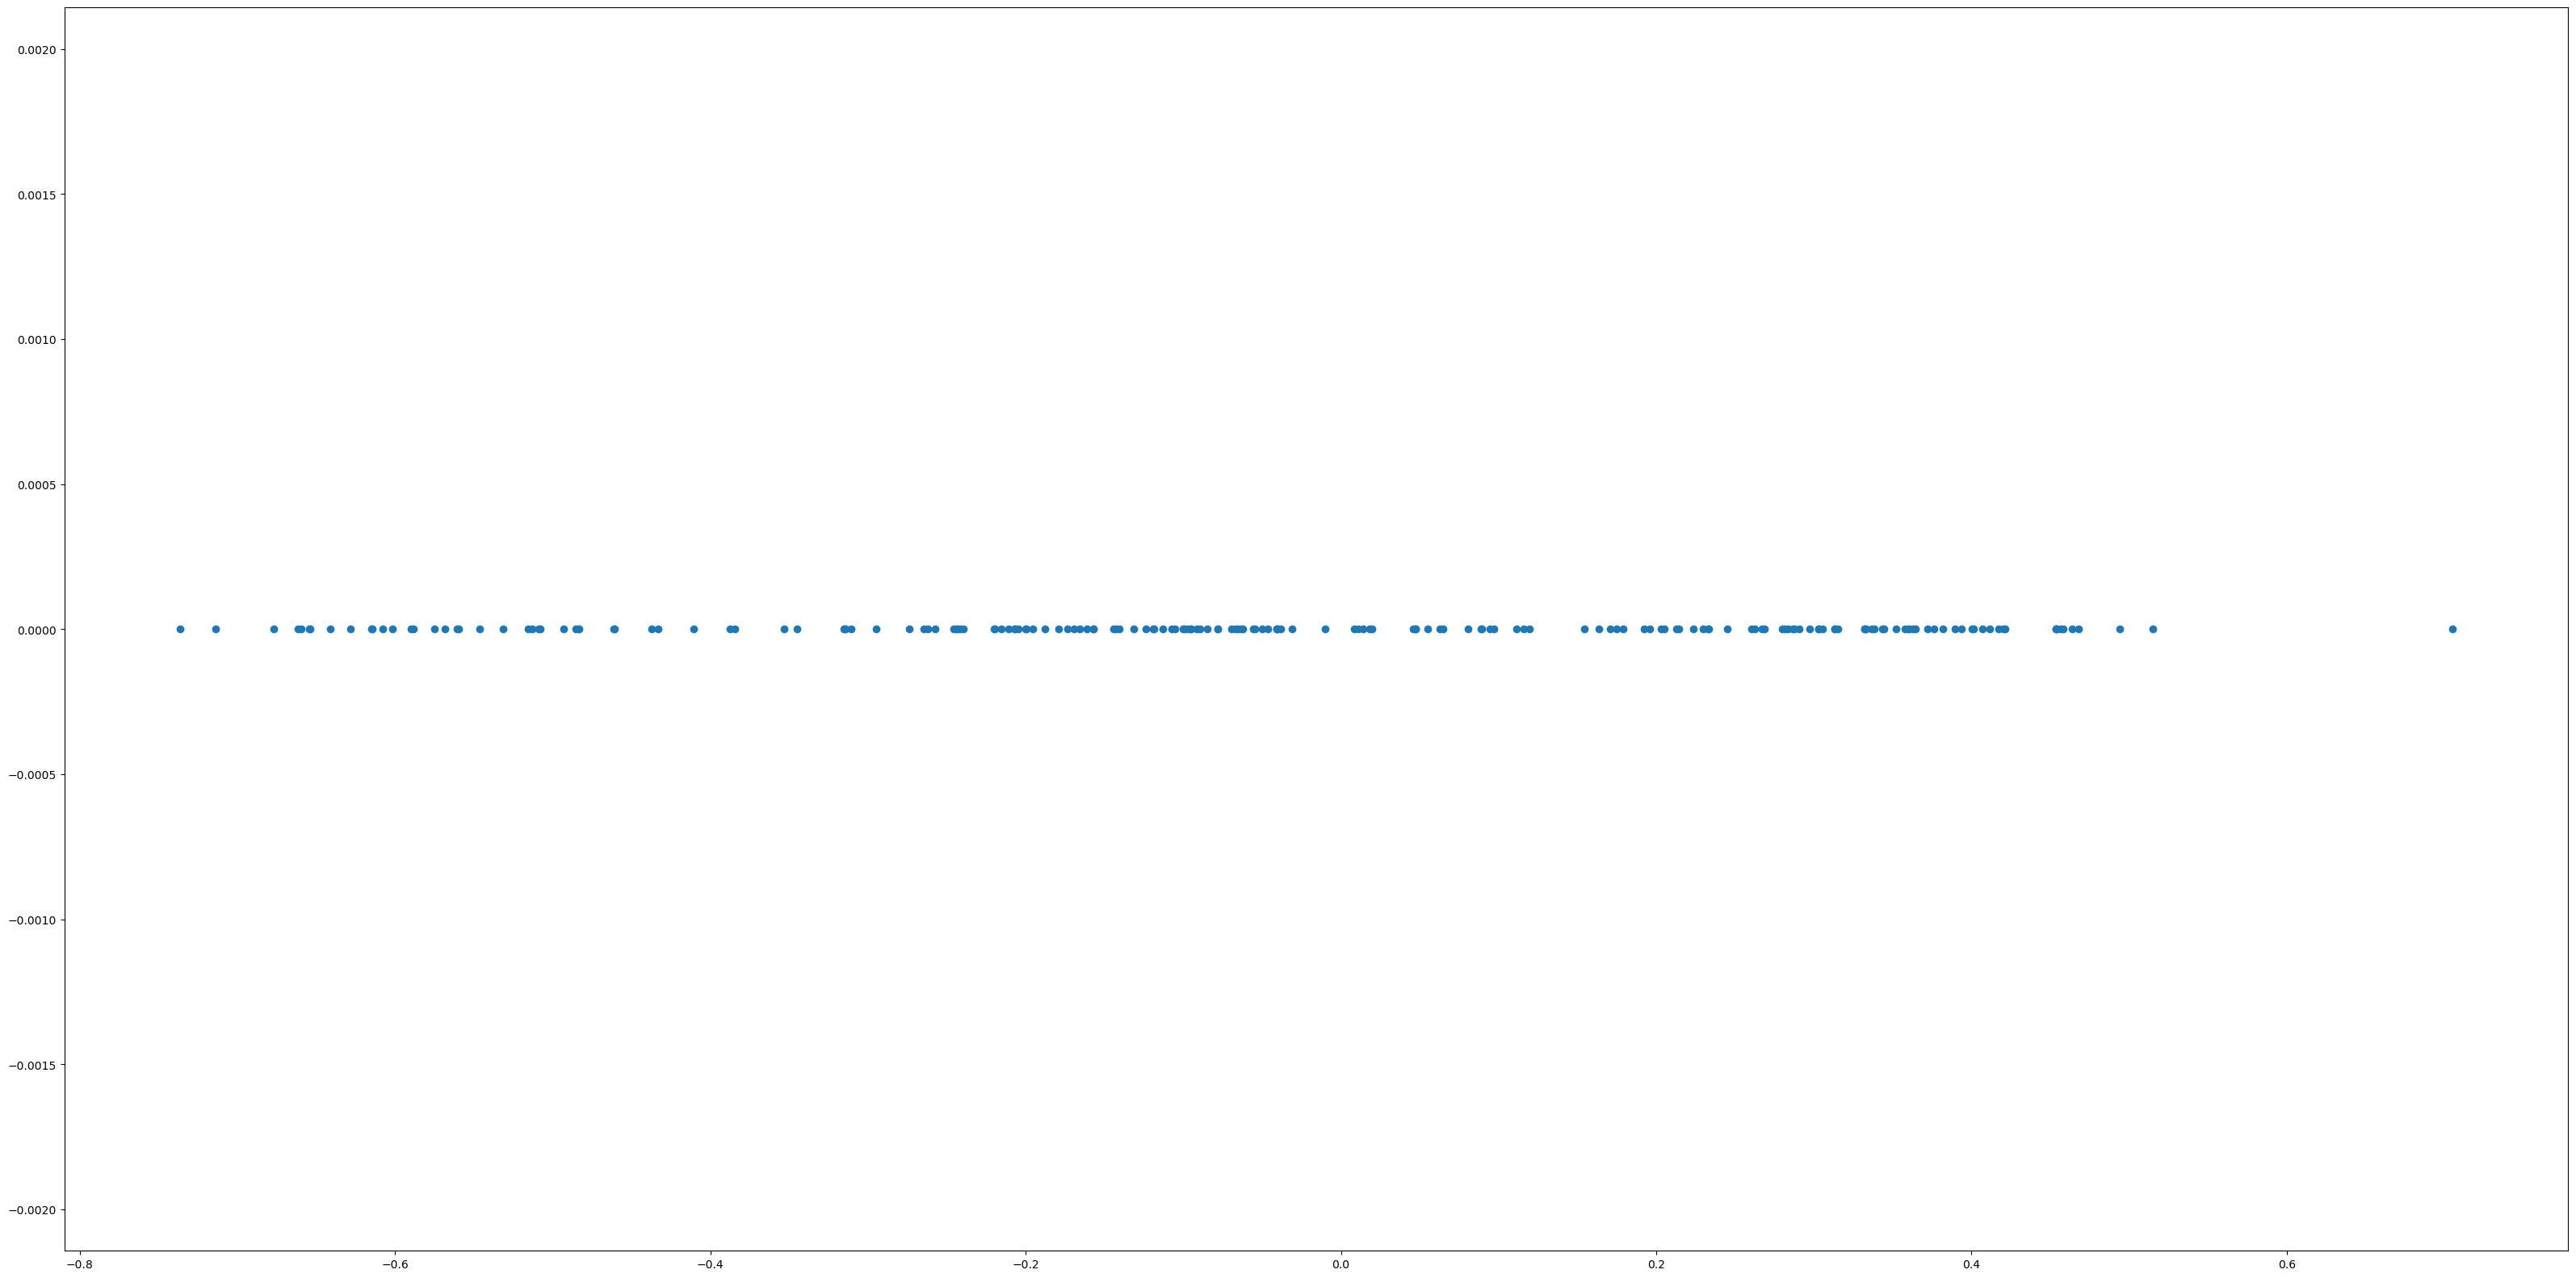

In [382]:
t = encoder.predict(min_max_scaler.fit_transform(one_ten_df))[2]
for i in range(8):
    fig, ax = plt.subplots()
    plt.scatter(t[:,i],np.zeros_like(t[:,i]))
    plt.show()

In [383]:
outs = encoder.predict(min_max_scaler.fit_transform(one_ten_df))
print(np.min(outs[2],axis=0))
print(np.max(outs[2],axis=0))


[-0.4070918  -0.44673973 -0.41810006 -0.36905217 -0.47434133 -0.5227691
 -0.58087385 -0.746202  ]
[0.18974262 0.3842956  0.4323401  0.4840386  0.4601438  0.376584
 0.58926535 0.5412314 ]


### Data Generation

In [384]:
def generate_data(count):
    ax = []
    mins = np.min(outs[2],axis=0)
    maxs = np.max(outs[2],axis=0)
    for i in range(count):
        t = []
        for j in range(8):
            center = (mins[j] +maxs[j])/2
            t.append(np.random.normal(center, (maxs[j]-center)/1.2))
        ax.append(np.array(t))
    for i in ax:
        i = i[:, np.newaxis]
    ax =  np.array(ax)   

    new_records = decoder.predict(ax)
    new_records = new_records.reshape(count, 20)
    return new_records

In [385]:
new = generate_data(700)

In [386]:
generated_df = pd.DataFrame(new, columns = no_channel_training_cols)

In [387]:
generated_df

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
0    0.682086  0.208049  0.891670  0.816986  0.813622  0.828103  0.823813   
1    0.813914  0.121718  0.932333  0.773093  0.531797  0.477364  0.518499   
2    0.800130  0.586117  0.848232  0.279189  0.022209  0.015639  0.020669   
3    0.818553  0.051580  0.985279  0.981373  0.983101  0.988340  0.987712   
4    0.938567  0.009934  0.998355  0.998375  0.997907  0.998846  0.998955   
..        ...       ...       ...       ...       ...       ...       ...   
695  0.718109  0.149393  0.927690  0.922632  0.906529  0.933177  0.929593   
696  0.799418  0.306111  0.863775  0.509895  0.163542  0.126707  0.184959   
697  0.658627  0.425566  0.732270  0.514987  0.266665  0.265334  0.260004   
698  0.964747  0.082335  0.985926  0.697273  0.074127  0.035641  0.081066   
699  0.945957  0.041072  0.989666  0.906449  0.417417  0.361272  0.408369   

      beacon8   beacon9  beacon10  beacon11  beacon12  beacon13  beacon14  \
0    0.735816  0.768138  0.767029  0.423556  0.377934  0.356256  0.271300   
1    0.566207  0.535523  0.831894  0.027472  0.018455  0.012562  0.013300   
2    0.031716  0.030424  0.626196  0.000674  0.000540  0.000398  0.000688   
3    0.969316  0.982682  0.904447  0.804887  0.833593  0.776987  0.544047   
4    0.997540  0.998587  0.975632  0.842837  0.879563  0.799164  0.520810   
..        ...       ...       ...       ...       ...       ...       ...   
695  0.877610  0.912558  0.802705  0.662558  0.715575  0.679701  0.508818   
696  0.187253  0.187288  0.732186  0.007423  0.004921  0.003799  0.005673   
697  0.265494  0.267680  0.656951  0.052583  0.048520  0.045618  0.050106   
698  0.108712  0.150729  0.920229  0.000049  0.000025  0.000011  0.000025   
699  0.576811  0.592184  0.956930  0.000835  0.000482  0.000216  0.000311   

     beacon15  beacon16      beacon17  beacon18  beacon19  beacon20  
0    0.113902  0.182980  1.465043e-01  0.156411  0.171154  0.317314  
1    0.010091  0.008430  2.638221e-03  0.009729  0.026915  0.017894  
2    0.001679  0.000919  2.162755e-04  0.002456  0.003212  0.000511  
3    0.115133  0.266897  1.889611e-01  0.206682  0.242975  0.723733  
4    0.028217  0.074402  4.342610e-02  0.070825  0.123822  0.769927  
..        ...       ...           ...       ...       ...       ...  
695  0.231756  0.315289  2.825679e-01  0.309136  0.324803  0.625610  
696  0.006912  0.005527  1.634479e-03  0.007318  0.012737  0.005593  
697  0.062663  0.045917  3.121471e-02  0.068248  0.085640  0.045428  
698  0.000047  0.000018  9.536743e-07  0.000034  0.000199  0.000034  
699  0.000263  0.000121  1.361966e-05  0.000267  0.001674  0.000536  

[700 rows x 20 columns]

## Random Forest with Synthesized Data

### Labeling Model Definition

In [388]:
rfc_syn = RandomForestClassifier()
forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12,15], 'max_features': [8,10,15,20]}]
clf2 = GridSearchCV(rfc_syn, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf2.fit(min_max_scaler.fit_transform(one_ten_df), one_ten_locations))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.2s
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.2s
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max

In [389]:
clf2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=15)

In [390]:
syn_rforest_predictions = clf2.predict(generated_df)

### Testing the generated plus ground data

In [391]:
one_ten_df

beacon1    beacon2     beacon3     beacon4     beacon5     beacon6  \
0   -107.134454 -83.647059 -172.931671 -300.000000 -300.000000 -300.000000   
5    -94.600000 -84.000000 -245.333333 -300.000000 -300.000000 -300.000000   
10   -95.285714 -83.714286 -222.761905 -300.000000 -300.000000 -300.000000   
15   -95.020337 -83.666667 -168.991023 -300.000000 -300.000000 -300.000000   
20   -95.894643 -84.520000 -171.435235 -300.000000 -300.000000 -300.000000   
..          ...        ...         ...         ...         ...         ...   
935  -93.190101 -89.794173 -112.379754 -145.408775 -200.162984 -211.666093   
940  -93.189943 -89.794012 -112.379611 -145.408657 -200.162908 -211.666025   
945  -93.188842 -89.792894 -112.378612 -145.407834 -200.162377 -211.665555   
950  -93.186987 -89.791008 -112.376929 -145.406447 -200.161481 -211.664762   
955  -93.186377 -89.790388 -112.376376 -145.405991 -200.161186 -211.664502   

        beacon7     beacon8     beacon9   beacon10    beacon11    beacon12  \
0   -300.000000 -300.000000 -300.000000 -99.220588 -300.000000 -300.000000   
5   -300.000000 -300.000000 -300.000000 -97.400000 -300.000000 -300.000000   
10  -300.000000 -300.000000 -300.000000 -97.914286 -300.000000 -300.000000   
15  -300.000000 -300.000000 -300.000000 -99.152778 -300.000000 -300.000000   
20  -300.000000 -300.000000 -300.000000 -99.070000 -300.000000 -300.000000   
..          ...         ...         ...        ...         ...         ...   
935 -201.391330 -185.997138 -188.566476 -93.637146 -275.911939 -274.503236   
940 -201.391255 -185.997051 -188.566390 -93.636988 -275.911920 -274.503217   
945 -201.390730 -185.996444 -188.565797 -93.635890 -275.911792 -274.503081   
950 -201.389845 -185.995421 -188.564798 -93.634039 -275.911576 -274.502853   
955 -201.389554 -185.995085 -188.564469 -93.633430 -275.911505 -274.502777   

       beacon13    beacon14    beacon15    beacon16    beacon17    beacon18  \
0   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
5   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
10  -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
15  -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
20  -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
935 -272.354211 -272.830298 -289.417250 -287.715368 -290.431301 -288.386076   
940 -272.354190 -272.680096 -289.249927 -287.541666 -290.261344 -288.215284   
945 -272.354043 -271.762297 -288.069433 -286.322038 -289.075567 -286.977658   
950 -272.353795 -269.961655 -286.048080 -284.236170 -287.030935 -284.942635   
955 -272.353713 -269.371383 -285.374393 -283.562695 -286.379587 -284.250458   

       beacon19    beacon20  
0   -300.000000 -300.000000  
5   -300.000000 -300.000000  
10  -300.000000 -300.000000  
15  -300.000000 -300.000000  
20  -300.000000 -300.000000  
..          ...         ...  
935 -282.451447 -270.843446  
940 -282.284969 -270.843424  
945 -281.151177 -270.843269  
950 -279.243340 -270.843007  
955 -278.598975 -270.842921  

[192 rows x 20 columns]

In [392]:
pd.DataFrame(min_max_scaler.fit_transform(one_ten_df), columns= no_channel_training_cols)

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
0    0.000000  0.999668  0.543948  0.000000  0.000000  0.000000  0.000000   
1    0.815001  0.943489  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.770415  0.988967  0.169577  0.000000  0.000000  0.000000  0.000000   
3    0.787671  0.996547  0.573554  0.000000  0.000000  0.000000  0.000000   
4    0.730822  0.860719  0.555190  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
187  0.906674  0.021212  0.998869  0.999491  0.999966  0.999966  0.999966   
188  0.906684  0.021237  0.998871  0.999492  0.999967  0.999967  0.999967   
189  0.906756  0.021415  0.998878  0.999498  0.999972  0.999972  0.999972   
190  0.906877  0.021716  0.998891  0.999507  0.999981  0.999981  0.999981   
191  0.906916  0.021814  0.998895  0.999509  0.999984  0.999984  0.999984   

      beacon8   beacon9  beacon10  beacon11  beacon12  beacon13  beacon14  \
0    0.000000  0.000000  0.293707  0.000000  0.000000  0.000000  0.000000   
1    0.000000  0.000000  0.508811  0.000000  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.448047  0.000000  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.301719  0.000000  0.000000  0.000000  0.000000   
4    0.000000  0.000000  0.311499  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
187  0.999966  0.999966  0.953394  0.999966  0.999966  0.989379  0.810250   
188  0.999967  0.999967  0.953413  0.999967  0.999967  0.989379  0.814729   
189  0.999972  0.999972  0.953543  0.999972  0.999972  0.989385  0.842099   
190  0.999981  0.999981  0.953762  0.999981  0.999981  0.989394  0.895798   
191  0.999984  0.999984  0.953833  0.999984  0.999984  0.989396  0.913401   

     beacon15  beacon16  beacon17  beacon18  beacon19  beacon20  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...  
187  0.579641  0.612112  0.557458  0.597048  0.706028  0.999966  
188  0.588805  0.620767  0.567360  0.605828  0.712725  0.999967  
189  0.653464  0.681538  0.636442  0.669452  0.758341  0.999972  
190  0.764178  0.785472  0.755559  0.774068  0.835099  0.999981  
191  0.801077  0.819029  0.793505  0.809652  0.861023  0.999984  

[192 rows x 20 columns]

In [393]:
frames = [pd.DataFrame(min_max_scaler.fit_transform(one_ten_df), columns= no_channel_training_cols), generated_df]
train_combined = pd.concat(frames)

frames = [one_ten_locations, pd.DataFrame(syn_rforest_predictions, columns = ['location'])]
label_combined2 = pd.concat(frames)

rfc_syn_tester = RandomForestClassifier()
forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12], 'max_features': [10,15,20]}]
clf3 = GridSearchCV(rfc_syn_tester, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf3.fit(train_combined , label_combined2))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.1s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.1s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.6s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.5s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.5s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   2.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   2.0s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=10, max_

In [394]:
clf3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=15)

In [395]:
syn_rforest_predictions_clf = clf3.predict(pd.DataFrame(min_max_scaler.fit_transform(one_ten_df_test), columns= no_channel_training_cols))
accuracy_score(one_ten__test_loc, syn_rforest_predictions_clf)*100


24.641460234680572

### Room level accuracy

In [396]:
room_lev_atarget = []
for i in one_ten__test_loc.to_numpy():
    room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

In [397]:
room_lev_test_pred_rf = []
for i in syn_rforest_predictions_clf:
    room_lev_test_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_pred_rf)*100

42.24250325945241

### Label Propagation 

In [398]:
nolabel = [-1 for _ in range(len(generated_df))]
nolabel = pd.DataFrame(nolabel, columns = ['location'])

In [399]:
semi_combined_labels = pd.concat([one_ten_locations, nolabel])
label_propagator = LabelPropagation()
label_propagator.fit(train_combined, semi_combined_labels)
all_labels = label_propagator.transduction_



In [400]:
rfc_semi_tester = RandomForestClassifier()
forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12], 'max_features': [10,15,20]}]
clf_sem = GridSearchCV(rfc_semi_tester, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf_sem.fit(train_combined , all_labels))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.1s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.0s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.8s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.7s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.6s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.8s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.7s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.7s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=10, max_

In [401]:
clf_sem.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=10)

In [402]:
syn_semi_predictions_clf = clf_sem.predict(pd.DataFrame(min_max_scaler.fit_transform(one_ten_df_test), columns= no_channel_training_cols))
accuracy_score(one_ten__test_loc, syn_semi_predictions_clf)*100

45.63233376792699

In [403]:
room_lev_test_semi = []
for i in syn_semi_predictions_clf:
    room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_semi)*100

67.01434159061279

## Accuracies with real Data

In [404]:
without_syn_predictions = clf2.predict(pd.DataFrame(min_max_scaler.fit_transform(one_ten_df_test), columns= no_channel_training_cols))
accuracy_score(one_ten__test_loc, without_syn_predictions)*100

41.46023468057366

In [405]:
room_lev_test_without_pred_rf = []
for i in without_syn_predictions:
    room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100

68.1877444589309

### Experiments

In [406]:
def generate_new_data(count, outs):
    ax = []
    mins = np.min(outs[2],axis=0)
    maxs = np.max(outs[2],axis=0)
    for i in range(count):
        t = []
        for j in range(8):
            center = (mins[j] +maxs[j])/2
            t.append(np.random.normal(center, (maxs[j]-center)/1.2))
        ax.append(np.array(t))
    for i in ax:
        i = i[:, np.newaxis]
    ax =  np.array(ax)   

    new_records = decoder.predict(ax)
    new_records = new_records.reshape(count, 20)
    return new_records

In [407]:
parts = [0.1,0.2, 0.3,0.4, 0.5, 0.7, 0.9]

### RFC with Generated Data

In [408]:
method_accs = []
org_comp_accs = []
method_accs_room = []
org_comp_accs_room = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(500, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_

  
    rfc_semi_tester = RandomForestClassifier()
    forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12], 'max_features': [10,15,20]}]
    clf_sem = GridSearchCV(rfc_semi_tester, forest_syn_params, cv = [(slice(None), slice(None))], scoring='accuracy',refit=True,verbose=2)
    print(clf_sem.fit(train_combined , all_labels))

    syn_semi_predictions_clf = clf_sem.predict(pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols))

    method_accs.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], syn_semi_predictions_clf)*100)

    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    room_lev_test_semi = []
    for i in syn_semi_predictions_clf:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    method_accs_room.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)


    rfc_syn = RandomForestClassifier()
    forest_syn_params = [{'criterion': ["entropy"], 'max_depth':[8,10,12,15], 'max_features': [8,10,15,20]}]
    clf2 = GridSearchCV(rfc_syn, forest_syn_params, cv = [(slice(None), slice(None))], scoring='accuracy',refit=True,verbose=2)
    print(clf2.fit(min_max_scaler.fit_transform(par_df), par_locations))

    without_syn_predictions = clf2.predict(pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols))

   

    org_comp_accs.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], without_syn_predictions)*100)

    room_lev_test_without_pred_rf = []
    for i in without_syn_predictions:
        room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    org_comp_accs_room.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 20)                0         
_________________________________________________________________
model_69 (Model)             [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_70 (Model)             (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 2s 28ms/step - loss: 14.1064 - accuracy: 0.1974 - val_loss: 13.9267 - val_accuracy: 0.0000e+00
Epoch 2/100
76/76 [==============================] - 0s 902us/step - loss: 13.6693 - accuracy: 0.2105 - val_loss: 13.6819 - val_accuracy: 0.0000e+00
Epoch 3/100
76/76 [======================

Epoch 52/100
76/76 [==============================] - 0s 801us/step - loss: 3.8757 - accuracy: 0.6053 - val_loss: 5.7690 - val_accuracy: 0.6500
Epoch 53/100
76/76 [==============================] - 0s 824us/step - loss: 3.8449 - accuracy: 0.5526 - val_loss: 5.2982 - val_accuracy: 0.6500
Epoch 54/100
76/76 [==============================] - 0s 821us/step - loss: 3.8740 - accuracy: 0.5263 - val_loss: 5.3438 - val_accuracy: 0.6500
Epoch 55/100
76/76 [==============================] - 0s 839us/step - loss: 3.8130 - accuracy: 0.5526 - val_loss: 5.4565 - val_accuracy: 0.6500
Epoch 56/100
76/76 [==============================] - 0s 872us/step - loss: 3.8224 - accuracy: 0.5658 - val_loss: 5.4489 - val_accuracy: 0.6500
Epoch 57/100
76/76 [==============================] - 0s 800us/step - loss: 3.8449 - accuracy: 0.6184 - val_loss: 5.1866 - val_accuracy: 0.6500
Epoch 58/100
76/76 [==============================] - 0s 1ms/step - loss: 3.8193 - accuracy: 0.5658 - val_loss: 5.4609 - val_accuracy: 0

[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=10, max_features=8; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.3s
[CV] END ....criterion=entropy, max_depth=12, max_features=8; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.3s
[CV] END ....criterion=entro

153/153 [==============================] - 0s 591us/step - loss: 3.8129 - accuracy: 0.4575 - val_loss: 5.3347 - val_accuracy: 0.6667
Epoch 41/100
153/153 [==============================] - 0s 642us/step - loss: 3.8120 - accuracy: 0.5294 - val_loss: 5.2348 - val_accuracy: 0.6667
Epoch 42/100
153/153 [==============================] - 0s 688us/step - loss: 3.7766 - accuracy: 0.4967 - val_loss: 5.6919 - val_accuracy: 0.6667
Epoch 43/100
153/153 [==============================] - 0s 658us/step - loss: 3.8172 - accuracy: 0.5294 - val_loss: 5.9960 - val_accuracy: 0.6667
Epoch 44/100
153/153 [==============================] - 0s 673us/step - loss: 3.8466 - accuracy: 0.4967 - val_loss: 5.4574 - val_accuracy: 0.6667
Epoch 45/100
153/153 [==============================] - 0s 685us/step - loss: 3.7850 - accuracy: 0.5033 - val_loss: 5.2081 - val_accuracy: 0.6667
Epoch 46/100
153/153 [==============================] - 0s 637us/step - loss: 3.8259 - accuracy: 0.5294 - val_loss: 5.3699 - val_accuracy

153/153 [==============================] - 0s 758us/step - loss: 3.6847 - accuracy: 0.5359 - val_loss: 4.7221 - val_accuracy: 0.6667
Epoch 97/100
153/153 [==============================] - 0s 781us/step - loss: 3.7020 - accuracy: 0.5490 - val_loss: 4.7777 - val_accuracy: 0.6667
Epoch 98/100
153/153 [==============================] - 0s 750us/step - loss: 3.6975 - accuracy: 0.5490 - val_loss: 4.8457 - val_accuracy: 0.6667
Epoch 99/100
153/153 [==============================] - 0s 735us/step - loss: 3.7085 - accuracy: 0.5556 - val_loss: 4.8077 - val_accuracy: 0.6667
Epoch 100/100
153/153 [==============================] - 0s 769us/step - loss: 3.7048 - accuracy: 0.5425 - val_loss: 4.9188 - val_accuracy: 0.6667
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   1.7s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   2.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=20;

Epoch 28/100
256/256 [==============================] - 0s 583us/step - loss: 3.6735 - accuracy: 0.5000 - val_loss: 5.2163 - val_accuracy: 0.6406
Epoch 29/100
256/256 [==============================] - 0s 498us/step - loss: 3.6840 - accuracy: 0.5039 - val_loss: 5.2942 - val_accuracy: 0.6406
Epoch 30/100
256/256 [==============================] - 0s 528us/step - loss: 3.6644 - accuracy: 0.5000 - val_loss: 5.3907 - val_accuracy: 0.6406
Epoch 31/100
256/256 [==============================] - 0s 641us/step - loss: 3.6853 - accuracy: 0.4961 - val_loss: 5.3991 - val_accuracy: 0.6406
Epoch 32/100
256/256 [==============================] - 0s 738us/step - loss: 3.6725 - accuracy: 0.5156 - val_loss: 5.4216 - val_accuracy: 0.6406
Epoch 33/100
256/256 [==============================] - 0s 769us/step - loss: 3.6845 - accuracy: 0.5117 - val_loss: 5.0901 - val_accuracy: 0.6406
Epoch 34/100
256/256 [==============================] - 0s 759us/step - loss: 3.6545 - accuracy: 0.5000 - val_loss: 5.0870 -

256/256 [==============================] - 0s 544us/step - loss: 3.5746 - accuracy: 0.6094 - val_loss: 4.8134 - val_accuracy: 0.6406
Epoch 85/100
256/256 [==============================] - 0s 578us/step - loss: 3.5915 - accuracy: 0.5781 - val_loss: 5.0549 - val_accuracy: 0.6406
Epoch 86/100
256/256 [==============================] - 0s 694us/step - loss: 3.5497 - accuracy: 0.5898 - val_loss: 4.8675 - val_accuracy: 0.6406
Epoch 87/100
256/256 [==============================] - 0s 652us/step - loss: 3.5748 - accuracy: 0.6133 - val_loss: 4.9887 - val_accuracy: 0.6406
Epoch 88/100
256/256 [==============================] - 0s 617us/step - loss: 3.5665 - accuracy: 0.5820 - val_loss: 4.7444 - val_accuracy: 0.6406
Epoch 89/100
256/256 [==============================] - 0s 633us/step - loss: 3.5744 - accuracy: 0.6016 - val_loss: 4.7050 - val_accuracy: 0.6406
Epoch 90/100
256/256 [==============================] - 0s 587us/step - loss: 3.5589 - accuracy: 0.5820 - val_loss: 4.7480 - val_accuracy

Epoch 16/100
384/384 [==============================] - 0s 473us/step - loss: 3.4274 - accuracy: 0.3802 - val_loss: 5.2738 - val_accuracy: 0.1354
Epoch 17/100
384/384 [==============================] - 0s 527us/step - loss: 3.4204 - accuracy: 0.4141 - val_loss: 5.1741 - val_accuracy: 0.2188
Epoch 18/100
384/384 [==============================] - 0s 533us/step - loss: 3.4600 - accuracy: 0.3854 - val_loss: 5.3075 - val_accuracy: 0.1146
Epoch 19/100
384/384 [==============================] - 0s 527us/step - loss: 3.4506 - accuracy: 0.3620 - val_loss: 5.2595 - val_accuracy: 0.2083
Epoch 20/100
384/384 [==============================] - 0s 589us/step - loss: 3.4017 - accuracy: 0.3906 - val_loss: 5.1098 - val_accuracy: 0.1354
Epoch 21/100
384/384 [==============================] - 0s 526us/step - loss: 3.3730 - accuracy: 0.3776 - val_loss: 5.0640 - val_accuracy: 0.1979
Epoch 22/100
384/384 [==============================] - 0s 531us/step - loss: 3.3723 - accuracy: 0.3724 - val_loss: 5.1035 -

384/384 [==============================] - 0s 614us/step - loss: 3.2872 - accuracy: 0.6562 - val_loss: 4.7083 - val_accuracy: 0.1875
Epoch 73/100
384/384 [==============================] - 0s 617us/step - loss: 3.2848 - accuracy: 0.6562 - val_loss: 4.7506 - val_accuracy: 0.2188
Epoch 74/100
384/384 [==============================] - 0s 571us/step - loss: 3.2975 - accuracy: 0.6484 - val_loss: 4.7436 - val_accuracy: 0.1875
Epoch 75/100
384/384 [==============================] - 0s 568us/step - loss: 3.2727 - accuracy: 0.6641 - val_loss: 4.7615 - val_accuracy: 0.1875
Epoch 76/100
384/384 [==============================] - 0s 613us/step - loss: 3.2731 - accuracy: 0.6510 - val_loss: 4.6417 - val_accuracy: 0.1875
Epoch 77/100
384/384 [==============================] - 0s 620us/step - loss: 3.2911 - accuracy: 0.6693 - val_loss: 4.7250 - val_accuracy: 0.1875
Epoch 78/100
384/384 [==============================] - 0s 591us/step - loss: 3.2776 - accuracy: 0.6276 - val_loss: 4.6091 - val_accuracy

Epoch 4/100
384/384 [==============================] - 0s 567us/step - loss: 6.3777 - accuracy: 0.4870 - val_loss: 9.8105 - val_accuracy: 0.5000
Epoch 5/100
384/384 [==============================] - 0s 535us/step - loss: 5.0815 - accuracy: 0.5260 - val_loss: 8.5959 - val_accuracy: 0.5521
Epoch 6/100
384/384 [==============================] - 0s 566us/step - loss: 4.3104 - accuracy: 0.5807 - val_loss: 7.6896 - val_accuracy: 0.5312
Epoch 7/100
384/384 [==============================] - 0s 504us/step - loss: 3.9894 - accuracy: 0.5000 - val_loss: 7.4544 - val_accuracy: 0.5417
Epoch 8/100
384/384 [==============================] - 0s 508us/step - loss: 3.8158 - accuracy: 0.4427 - val_loss: 6.7300 - val_accuracy: 0.4896
Epoch 9/100
384/384 [==============================] - 0s 506us/step - loss: 3.7211 - accuracy: 0.4714 - val_loss: 6.5302 - val_accuracy: 0.4271
Epoch 10/100
384/384 [==============================] - 0s 484us/step - loss: 3.6479 - accuracy: 0.4375 - val_loss: 6.1454 - val_a

384/384 [==============================] - 0s 579us/step - loss: 3.3369 - accuracy: 0.4818 - val_loss: 4.7638 - val_accuracy: 0.4271
Epoch 61/100
384/384 [==============================] - 0s 541us/step - loss: 3.3489 - accuracy: 0.4974 - val_loss: 4.5998 - val_accuracy: 0.4896
Epoch 62/100
384/384 [==============================] - 0s 537us/step - loss: 3.3379 - accuracy: 0.4870 - val_loss: 4.7092 - val_accuracy: 0.3958
Epoch 63/100
384/384 [==============================] - 0s 558us/step - loss: 3.3382 - accuracy: 0.4870 - val_loss: 4.6983 - val_accuracy: 0.4375
Epoch 64/100
384/384 [==============================] - 0s 651us/step - loss: 3.3324 - accuracy: 0.4948 - val_loss: 4.5865 - val_accuracy: 0.5104
Epoch 65/100
384/384 [==============================] - 0s 727us/step - loss: 3.3546 - accuracy: 0.5156 - val_loss: 4.5564 - val_accuracy: 0.4271
Epoch 66/100
384/384 [==============================] - 0s 853us/step - loss: 3.3316 - accuracy: 0.5208 - val_loss: 4.7186 - val_accuracy

[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   1.1s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'],
                          'max_depth': [8, 10, 12, 15],
                          'max_features': [8, 10, 15, 20]}],
             scoring='accuracy', verbose=2)
0.7
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        (None, 20)                0         
_________________________________________________________________
model_79 (Model)             [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_80 (Model)             (None, 20)                923       
Total params: 1,922
Trainab

511/511 [==============================] - 0s 646us/step - loss: 3.2409 - accuracy: 0.5382 - val_loss: 4.4779 - val_accuracy: 0.6016
Epoch 49/100
511/511 [==============================] - 0s 659us/step - loss: 3.2401 - accuracy: 0.5225 - val_loss: 4.4291 - val_accuracy: 0.6016
Epoch 50/100
511/511 [==============================] - 0s 712us/step - loss: 3.2294 - accuracy: 0.5342 - val_loss: 4.5922 - val_accuracy: 0.6016
Epoch 51/100
511/511 [==============================] - 0s 739us/step - loss: 3.2561 - accuracy: 0.5597 - val_loss: 4.6279 - val_accuracy: 0.6016
Epoch 52/100
511/511 [==============================] - 0s 728us/step - loss: 3.2352 - accuracy: 0.5734 - val_loss: 4.4999 - val_accuracy: 0.6016
Epoch 53/100
511/511 [==============================] - 0s 867us/step - loss: 3.2248 - accuracy: 0.5871 - val_loss: 4.7030 - val_accuracy: 0.6016
Epoch 54/100
511/511 [==============================] - 0s 859us/step - loss: 3.2420 - accuracy: 0.5342 - val_loss: 4.5896 - val_accuracy

[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   2.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   2.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   3.7s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'], 'max_depth': [8, 10, 12],
                          'max_features': [10, 15, 20]}],
             scoring='accuracy', verbose=2)
Fitting 1 folds for each of 16 candidates, totalling 16 fits
[CV] END .....criterion=entropy, max_depth=8, max_features=8; total time=   0.8s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=8, max_features=15; total time=   1.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=20; total time=   1.5s
[CV] END ....criterion=entropy, max_depth=10, max_features=8; total time=

690/690 [==============================] - 0s 558us/step - loss: 3.2598 - accuracy: 0.4725 - val_loss: 4.6092 - val_accuracy: 0.6012
Epoch 37/100
690/690 [==============================] - 0s 554us/step - loss: 3.2752 - accuracy: 0.4797 - val_loss: 4.6627 - val_accuracy: 0.6012
Epoch 38/100
690/690 [==============================] - 0s 578us/step - loss: 3.2587 - accuracy: 0.4971 - val_loss: 4.5875 - val_accuracy: 0.6012
Epoch 39/100
690/690 [==============================] - 0s 651us/step - loss: 3.2519 - accuracy: 0.5130 - val_loss: 4.6106 - val_accuracy: 0.6012
Epoch 40/100
690/690 [==============================] - 0s 676us/step - loss: 3.2691 - accuracy: 0.5014 - val_loss: 4.6438 - val_accuracy: 0.6012
Epoch 41/100
690/690 [==============================] - 0s 697us/step - loss: 3.2473 - accuracy: 0.5130 - val_loss: 4.6143 - val_accuracy: 0.6012
Epoch 42/100
690/690 [==============================] - 0s 679us/step - loss: 3.2345 - accuracy: 0.5232 - val_loss: 4.5955 - val_accuracy

690/690 [==============================] - 1s 823us/step - loss: 3.1859 - accuracy: 0.7130 - val_loss: 4.5753 - val_accuracy: 0.9075
Epoch 93/100
690/690 [==============================] - 1s 796us/step - loss: 3.1834 - accuracy: 0.7072 - val_loss: 4.5612 - val_accuracy: 0.9075
Epoch 94/100
690/690 [==============================] - 1s 761us/step - loss: 3.1819 - accuracy: 0.7000 - val_loss: 4.5809 - val_accuracy: 0.9075
Epoch 95/100
690/690 [==============================] - 1s 782us/step - loss: 3.1732 - accuracy: 0.6928 - val_loss: 4.5871 - val_accuracy: 0.9075
Epoch 96/100
690/690 [==============================] - 1s 809us/step - loss: 3.1874 - accuracy: 0.7116 - val_loss: 4.5250 - val_accuracy: 0.9075
Epoch 97/100
690/690 [==============================] - 1s 755us/step - loss: 3.1699 - accuracy: 0.7029 - val_loss: 4.6139 - val_accuracy: 0.9017
Epoch 98/100
690/690 [==============================] - 1s 813us/step - loss: 3.1725 - accuracy: 0.7246 - val_loss: 4.6127 - val_accuracy

[56.666666666666664, 51.24999999999999, 64.16666666666667, 65.41666666666667, 70.0, 61.66666666666667, 50.0]
[60.416666666666664, 56.25, 62.083333333333336, 62.916666666666664, 60.83333333333333, 50.0, 38.333333333333336]


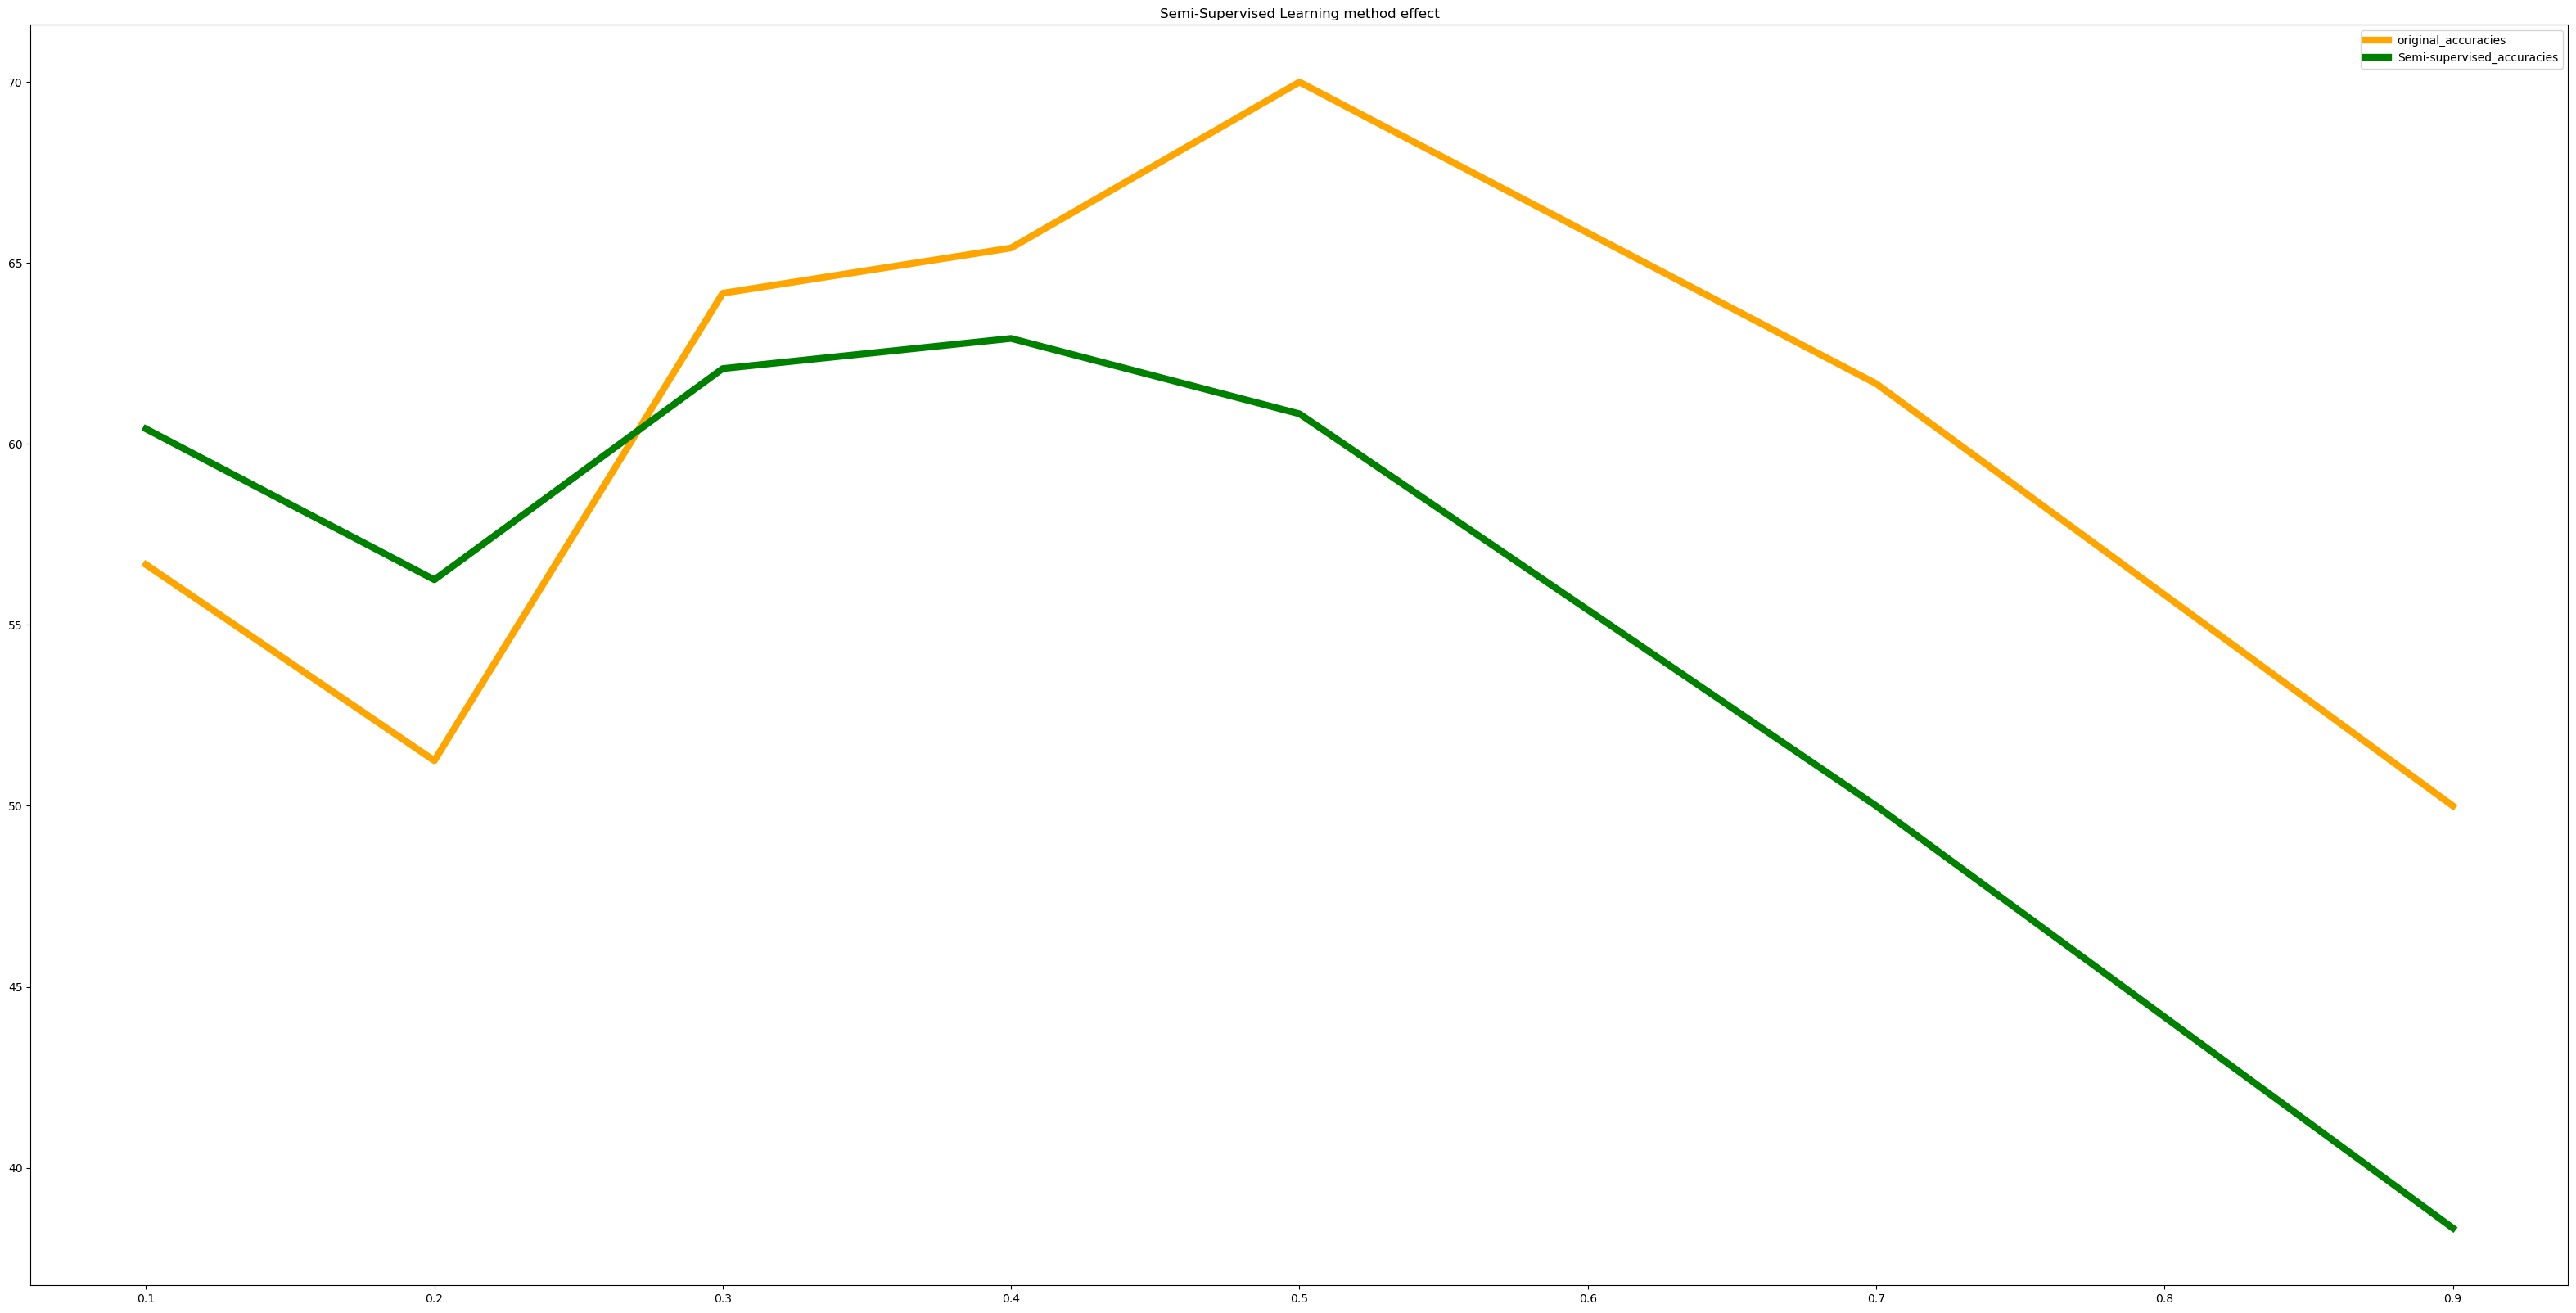

In [409]:
org_dic = res = dict(zip(parts, org_comp_accs))
plot_accs(org_dic, method_accs,"Semi-Supervised Learning method effect")

[89.58333333333334, 85.0, 77.91666666666667, 86.25, 95.83333333333334, 90.83333333333333, 86.66666666666667]
[93.33333333333333, 91.66666666666666, 95.0, 95.83333333333334, 99.16666666666667, 86.66666666666667, 84.58333333333333]


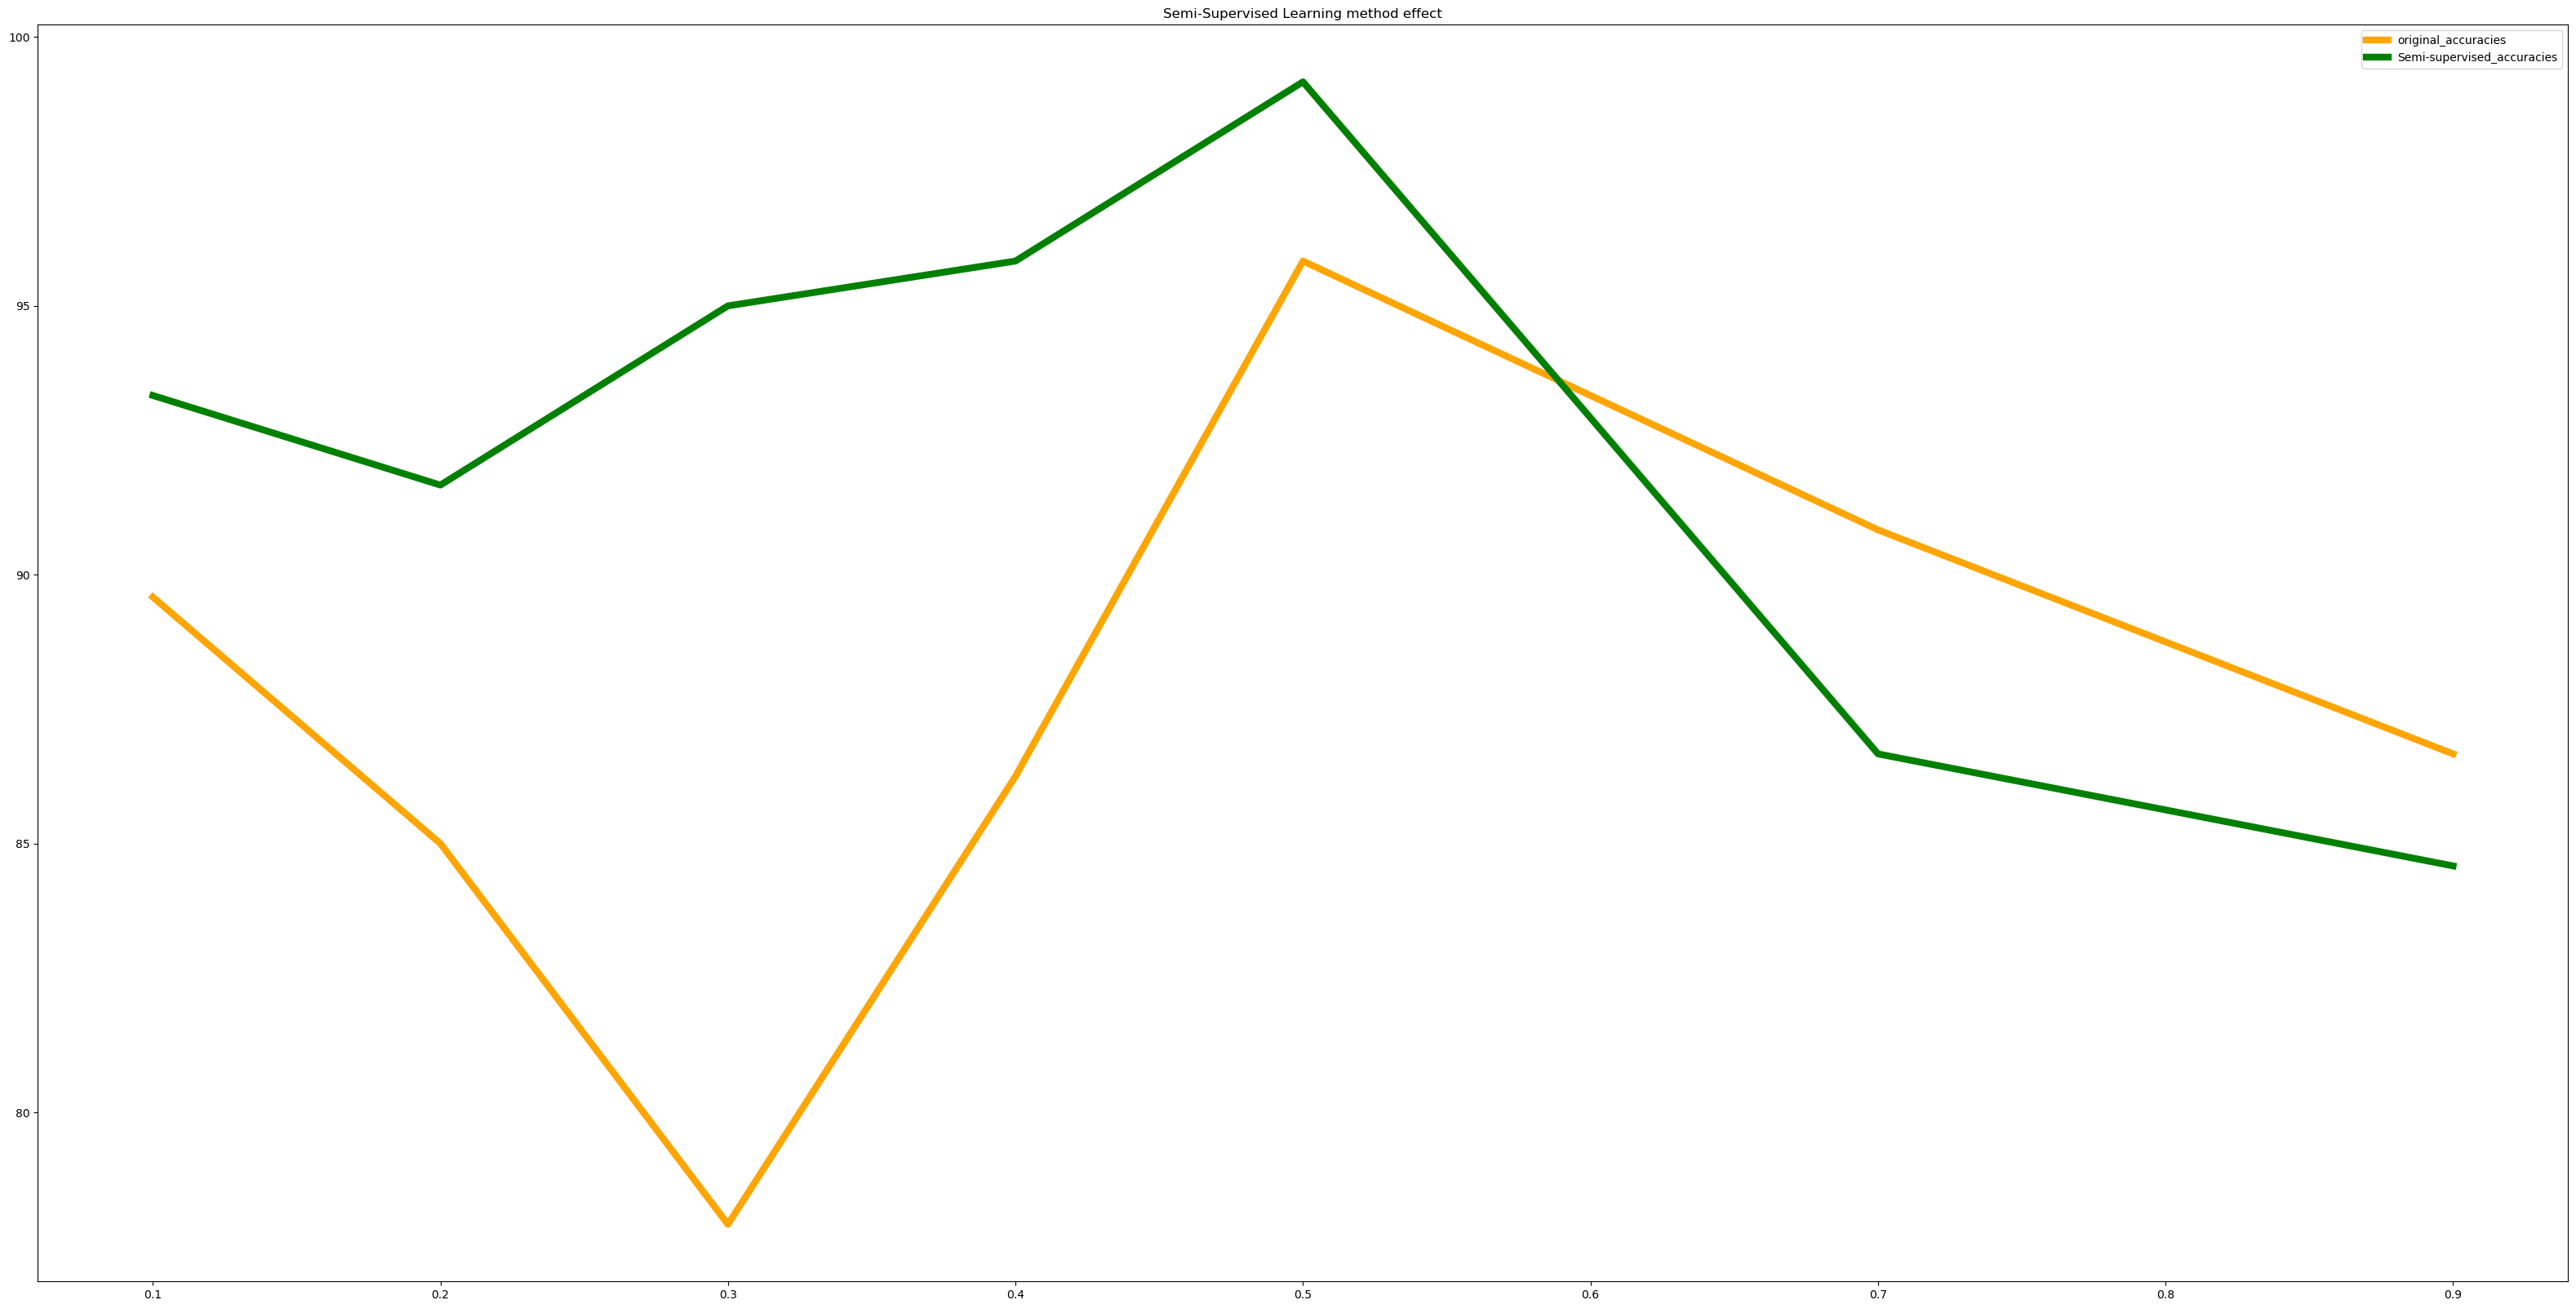

In [410]:
org_dic_room = res = dict(zip(parts, org_comp_accs_room))
plot_accs(org_dic_room, method_accs_room,"Semi-Supervised Learning method effect")

### KNN with Generated Data

In [411]:
method_accs2 = []
org_comp_accs2 = []
method_accs_room2 = []
org_comp_accs_room2 = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(2000, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_

#     ann_model3 = keras.Sequential()
#     ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
#     ann_model3.add(keras.layers.Dense(60, activation ='elu'))
#     ann_model3.add(keras.layers.Dropout(0.3))
#     ann_model3.add(keras.layers.Dense(80, activation ='elu'))
#     ann_model3.add(keras.layers.Dropout(0.3))
#     ann_model3.add(keras.layers.Dense(96))
#     ann_model3.summary()
    
#     ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
#     hist = ann_model3.fit(train_combined, all_labels , epochs=100,validation_split= 0.3)
#     test_loss, test_acc = ann_model3.evaluate(min_max_scaler.fit_transform(one_ten_df_test),  one_ten__test_loc, verbose=2)
#     pred_ann = ann_model3.predict(min_max_scaler.fit_transform(one_ten_df_test))
#     print("Neural Network algorithm prediction time: "+ str(runtime))
#     test_acc

    syn_semi_predictions_clf,runtime = run_knn(train_combined, all_labels, pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols),[],5)

    method_accs2.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], syn_semi_predictions_clf)*100)

    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    room_lev_test_semi = []
    for i in syn_semi_predictions_clf:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    method_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)


    without_syn_predictions ,runtime = run_knn(min_max_scaler.fit_transform(par_df), par_locations, pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols),[],5)

    org_comp_accs2.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], without_syn_predictions)*100)

    room_lev_test_without_pred_rf = []
    for i in without_syn_predictions:
        room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    org_comp_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_83 (Model)             [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_84 (Model)             (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 2s 29ms/step - loss: 13.9639 - accuracy: 0.0526 - val_loss: 13.9921 - val_accuracy: 0.2500
Epoch 2/100
76/76 [==============================] - 0s 692us/step - loss: 13.7905 - accuracy: 0.3553 - val_loss: 13.8580 - val_accuracy: 0.6500
Epoch 3/100
76/76 [==============================

76/76 [==============================] - 0s 566us/step - loss: 3.9244 - accuracy: 0.5132 - val_loss: 6.1866 - val_accuracy: 0.6500
Epoch 53/100
76/76 [==============================] - 0s 590us/step - loss: 3.9228 - accuracy: 0.5658 - val_loss: 6.2468 - val_accuracy: 0.6500
Epoch 54/100
76/76 [==============================] - 0s 555us/step - loss: 4.0385 - accuracy: 0.4605 - val_loss: 5.9623 - val_accuracy: 0.6500
Epoch 55/100
76/76 [==============================] - 0s 456us/step - loss: 3.9493 - accuracy: 0.5395 - val_loss: 5.9769 - val_accuracy: 0.6500
Epoch 56/100
76/76 [==============================] - 0s 545us/step - loss: 3.8835 - accuracy: 0.5132 - val_loss: 5.9922 - val_accuracy: 0.6500
Epoch 57/100
76/76 [==============================] - 0s 494us/step - loss: 3.9337 - accuracy: 0.5526 - val_loss: 6.3562 - val_accuracy: 0.6500
Epoch 58/100
76/76 [==============================] - 0s 552us/step - loss: 3.9156 - accuracy: 0.4868 - val_loss: 5.8549 - val_accuracy: 0.6500
Epoch

153/153 [==============================] - 0s 557us/step - loss: 12.7506 - accuracy: 0.4314 - val_loss: 13.0543 - val_accuracy: 0.6667
Epoch 4/100
153/153 [==============================] - 0s 517us/step - loss: 11.2607 - accuracy: 0.4314 - val_loss: 12.2704 - val_accuracy: 0.6667
Epoch 5/100
153/153 [==============================] - 0s 527us/step - loss: 9.4105 - accuracy: 0.4314 - val_loss: 11.4025 - val_accuracy: 0.6667
Epoch 6/100
153/153 [==============================] - 0s 583us/step - loss: 8.2446 - accuracy: 0.4314 - val_loss: 10.9214 - val_accuracy: 0.6667
Epoch 7/100
153/153 [==============================] - 0s 585us/step - loss: 7.6128 - accuracy: 0.4314 - val_loss: 10.7677 - val_accuracy: 0.6667
Epoch 8/100
153/153 [==============================] - 0s 525us/step - loss: 7.2756 - accuracy: 0.4314 - val_loss: 10.5012 - val_accuracy: 0.6667
Epoch 9/100
153/153 [==============================] - 0s 602us/step - loss: 7.0107 - accuracy: 0.4314 - val_loss: 10.3593 - val_accur

153/153 [==============================] - 0s 564us/step - loss: 3.7581 - accuracy: 0.5033 - val_loss: 5.0669 - val_accuracy: 0.6667
Epoch 60/100
153/153 [==============================] - 0s 692us/step - loss: 3.7239 - accuracy: 0.5359 - val_loss: 4.9708 - val_accuracy: 0.6667
Epoch 61/100
153/153 [==============================] - 0s 622us/step - loss: 3.7119 - accuracy: 0.5425 - val_loss: 4.9289 - val_accuracy: 0.6667
Epoch 62/100
153/153 [==============================] - 0s 582us/step - loss: 3.7469 - accuracy: 0.5556 - val_loss: 5.1921 - val_accuracy: 0.6667
Epoch 63/100
153/153 [==============================] - 0s 663us/step - loss: 3.7079 - accuracy: 0.5425 - val_loss: 5.3275 - val_accuracy: 0.6667
Epoch 64/100
153/153 [==============================] - 0s 628us/step - loss: 3.6993 - accuracy: 0.5359 - val_loss: 4.9912 - val_accuracy: 0.6667
Epoch 65/100
153/153 [==============================] - 0s 552us/step - loss: 3.7823 - accuracy: 0.5621 - val_loss: 5.0791 - val_accuracy

Epoch 10/100
256/256 [==============================] - 0s 630us/step - loss: 4.4590 - accuracy: 0.2812 - val_loss: 7.3008 - val_accuracy: 0.2188
Epoch 11/100
256/256 [==============================] - 0s 596us/step - loss: 4.2114 - accuracy: 0.3086 - val_loss: 7.0070 - val_accuracy: 0.2344
Epoch 12/100
256/256 [==============================] - 0s 625us/step - loss: 4.0869 - accuracy: 0.3555 - val_loss: 6.7033 - val_accuracy: 0.6406
Epoch 13/100
256/256 [==============================] - 0s 621us/step - loss: 3.9739 - accuracy: 0.4609 - val_loss: 6.3143 - val_accuracy: 0.6406
Epoch 14/100
256/256 [==============================] - 0s 570us/step - loss: 3.8994 - accuracy: 0.4688 - val_loss: 5.9796 - val_accuracy: 0.6406
Epoch 15/100
256/256 [==============================] - 0s 584us/step - loss: 3.8588 - accuracy: 0.4453 - val_loss: 5.7677 - val_accuracy: 0.6406
Epoch 16/100
256/256 [==============================] - 0s 599us/step - loss: 3.8336 - accuracy: 0.4570 - val_loss: 5.4165 -

256/256 [==============================] - 0s 705us/step - loss: 3.5685 - accuracy: 0.6094 - val_loss: 6.1131 - val_accuracy: 0.6406
Epoch 67/100
256/256 [==============================] - 0s 695us/step - loss: 3.5475 - accuracy: 0.6172 - val_loss: 6.9464 - val_accuracy: 0.6406
Epoch 68/100
256/256 [==============================] - 0s 708us/step - loss: 3.5454 - accuracy: 0.6367 - val_loss: 6.9995 - val_accuracy: 0.6406
Epoch 69/100
256/256 [==============================] - 0s 748us/step - loss: 3.5585 - accuracy: 0.6016 - val_loss: 7.0790 - val_accuracy: 0.6406
Epoch 70/100
256/256 [==============================] - 0s 769us/step - loss: 3.5180 - accuracy: 0.6602 - val_loss: 7.5257 - val_accuracy: 0.6406
Epoch 71/100
256/256 [==============================] - 0s 684us/step - loss: 3.5595 - accuracy: 0.6250 - val_loss: 7.2614 - val_accuracy: 0.6406
Epoch 72/100
256/256 [==============================] - 0s 769us/step - loss: 3.5388 - accuracy: 0.6289 - val_loss: 6.9677 - val_accuracy

Epoch 17/100
384/384 [==============================] - 0s 740us/step - loss: 3.4547 - accuracy: 0.3698 - val_loss: 5.3371 - val_accuracy: 0.1354
Epoch 18/100
384/384 [==============================] - 0s 855us/step - loss: 3.4628 - accuracy: 0.3646 - val_loss: 5.2318 - val_accuracy: 0.1979
Epoch 19/100
384/384 [==============================] - 0s 875us/step - loss: 3.4313 - accuracy: 0.4167 - val_loss: 5.1842 - val_accuracy: 0.3542
Epoch 20/100
384/384 [==============================] - 0s 823us/step - loss: 3.4200 - accuracy: 0.4036 - val_loss: 5.2043 - val_accuracy: 0.3854
Epoch 21/100
384/384 [==============================] - 0s 893us/step - loss: 3.4191 - accuracy: 0.4036 - val_loss: 5.1519 - val_accuracy: 0.4688
Epoch 22/100
384/384 [==============================] - 0s 900us/step - loss: 3.4004 - accuracy: 0.4141 - val_loss: 5.1081 - val_accuracy: 0.5417
Epoch 23/100
384/384 [==============================] - 0s 923us/step - loss: 3.3995 - accuracy: 0.4271 - val_loss: 5.1316 -

384/384 [==============================] - 0s 800us/step - loss: 3.2974 - accuracy: 0.4479 - val_loss: 4.7883 - val_accuracy: 0.2292
Epoch 74/100
384/384 [==============================] - 0s 825us/step - loss: 3.2986 - accuracy: 0.4896 - val_loss: 4.7518 - val_accuracy: 0.1875
Epoch 75/100
384/384 [==============================] - 0s 967us/step - loss: 3.2897 - accuracy: 0.4635 - val_loss: 4.7261 - val_accuracy: 0.2604
Epoch 76/100
384/384 [==============================] - 0s 923us/step - loss: 3.2854 - accuracy: 0.4740 - val_loss: 4.7887 - val_accuracy: 0.2396
Epoch 77/100
384/384 [==============================] - 0s 896us/step - loss: 3.3040 - accuracy: 0.4714 - val_loss: 4.7048 - val_accuracy: 0.1979
Epoch 78/100
384/384 [==============================] - 0s 931us/step - loss: 3.2973 - accuracy: 0.4557 - val_loss: 4.7475 - val_accuracy: 0.2917
Epoch 79/100
384/384 [==============================] - 0s 819us/step - loss: 3.2836 - accuracy: 0.4297 - val_loss: 4.6521 - val_accuracy

Epoch 24/100
384/384 [==============================] - 0s 774us/step - loss: 3.3706 - accuracy: 0.4766 - val_loss: 5.4204 - val_accuracy: 0.2917
Epoch 25/100
384/384 [==============================] - 0s 785us/step - loss: 3.3912 - accuracy: 0.4661 - val_loss: 5.1712 - val_accuracy: 0.3125
Epoch 26/100
384/384 [==============================] - 0s 777us/step - loss: 3.4121 - accuracy: 0.4531 - val_loss: 5.4072 - val_accuracy: 0.1562
Epoch 27/100
384/384 [==============================] - 0s 730us/step - loss: 3.3877 - accuracy: 0.4818 - val_loss: 5.5178 - val_accuracy: 0.2083
Epoch 28/100
384/384 [==============================] - 0s 696us/step - loss: 3.4129 - accuracy: 0.4609 - val_loss: 5.2072 - val_accuracy: 0.2604
Epoch 29/100
384/384 [==============================] - 0s 790us/step - loss: 3.4008 - accuracy: 0.4609 - val_loss: 5.5453 - val_accuracy: 0.2396
Epoch 30/100
384/384 [==============================] - 0s 776us/step - loss: 3.4147 - accuracy: 0.4896 - val_loss: 5.5206 -

384/384 [==============================] - 0s 875us/step - loss: 3.3022 - accuracy: 0.6146 - val_loss: 5.0795 - val_accuracy: 0.2396
Epoch 81/100
384/384 [==============================] - 0s 821us/step - loss: 3.2842 - accuracy: 0.5938 - val_loss: 4.8278 - val_accuracy: 0.2500
Epoch 82/100
384/384 [==============================] - 0s 847us/step - loss: 3.3001 - accuracy: 0.5547 - val_loss: 4.9425 - val_accuracy: 0.2917
Epoch 83/100
384/384 [==============================] - 0s 847us/step - loss: 3.2824 - accuracy: 0.5677 - val_loss: 5.1181 - val_accuracy: 0.3854
Epoch 84/100
384/384 [==============================] - 0s 838us/step - loss: 3.2843 - accuracy: 0.6016 - val_loss: 4.5056 - val_accuracy: 0.2188
Epoch 85/100
384/384 [==============================] - 0s 851us/step - loss: 3.2999 - accuracy: 0.5495 - val_loss: 4.7857 - val_accuracy: 0.2708
Epoch 86/100
384/384 [==============================] - 0s 841us/step - loss: 3.2933 - accuracy: 0.5547 - val_loss: 4.9479 - val_accuracy

Epoch 31/100
511/511 [==============================] - 0s 774us/step - loss: 3.2586 - accuracy: 0.6634 - val_loss: 4.7056 - val_accuracy: 0.9062
Epoch 32/100
511/511 [==============================] - 0s 791us/step - loss: 3.2502 - accuracy: 0.6732 - val_loss: 4.4838 - val_accuracy: 0.9141
Epoch 33/100
511/511 [==============================] - 0s 803us/step - loss: 3.2584 - accuracy: 0.6751 - val_loss: 4.6642 - val_accuracy: 0.9141
Epoch 34/100
511/511 [==============================] - 0s 778us/step - loss: 3.2440 - accuracy: 0.6751 - val_loss: 4.5009 - val_accuracy: 0.9141
Epoch 35/100
511/511 [==============================] - 0s 781us/step - loss: 3.2426 - accuracy: 0.6556 - val_loss: 4.5020 - val_accuracy: 0.9141
Epoch 36/100
511/511 [==============================] - 0s 775us/step - loss: 3.2587 - accuracy: 0.6771 - val_loss: 4.5003 - val_accuracy: 0.9141
Epoch 37/100
511/511 [==============================] - 0s 769us/step - loss: 3.2430 - accuracy: 0.6928 - val_loss: 4.5013 -

511/511 [==============================] - 0s 850us/step - loss: 3.2120 - accuracy: 0.6360 - val_loss: 4.6320 - val_accuracy: 0.4844
Epoch 88/100
511/511 [==============================] - 0s 832us/step - loss: 3.2010 - accuracy: 0.6497 - val_loss: 4.6677 - val_accuracy: 0.3672
Epoch 89/100
511/511 [==============================] - 0s 802us/step - loss: 3.1873 - accuracy: 0.6497 - val_loss: 4.6898 - val_accuracy: 0.4766
Epoch 90/100
511/511 [==============================] - 0s 788us/step - loss: 3.1928 - accuracy: 0.6438 - val_loss: 4.5809 - val_accuracy: 0.4922
Epoch 91/100
511/511 [==============================] - 0s 803us/step - loss: 3.1774 - accuracy: 0.6477 - val_loss: 4.6465 - val_accuracy: 0.5000
Epoch 92/100
511/511 [==============================] - 0s 811us/step - loss: 3.1772 - accuracy: 0.6360 - val_loss: 4.5888 - val_accuracy: 0.6016
Epoch 93/100
511/511 [==============================] - 0s 800us/step - loss: 3.1859 - accuracy: 0.6595 - val_loss: 4.4971 - val_accuracy

Epoch 38/100
690/690 [==============================] - 1s 825us/step - loss: 3.2353 - accuracy: 0.6580 - val_loss: 4.4606 - val_accuracy: 0.5723
Epoch 39/100
690/690 [==============================] - 1s 866us/step - loss: 3.2239 - accuracy: 0.6507 - val_loss: 4.3882 - val_accuracy: 0.4798
Epoch 40/100
690/690 [==============================] - 1s 832us/step - loss: 3.2207 - accuracy: 0.6232 - val_loss: 4.3895 - val_accuracy: 0.6069
Epoch 41/100
690/690 [==============================] - 1s 825us/step - loss: 3.2166 - accuracy: 0.6391 - val_loss: 4.5090 - val_accuracy: 0.5607
Epoch 42/100
690/690 [==============================] - 1s 808us/step - loss: 3.2202 - accuracy: 0.6145 - val_loss: 4.5436 - val_accuracy: 0.2659
Epoch 43/100
690/690 [==============================] - 1s 825us/step - loss: 3.1994 - accuracy: 0.6638 - val_loss: 4.5184 - val_accuracy: 0.4798
Epoch 44/100
690/690 [==============================] - 1s 809us/step - loss: 3.2099 - accuracy: 0.6449 - val_loss: 4.5487 -

690/690 [==============================] - 1s 812us/step - loss: 3.1835 - accuracy: 0.6377 - val_loss: 4.4663 - val_accuracy: 0.4046
Epoch 95/100
690/690 [==============================] - 1s 869us/step - loss: 3.1803 - accuracy: 0.6565 - val_loss: 4.4128 - val_accuracy: 0.4913
Epoch 96/100
690/690 [==============================] - 1s 846us/step - loss: 3.1623 - accuracy: 0.6710 - val_loss: 4.4622 - val_accuracy: 0.4624
Epoch 97/100
690/690 [==============================] - 1s 823us/step - loss: 3.1936 - accuracy: 0.6420 - val_loss: 4.4935 - val_accuracy: 0.5260
Epoch 98/100
690/690 [==============================] - 1s 838us/step - loss: 3.1719 - accuracy: 0.6435 - val_loss: 4.4568 - val_accuracy: 0.4913
Epoch 99/100
690/690 [==============================] - 1s 765us/step - loss: 3.1750 - accuracy: 0.6449 - val_loss: 4.3842 - val_accuracy: 0.3873
Epoch 100/100
690/690 [==============================] - 1s 774us/step - loss: 3.1881 - accuracy: 0.6478 - val_loss: 4.4563 - val_accurac

[63.74999999999999, 58.75, 68.75, 68.75, 57.08333333333333, 51.24999999999999, 25.833333333333336]
[57.49999999999999, 53.333333333333336, 65.0, 63.33333333333333, 51.24999999999999, 51.24999999999999, 25.0]


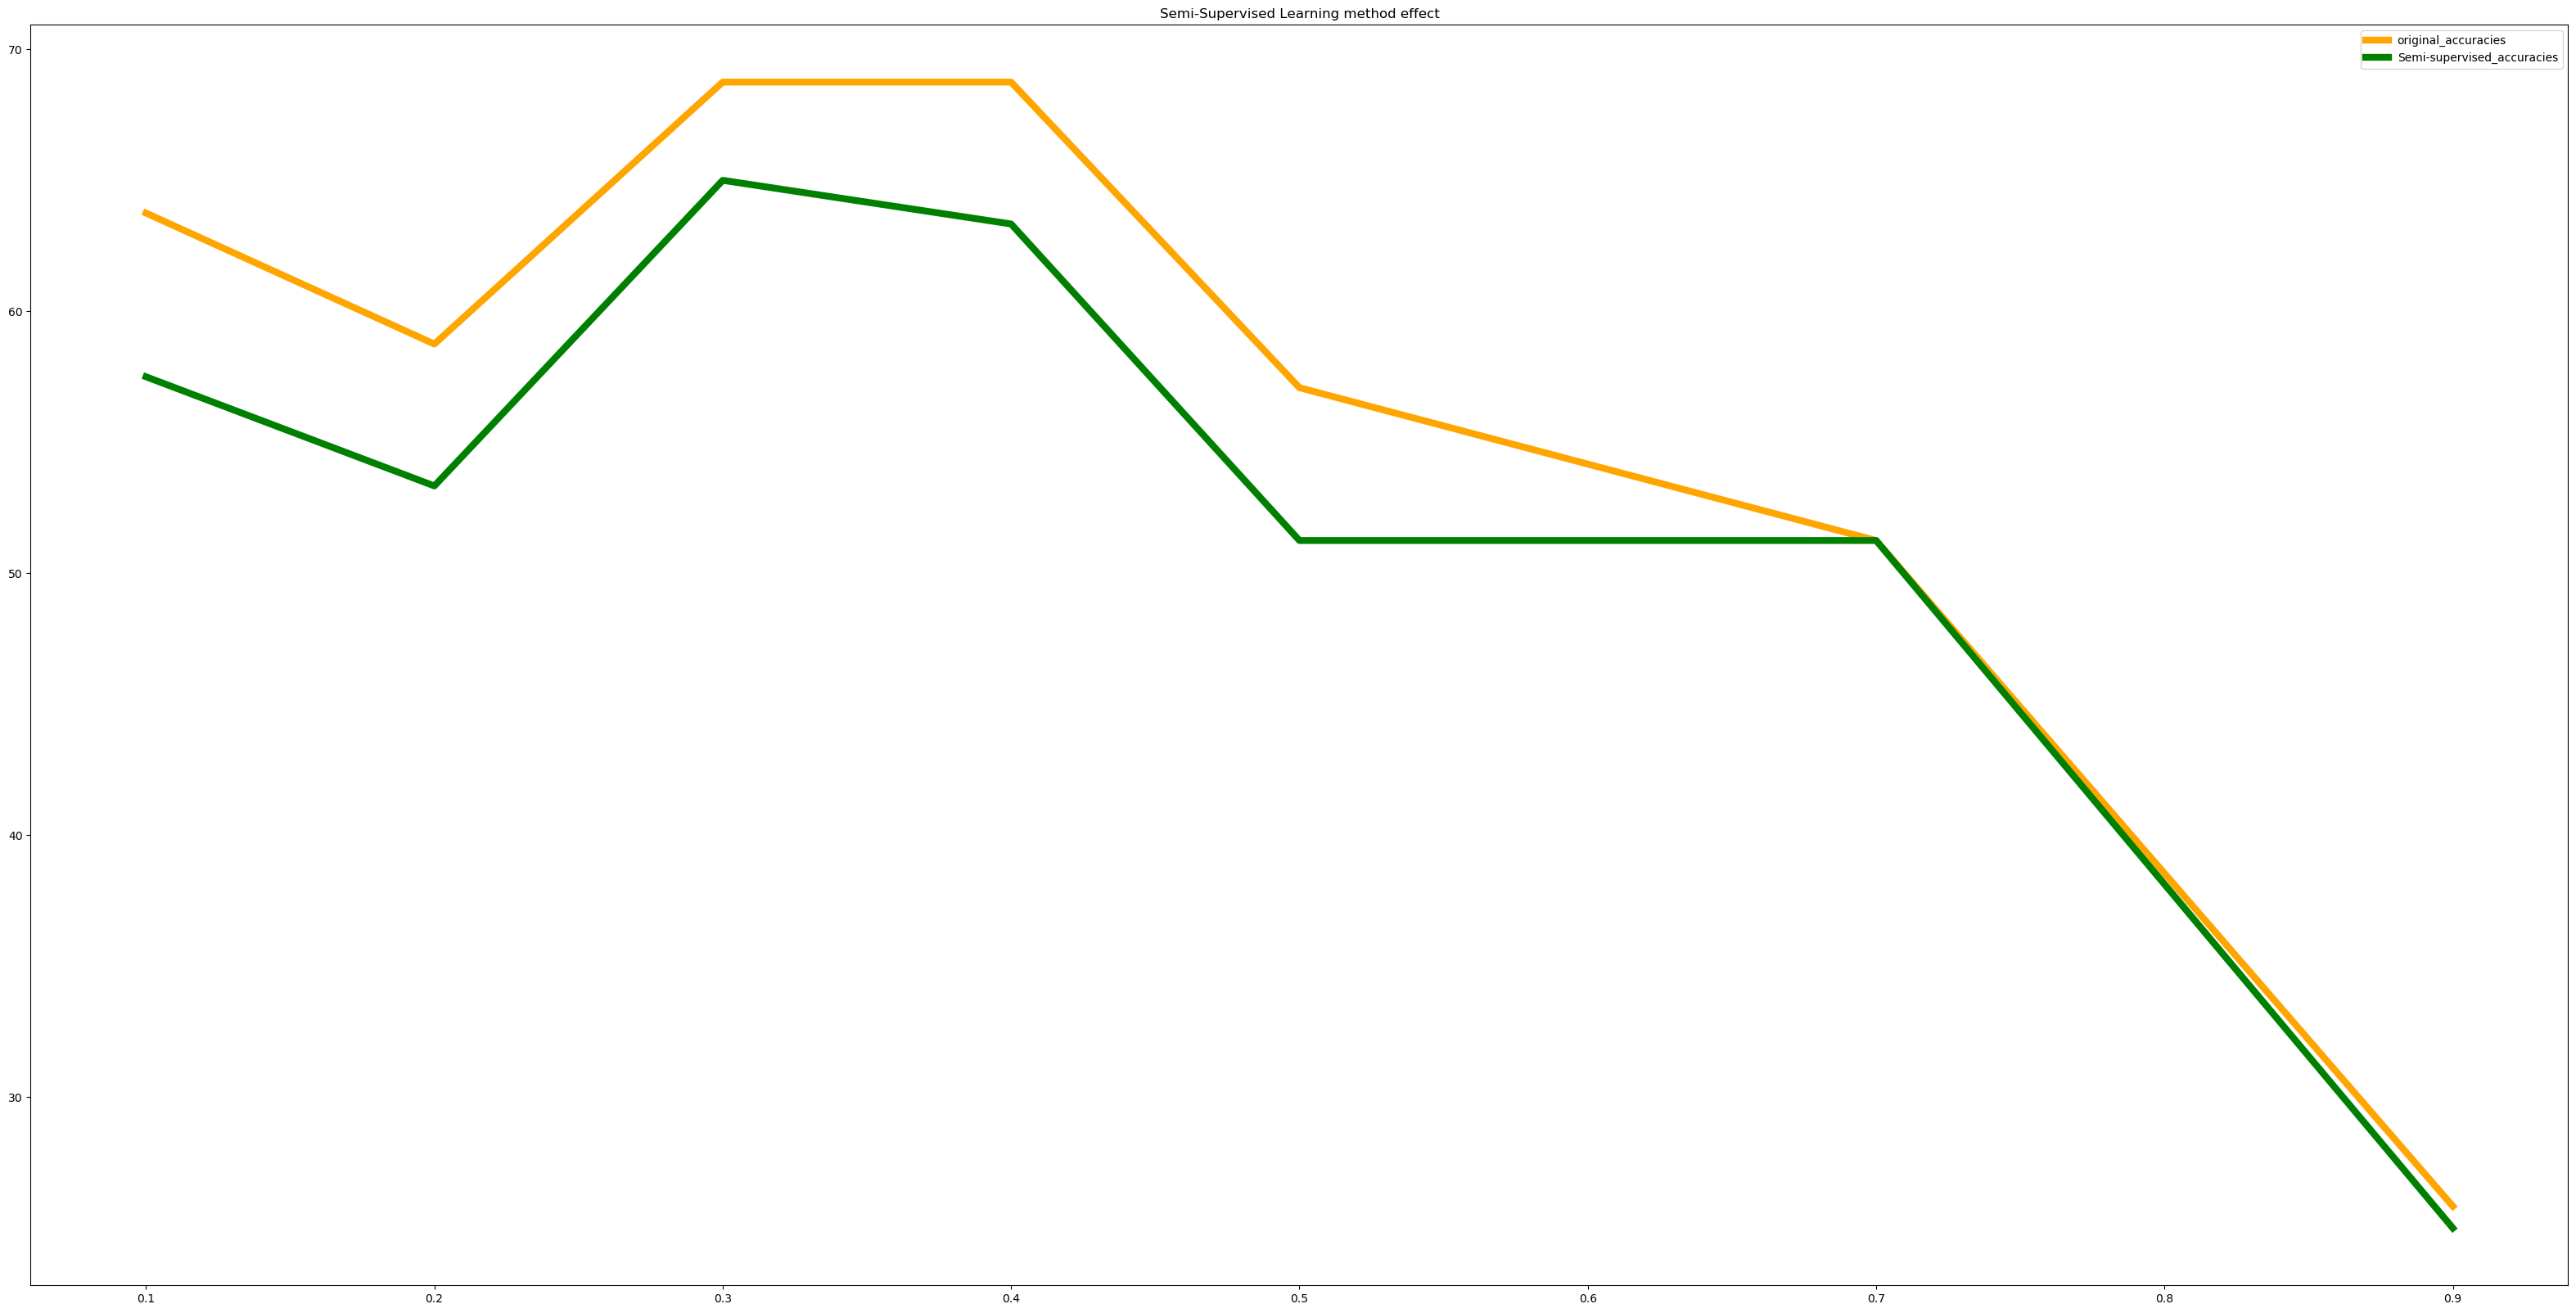

In [412]:
org_dic2 = res = dict(zip(parts, org_comp_accs2))
plot_accs(org_dic2, method_accs2,"Semi-Supervised Learning method effect")

[94.16666666666667, 94.16666666666667, 97.5, 97.5, 96.66666666666667, 91.25, 84.58333333333333]
[92.5, 88.75, 94.58333333333333, 95.83333333333334, 91.25, 90.83333333333333, 82.91666666666667]


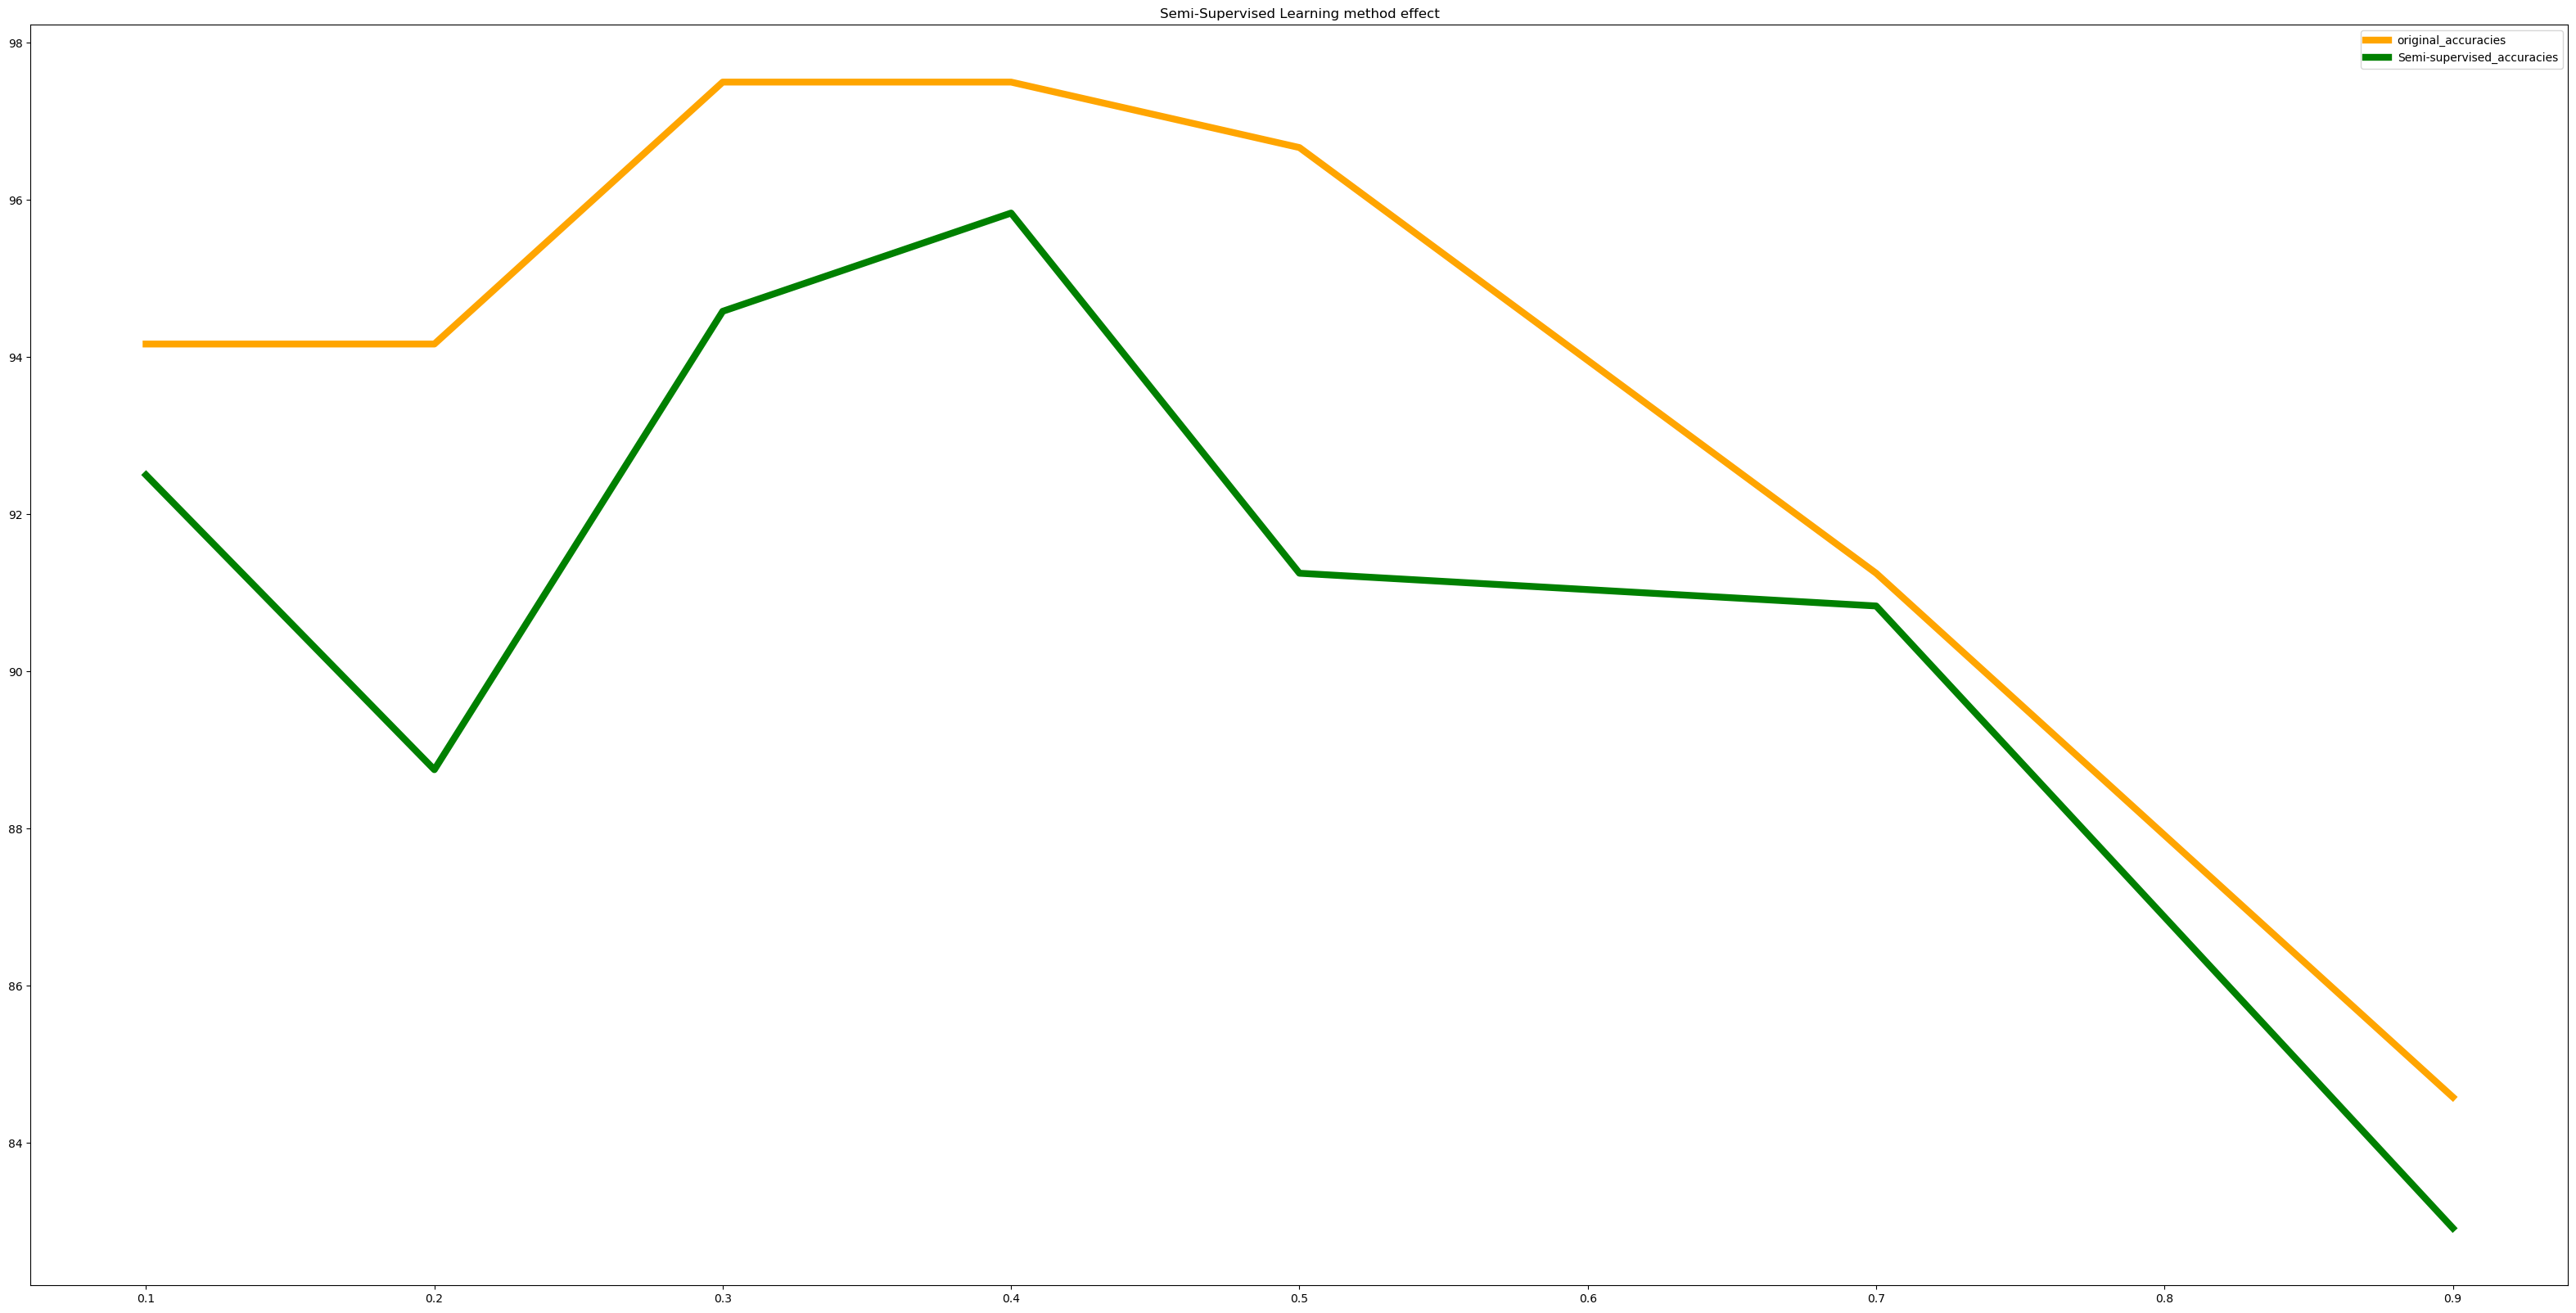

In [413]:
org_dic_room2 = res = dict(zip(parts, org_comp_accs_room2))
plot_accs(org_dic_room2, method_accs_room2,"Semi-Supervised Learning method effect")

In [414]:
parts = [0.1,0.2, 0.3,0.4, 0.5, 0.7, 0.9]

### ANN with Generated Data

In [415]:
method_accs3 = []
org_comp_accs3 = []
method_accs_room3 = []
org_comp_accs_room3 = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(1000, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_

    ann_model3 = keras.Sequential()
    ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
    ann_model3.add(keras.layers.Dense(60, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(80, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(96))
    ann_model3.summary()
    
    ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
    hist = ann_model3.fit(train_combined, all_labels , epochs=70,validation_split= 0.3)
    test_loss, test_acc = ann_model3.evaluate(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), alpha_filtered2_test.loc[:, ['location']], verbose=2)

    method_accs3.append(test_acc*100)

#     room_lev_atarget = []
#     for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
#         room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

#     room_lev_test_semi = []
#     for i in syn_semi_predictions_clf:
#         room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

#     method_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)

    ann_model3 = keras.Sequential()
    ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
    ann_model3.add(keras.layers.Dense(60, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(80, activation ='relu'))
    ann_model3.add(keras.layers.Dropout(0.1))
    ann_model3.add(keras.layers.Dense(96))
    ann_model3.summary()
    
    ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
    hist = ann_model3.fit(min_max_scaler.fit_transform(par_df), par_locations, epochs=70,validation_split= 0.3)
    test_loss, test_acc = ann_model3.evaluate(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), alpha_filtered2_test.loc[:, ['location']], verbose=2)

    org_comp_accs3.append(test_acc*100)

#     without_syn_predictions ,runtime = run_knn(min_max_scaler.fit_transform(par_df), par_locations, pd.DataFrame(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]), columns= no_channel_training_cols),[],3)

#     org_comp_accs2.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], without_syn_predictions)*100)

#     room_lev_test_without_pred_rf = []
#     for i in without_syn_predictions:
#         room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

#     org_comp_accs_room2.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_115 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_97 (Model)             [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_98 (Model)             (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 3s 44ms/step - loss: 14.3741 - accuracy: 0.0000e+00 - val_loss: 14.2216 - val_accuracy: 0.0000e+00
Epoch 2/100
76/76 [==============================] - 0s 895us/step - loss: 13.3911 - accuracy: 0.0000e+00 - val_loss: 13.4397 - val_accuracy: 0.0000e+00
Epoch 3/100
76/76 [==============

76/76 [==============================] - 0s 821us/step - loss: 3.9571 - accuracy: 0.6053 - val_loss: 5.8069 - val_accuracy: 0.6500
Epoch 53/100
76/76 [==============================] - 0s 851us/step - loss: 3.9583 - accuracy: 0.6711 - val_loss: 5.7885 - val_accuracy: 0.6500
Epoch 54/100
76/76 [==============================] - 0s 835us/step - loss: 3.9522 - accuracy: 0.6316 - val_loss: 6.1058 - val_accuracy: 0.6500
Epoch 55/100
76/76 [==============================] - 0s 844us/step - loss: 3.9074 - accuracy: 0.6842 - val_loss: 5.8366 - val_accuracy: 0.6500
Epoch 56/100
76/76 [==============================] - 0s 848us/step - loss: 3.8672 - accuracy: 0.6711 - val_loss: 5.6296 - val_accuracy: 0.6500
Epoch 57/100
76/76 [==============================] - 0s 843us/step - loss: 3.9094 - accuracy: 0.6447 - val_loss: 5.6514 - val_accuracy: 0.6500
Epoch 58/100
76/76 [==============================] - 0s 839us/step - loss: 3.8722 - accuracy: 0.6579 - val_loss: 5.5228 - val_accuracy: 0.6500
Epoch

767/767 [==============================] - 1s 2ms/step - loss: 4.2943 - accuracy: 0.1851 - val_loss: 3.9093 - val_accuracy: 0.2979
Epoch 2/70
767/767 [==============================] - 0s 234us/step - loss: 3.5437 - accuracy: 0.2621 - val_loss: 2.8978 - val_accuracy: 0.3526
Epoch 3/70
767/767 [==============================] - 0s 241us/step - loss: 2.9116 - accuracy: 0.3233 - val_loss: 2.4765 - val_accuracy: 0.4103
Epoch 4/70
767/767 [==============================] - 0s 240us/step - loss: 2.6236 - accuracy: 0.3364 - val_loss: 2.2313 - val_accuracy: 0.3739
Epoch 5/70
767/767 [==============================] - 0s 237us/step - loss: 2.4100 - accuracy: 0.3755 - val_loss: 2.0413 - val_accuracy: 0.4438
Epoch 6/70
767/767 [==============================] - 0s 237us/step - loss: 2.2805 - accuracy: 0.3872 - val_loss: 1.9276 - val_accuracy: 0.3891
Epoch 7/70
767/767 [==============================] - 0s 230us/step - loss: 2.1783 - accuracy: 0.4185 - val_loss: 1.8184 - val_accuracy: 0.4985
Epoch

767/767 [==============================] - 0s 250us/step - loss: 1.0827 - accuracy: 0.6571 - val_loss: 0.7542 - val_accuracy: 0.7751
Epoch 58/70
767/767 [==============================] - 0s 266us/step - loss: 1.0831 - accuracy: 0.6728 - val_loss: 0.7442 - val_accuracy: 0.7781
Epoch 59/70
767/767 [==============================] - 0s 247us/step - loss: 1.0290 - accuracy: 0.6819 - val_loss: 0.7416 - val_accuracy: 0.7568
Epoch 60/70
767/767 [==============================] - 0s 248us/step - loss: 1.0326 - accuracy: 0.6871 - val_loss: 0.7321 - val_accuracy: 0.7781
Epoch 61/70
767/767 [==============================] - 0s 272us/step - loss: 1.0375 - accuracy: 0.6923 - val_loss: 0.7397 - val_accuracy: 0.7629
Epoch 62/70
767/767 [==============================] - 0s 244us/step - loss: 1.0566 - accuracy: 0.6558 - val_loss: 0.7229 - val_accuracy: 0.7842
Epoch 63/70
767/767 [==============================] - 0s 248us/step - loss: 0.9960 - accuracy: 0.6832 - val_loss: 0.7276 - val_accuracy: 0.77

Epoch 36/70
67/67 [==============================] - 0s 324us/step - loss: 3.5415 - accuracy: 0.0597 - val_loss: 8.4104 - val_accuracy: 0.0000e+00
Epoch 37/70
67/67 [==============================] - 0s 332us/step - loss: 3.4877 - accuracy: 0.0896 - val_loss: 8.5504 - val_accuracy: 0.0000e+00
Epoch 38/70
67/67 [==============================] - 0s 320us/step - loss: 3.4521 - accuracy: 0.1045 - val_loss: 8.6788 - val_accuracy: 0.0000e+00
Epoch 39/70
67/67 [==============================] - 0s 318us/step - loss: 3.4130 - accuracy: 0.0597 - val_loss: 8.8004 - val_accuracy: 0.0000e+00
Epoch 40/70
67/67 [==============================] - 0s 320us/step - loss: 3.4238 - accuracy: 0.0597 - val_loss: 8.9179 - val_accuracy: 0.0000e+00
Epoch 41/70
67/67 [==============================] - 0s 329us/step - loss: 3.3716 - accuracy: 0.0597 - val_loss: 9.0354 - val_accuracy: 0.0000e+00
Epoch 42/70
67/67 [==============================] - 0s 338us/step - loss: 3.3301 - accuracy: 0.1194 - val_loss: 9.151

153/153 [==============================] - 0s 855us/step - loss: 4.4378 - accuracy: 0.4183 - val_loss: 6.5213 - val_accuracy: 0.6667
Epoch 17/100
153/153 [==============================] - 0s 818us/step - loss: 4.2124 - accuracy: 0.4052 - val_loss: 6.1203 - val_accuracy: 0.6667
Epoch 18/100
153/153 [==============================] - 0s 820us/step - loss: 4.1449 - accuracy: 0.3922 - val_loss: 5.9204 - val_accuracy: 0.6667
Epoch 19/100
153/153 [==============================] - 0s 791us/step - loss: 4.0780 - accuracy: 0.4248 - val_loss: 5.8772 - val_accuracy: 0.6667
Epoch 20/100
153/153 [==============================] - 0s 778us/step - loss: 4.0230 - accuracy: 0.4575 - val_loss: 5.8004 - val_accuracy: 0.6667
Epoch 21/100
153/153 [==============================] - 0s 815us/step - loss: 3.9403 - accuracy: 0.4902 - val_loss: 5.8651 - val_accuracy: 0.6667
Epoch 22/100
153/153 [==============================] - 0s 839us/step - loss: 3.9532 - accuracy: 0.4510 - val_loss: 5.7919 - val_accuracy

153/153 [==============================] - 0s 748us/step - loss: 3.6359 - accuracy: 0.6340 - val_loss: 5.3254 - val_accuracy: 0.6667
Epoch 73/100
153/153 [==============================] - 0s 726us/step - loss: 3.6832 - accuracy: 0.6340 - val_loss: 5.3522 - val_accuracy: 0.6667
Epoch 74/100
153/153 [==============================] - 0s 673us/step - loss: 3.6659 - accuracy: 0.6078 - val_loss: 5.7388 - val_accuracy: 0.6667
Epoch 75/100
153/153 [==============================] - 0s 663us/step - loss: 3.6597 - accuracy: 0.6078 - val_loss: 5.9677 - val_accuracy: 0.6667
Epoch 76/100
153/153 [==============================] - 0s 667us/step - loss: 3.6709 - accuracy: 0.6601 - val_loss: 5.8409 - val_accuracy: 0.6667
Epoch 77/100
153/153 [==============================] - 0s 696us/step - loss: 3.7097 - accuracy: 0.5948 - val_loss: 5.8522 - val_accuracy: 0.6667
Epoch 78/100
153/153 [==============================] - 0s 705us/step - loss: 3.6516 - accuracy: 0.6471 - val_loss: 5.7828 - val_accuracy

834/834 [==============================] - 0s 204us/step - loss: 1.9366 - accuracy: 0.4496 - val_loss: 1.3695 - val_accuracy: 0.6453
Epoch 22/70
834/834 [==============================] - 0s 200us/step - loss: 1.9192 - accuracy: 0.4772 - val_loss: 1.3184 - val_accuracy: 0.6453
Epoch 23/70
834/834 [==============================] - 0s 203us/step - loss: 1.8825 - accuracy: 0.4556 - val_loss: 1.2931 - val_accuracy: 0.6564
Epoch 24/70
834/834 [==============================] - 0s 201us/step - loss: 1.8647 - accuracy: 0.4688 - val_loss: 1.2566 - val_accuracy: 0.6536
Epoch 25/70
834/834 [==============================] - 0s 205us/step - loss: 1.8578 - accuracy: 0.4556 - val_loss: 1.2593 - val_accuracy: 0.6536
Epoch 26/70
834/834 [==============================] - 0s 207us/step - loss: 1.8417 - accuracy: 0.4784 - val_loss: 1.2300 - val_accuracy: 0.6844
Epoch 27/70
834/834 [==============================] - 0s 212us/step - loss: 1.7984 - accuracy: 0.5012 - val_loss: 1.2055 - val_accuracy: 0.66

Train on 134 samples, validate on 58 samples
Epoch 1/70
134/134 [==============================] - 1s 9ms/step - loss: 4.5815 - accuracy: 0.0075 - val_loss: 4.6055 - val_accuracy: 0.0000e+00
Epoch 2/70
134/134 [==============================] - 0s 260us/step - loss: 4.5462 - accuracy: 0.0000e+00 - val_loss: 4.6438 - val_accuracy: 0.0000e+00
Epoch 3/70
134/134 [==============================] - 0s 261us/step - loss: 4.5092 - accuracy: 0.0299 - val_loss: 4.6825 - val_accuracy: 0.0000e+00
Epoch 4/70
134/134 [==============================] - 0s 266us/step - loss: 4.4734 - accuracy: 0.0522 - val_loss: 4.7267 - val_accuracy: 0.0000e+00
Epoch 5/70
134/134 [==============================] - 0s 248us/step - loss: 4.4270 - accuracy: 0.0746 - val_loss: 4.7752 - val_accuracy: 0.0000e+00
Epoch 6/70
134/134 [==============================] - 0s 254us/step - loss: 4.3809 - accuracy: 0.0896 - val_loss: 4.8346 - val_accuracy: 0.0000e+00
Epoch 7/70
134/134 [==============================] - 0s 252us/st

134/134 [==============================] - 0s 247us/step - loss: 2.5740 - accuracy: 0.1791 - val_loss: 11.5528 - val_accuracy: 0.0000e+00
Epoch 56/70
134/134 [==============================] - 0s 258us/step - loss: 2.5273 - accuracy: 0.1940 - val_loss: 11.7177 - val_accuracy: 0.0000e+00
Epoch 57/70
134/134 [==============================] - 0s 246us/step - loss: 2.6008 - accuracy: 0.1642 - val_loss: 11.8788 - val_accuracy: 0.0000e+00
Epoch 58/70
134/134 [==============================] - 0s 248us/step - loss: 2.5536 - accuracy: 0.1493 - val_loss: 12.0503 - val_accuracy: 0.0000e+00
Epoch 59/70
134/134 [==============================] - 0s 250us/step - loss: 2.5617 - accuracy: 0.1716 - val_loss: 12.1719 - val_accuracy: 0.0000e+00
Epoch 60/70
134/134 [==============================] - 0s 249us/step - loss: 2.5841 - accuracy: 0.1418 - val_loss: 12.2138 - val_accuracy: 0.0000e+00
Epoch 61/70
134/134 [==============================] - 0s 241us/step - loss: 2.5687 - accuracy: 0.1866 - val_los

256/256 [==============================] - 0s 575us/step - loss: 3.7110 - accuracy: 0.4727 - val_loss: 5.4366 - val_accuracy: 0.6406
Epoch 36/100
256/256 [==============================] - 0s 550us/step - loss: 3.6728 - accuracy: 0.4883 - val_loss: 5.2598 - val_accuracy: 0.6406
Epoch 37/100
256/256 [==============================] - 0s 561us/step - loss: 3.6952 - accuracy: 0.5000 - val_loss: 5.1832 - val_accuracy: 0.6406
Epoch 38/100
256/256 [==============================] - 0s 556us/step - loss: 3.7011 - accuracy: 0.5078 - val_loss: 5.2080 - val_accuracy: 0.6406
Epoch 39/100
256/256 [==============================] - 0s 563us/step - loss: 3.7173 - accuracy: 0.5078 - val_loss: 5.2054 - val_accuracy: 0.6406
Epoch 40/100
256/256 [==============================] - 0s 556us/step - loss: 3.6976 - accuracy: 0.5039 - val_loss: 5.1196 - val_accuracy: 0.6406
Epoch 41/100
256/256 [==============================] - 0s 556us/step - loss: 3.6992 - accuracy: 0.4648 - val_loss: 5.2514 - val_accuracy

256/256 [==============================] - 0s 561us/step - loss: 3.5886 - accuracy: 0.5898 - val_loss: 4.8569 - val_accuracy: 0.6406
Epoch 92/100
256/256 [==============================] - 0s 569us/step - loss: 3.6041 - accuracy: 0.5586 - val_loss: 4.9294 - val_accuracy: 0.6406
Epoch 93/100
256/256 [==============================] - 0s 559us/step - loss: 3.5661 - accuracy: 0.6094 - val_loss: 4.7447 - val_accuracy: 0.6406
Epoch 94/100
256/256 [==============================] - 0s 556us/step - loss: 3.5897 - accuracy: 0.5977 - val_loss: 4.9123 - val_accuracy: 0.6406
Epoch 95/100
256/256 [==============================] - 0s 561us/step - loss: 3.5910 - accuracy: 0.5625 - val_loss: 4.8772 - val_accuracy: 0.6406
Epoch 96/100
256/256 [==============================] - 0s 555us/step - loss: 3.5646 - accuracy: 0.6250 - val_loss: 5.0213 - val_accuracy: 0.6406
Epoch 97/100
256/256 [==============================] - 0s 549us/step - loss: 3.6005 - accuracy: 0.5430 - val_loss: 4.9198 - val_accuracy

923/923 [==============================] - 0s 205us/step - loss: 1.7650 - accuracy: 0.4475 - val_loss: 1.1949 - val_accuracy: 0.6247
Epoch 41/70
923/923 [==============================] - 0s 208us/step - loss: 1.7022 - accuracy: 0.4767 - val_loss: 1.1708 - val_accuracy: 0.6448
Epoch 42/70
923/923 [==============================] - 0s 205us/step - loss: 1.7122 - accuracy: 0.4756 - val_loss: 1.1537 - val_accuracy: 0.6247
Epoch 43/70
923/923 [==============================] - 0s 204us/step - loss: 1.7017 - accuracy: 0.4670 - val_loss: 1.1444 - val_accuracy: 0.6499
Epoch 44/70
923/923 [==============================] - 0s 205us/step - loss: 1.6983 - accuracy: 0.4800 - val_loss: 1.1594 - val_accuracy: 0.6096
Epoch 45/70
923/923 [==============================] - 0s 203us/step - loss: 1.6882 - accuracy: 0.4800 - val_loss: 1.1479 - val_accuracy: 0.6297
Epoch 46/70
923/923 [==============================] - 0s 204us/step - loss: 1.6795 - accuracy: 0.4605 - val_loss: 1.1422 - val_accuracy: 0.68

Epoch 19/70
224/224 [==============================] - 0s 208us/step - loss: 3.1352 - accuracy: 0.1295 - val_loss: 8.6430 - val_accuracy: 0.0000e+00
Epoch 20/70
224/224 [==============================] - 0s 206us/step - loss: 3.0948 - accuracy: 0.0938 - val_loss: 8.8859 - val_accuracy: 0.0000e+00
Epoch 21/70
224/224 [==============================] - 0s 204us/step - loss: 3.0311 - accuracy: 0.1295 - val_loss: 9.0891 - val_accuracy: 0.0000e+00
Epoch 22/70
224/224 [==============================] - 0s 207us/step - loss: 3.0055 - accuracy: 0.1205 - val_loss: 9.3453 - val_accuracy: 0.0000e+00
Epoch 23/70
224/224 [==============================] - 0s 207us/step - loss: 2.9212 - accuracy: 0.1473 - val_loss: 9.5783 - val_accuracy: 0.0000e+00
Epoch 24/70
224/224 [==============================] - 0s 204us/step - loss: 2.9170 - accuracy: 0.1071 - val_loss: 9.8381 - val_accuracy: 0.0000e+00
Epoch 25/70
224/224 [==============================] - 0s 208us/step - loss: 2.8545 - accuracy: 0.1116 - v

Train on 384 samples, validate on 96 samples
Epoch 1/100
384/384 [==============================] - 3s 7ms/step - loss: 13.5122 - accuracy: 0.1406 - val_loss: 13.4204 - val_accuracy: 0.5521
Epoch 2/100
384/384 [==============================] - 0s 512us/step - loss: 11.4902 - accuracy: 0.1589 - val_loss: 12.4798 - val_accuracy: 0.5521
Epoch 3/100
384/384 [==============================] - 0s 513us/step - loss: 7.6857 - accuracy: 0.1589 - val_loss: 11.9738 - val_accuracy: 0.5521
Epoch 4/100
384/384 [==============================] - 0s 518us/step - loss: 6.6592 - accuracy: 0.4115 - val_loss: 10.8637 - val_accuracy: 0.1042
Epoch 5/100
384/384 [==============================] - 0s 519us/step - loss: 6.0172 - accuracy: 0.4167 - val_loss: 9.9038 - val_accuracy: 0.2188
Epoch 6/100
384/384 [==============================] - 0s 520us/step - loss: 5.0730 - accuracy: 0.4505 - val_loss: 8.6820 - val_accuracy: 0.5521
Epoch 7/100
384/384 [==============================] - 0s 517us/step - loss: 4.40

Epoch 57/100
384/384 [==============================] - 0s 1ms/step - loss: 3.3566 - accuracy: 0.4740 - val_loss: 4.9908 - val_accuracy: 0.3021
Epoch 58/100
384/384 [==============================] - 0s 816us/step - loss: 3.3178 - accuracy: 0.4844 - val_loss: 5.2768 - val_accuracy: 0.2812
Epoch 59/100
384/384 [==============================] - 0s 798us/step - loss: 3.3264 - accuracy: 0.4870 - val_loss: 5.6767 - val_accuracy: 0.2188
Epoch 60/100
384/384 [==============================] - 0s 788us/step - loss: 3.3287 - accuracy: 0.4922 - val_loss: 5.9385 - val_accuracy: 0.2708
Epoch 61/100
384/384 [==============================] - 0s 704us/step - loss: 3.3095 - accuracy: 0.5130 - val_loss: 6.1948 - val_accuracy: 0.2188
Epoch 62/100
384/384 [==============================] - 0s 671us/step - loss: 3.3302 - accuracy: 0.4740 - val_loss: 6.1172 - val_accuracy: 0.1667
Epoch 63/100
384/384 [==============================] - 0s 691us/step - loss: 3.3248 - accuracy: 0.4870 - val_loss: 5.6601 - v

Epoch 6/70
1036/1036 [==============================] - 0s 228us/step - loss: 3.1128 - accuracy: 0.1834 - val_loss: 2.5398 - val_accuracy: 0.2410
Epoch 7/70
1036/1036 [==============================] - 0s 230us/step - loss: 2.9827 - accuracy: 0.1979 - val_loss: 2.4108 - val_accuracy: 0.2635
Epoch 8/70
1036/1036 [==============================] - 0s 227us/step - loss: 2.8609 - accuracy: 0.2027 - val_loss: 2.3072 - val_accuracy: 0.2365
Epoch 9/70
1036/1036 [==============================] - 0s 213us/step - loss: 2.7413 - accuracy: 0.2249 - val_loss: 2.2066 - val_accuracy: 0.2725
Epoch 10/70
1036/1036 [==============================] - 0s 226us/step - loss: 2.6469 - accuracy: 0.2529 - val_loss: 2.1003 - val_accuracy: 0.3626
Epoch 11/70
1036/1036 [==============================] - 0s 225us/step - loss: 2.5742 - accuracy: 0.2597 - val_loss: 2.0189 - val_accuracy: 0.3919
Epoch 12/70
1036/1036 [==============================] - 0s 209us/step - loss: 2.5102 - accuracy: 0.2597 - val_loss: 1.955

Epoch 62/70
1036/1036 [==============================] - 0s 306us/step - loss: 1.6469 - accuracy: 0.4218 - val_loss: 1.0903 - val_accuracy: 0.6554
Epoch 63/70
1036/1036 [==============================] - 0s 293us/step - loss: 1.6565 - accuracy: 0.4353 - val_loss: 1.0852 - val_accuracy: 0.6802
Epoch 64/70
1036/1036 [==============================] - 0s 294us/step - loss: 1.6363 - accuracy: 0.4691 - val_loss: 1.0581 - val_accuracy: 0.6419
Epoch 65/70
1036/1036 [==============================] - 0s 285us/step - loss: 1.6530 - accuracy: 0.4344 - val_loss: 1.0600 - val_accuracy: 0.6824
Epoch 66/70
1036/1036 [==============================] - 0s 293us/step - loss: 1.6163 - accuracy: 0.4421 - val_loss: 1.0605 - val_accuracy: 0.6712
Epoch 67/70
1036/1036 [==============================] - 0s 279us/step - loss: 1.6123 - accuracy: 0.4643 - val_loss: 1.0491 - val_accuracy: 0.6757
Epoch 68/70
1036/1036 [==============================] - 0s 268us/step - loss: 1.6137 - accuracy: 0.4402 - val_loss: 1

336/336 [==============================] - 0s 250us/step - loss: 2.3276 - accuracy: 0.1994 - val_loss: 15.8941 - val_accuracy: 0.0139
Epoch 41/70
336/336 [==============================] - 0s 255us/step - loss: 2.3362 - accuracy: 0.1815 - val_loss: 15.9951 - val_accuracy: 0.0139
Epoch 42/70
336/336 [==============================] - 0s 255us/step - loss: 2.3105 - accuracy: 0.1815 - val_loss: 16.2146 - val_accuracy: 0.0139
Epoch 43/70
336/336 [==============================] - 0s 255us/step - loss: 2.2917 - accuracy: 0.1935 - val_loss: 16.3781 - val_accuracy: 0.0139
Epoch 44/70
336/336 [==============================] - 0s 250us/step - loss: 2.2785 - accuracy: 0.2351 - val_loss: 16.5371 - val_accuracy: 0.0139
Epoch 45/70
336/336 [==============================] - 0s 249us/step - loss: 2.2482 - accuracy: 0.2054 - val_loss: 16.6144 - val_accuracy: 0.0139
Epoch 46/70
336/336 [==============================] - 0s 252us/step - loss: 2.2751 - accuracy: 0.1756 - val_loss: 16.8568 - val_accurac

Epoch 21/100
384/384 [==============================] - 0s 731us/step - loss: 3.4654 - accuracy: 0.3984 - val_loss: 4.8236 - val_accuracy: 0.1771
Epoch 22/100
384/384 [==============================] - 0s 701us/step - loss: 3.4663 - accuracy: 0.3958 - val_loss: 4.8095 - val_accuracy: 0.2188
Epoch 23/100
384/384 [==============================] - 0s 692us/step - loss: 3.4556 - accuracy: 0.4427 - val_loss: 4.8065 - val_accuracy: 0.3229
Epoch 24/100
384/384 [==============================] - 0s 699us/step - loss: 3.4343 - accuracy: 0.4219 - val_loss: 4.7798 - val_accuracy: 0.3125
Epoch 25/100
384/384 [==============================] - 0s 696us/step - loss: 3.4622 - accuracy: 0.3906 - val_loss: 4.8691 - val_accuracy: 0.2292
Epoch 26/100
384/384 [==============================] - 0s 694us/step - loss: 3.4327 - accuracy: 0.4115 - val_loss: 4.7519 - val_accuracy: 0.4167
Epoch 27/100
384/384 [==============================] - 0s 689us/step - loss: 3.4526 - accuracy: 0.4115 - val_loss: 4.7585 -

384/384 [==============================] - 0s 666us/step - loss: 3.3256 - accuracy: 0.6120 - val_loss: 5.0479 - val_accuracy: 0.1667
Epoch 78/100
384/384 [==============================] - 0s 668us/step - loss: 3.3122 - accuracy: 0.6250 - val_loss: 5.0802 - val_accuracy: 0.1458
Epoch 79/100
384/384 [==============================] - 0s 669us/step - loss: 3.3341 - accuracy: 0.5885 - val_loss: 5.2986 - val_accuracy: 0.1458
Epoch 80/100
384/384 [==============================] - 0s 671us/step - loss: 3.2963 - accuracy: 0.6224 - val_loss: 5.0978 - val_accuracy: 0.1979
Epoch 81/100
384/384 [==============================] - 0s 664us/step - loss: 3.2923 - accuracy: 0.6302 - val_loss: 5.3627 - val_accuracy: 0.1875
Epoch 82/100
384/384 [==============================] - 0s 668us/step - loss: 3.2991 - accuracy: 0.6458 - val_loss: 5.1360 - val_accuracy: 0.1771
Epoch 83/100
384/384 [==============================] - 0s 653us/step - loss: 3.2992 - accuracy: 0.6120 - val_loss: 5.8400 - val_accuracy

Epoch 26/70
1036/1036 [==============================] - 0s 207us/step - loss: 2.0865 - accuracy: 0.3475 - val_loss: 1.4770 - val_accuracy: 0.5743
Epoch 27/70
1036/1036 [==============================] - 0s 207us/step - loss: 2.0835 - accuracy: 0.3340 - val_loss: 1.4770 - val_accuracy: 0.5923
Epoch 28/70
1036/1036 [==============================] - 0s 207us/step - loss: 2.0888 - accuracy: 0.3475 - val_loss: 1.4633 - val_accuracy: 0.5856
Epoch 29/70
1036/1036 [==============================] - 0s 207us/step - loss: 2.0416 - accuracy: 0.3514 - val_loss: 1.4440 - val_accuracy: 0.5901
Epoch 30/70
1036/1036 [==============================] - 0s 206us/step - loss: 2.0199 - accuracy: 0.3485 - val_loss: 1.4190 - val_accuracy: 0.6216
Epoch 31/70
1036/1036 [==============================] - 0s 207us/step - loss: 1.9544 - accuracy: 0.3880 - val_loss: 1.3990 - val_accuracy: 0.6149
Epoch 32/70
1036/1036 [==============================] - 0s 207us/step - loss: 1.9726 - accuracy: 0.3707 - val_loss: 1

336/336 [==============================] - 0s 236us/step - loss: 4.2722 - accuracy: 0.0506 - val_loss: 5.1590 - val_accuracy: 0.0000e+00
Epoch 5/70
336/336 [==============================] - 0s 236us/step - loss: 4.1266 - accuracy: 0.0655 - val_loss: 5.5373 - val_accuracy: 0.0000e+00
Epoch 6/70
336/336 [==============================] - 0s 237us/step - loss: 3.9713 - accuracy: 0.0565 - val_loss: 5.9395 - val_accuracy: 0.0000e+00
Epoch 7/70
336/336 [==============================] - 0s 232us/step - loss: 3.7957 - accuracy: 0.0565 - val_loss: 6.3082 - val_accuracy: 0.0000e+00
Epoch 8/70
336/336 [==============================] - 0s 237us/step - loss: 3.6339 - accuracy: 0.0833 - val_loss: 6.6888 - val_accuracy: 0.0000e+00
Epoch 9/70
336/336 [==============================] - 0s 237us/step - loss: 3.4959 - accuracy: 0.0655 - val_loss: 7.0460 - val_accuracy: 0.0000e+00
Epoch 10/70
336/336 [==============================] - 0s 239us/step - loss: 3.3921 - accuracy: 0.0625 - val_loss: 7.4800 -

Epoch 60/70
336/336 [==============================] - 0s 253us/step - loss: 2.0529 - accuracy: 0.2738 - val_loss: 18.3530 - val_accuracy: 0.0139
Epoch 61/70
336/336 [==============================] - 0s 245us/step - loss: 2.0823 - accuracy: 0.2411 - val_loss: 18.3878 - val_accuracy: 0.0139
Epoch 62/70
336/336 [==============================] - 0s 248us/step - loss: 2.0944 - accuracy: 0.2411 - val_loss: 18.4029 - val_accuracy: 0.0139
Epoch 63/70
336/336 [==============================] - 0s 248us/step - loss: 2.0405 - accuracy: 0.2321 - val_loss: 18.6333 - val_accuracy: 0.0139
Epoch 64/70
336/336 [==============================] - 0s 247us/step - loss: 2.0314 - accuracy: 0.2589 - val_loss: 18.7838 - val_accuracy: 0.0139
Epoch 65/70
336/336 [==============================] - 0s 250us/step - loss: 2.0398 - accuracy: 0.2619 - val_loss: 18.8047 - val_accuracy: 0.0139
Epoch 66/70
336/336 [==============================] - 0s 247us/step - loss: 2.0865 - accuracy: 0.2292 - val_loss: 18.8763 -

Epoch 41/100
511/511 [==============================] - 0s 735us/step - loss: 3.2532 - accuracy: 0.5656 - val_loss: 4.4237 - val_accuracy: 0.2812
Epoch 42/100
511/511 [==============================] - 0s 714us/step - loss: 3.2733 - accuracy: 0.5734 - val_loss: 4.5202 - val_accuracy: 0.6016
Epoch 43/100
511/511 [==============================] - 0s 741us/step - loss: 3.2405 - accuracy: 0.5675 - val_loss: 4.5700 - val_accuracy: 0.5859
Epoch 44/100
511/511 [==============================] - 0s 722us/step - loss: 3.2590 - accuracy: 0.5773 - val_loss: 4.5625 - val_accuracy: 0.5781
Epoch 45/100
511/511 [==============================] - 0s 774us/step - loss: 3.2510 - accuracy: 0.5734 - val_loss: 4.5413 - val_accuracy: 0.5781
Epoch 46/100
511/511 [==============================] - 0s 752us/step - loss: 3.2545 - accuracy: 0.5930 - val_loss: 4.5419 - val_accuracy: 0.6016
Epoch 47/100
511/511 [==============================] - 0s 786us/step - loss: 3.2320 - accuracy: 0.5636 - val_loss: 4.5664 -

511/511 [==============================] - 0s 744us/step - loss: 3.2167 - accuracy: 0.6027 - val_loss: 4.5495 - val_accuracy: 0.6016
Epoch 98/100
511/511 [==============================] - 0s 756us/step - loss: 3.2029 - accuracy: 0.5793 - val_loss: 4.5880 - val_accuracy: 0.1406
Epoch 99/100
511/511 [==============================] - 0s 826us/step - loss: 3.2170 - accuracy: 0.5793 - val_loss: 4.6874 - val_accuracy: 0.1094
Epoch 100/100
511/511 [==============================] - 0s 766us/step - loss: 3.2086 - accuracy: 0.6204 - val_loss: 4.5276 - val_accuracy: 0.5781
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_567 (Dense)            (None, 60)                1260      
_________________________________________________________________
dropout_57 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_568

Epoch 46/70
1147/1147 [==============================] - 0s 251us/step - loss: 1.8362 - accuracy: 0.3845 - val_loss: 1.3294 - val_accuracy: 0.6301
Epoch 47/70
1147/1147 [==============================] - 0s 248us/step - loss: 1.8464 - accuracy: 0.3618 - val_loss: 1.3146 - val_accuracy: 0.6159
Epoch 48/70
1147/1147 [==============================] - 0s 248us/step - loss: 1.8213 - accuracy: 0.3784 - val_loss: 1.3230 - val_accuracy: 0.5955
Epoch 49/70
1147/1147 [==============================] - 0s 246us/step - loss: 1.8183 - accuracy: 0.3766 - val_loss: 1.2595 - val_accuracy: 0.6240
Epoch 50/70
1147/1147 [==============================] - 0s 245us/step - loss: 1.8080 - accuracy: 0.3766 - val_loss: 1.2887 - val_accuracy: 0.6321
Epoch 51/70
1147/1147 [==============================] - 0s 245us/step - loss: 1.7912 - accuracy: 0.3819 - val_loss: 1.2837 - val_accuracy: 0.5833
Epoch 52/70
1147/1147 [==============================] - 0s 250us/step - loss: 1.7840 - accuracy: 0.3827 - val_loss: 1

447/447 [==============================] - 0s 236us/step - loss: 2.4927 - accuracy: 0.2103 - val_loss: 14.6168 - val_accuracy: 0.0156
Epoch 25/70
447/447 [==============================] - 0s 242us/step - loss: 2.4965 - accuracy: 0.1745 - val_loss: 15.1123 - val_accuracy: 0.0156
Epoch 26/70
447/447 [==============================] - 0s 238us/step - loss: 2.4989 - accuracy: 0.1700 - val_loss: 15.2088 - val_accuracy: 0.0156
Epoch 27/70
447/447 [==============================] - 0s 237us/step - loss: 2.4523 - accuracy: 0.1611 - val_loss: 15.4573 - val_accuracy: 0.0156
Epoch 28/70
447/447 [==============================] - 0s 240us/step - loss: 2.3995 - accuracy: 0.2103 - val_loss: 15.7186 - val_accuracy: 0.0156
Epoch 29/70
447/447 [==============================] - 0s 236us/step - loss: 2.4031 - accuracy: 0.2013 - val_loss: 15.9091 - val_accuracy: 0.0156
Epoch 30/70
447/447 [==============================] - 0s 239us/step - loss: 2.3963 - accuracy: 0.1723 - val_loss: 16.1832 - val_accurac

Epoch 5/100
690/690 [==============================] - 0s 598us/step - loss: 3.8164 - accuracy: 0.2971 - val_loss: 6.4931 - val_accuracy: 0.0694
Epoch 6/100
690/690 [==============================] - 0s 633us/step - loss: 3.5626 - accuracy: 0.2725 - val_loss: 6.0955 - val_accuracy: 0.0694
Epoch 7/100
690/690 [==============================] - 0s 613us/step - loss: 3.5376 - accuracy: 0.3087 - val_loss: 5.7178 - val_accuracy: 0.0694
Epoch 8/100
690/690 [==============================] - 0s 653us/step - loss: 3.4436 - accuracy: 0.3362 - val_loss: 5.5865 - val_accuracy: 0.0809
Epoch 9/100
690/690 [==============================] - 0s 615us/step - loss: 3.4241 - accuracy: 0.4174 - val_loss: 5.4619 - val_accuracy: 0.4971
Epoch 10/100
690/690 [==============================] - 0s 657us/step - loss: 3.3895 - accuracy: 0.4333 - val_loss: 5.2188 - val_accuracy: 0.6012
Epoch 11/100
690/690 [==============================] - 0s 663us/step - loss: 3.3690 - accuracy: 0.4217 - val_loss: 5.1696 - val_

690/690 [==============================] - 0s 666us/step - loss: 3.2082 - accuracy: 0.6507 - val_loss: 4.6585 - val_accuracy: 0.5954
Epoch 62/100
690/690 [==============================] - 0s 684us/step - loss: 3.2045 - accuracy: 0.6725 - val_loss: 4.5863 - val_accuracy: 0.5607
Epoch 63/100
690/690 [==============================] - 0s 669us/step - loss: 3.2210 - accuracy: 0.6768 - val_loss: 4.5293 - val_accuracy: 0.6012
Epoch 64/100
690/690 [==============================] - 0s 663us/step - loss: 3.1947 - accuracy: 0.6739 - val_loss: 4.5071 - val_accuracy: 0.5665
Epoch 65/100
690/690 [==============================] - 0s 680us/step - loss: 3.2026 - accuracy: 0.6826 - val_loss: 4.5854 - val_accuracy: 0.5896
Epoch 66/100
690/690 [==============================] - 0s 666us/step - loss: 3.2177 - accuracy: 0.6609 - val_loss: 4.7880 - val_accuracy: 0.6012
Epoch 67/100
690/690 [==============================] - 0s 689us/step - loss: 3.2136 - accuracy: 0.6725 - val_loss: 4.6296 - val_accuracy

Epoch 10/70
1304/1304 [==============================] - 0s 243us/step - loss: 2.5910 - accuracy: 0.2209 - val_loss: 1.9869 - val_accuracy: 0.4544
Epoch 11/70
1304/1304 [==============================] - 0s 239us/step - loss: 2.5250 - accuracy: 0.2201 - val_loss: 1.9155 - val_accuracy: 0.4705
Epoch 12/70
1304/1304 [==============================] - 0s 233us/step - loss: 2.4969 - accuracy: 0.2140 - val_loss: 1.8697 - val_accuracy: 0.5098
Epoch 13/70
1304/1304 [==============================] - 0s 254us/step - loss: 2.4471 - accuracy: 0.2354 - val_loss: 1.8136 - val_accuracy: 0.4669
Epoch 14/70
1304/1304 [==============================] - 0s 239us/step - loss: 2.4020 - accuracy: 0.2469 - val_loss: 1.7694 - val_accuracy: 0.4884
Epoch 15/70
1304/1304 [==============================] - 0s 289us/step - loss: 2.3535 - accuracy: 0.2477 - val_loss: 1.7391 - val_accuracy: 0.5170
Epoch 16/70
1304/1304 [==============================] - 0s 243us/step - loss: 2.3006 - accuracy: 0.2638 - val_loss: 1

Epoch 66/70
1304/1304 [==============================] - 0s 289us/step - loss: 1.5939 - accuracy: 0.4034 - val_loss: 1.1170 - val_accuracy: 0.7120
Epoch 67/70
1304/1304 [==============================] - 0s 288us/step - loss: 1.5977 - accuracy: 0.4072 - val_loss: 1.0910 - val_accuracy: 0.7227
Epoch 68/70
1304/1304 [==============================] - 0s 291us/step - loss: 1.5784 - accuracy: 0.4133 - val_loss: 1.0756 - val_accuracy: 0.7335
Epoch 69/70
1304/1304 [==============================] - 0s 288us/step - loss: 1.5583 - accuracy: 0.4333 - val_loss: 1.0846 - val_accuracy: 0.7191
Epoch 70/70
1304/1304 [==============================] - 0s 290us/step - loss: 1.5428 - accuracy: 0.4218 - val_loss: 1.0717 - val_accuracy: 0.6995
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_585 (Dense)            (None, 60)                1260      
____________________________________________

Epoch 45/70
604/604 [==============================] - 0s 283us/step - loss: 2.0115 - accuracy: 0.2583 - val_loss: 19.3103 - val_accuracy: 0.0154
Epoch 46/70
604/604 [==============================] - 0s 282us/step - loss: 2.0407 - accuracy: 0.2566 - val_loss: 19.3288 - val_accuracy: 0.0154
Epoch 47/70
604/604 [==============================] - 0s 288us/step - loss: 2.0450 - accuracy: 0.2632 - val_loss: 19.2105 - val_accuracy: 0.0154
Epoch 48/70
604/604 [==============================] - 0s 286us/step - loss: 2.0007 - accuracy: 0.2616 - val_loss: 19.4664 - val_accuracy: 0.0154
Epoch 49/70
604/604 [==============================] - 0s 285us/step - loss: 1.9830 - accuracy: 0.2533 - val_loss: 19.4224 - val_accuracy: 0.0154
Epoch 50/70
604/604 [==============================] - 0s 283us/step - loss: 1.9673 - accuracy: 0.2616 - val_loss: 19.7063 - val_accuracy: 0.0154
Epoch 51/70
604/604 [==============================] - 0s 287us/step - loss: 1.9981 - accuracy: 0.2699 - val_loss: 19.7552 -

[20.416666567325592, 15.000000596046448, 19.583334028720856, 22.91666716337204, 23.749999701976776, 15.416666865348816, 8.33333358168602]
[14.166666567325592, 21.250000596046448, 21.250000596046448, 19.166666269302368, 20.416666567325592, 18.75, 16.66666716337204]


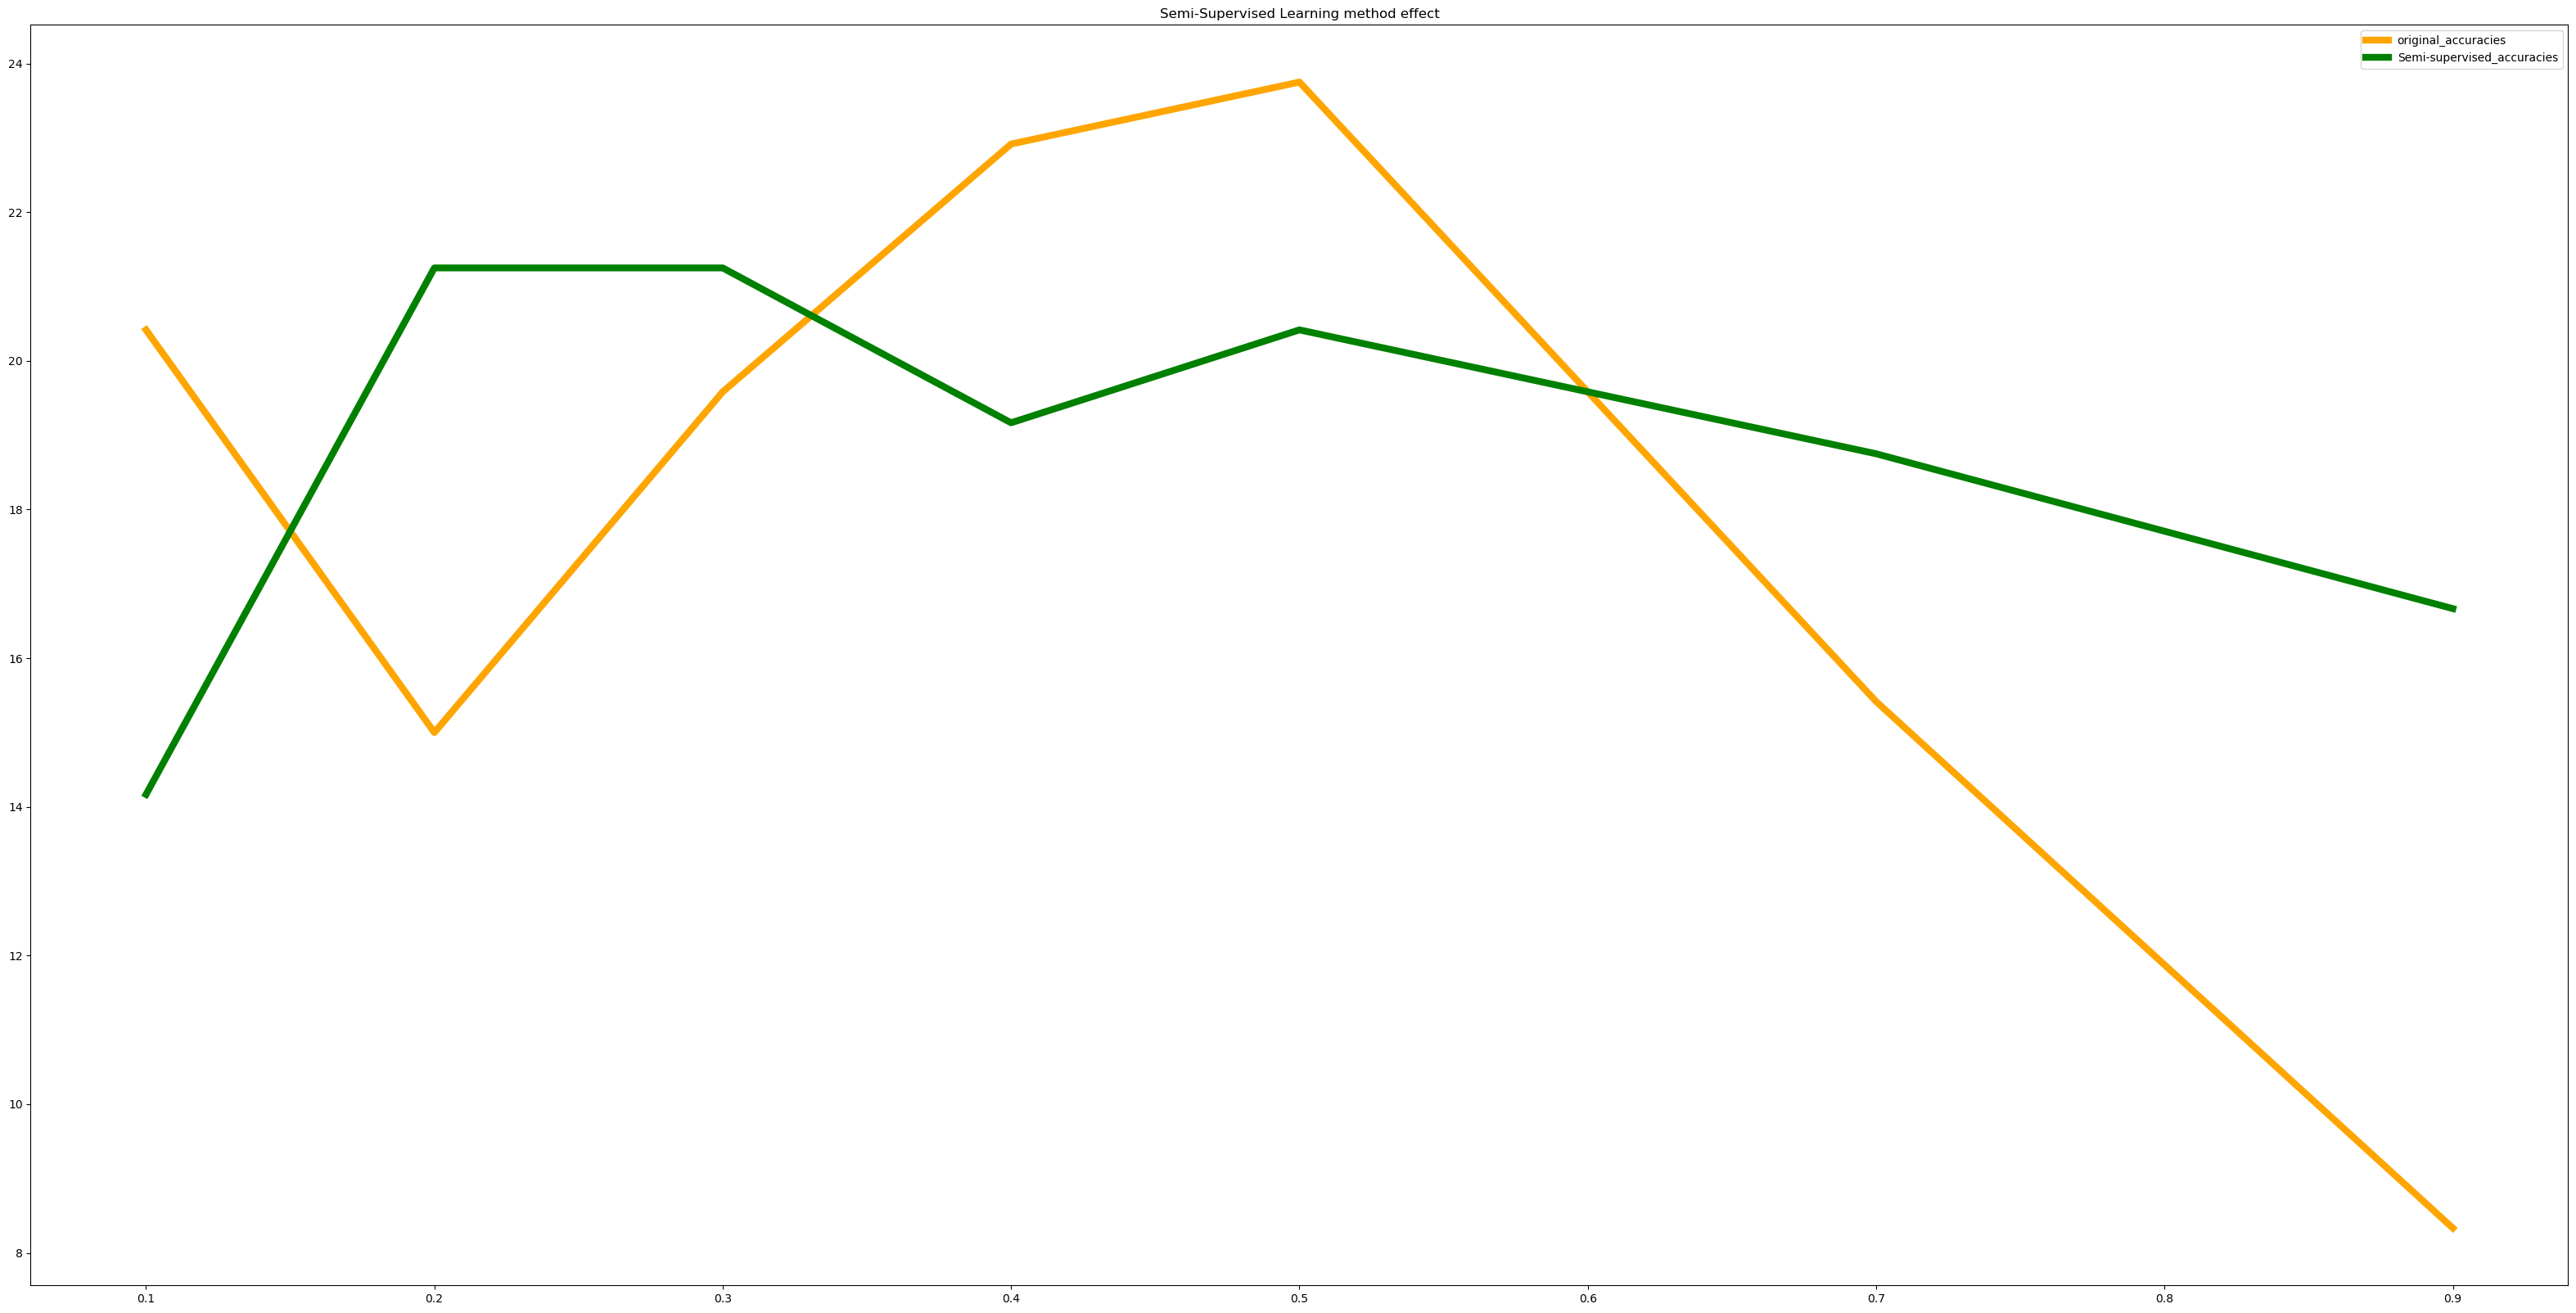

In [416]:
org_dic3 = res = dict(zip(parts, org_comp_accs3))
plot_accs(org_dic3, method_accs3,"Semi-Supervised Learning method effect")

## DTree with Generated Data

In [417]:
method_accs4 = []
org_comp_accs4 = []
method_accs_room4 = []
org_comp_accs_room4 = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(1000, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_

    grid_dt_parameters = {'criterion': ["entropy"], 'splitter': ["best", "random"],'max_depth': [3, 5, 8, 10, 15,20]}
    grid_dt = GridSearchCV(tree.DecisionTreeClassifier(),grid_dt_parameters,refit=True,verbose=2, cv = [(slice(None), slice(None))])
    print(grid_dt.fit(train_combined, all_labels))

    grid_dt_predictions = grid_dt.predict(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]))

    method_accs4.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], grid_dt_predictions)*100)

    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    room_lev_test_semi = []
    for i in grid_dt_predictions:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    method_accs_room4.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)

    grid_dt_parameters = {'criterion': ["entropy"], 'splitter': ["best", "random"],'max_depth': [3, 5, 8, 10, 15,20]}
    grid_dt = GridSearchCV(tree.DecisionTreeClassifier(),grid_dt_parameters,refit=True,verbose=2 , cv = [(slice(None), slice(None))])
    print(grid_dt.fit(min_max_scaler.fit_transform(par_df), par_locations))

    grid_dt_predictions = grid_dt.predict(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]))

    org_comp_accs4.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], grid_dt_predictions)*100)
    

    room_lev_test_without_pred_rf = []
    for i in grid_dt_predictions:
        room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    org_comp_accs_room4.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_143 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_111 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_112 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 4s 52ms/step - loss: 13.4850 - accuracy: 0.2237 - val_loss: 13.6960 - val_accuracy: 0.4000
Epoch 2/100
76/76 [==============================] - 0s 931us/step - loss: 12.9470 - accuracy: 0.2632 - val_loss: 13.4536 - val_accuracy: 0.4500
Epoch 3/100
76/76 [==============================

76/76 [==============================] - 0s 884us/step - loss: 4.0335 - accuracy: 0.5132 - val_loss: 6.5634 - val_accuracy: 0.6500
Epoch 53/100
76/76 [==============================] - 0s 859us/step - loss: 4.0609 - accuracy: 0.5658 - val_loss: 6.2462 - val_accuracy: 0.6500
Epoch 54/100
76/76 [==============================] - 0s 890us/step - loss: 4.0373 - accuracy: 0.5263 - val_loss: 6.3026 - val_accuracy: 0.6500
Epoch 55/100
76/76 [==============================] - 0s 880us/step - loss: 4.0279 - accuracy: 0.5132 - val_loss: 6.0656 - val_accuracy: 0.6500
Epoch 56/100
76/76 [==============================] - 0s 947us/step - loss: 4.0181 - accuracy: 0.5395 - val_loss: 6.3411 - val_accuracy: 0.6500
Epoch 57/100
76/76 [==============================] - 0s 851us/step - loss: 4.0863 - accuracy: 0.4868 - val_loss: 6.0937 - val_accuracy: 0.6500
Epoch 58/100
76/76 [==============================] - 0s 934us/step - loss: 4.0629 - accuracy: 0.5395 - val_loss: 5.9890 - val_accuracy: 0.6500
Epoch

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ......criterion=entropy, max_depth=3, splitter=best; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=3, splitter=random; total time=   0.0s
[CV] END ......criterion=entropy, max_depth=5, splitter=best; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=5, splitter=random; total time=   0.0s
[CV] END ......criterion=entropy, max_depth=8, splitter=best; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=8, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=10, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=10, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=15, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, spl

153/153 [==============================] - 0s 662us/step - loss: 3.7609 - accuracy: 0.6340 - val_loss: 5.5163 - val_accuracy: 0.9744
Epoch 43/100
153/153 [==============================] - 0s 652us/step - loss: 3.8225 - accuracy: 0.6209 - val_loss: 5.8845 - val_accuracy: 0.9744
Epoch 44/100
153/153 [==============================] - 0s 613us/step - loss: 3.7425 - accuracy: 0.6340 - val_loss: 5.2913 - val_accuracy: 0.9744
Epoch 45/100
153/153 [==============================] - 0s 653us/step - loss: 3.7711 - accuracy: 0.6340 - val_loss: 5.4444 - val_accuracy: 0.9744
Epoch 46/100
153/153 [==============================] - 0s 720us/step - loss: 3.7613 - accuracy: 0.6209 - val_loss: 5.6409 - val_accuracy: 0.9744
Epoch 47/100
153/153 [==============================] - 0s 713us/step - loss: 3.7690 - accuracy: 0.6405 - val_loss: 5.5513 - val_accuracy: 0.9744
Epoch 48/100
153/153 [==============================] - 0s 732us/step - loss: 3.8245 - accuracy: 0.6405 - val_loss: 5.3671 - val_accuracy

153/153 [==============================] - 0s 668us/step - loss: 3.7720 - accuracy: 0.7255 - val_loss: 4.9493 - val_accuracy: 0.9744
Epoch 99/100
153/153 [==============================] - 0s 662us/step - loss: 3.6679 - accuracy: 0.6928 - val_loss: 4.9175 - val_accuracy: 0.9744
Epoch 100/100
153/153 [==============================] - 0s 694us/step - loss: 3.6945 - accuracy: 0.7843 - val_loss: 5.1250 - val_accuracy: 0.9744
Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ......criterion=entropy, max_depth=3, splitter=best; total time=   0.1s
[CV] END ....criterion=entropy, max_depth=3, splitter=random; total time=   0.0s
[CV] END ......criterion=entropy, max_depth=5, splitter=best; total time=   0.1s
[CV] END ....criterion=entropy, max_depth=5, splitter=random; total time=   0.0s
[CV] END ......criterion=entropy, max_depth=8, splitter=best; total time=   0.1s
[CV] END ....criterion=entropy, max_depth=8, splitter=random; total time=   0.0s
[CV] END .....criterion=ent

256/256 [==============================] - 0s 664us/step - loss: 3.6802 - accuracy: 0.5000 - val_loss: 5.5974 - val_accuracy: 0.6406
Epoch 31/100
256/256 [==============================] - 0s 574us/step - loss: 3.6766 - accuracy: 0.4961 - val_loss: 5.5146 - val_accuracy: 0.6406
Epoch 32/100
256/256 [==============================] - 0s 586us/step - loss: 3.6700 - accuracy: 0.4766 - val_loss: 5.2965 - val_accuracy: 0.6406
Epoch 33/100
256/256 [==============================] - 0s 586us/step - loss: 3.7272 - accuracy: 0.4961 - val_loss: 5.2864 - val_accuracy: 0.6406
Epoch 34/100
256/256 [==============================] - 0s 591us/step - loss: 3.6499 - accuracy: 0.5156 - val_loss: 5.5442 - val_accuracy: 0.6406
Epoch 35/100
256/256 [==============================] - 0s 635us/step - loss: 3.6451 - accuracy: 0.5156 - val_loss: 5.4256 - val_accuracy: 0.6406
Epoch 36/100
256/256 [==============================] - 0s 640us/step - loss: 3.6643 - accuracy: 0.5117 - val_loss: 5.2804 - val_accuracy

256/256 [==============================] - 0s 650us/step - loss: 3.5461 - accuracy: 0.6055 - val_loss: 4.8507 - val_accuracy: 0.6406
Epoch 87/100
256/256 [==============================] - 0s 702us/step - loss: 3.5432 - accuracy: 0.6172 - val_loss: 4.8015 - val_accuracy: 0.6406
Epoch 88/100
256/256 [==============================] - 0s 730us/step - loss: 3.5545 - accuracy: 0.5898 - val_loss: 4.8082 - val_accuracy: 0.6406
Epoch 89/100
256/256 [==============================] - 0s 746us/step - loss: 3.5538 - accuracy: 0.6094 - val_loss: 5.1257 - val_accuracy: 0.6406
Epoch 90/100
256/256 [==============================] - 0s 705us/step - loss: 3.5588 - accuracy: 0.5898 - val_loss: 5.3183 - val_accuracy: 0.6406
Epoch 91/100
256/256 [==============================] - 0s 692us/step - loss: 3.5298 - accuracy: 0.6328 - val_loss: 4.9826 - val_accuracy: 0.6406
Epoch 92/100
256/256 [==============================] - 0s 676us/step - loss: 3.5570 - accuracy: 0.6602 - val_loss: 4.8876 - val_accuracy

384/384 [==============================] - 0s 625us/step - loss: 3.4913 - accuracy: 0.5208 - val_loss: 5.3074 - val_accuracy: 0.3333
Epoch 19/100
384/384 [==============================] - 0s 637us/step - loss: 3.4768 - accuracy: 0.4844 - val_loss: 5.3631 - val_accuracy: 0.4896
Epoch 20/100
384/384 [==============================] - 0s 621us/step - loss: 3.4724 - accuracy: 0.4453 - val_loss: 5.1367 - val_accuracy: 0.2292
Epoch 21/100
384/384 [==============================] - 0s 625us/step - loss: 3.4712 - accuracy: 0.4193 - val_loss: 5.1966 - val_accuracy: 0.4688
Epoch 22/100
384/384 [==============================] - 0s 632us/step - loss: 3.4479 - accuracy: 0.4531 - val_loss: 5.1337 - val_accuracy: 0.5312
Epoch 23/100
384/384 [==============================] - 0s 612us/step - loss: 3.4546 - accuracy: 0.4557 - val_loss: 5.0496 - val_accuracy: 0.5521
Epoch 24/100
384/384 [==============================] - 0s 707us/step - loss: 3.4320 - accuracy: 0.3906 - val_loss: 5.1971 - val_accuracy

384/384 [==============================] - 0s 692us/step - loss: 3.3061 - accuracy: 0.5625 - val_loss: 4.6946 - val_accuracy: 0.1667
Epoch 75/100
384/384 [==============================] - 0s 677us/step - loss: 3.2956 - accuracy: 0.5417 - val_loss: 4.7134 - val_accuracy: 0.3021
Epoch 76/100
384/384 [==============================] - 0s 707us/step - loss: 3.3292 - accuracy: 0.5182 - val_loss: 4.6264 - val_accuracy: 0.3438
Epoch 77/100
384/384 [==============================] - 0s 729us/step - loss: 3.3276 - accuracy: 0.5781 - val_loss: 4.7408 - val_accuracy: 0.3125
Epoch 78/100
384/384 [==============================] - 0s 720us/step - loss: 3.3152 - accuracy: 0.5677 - val_loss: 4.7356 - val_accuracy: 0.1979
Epoch 79/100
384/384 [==============================] - 0s 743us/step - loss: 3.3214 - accuracy: 0.5495 - val_loss: 4.7640 - val_accuracy: 0.3125
Epoch 80/100
384/384 [==============================] - 0s 774us/step - loss: 3.3075 - accuracy: 0.5729 - val_loss: 4.7431 - val_accuracy

384/384 [==============================] - 0s 726us/step - loss: 6.2490 - accuracy: 0.3932 - val_loss: 10.0044 - val_accuracy: 0.1146
Epoch 7/100
384/384 [==============================] - 0s 683us/step - loss: 5.8585 - accuracy: 0.4141 - val_loss: 9.0438 - val_accuracy: 0.1146
Epoch 8/100
384/384 [==============================] - 0s 687us/step - loss: 4.6168 - accuracy: 0.4401 - val_loss: 7.2777 - val_accuracy: 0.1146
Epoch 9/100
384/384 [==============================] - 0s 701us/step - loss: 3.8721 - accuracy: 0.4740 - val_loss: 6.1484 - val_accuracy: 0.1146
Epoch 10/100
384/384 [==============================] - 0s 685us/step - loss: 3.6469 - accuracy: 0.4297 - val_loss: 5.6872 - val_accuracy: 0.1146
Epoch 11/100
384/384 [==============================] - 0s 665us/step - loss: 3.5423 - accuracy: 0.4323 - val_loss: 5.5547 - val_accuracy: 0.1146
Epoch 12/100
384/384 [==============================] - 0s 654us/step - loss: 3.5122 - accuracy: 0.4505 - val_loss: 5.1375 - val_accuracy: 

384/384 [==============================] - 0s 839us/step - loss: 3.2961 - accuracy: 0.5052 - val_loss: 4.5633 - val_accuracy: 0.2083
Epoch 63/100
384/384 [==============================] - 0s 839us/step - loss: 3.3093 - accuracy: 0.4792 - val_loss: 4.6438 - val_accuracy: 0.1562
Epoch 64/100
384/384 [==============================] - 0s 827us/step - loss: 3.3087 - accuracy: 0.5547 - val_loss: 4.6870 - val_accuracy: 0.2292
Epoch 65/100
384/384 [==============================] - 0s 823us/step - loss: 3.3105 - accuracy: 0.5234 - val_loss: 4.5328 - val_accuracy: 0.2292
Epoch 66/100
384/384 [==============================] - 0s 868us/step - loss: 3.3054 - accuracy: 0.5286 - val_loss: 4.7192 - val_accuracy: 0.3854
Epoch 67/100
384/384 [==============================] - 0s 850us/step - loss: 3.3023 - accuracy: 0.5052 - val_loss: 4.6352 - val_accuracy: 0.2396
Epoch 68/100
384/384 [==============================] - 0s 830us/step - loss: 3.2928 - accuracy: 0.4974 - val_loss: 4.6244 - val_accuracy

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_153 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_121 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_122 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 511 samples, validate on 128 samples
Epoch 1/100
511/511 [==============================] - 5s 10ms/step - loss: 13.3480 - accuracy: 0.4305 - val_loss: 12.8582 - val_accuracy: 0.9141
Epoch 2/100
511/511 [==============================] - 1s 993us/step - loss: 9.1151 - accuracy: 0.4638 - val_loss: 11.3020 - val_accuracy: 0.9141
Epoch 3/100
511/511 [===========================

Epoch 52/100
511/511 [==============================] - 0s 852us/step - loss: 3.3118 - accuracy: 0.6145 - val_loss: 4.6887 - val_accuracy: 0.9062
Epoch 53/100
511/511 [==============================] - 0s 848us/step - loss: 3.2972 - accuracy: 0.6360 - val_loss: 4.6171 - val_accuracy: 0.8047
Epoch 54/100
511/511 [==============================] - 0s 850us/step - loss: 3.3020 - accuracy: 0.6614 - val_loss: 4.5745 - val_accuracy: 0.8828
Epoch 55/100
511/511 [==============================] - 0s 853us/step - loss: 3.2894 - accuracy: 0.6536 - val_loss: 4.5458 - val_accuracy: 0.9062
Epoch 56/100
511/511 [==============================] - 0s 848us/step - loss: 3.2778 - accuracy: 0.6321 - val_loss: 4.5094 - val_accuracy: 0.9141
Epoch 57/100
511/511 [==============================] - 0s 855us/step - loss: 3.3075 - accuracy: 0.6517 - val_loss: 4.6140 - val_accuracy: 0.7891
Epoch 58/100
511/511 [==============================] - 0s 850us/step - loss: 3.3257 - accuracy: 0.6477 - val_loss: 4.6478 -

[CV] END ......criterion=entropy, max_depth=5, splitter=best; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=5, splitter=random; total time=   0.0s
[CV] END ......criterion=entropy, max_depth=8, splitter=best; total time=   0.0s
[CV] END ....criterion=entropy, max_depth=8, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=10, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=10, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=15, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, splitter=random; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy'],
                    

690/690 [==============================] - 0s 707us/step - loss: 3.2352 - accuracy: 0.5986 - val_loss: 4.5967 - val_accuracy: 0.6012
Epoch 45/100
690/690 [==============================] - 0s 709us/step - loss: 3.2317 - accuracy: 0.6043 - val_loss: 4.6542 - val_accuracy: 0.6012
Epoch 46/100
690/690 [==============================] - 0s 710us/step - loss: 3.2303 - accuracy: 0.6217 - val_loss: 4.9072 - val_accuracy: 0.5145
Epoch 47/100
690/690 [==============================] - 0s 708us/step - loss: 3.2301 - accuracy: 0.6217 - val_loss: 4.8736 - val_accuracy: 0.6474
Epoch 48/100
690/690 [==============================] - 0s 697us/step - loss: 3.2222 - accuracy: 0.6000 - val_loss: 5.0684 - val_accuracy: 0.4624
Epoch 49/100
690/690 [==============================] - 0s 631us/step - loss: 3.2268 - accuracy: 0.6362 - val_loss: 4.5244 - val_accuracy: 0.6012
Epoch 50/100
690/690 [==============================] - 0s 674us/step - loss: 3.2286 - accuracy: 0.5913 - val_loss: 4.8731 - val_accuracy

690/690 [==============================] - 0s 714us/step - loss: 3.1806 - accuracy: 0.6957 - val_loss: 6.3230 - val_accuracy: 0.9075
Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ......criterion=entropy, max_depth=3, splitter=best; total time=   0.1s
[CV] END ....criterion=entropy, max_depth=3, splitter=random; total time=   0.0s
[CV] END ......criterion=entropy, max_depth=5, splitter=best; total time=   0.1s
[CV] END ....criterion=entropy, max_depth=5, splitter=random; total time=   0.0s
[CV] END ......criterion=entropy, max_depth=8, splitter=best; total time=   0.2s
[CV] END ....criterion=entropy, max_depth=8, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=10, splitter=best; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=15, splitter=best; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0

[34.166666666666664, 30.833333333333336, 40.416666666666664, 24.166666666666668, 27.500000000000004, 27.500000000000004, 24.166666666666668]
[35.833333333333336, 44.166666666666664, 45.416666666666664, 49.583333333333336, 50.416666666666664, 36.25, 33.75]


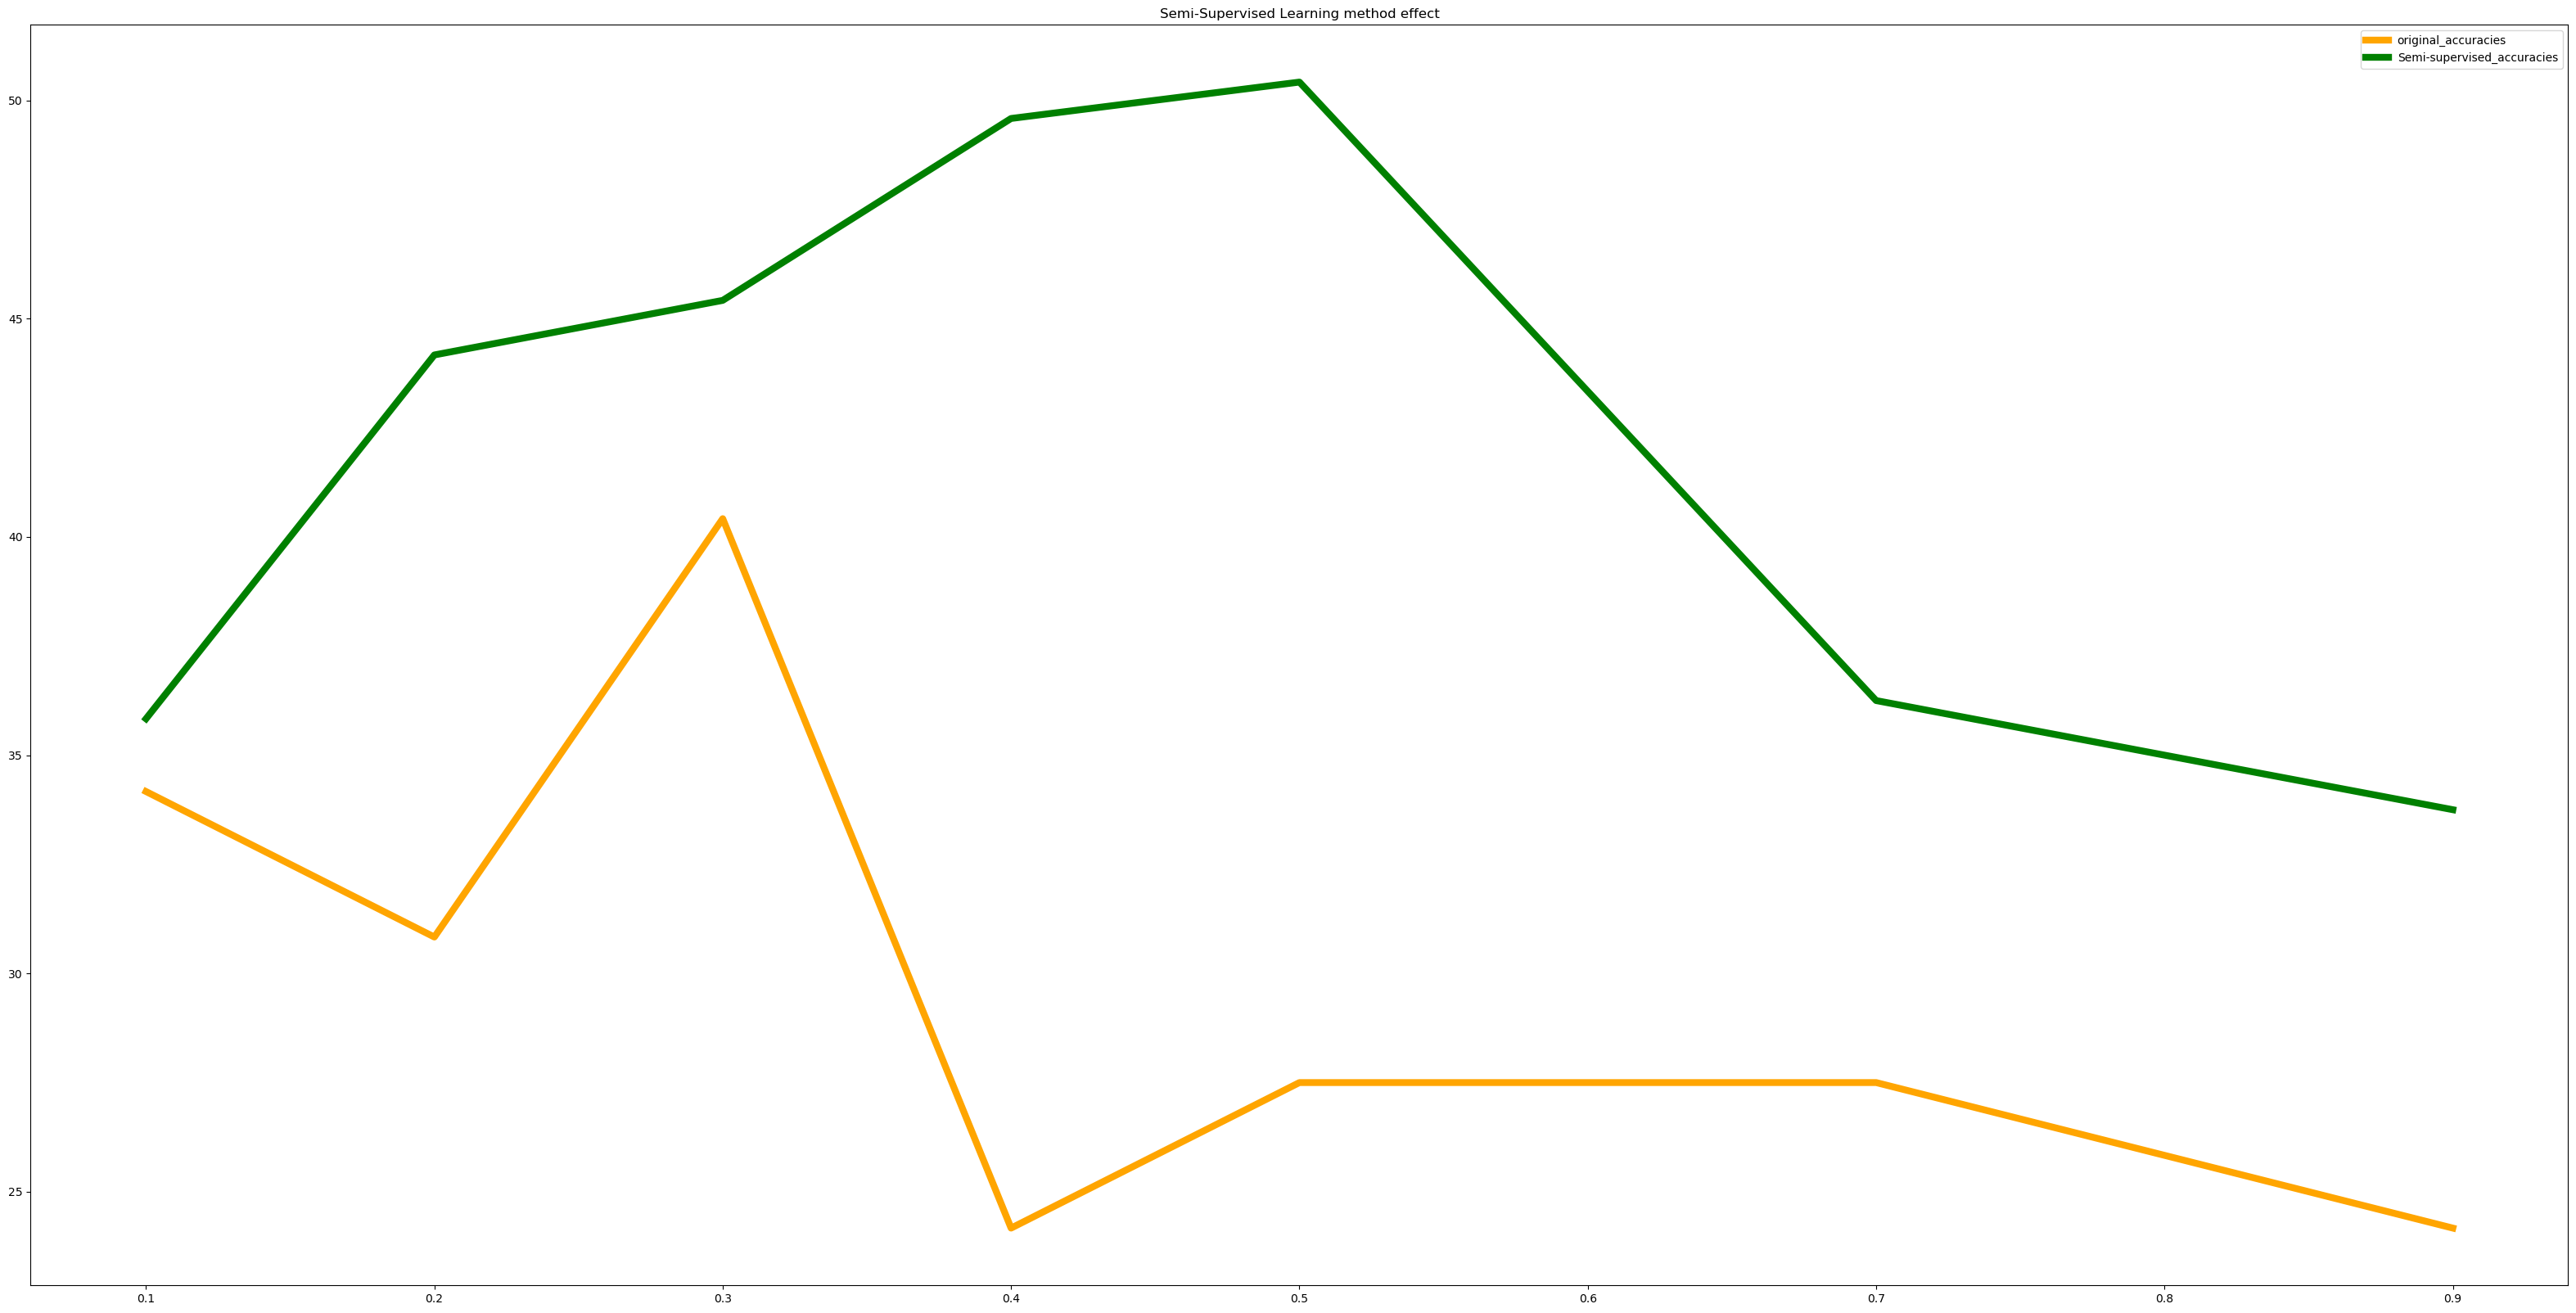

In [418]:
org_dic4 = res = dict(zip(parts, org_comp_accs4))
plot_accs(org_dic4, method_accs4,"Semi-Supervised Learning method effect")

[80.83333333333333, 74.58333333333333, 77.5, 67.91666666666667, 67.5, 62.083333333333336, 68.75]
[92.91666666666667, 85.0, 92.5, 92.5, 91.25, 82.5, 91.25]


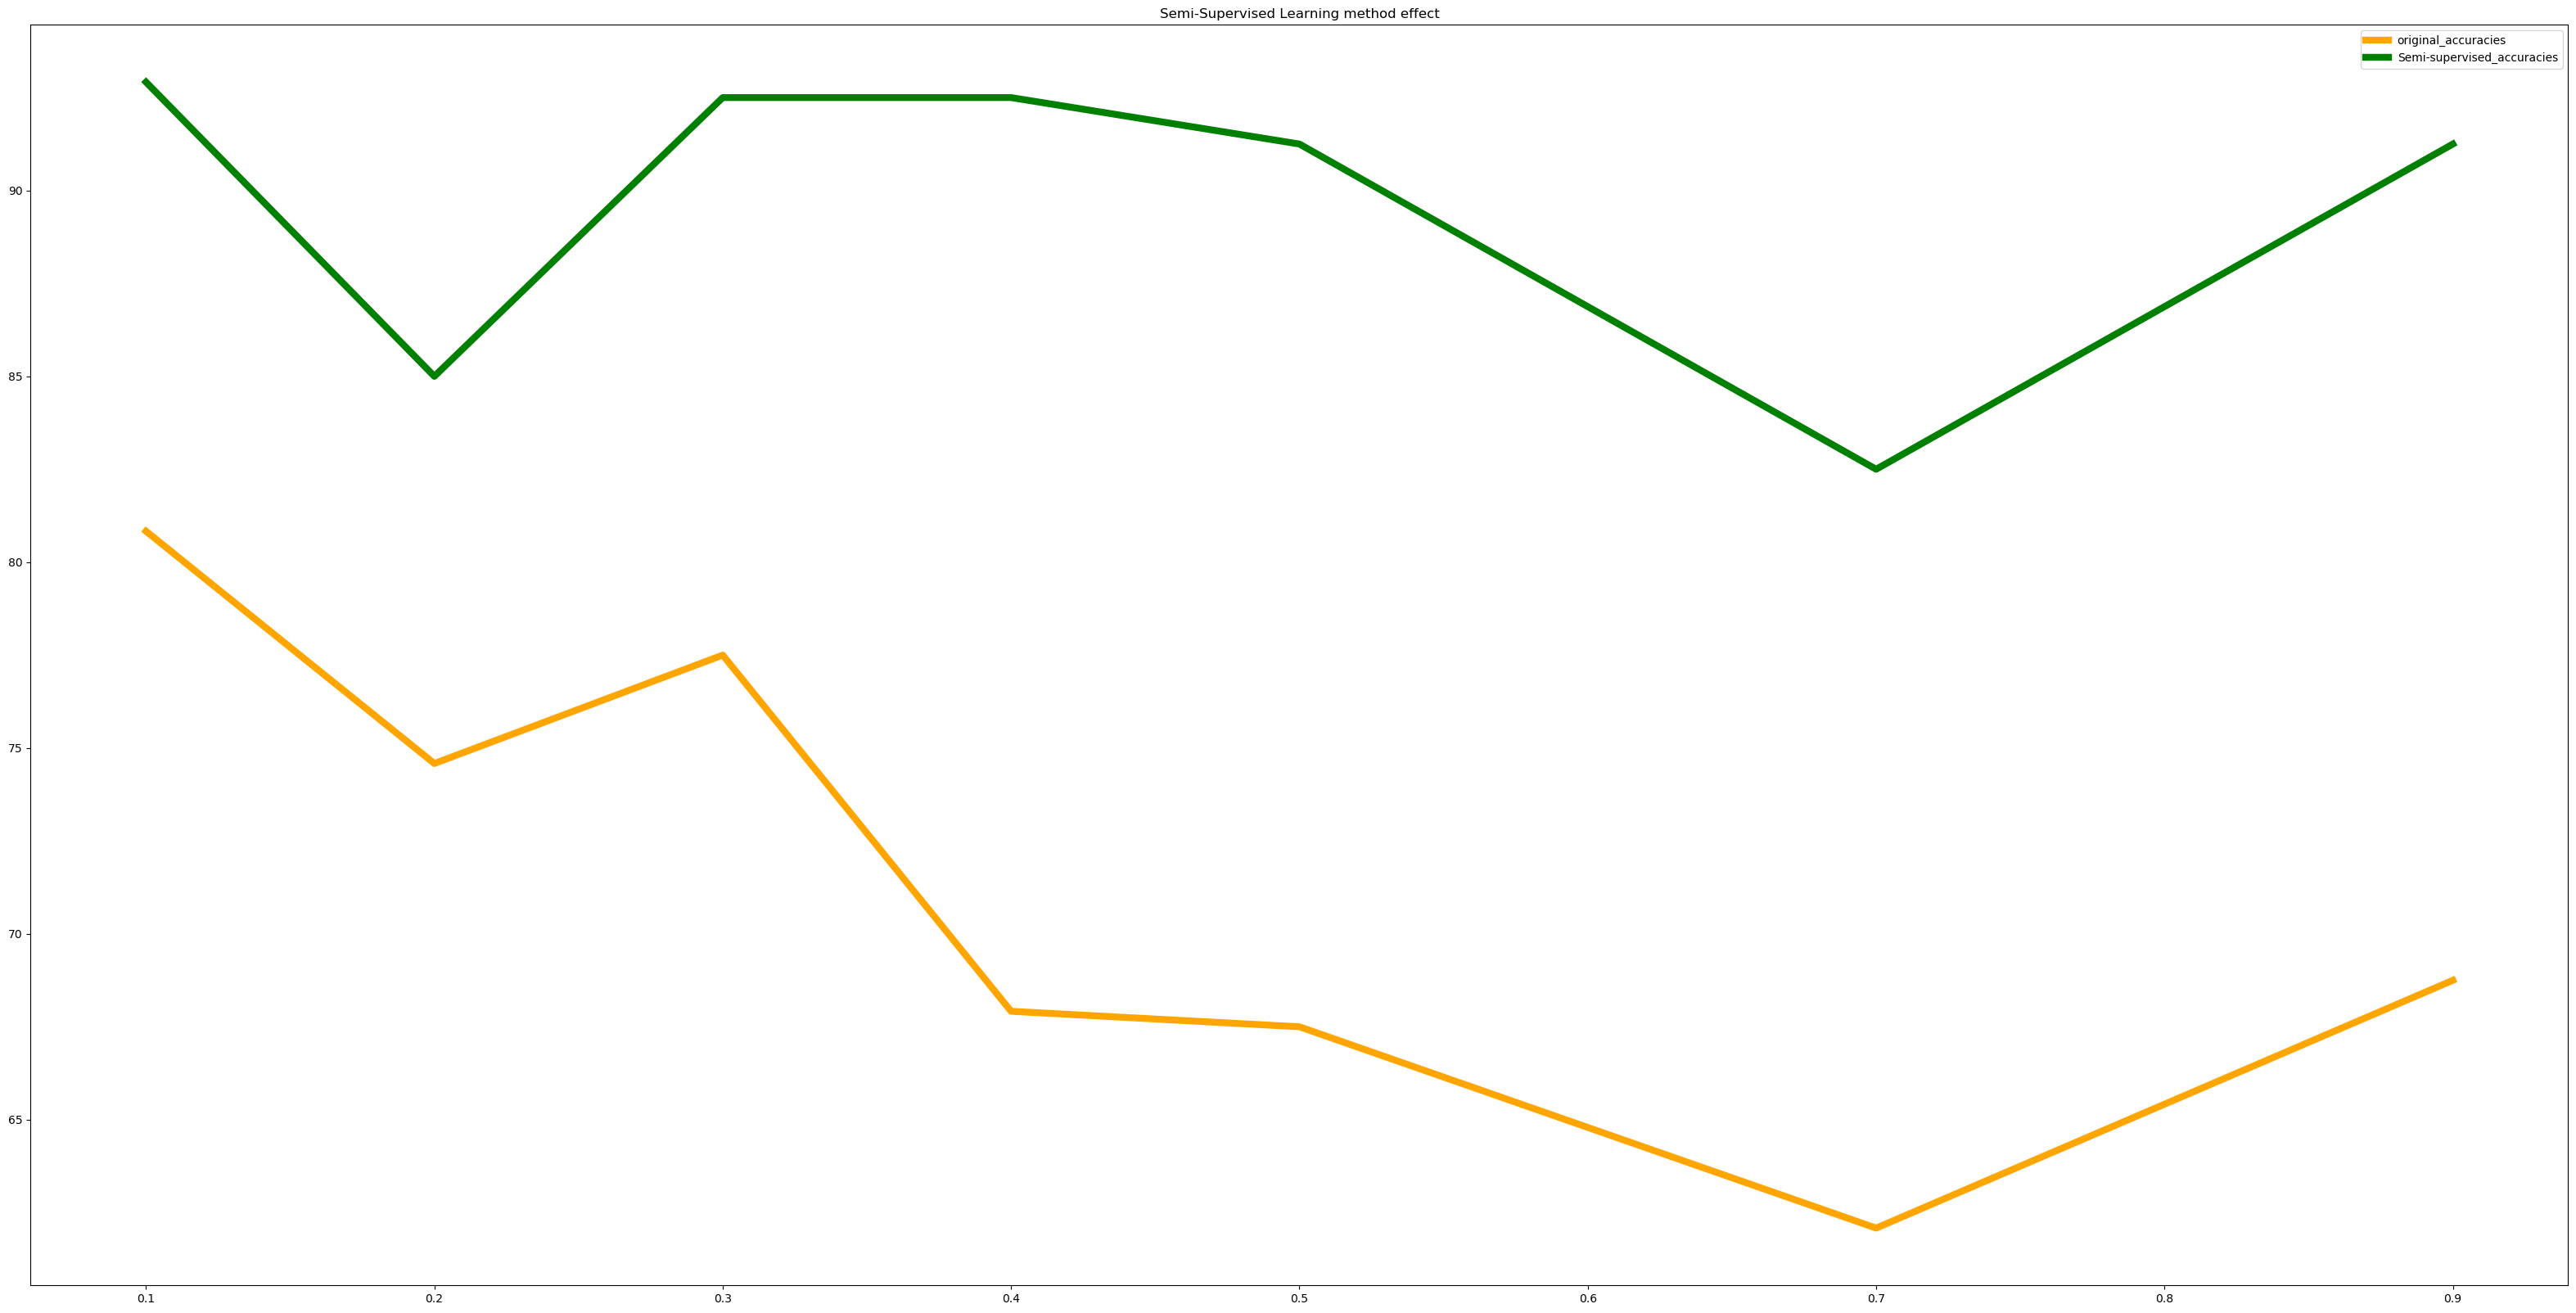

In [419]:
org_dic_room4 = res = dict(zip(parts, org_comp_accs_room4))
plot_accs(org_dic_room4, method_accs_room4,"Semi-Supervised Learning method effect")

## SVM

In [423]:
method_accs5 = []
org_comp_accs5 = []
method_accs_room5 = []
org_comp_accs_room5 = []
for par in parts:
    print(par)
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])

    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
    print(vae.summary())

    par_df, par_locations, par_df_test, par_test_loc = prep_data_for_synthesis(alpha_filtered2_train, par)

    his3 = vae.fit(min_max_scaler.fit_transform(par_df), min_max_scaler.fit_transform(par_df) , epochs = 100, batch_size = 8, validation_split= 0.2)

    outps = encoder.predict(min_max_scaler.fit_transform(par_df))

    new = generate_new_data(1000, outps)
    generated_dataframe = pd.DataFrame(new, columns = no_channel_training_cols)

    nolabels = [-1 for _ in range(len(generated_dataframe))]
    nolabels = pd.DataFrame(nolabels, columns = ['location'])
    frames = [pd.DataFrame(min_max_scaler.fit_transform(par_df), columns= no_channel_training_cols), generated_dataframe]
    train_combined = pd.concat(frames)

    semi_combined_lbs = pd.concat([par_locations, nolabels])
    label_propagator = LabelPropagation()
    label_propagator.fit(train_combined, semi_combined_lbs)
    all_labels = label_propagator.transduction_


    
    grid_svm_parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['poly','rbf', 'sigmoid','linear']}
    grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2,cv = [(slice(None), slice(None))])
    print(grid.fit(train_combined, all_labels))
    

    svm_grid_predictions = grid.predict(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]))


    
    method_accs5.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], svm_grid_predictions)*100)

    room_lev_atarget = []
    for i in alpha_filtered2_test.loc[:, ['location']].to_numpy():
        room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    room_lev_test_semi = []
    for i in svm_grid_predictions:
        room_lev_test_semi.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    method_accs_room5.append(accuracy_score(room_lev_atarget, room_lev_test_semi)*100)

   
    grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2, cv = [(slice(None), slice(None))])
    print(grid.fit(min_max_scaler.fit_transform(par_df), par_locations))

    svm_grid_predictions = grid.predict(min_max_scaler.fit_transform(alpha_filtered2_test.loc[:, no_channel_training_cols]))


    org_comp_accs5.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], svm_grid_predictions)*100)
    

    room_lev_test_without_pred_rf = []
    for i in svm_grid_predictions:
        room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

    org_comp_accs_room5.append(accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100)


0.1
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_159 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_127 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_128 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 76 samples, validate on 20 samples
Epoch 1/100
76/76 [==============================] - 2s 31ms/step - loss: 14.0217 - accuracy: 0.0000e+00 - val_loss: 14.0486 - val_accuracy: 0.0000e+00
Epoch 2/100
76/76 [==============================] - 0s 668us/step - loss: 13.7780 - accuracy: 0.0526 - val_loss: 13.8523 - val_accuracy: 0.1000
Epoch 3/100
76/76 [======================

76/76 [==============================] - 0s 678us/step - loss: 3.9252 - accuracy: 0.5395 - val_loss: 5.9936 - val_accuracy: 0.6500
Epoch 53/100
76/76 [==============================] - 0s 678us/step - loss: 3.8854 - accuracy: 0.5526 - val_loss: 5.6336 - val_accuracy: 0.6500
Epoch 54/100
76/76 [==============================] - 0s 684us/step - loss: 3.9652 - accuracy: 0.5000 - val_loss: 5.6226 - val_accuracy: 0.6500
Epoch 55/100
76/76 [==============================] - 0s 646us/step - loss: 3.9668 - accuracy: 0.5395 - val_loss: 5.5287 - val_accuracy: 0.6500
Epoch 56/100
76/76 [==============================] - 0s 594us/step - loss: 3.9419 - accuracy: 0.4868 - val_loss: 5.6159 - val_accuracy: 0.6500
Epoch 57/100
76/76 [==============================] - 0s 600us/step - loss: 4.0002 - accuracy: 0.5526 - val_loss: 5.5130 - val_accuracy: 0.6500
Epoch 58/100
76/76 [==============================] - 0s 609us/step - loss: 3.8409 - accuracy: 0.5526 - val_loss: 5.5194 - val_accuracy: 0.6500
Epoch

[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=   0.2s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.2s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.2s
[CV] END ...................

[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             ver

153/153 [==============================] - 0s 602us/step - loss: 3.8045 - accuracy: 0.5229 - val_loss: 5.3720 - val_accuracy: 0.6667
Epoch 45/100
153/153 [==============================] - 0s 752us/step - loss: 3.7740 - accuracy: 0.5359 - val_loss: 5.1761 - val_accuracy: 0.6667
Epoch 46/100
153/153 [==============================] - 0s 592us/step - loss: 3.7919 - accuracy: 0.5098 - val_loss: 5.2007 - val_accuracy: 0.6667
Epoch 47/100
153/153 [==============================] - 0s 573us/step - loss: 3.8110 - accuracy: 0.5490 - val_loss: 5.5469 - val_accuracy: 0.6667
Epoch 48/100
153/153 [==============================] - 0s 590us/step - loss: 3.7986 - accuracy: 0.5621 - val_loss: 5.3016 - val_accuracy: 0.6667
Epoch 49/100
153/153 [==============================] - 0s 545us/step - loss: 3.8014 - accuracy: 0.5163 - val_loss: 5.2966 - val_accuracy: 0.6667
Epoch 50/100
153/153 [==============================] - 0s 630us/step - loss: 3.7485 - accuracy: 0.5490 - val_loss: 5.4003 - val_accuracy

153/153 [==============================] - 0s 630us/step - loss: 3.6841 - accuracy: 0.5948 - val_loss: 4.9770 - val_accuracy: 0.6667
Fitting 1 folds for each of 64 candidates, totalling 64 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0

[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=10, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=10, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C

256/256 [==============================] - 0s 494us/step - loss: 3.7150 - accuracy: 0.4727 - val_loss: 4.9832 - val_accuracy: 0.6406
Epoch 34/100
256/256 [==============================] - 0s 499us/step - loss: 3.7098 - accuracy: 0.4766 - val_loss: 5.0852 - val_accuracy: 0.6406
Epoch 35/100
256/256 [==============================] - 0s 491us/step - loss: 3.7012 - accuracy: 0.4648 - val_loss: 5.1869 - val_accuracy: 0.6406
Epoch 36/100
256/256 [==============================] - 0s 499us/step - loss: 3.6946 - accuracy: 0.4961 - val_loss: 5.2661 - val_accuracy: 0.6406
Epoch 37/100
256/256 [==============================] - 0s 477us/step - loss: 3.6899 - accuracy: 0.4805 - val_loss: 4.9916 - val_accuracy: 0.6406
Epoch 38/100
256/256 [==============================] - 0s 445us/step - loss: 3.6679 - accuracy: 0.4766 - val_loss: 5.1260 - val_accuracy: 0.6406
Epoch 39/100
256/256 [==============================] - 0s 439us/step - loss: 3.6972 - accuracy: 0.4727 - val_loss: 5.2631 - val_accuracy

256/256 [==============================] - 0s 474us/step - loss: 3.6298 - accuracy: 0.4805 - val_loss: 4.8392 - val_accuracy: 0.6406
Epoch 90/100
256/256 [==============================] - 0s 483us/step - loss: 3.5988 - accuracy: 0.5039 - val_loss: 4.7166 - val_accuracy: 0.6406
Epoch 91/100
256/256 [==============================] - 0s 488us/step - loss: 3.5693 - accuracy: 0.4961 - val_loss: 4.8647 - val_accuracy: 0.6406
Epoch 92/100
256/256 [==============================] - 0s 480us/step - loss: 3.6127 - accuracy: 0.5039 - val_loss: 4.7868 - val_accuracy: 0.6406
Epoch 93/100
256/256 [==============================] - 0s 500us/step - loss: 3.6036 - accuracy: 0.4805 - val_loss: 4.7637 - val_accuracy: 0.6406
Epoch 94/100
256/256 [==============================] - 0s 504us/step - loss: 3.5946 - accuracy: 0.4805 - val_loss: 4.7759 - val_accuracy: 0.6406
Epoch 95/100
256/256 [==============================] - 0s 503us/step - loss: 3.5589 - accuracy: 0.4883 - val_loss: 4.8215 - val_accuracy

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................

384/384 [==============================] - 0s 595us/step - loss: 3.3882 - accuracy: 0.4245 - val_loss: 4.9948 - val_accuracy: 0.1146
Epoch 22/100
384/384 [==============================] - 0s 559us/step - loss: 3.4264 - accuracy: 0.3854 - val_loss: 5.1181 - val_accuracy: 0.2708
Epoch 23/100
384/384 [==============================] - 0s 560us/step - loss: 3.3945 - accuracy: 0.4375 - val_loss: 4.9379 - val_accuracy: 0.1146
Epoch 24/100
384/384 [==============================] - 0s 510us/step - loss: 3.3455 - accuracy: 0.4609 - val_loss: 4.8416 - val_accuracy: 0.1146
Epoch 25/100
384/384 [==============================] - 0s 468us/step - loss: 3.3479 - accuracy: 0.4193 - val_loss: 4.8672 - val_accuracy: 0.1458
Epoch 26/100
384/384 [==============================] - 0s 478us/step - loss: 3.3732 - accuracy: 0.4557 - val_loss: 4.7782 - val_accuracy: 0.1979
Epoch 27/100
384/384 [==============================] - 0s 573us/step - loss: 3.3476 - accuracy: 0.4401 - val_loss: 4.8924 - val_accuracy

384/384 [==============================] - 0s 527us/step - loss: 3.2726 - accuracy: 0.5521 - val_loss: 4.6186 - val_accuracy: 0.1146
Epoch 78/100
384/384 [==============================] - 0s 511us/step - loss: 3.2839 - accuracy: 0.6120 - val_loss: 5.0226 - val_accuracy: 0.1146
Epoch 79/100
384/384 [==============================] - 0s 483us/step - loss: 3.2683 - accuracy: 0.5651 - val_loss: 4.5722 - val_accuracy: 0.1146
Epoch 80/100
384/384 [==============================] - 0s 490us/step - loss: 3.2789 - accuracy: 0.5911 - val_loss: 4.7039 - val_accuracy: 0.1250
Epoch 81/100
384/384 [==============================] - 0s 475us/step - loss: 3.2563 - accuracy: 0.6016 - val_loss: 4.6458 - val_accuracy: 0.1146
Epoch 82/100
384/384 [==============================] - 0s 497us/step - loss: 3.2691 - accuracy: 0.6250 - val_loss: 4.7195 - val_accuracy: 0.1146
Epoch 83/100
384/384 [==============================] - 0s 486us/step - loss: 3.2822 - accuracy: 0.5964 - val_loss: 4.5794 - val_accuracy

[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.3s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ....................C=100, gamma=0.001, kernel=poly; total time=   0.4s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.5s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.3s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.2s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             verbose=2)
Fitting 1 folds for each of 64 candidates, totalling 64 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...

384/384 [==============================] - 0s 504us/step - loss: 3.7840 - accuracy: 0.3932 - val_loss: 6.4198 - val_accuracy: 0.1146
Epoch 9/100
384/384 [==============================] - 0s 442us/step - loss: 3.6945 - accuracy: 0.3854 - val_loss: 6.5092 - val_accuracy: 0.3021
Epoch 10/100
384/384 [==============================] - 0s 451us/step - loss: 3.6903 - accuracy: 0.4141 - val_loss: 5.8135 - val_accuracy: 0.2188
Epoch 11/100
384/384 [==============================] - 0s 516us/step - loss: 3.5825 - accuracy: 0.3958 - val_loss: 5.5731 - val_accuracy: 0.2812
Epoch 12/100
384/384 [==============================] - 0s 437us/step - loss: 3.5588 - accuracy: 0.4349 - val_loss: 5.5923 - val_accuracy: 0.2396
Epoch 13/100
384/384 [==============================] - 0s 443us/step - loss: 3.5178 - accuracy: 0.4297 - val_loss: 5.5408 - val_accuracy: 0.5104
Epoch 14/100
384/384 [==============================] - 0s 438us/step - loss: 3.5152 - accuracy: 0.4453 - val_loss: 5.5158 - val_accuracy:

384/384 [==============================] - 0s 502us/step - loss: 3.2927 - accuracy: 0.7292 - val_loss: 4.7191 - val_accuracy: 0.2396
Epoch 65/100
384/384 [==============================] - 0s 524us/step - loss: 3.3056 - accuracy: 0.7448 - val_loss: 4.6631 - val_accuracy: 0.1667
Epoch 66/100
384/384 [==============================] - 0s 440us/step - loss: 3.2984 - accuracy: 0.7214 - val_loss: 4.6534 - val_accuracy: 0.3125
Epoch 67/100
384/384 [==============================] - 0s 468us/step - loss: 3.3024 - accuracy: 0.7240 - val_loss: 4.6767 - val_accuracy: 0.2917
Epoch 68/100
384/384 [==============================] - 0s 473us/step - loss: 3.2921 - accuracy: 0.6849 - val_loss: 4.6727 - val_accuracy: 0.2500
Epoch 69/100
384/384 [==============================] - 0s 477us/step - loss: 3.2729 - accuracy: 0.7422 - val_loss: 4.5528 - val_accuracy: 0.1875
Epoch 70/100
384/384 [==============================] - 0s 463us/step - loss: 3.3149 - accuracy: 0.7500 - val_loss: 4.5551 - val_accuracy

[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.5s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.3s
[CV] END .......................C=10, gamma=0.1, kernel=poly; total time=   0.3s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END .....................C=10, gamma=0.1, kernel=linear; total time=   0.3s
[CV] END ......................C=10, gamma=0.01, kernel=poly; total time=   0.4s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.5s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.3s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.4s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.5s
[CV] END ..................C

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_169 (InputLayer)       (None, 20)                0         
_________________________________________________________________
model_137 (Model)            [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_138 (Model)            (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None
Train on 511 samples, validate on 128 samples
Epoch 1/100
511/511 [==============================] - 2s 4ms/step - loss: 12.9229 - accuracy: 0.3777 - val_loss: 11.7339 - val_accuracy: 0.9141
Epoch 2/100
511/511 [==============================] - 0s 467us/step - loss: 8.1402 - accuracy: 0.3836 - val_loss: 10.0831 - val_accuracy: 0.0000e+00
Epoch 3/100
511/511 [========================

Epoch 52/100
511/511 [==============================] - 0s 478us/step - loss: 3.2481 - accuracy: 0.5186 - val_loss: 4.7214 - val_accuracy: 0.5938
Epoch 53/100
511/511 [==============================] - 0s 492us/step - loss: 3.2505 - accuracy: 0.5088 - val_loss: 4.7247 - val_accuracy: 0.6016
Epoch 54/100
511/511 [==============================] - 0s 475us/step - loss: 3.2315 - accuracy: 0.5186 - val_loss: 4.7289 - val_accuracy: 0.6016
Epoch 55/100
511/511 [==============================] - 0s 622us/step - loss: 3.2349 - accuracy: 0.5362 - val_loss: 4.6098 - val_accuracy: 0.6016
Epoch 56/100
511/511 [==============================] - 0s 614us/step - loss: 3.2481 - accuracy: 0.5225 - val_loss: 4.5928 - val_accuracy: 0.5938
Epoch 57/100
511/511 [==============================] - 0s 602us/step - loss: 3.2310 - accuracy: 0.5401 - val_loss: 4.6562 - val_accuracy: 0.6016
Epoch 58/100
511/511 [==============================] - 0s 616us/step - loss: 3.2308 - accuracy: 0.5460 - val_loss: 4.5008 -

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.7s
[CV] END .................C=0.1, gamma=0.001, kernel=sigmoid; total time=   0.5s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.4s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=   0.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.4s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.4s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.6s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.5s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.4s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.5s
[CV] END ...................

[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   0.1s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.1s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.1s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=100, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

Epoch 41/100
690/690 [==============================] - 0s 551us/step - loss: 3.2372 - accuracy: 0.4014 - val_loss: 4.4987 - val_accuracy: 0.6012
Epoch 42/100
690/690 [==============================] - 0s 511us/step - loss: 3.2508 - accuracy: 0.4333 - val_loss: 4.5960 - val_accuracy: 0.6012
Epoch 43/100
690/690 [==============================] - 0s 556us/step - loss: 3.2463 - accuracy: 0.4348 - val_loss: 4.5214 - val_accuracy: 0.6012
Epoch 44/100
690/690 [==============================] - 0s 484us/step - loss: 3.2406 - accuracy: 0.4043 - val_loss: 4.5079 - val_accuracy: 0.6012
Epoch 45/100
690/690 [==============================] - 0s 489us/step - loss: 3.2311 - accuracy: 0.4029 - val_loss: 4.4356 - val_accuracy: 0.6012
Epoch 46/100
690/690 [==============================] - 0s 536us/step - loss: 3.2570 - accuracy: 0.4174 - val_loss: 4.5592 - val_accuracy: 0.4798
Epoch 47/100
690/690 [==============================] - 0s 520us/step - loss: 3.2612 - accuracy: 0.4768 - val_loss: 4.4691 -

690/690 [==============================] - 0s 529us/step - loss: 3.2089 - accuracy: 0.6623 - val_loss: 4.4698 - val_accuracy: 0.5896
Epoch 98/100
690/690 [==============================] - 0s 591us/step - loss: 3.2026 - accuracy: 0.6261 - val_loss: 4.4473 - val_accuracy: 0.6069
Epoch 99/100
690/690 [==============================] - 0s 617us/step - loss: 3.2016 - accuracy: 0.6362 - val_loss: 4.5181 - val_accuracy: 0.6012
Epoch 100/100
690/690 [==============================] - 0s 625us/step - loss: 3.2148 - accuracy: 0.6406 - val_loss: 4.4383 - val_accuracy: 0.5838
Fitting 1 folds for each of 64 candidates, totalling 64 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END ......................C=0.1, gamma

[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.2s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.1s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.2s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.1s
[CV] END .......................C=10, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[42.5, 43.333333333333336, 53.75, 53.75, 60.416666666666664, 55.41666666666667, 44.166666666666664]
[42.916666666666664, 42.916666666666664, 54.58333333333333, 48.75, 58.333333333333336, 55.00000000000001, 45.416666666666664]


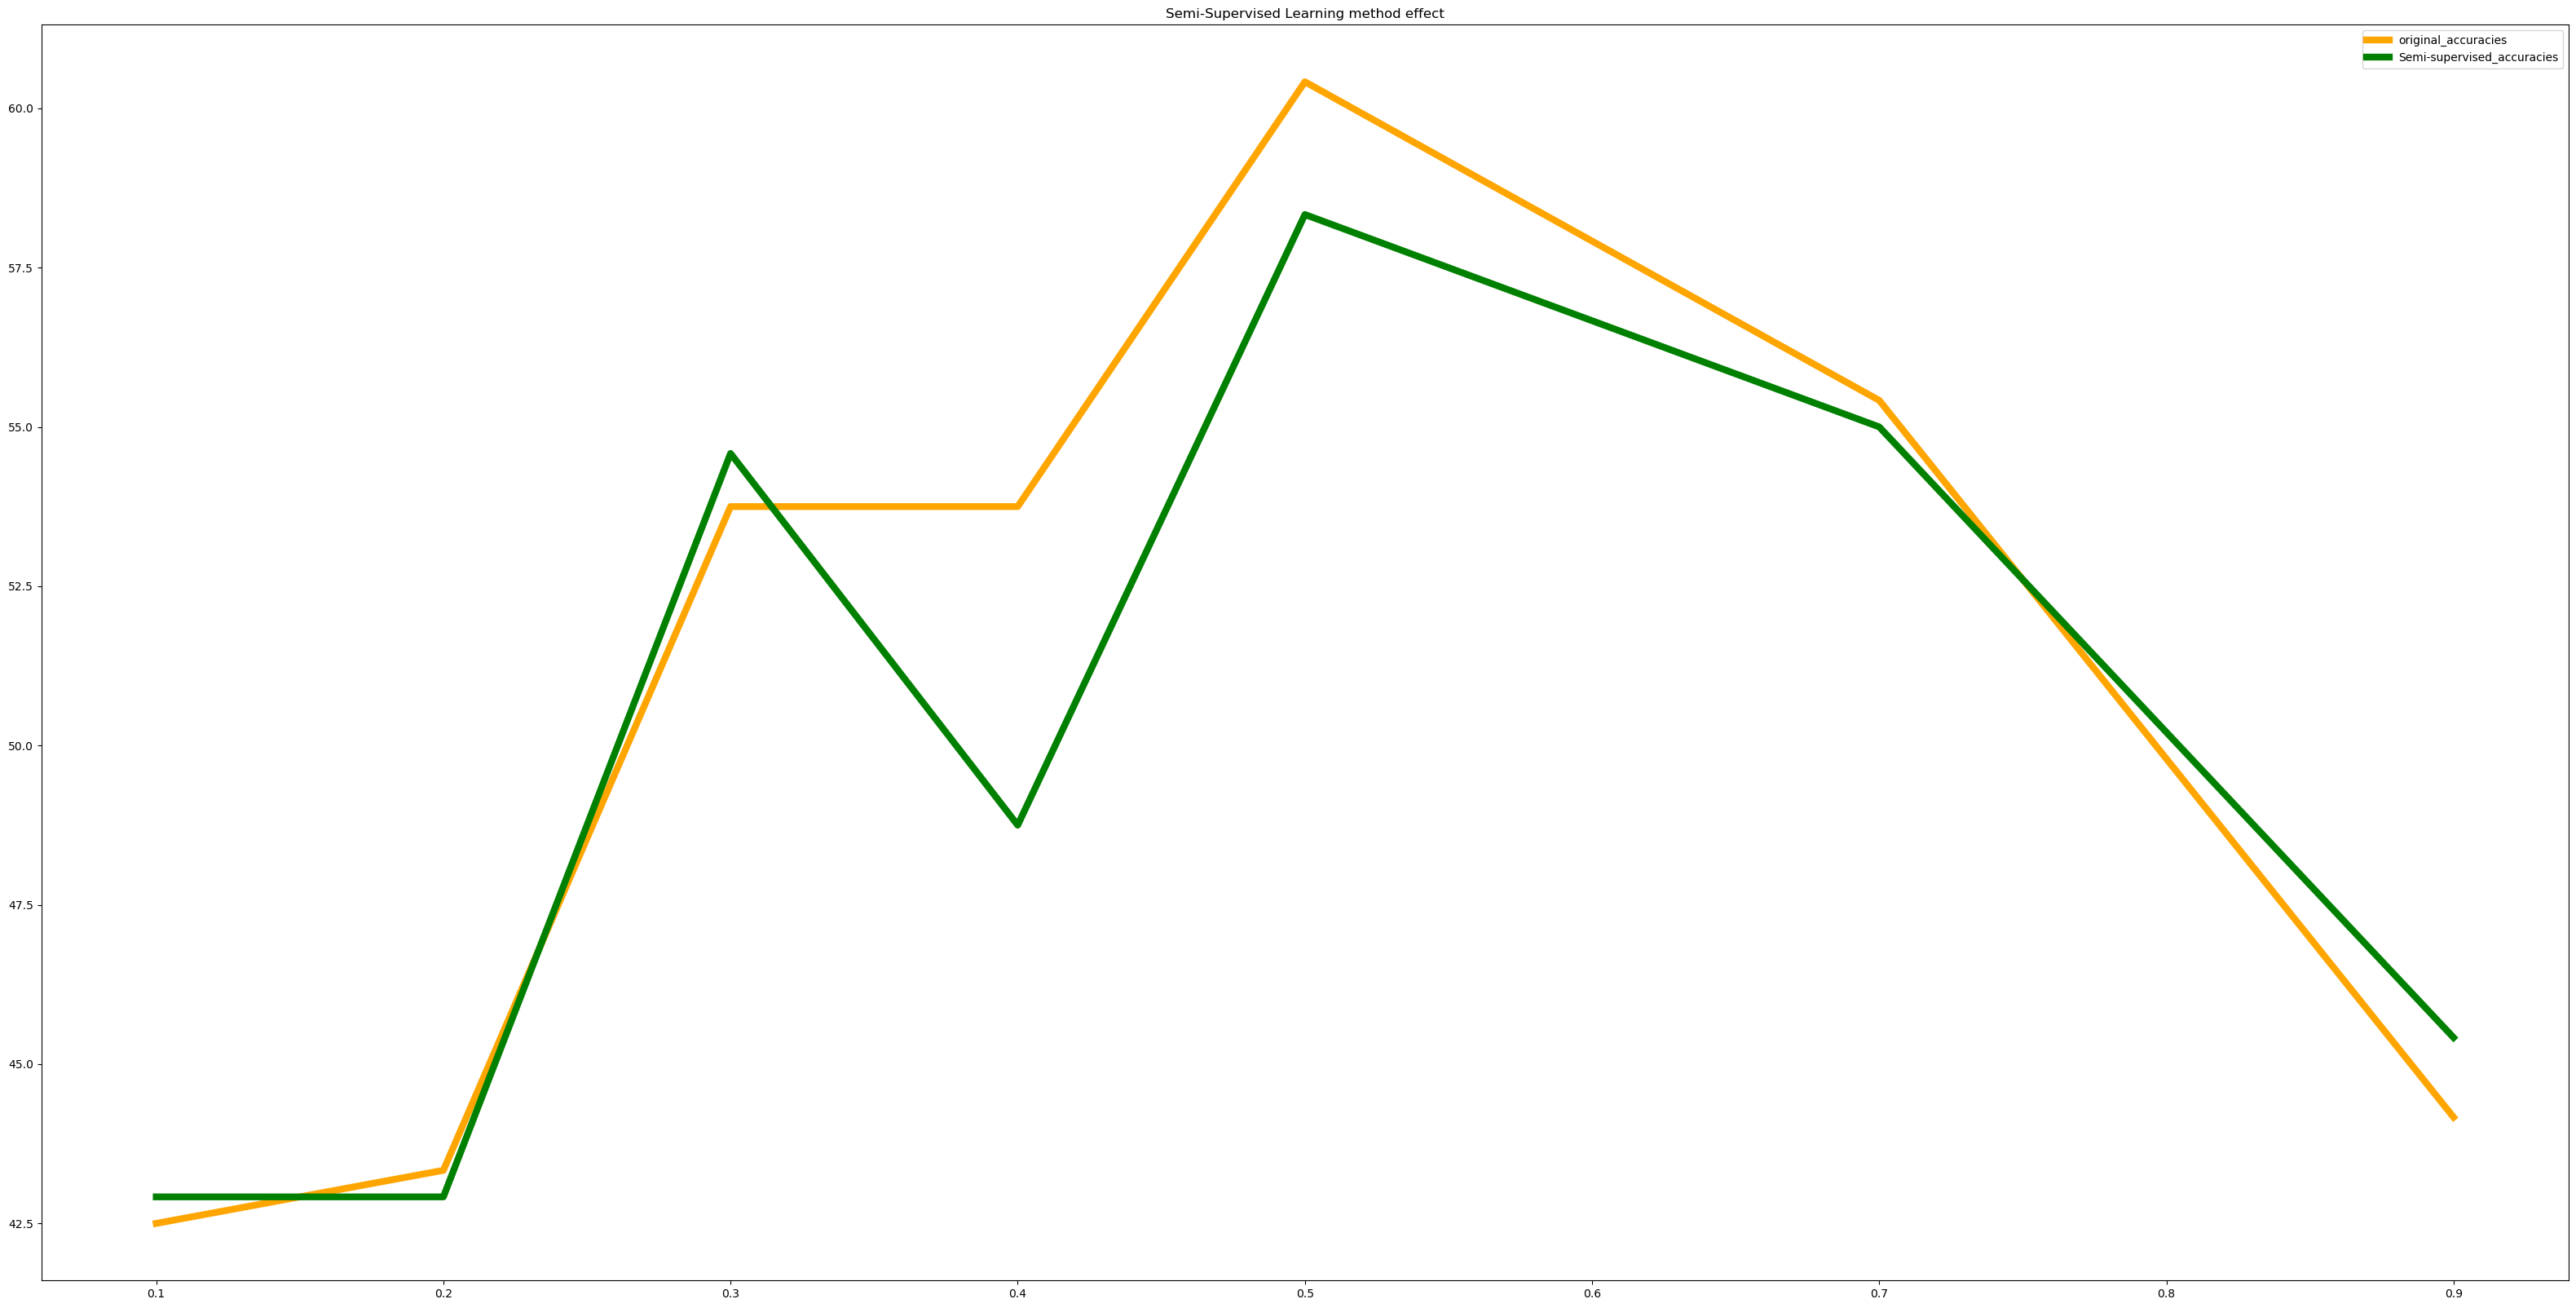

In [424]:
org_dic5 = res = dict(zip(parts, org_comp_accs5))
plot_accs(org_dic5, method_accs5,"Semi-Supervised Learning method effect")

[89.58333333333334, 90.41666666666667, 92.08333333333333, 92.08333333333333, 95.41666666666667, 92.08333333333333, 91.25]
[90.0, 91.25, 95.0, 91.25, 95.83333333333334, 95.41666666666667, 90.0]


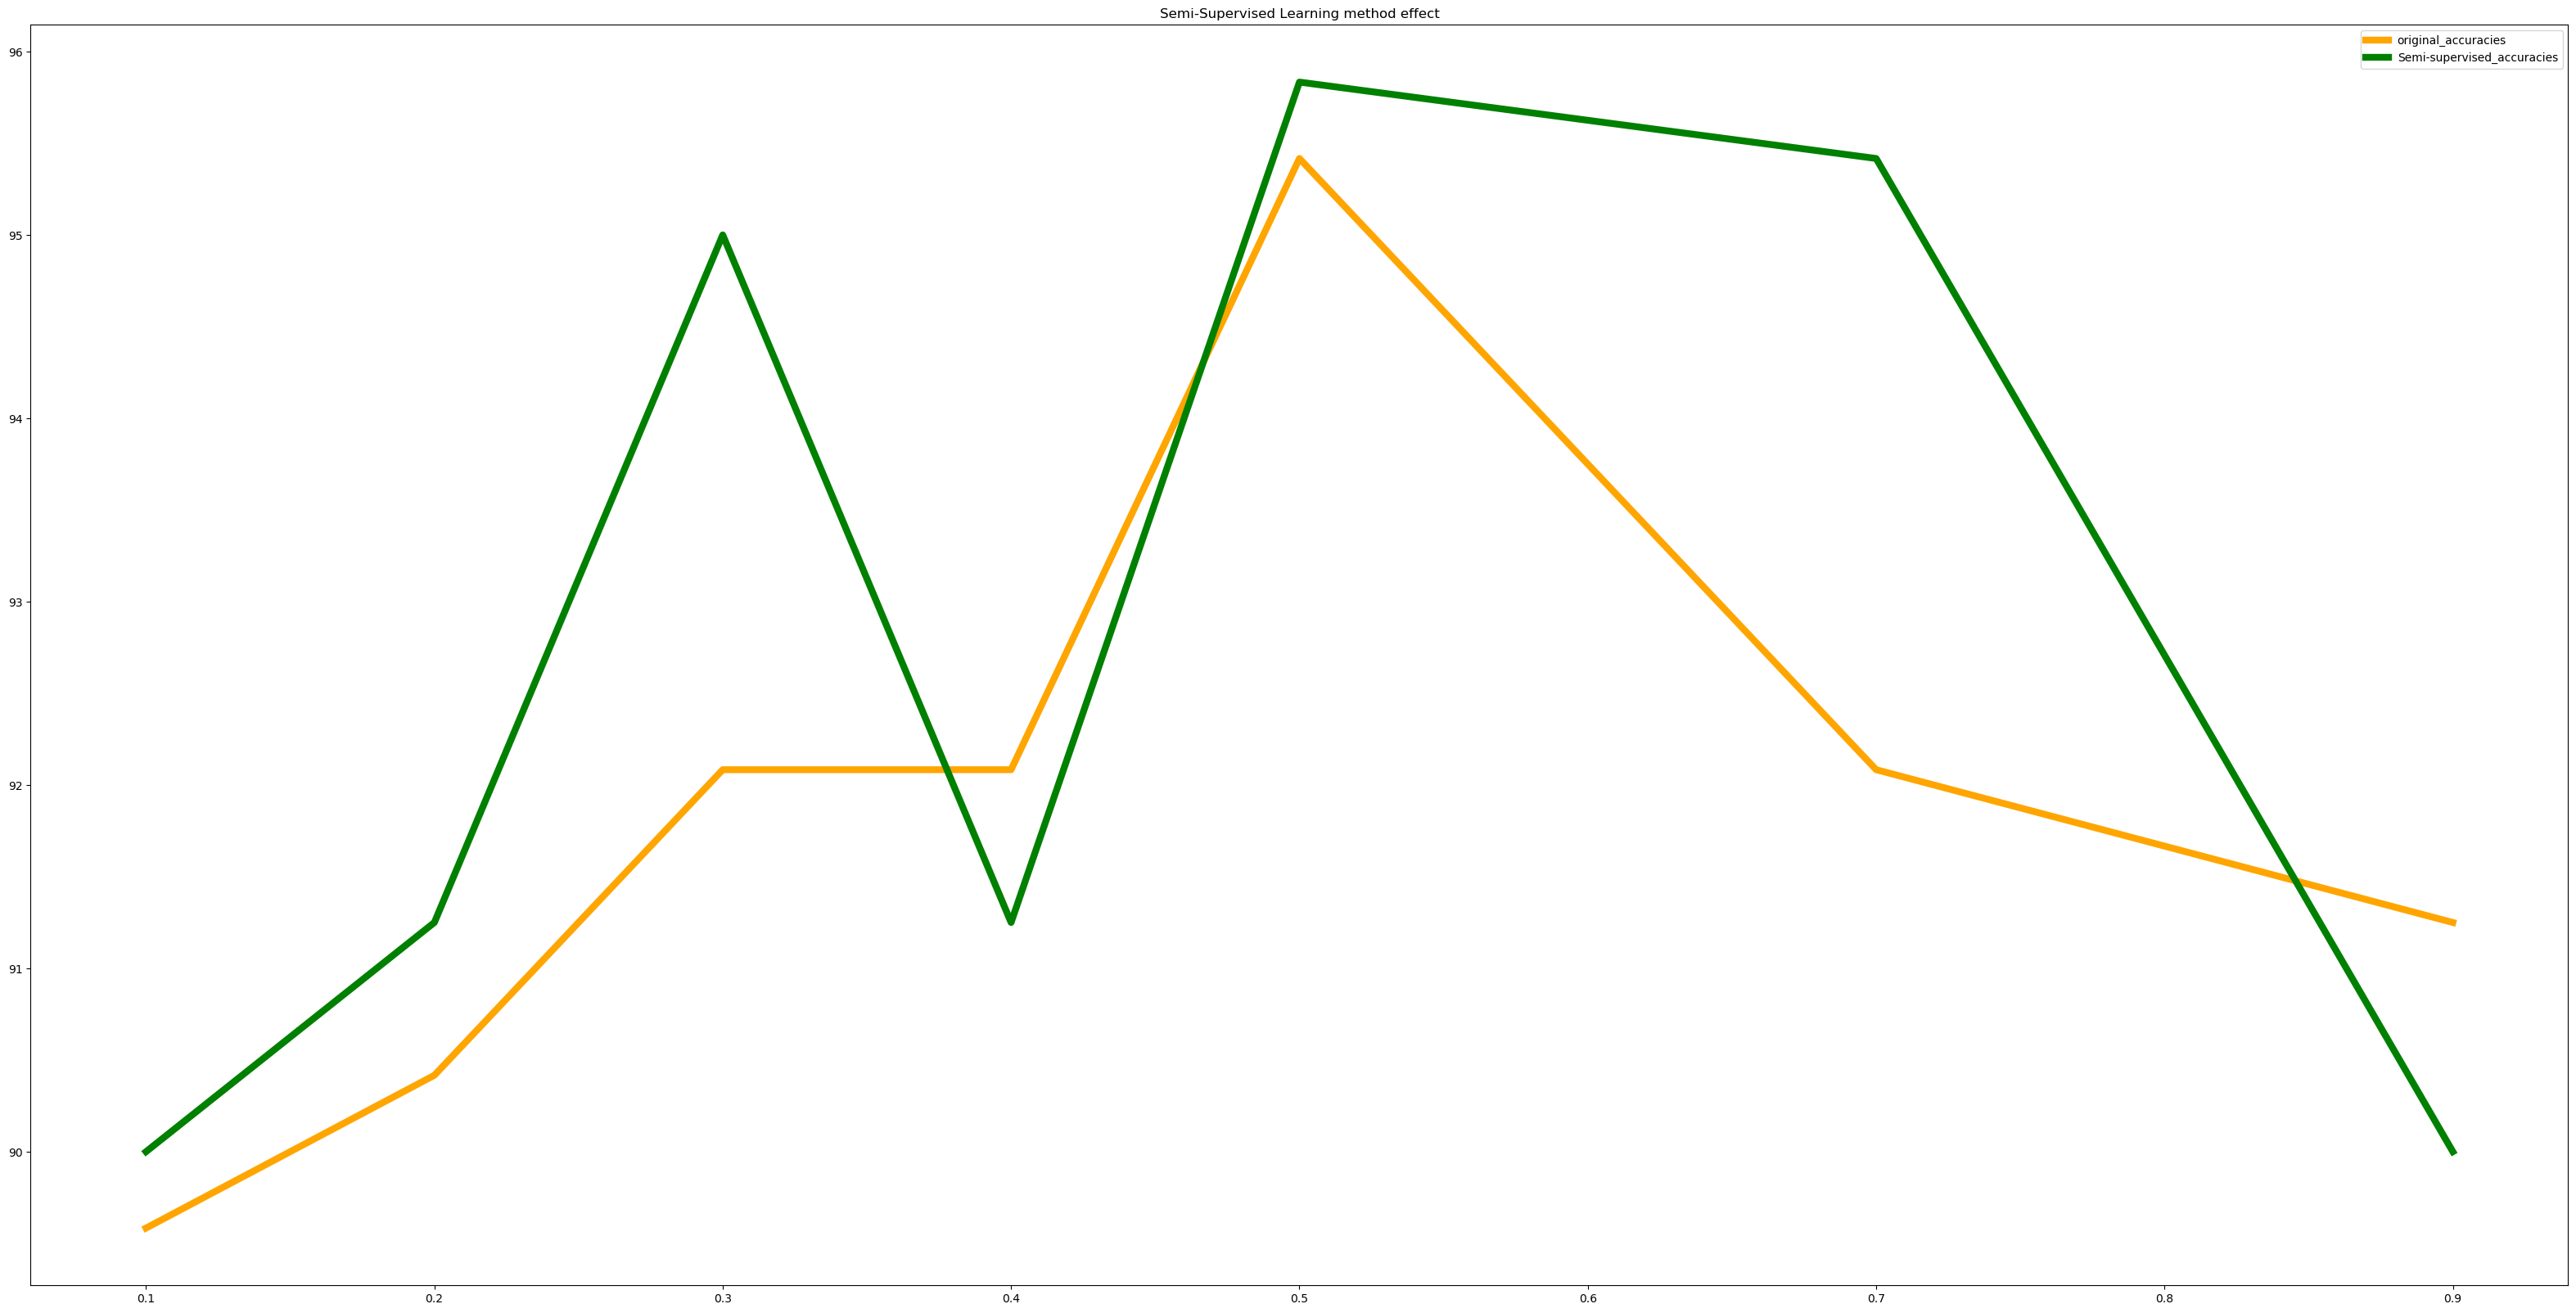

In [425]:
org_dic_room5 = res = dict(zip(parts, org_comp_accs_room5))
plot_accs(org_dic_room5, method_accs_room5,"Semi-Supervised Learning method effect")